In [2]:
from zipfile import ZipFile
import os

zip_path = '/content/images_product.zip'
extraction_path = '/content/'

if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

with ZipFile(zip_path, 'r') as zip:
    zip.extractall(extraction_path)

extraction_files = os.listdir(extraction_path)
print(extraction_files[::10])

['.config']


##Hybrid Recommendation System for Product Images and Metadata

This script builds a hybrid recommendation system that leverages both image features
(using VGG16 pre-trained CNN) and text metadata (TF-IDF vectorization).
It combines these features to recommend similar products based on a given input product.

Key Features:
1. **Image Features**: Extracted using VGG16 pre-trained model.
2. **Text Metadata**: Processed using TF-IDF Vectorizer.
3. **Hybrid Similarity**: Weighted combination of image and text similarities.
4. **Visualization**: Displays input product and recommended products as images.

Dependencies:
- TensorFlow
- scikit-learn
- matplotlib
- pandas
- PIL
- tqdm


In [3]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

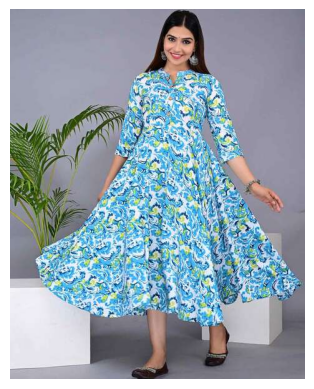

In [4]:
image_dir = '/content/images_product'

# List all files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Choose the first image file (you can change the index to display a different image)
if image_files:
  image_path = os.path.join(image_dir, image_files[0])

  try:
      img = Image.open(image_path)
      plt.imshow(img)
      plt.axis('off')  # Hide axes
      plt.show()
  except FileNotFoundError:
      print(f"Error: Image file not found at {image_path}")
  except Exception as e:
      print(f"Error displaying image: {e}")
else:
  print("No image files found in the specified directory.")

In [7]:
data = pd.read_csv('/content/images_product/cleaned_product.csv')
data.head()

Product Code                               Product Name       Brand  \
0  443048069006  Women Printed Fit & Flare Dress with Belt      FUSION   
1  443045263003            Women Floral Print Tiered Dress      FUSION   
2  467243413010               Women Embellished Gown Dress    Thapnath   
3  443043401001    Women Geometric Print Fit & Flare Dress  AVAASA SET   
4  443052384005              Women Ikat Print Tiered Dress      FUSION   

    Category                                        Offer Price  \
0  830309004  {'currencyIso': 'INR', 'value': 458, 'formatte...   
1  830309004  {'currencyIso': 'INR', 'value': 764, 'formatte...   
2  830309004  {'currencyIso': 'INR', 'value': 1800, 'formatt...   
3  830309004  {'currencyIso': 'INR', 'value': 764, 'formatte...   
4  830309004  {'currencyIso': 'INR', 'value': 407, 'formatte...   

   Original Price Discount Percent  \
0           899.0          49% off   
1          1499.0          49% off   
2          3999.0          50% off   
3          1499.0          49% off   
4           799.0          49% off   

                                         Product URL  \
0  https://www.ajio.com/fusion-women-printed-fit-...   
1  https://www.ajio.com/fusion-women-floral-print...   
2  https://www.ajio.com/thapnath-women-embellishe...   
3  https://www.ajio.com/avaasa-set-women-geometri...   
4  https://www.ajio.com/fusion-women-ikat-print-t...   

                                          Image Path Image Status  
0  /content/images_product/443048069006_Women_Pri...      Success  
1  /content/images_product/443045263003_Women_Flo...      Success  
2  /content/images_product/467243413010_Women_Emb...      Success  
3  /content/images_product/443043401001_Women_Geo...      Success  
4  /content/images_product/443052384005_Women_Ika...      Success

In [8]:
# Drop unneeded columns (e.g., Product URL)
data = data.drop(['Product URL'], axis=1)

In [9]:
# Initialize VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
def preprocess_img(img_path):
    """
    Preprocess the input image to match VGG16 input requirements.
    Args:
        img_path (str): Path to the image file.
    Returns:
        np.array: Preprocessed image array.
    """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

In [11]:
def extract_features(img_path):
    """
    Extract features from the image using VGG16.
    Args:
        img_path (str): Path to the image file.
    Returns:
        np.array: Flattened and normalized image features.
    """
    img = preprocess_img(img_path)
    features = model.predict(img)
    flattened_features = features.flatten()
    return flattened_features / np.linalg.norm(flattened_features)

In [12]:
# Extract image features for all images
image_features = []
image_paths = []
for img_path in tqdm(data['Image Path']):
    if os.path.exists(img_path):
        features = extract_features(img_path)
        image_features.append(features)
        image_paths.append(img_path)
    else:
        # Placeholder for missing images
        image_features.append(np.zeros((7 * 7 * 512)))

data['Image Features'] = image_features

  0%|          | 0/10679 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 1/10679 [00:01<3:28:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  0%|          | 2/10679 [00:01<2:26:39,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  0%|          | 3/10679 [00:02<2:07:39,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  0%|          | 4/10679 [00:02<1:59:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  0%|          | 5/10679 [00:03<1:54:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  0%|          | 6/10679 [00:04<1:52:17,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  0%|          | 7/10679 [00:04<1:49:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  0%|          | 8/10679 [00:05<1:48:44,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  0%|          | 9/10679 [00:05<1:47:38,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  0%|          | 10/10679 [00:06<1:46:36,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


  0%|          | 11/10679 [00:07<1:52:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


  0%|          | 12/10679 [00:08<2:11:35,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


  0%|          | 13/10679 [00:09<2:26:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 14/10679 [00:10<2:44:39,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 15/10679 [00:12<3:35:55,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 16/10679 [00:14<4:05:06,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 17/10679 [00:15<4:13:05,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 18/10679 [00:16<3:57:47,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


  0%|          | 19/10679 [00:17<3:31:43,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  0%|          | 20/10679 [00:18<2:59:20,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  0%|          | 21/10679 [00:18<2:37:16,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  0%|          | 22/10679 [00:19<2:20:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  0%|          | 23/10679 [00:19<2:10:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  0%|          | 24/10679 [00:20<2:02:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  0%|          | 25/10679 [00:21<1:58:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  0%|          | 26/10679 [00:21<1:54:12,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  0%|          | 27/10679 [00:22<1:52:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  0%|          | 28/10679 [00:22<1:50:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


  0%|          | 29/10679 [00:23<1:51:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


  0%|          | 30/10679 [00:24<2:09:44,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


  0%|          | 31/10679 [00:25<2:25:15,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


  0%|          | 32/10679 [00:26<2:30:57,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 33/10679 [00:27<2:45:24,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 34/10679 [00:28<2:58:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 35/10679 [00:30<3:22:28,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


  0%|          | 36/10679 [00:31<3:12:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


  0%|          | 37/10679 [00:32<3:05:51,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


  0%|          | 38/10679 [00:33<3:00:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  0%|          | 39/10679 [00:33<2:37:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  0%|          | 40/10679 [00:34<2:20:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


  0%|          | 41/10679 [00:34<2:18:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  0%|          | 42/10679 [00:35<2:10:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  0%|          | 43/10679 [00:36<2:08:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  0%|          | 44/10679 [00:36<2:01:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  0%|          | 45/10679 [00:37<1:55:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  0%|          | 46/10679 [00:38<1:52:16,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  0%|          | 47/10679 [00:38<1:50:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  0%|          | 48/10679 [00:39<1:48:28,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  0%|          | 49/10679 [00:39<1:48:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


  0%|          | 50/10679 [00:40<2:08:21,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


  0%|          | 51/10679 [00:41<2:22:34,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


  0%|          | 52/10679 [00:42<2:35:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


  0%|          | 53/10679 [00:43<2:45:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 54/10679 [00:45<2:56:04,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 55/10679 [00:46<3:03:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  1%|          | 56/10679 [00:46<2:38:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  1%|          | 57/10679 [00:47<2:23:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  1%|          | 58/10679 [00:47<2:10:59,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  1%|          | 59/10679 [00:48<2:03:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  1%|          | 60/10679 [00:49<1:57:35,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  1%|          | 61/10679 [00:49<1:54:36,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  1%|          | 62/10679 [00:50<1:51:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  1%|          | 63/10679 [00:50<1:49:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  1%|          | 64/10679 [00:51<1:48:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


  1%|          | 65/10679 [00:52<1:54:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


  1%|          | 66/10679 [00:53<1:59:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  1%|          | 67/10679 [00:53<1:55:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  1%|          | 68/10679 [00:54<1:51:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  1%|          | 69/10679 [00:54<1:49:48,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  1%|          | 70/10679 [00:55<1:47:42,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  1%|          | 71/10679 [00:55<1:47:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


  1%|          | 72/10679 [00:56<1:57:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


  1%|          | 73/10679 [00:57<2:17:37,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


  1%|          | 74/10679 [00:58<2:26:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


  1%|          | 75/10679 [00:59<2:35:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


  1%|          | 76/10679 [01:00<2:42:02,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 77/10679 [01:01<2:54:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


  1%|          | 78/10679 [01:02<2:51:13,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  1%|          | 79/10679 [01:03<2:31:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  1%|          | 80/10679 [01:04<2:16:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  1%|          | 81/10679 [01:04<2:06:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  1%|          | 82/10679 [01:05<2:00:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  1%|          | 83/10679 [01:05<1:55:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  1%|          | 84/10679 [01:06<1:53:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  1%|          | 85/10679 [01:07<1:50:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  1%|          | 86/10679 [01:07<1:49:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  1%|          | 87/10679 [01:08<1:46:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  1%|          | 88/10679 [01:08<1:46:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  1%|          | 89/10679 [01:09<1:46:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  1%|          | 90/10679 [01:09<1:45:15,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  1%|          | 91/10679 [01:10<1:45:24,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  1%|          | 92/10679 [01:11<1:44:35,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|          | 93/10679 [01:11<1:44:32,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  1%|          | 94/10679 [01:12<1:44:26,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


  1%|          | 95/10679 [01:13<1:51:17,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


  1%|          | 96/10679 [01:14<2:12:51,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


  1%|          | 97/10679 [01:15<2:27:37,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


  1%|          | 98/10679 [01:16<2:38:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


  1%|          | 99/10679 [01:17<2:50:10,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 100/10679 [01:18<3:02:14,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  1%|          | 101/10679 [01:19<2:40:40,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  1%|          | 102/10679 [01:19<2:23:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  1%|          | 103/10679 [01:20<2:13:09,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  1%|          | 104/10679 [01:20<2:05:10,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  1%|          | 105/10679 [01:21<1:58:26,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  1%|          | 106/10679 [01:22<1:54:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  1%|          | 107/10679 [01:22<1:51:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  1%|          | 108/10679 [01:23<1:49:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  1%|          | 109/10679 [01:23<1:47:29,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  1%|          | 110/10679 [01:24<1:47:28,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|          | 111/10679 [01:25<1:51:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  1%|          | 112/10679 [01:25<1:49:47,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  1%|          | 113/10679 [01:26<1:49:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  1%|          | 114/10679 [01:26<1:46:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  1%|          | 115/10679 [01:27<1:46:31,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  1%|          | 116/10679 [01:28<1:44:46,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


  1%|          | 117/10679 [01:28<1:49:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


  1%|          | 118/10679 [01:29<2:11:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


  1%|          | 119/10679 [01:30<2:24:19,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


  1%|          | 120/10679 [01:31<2:33:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 121/10679 [01:32<2:47:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 122/10679 [01:34<3:10:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  1%|          | 123/10679 [01:34<2:44:25,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  1%|          | 124/10679 [01:35<2:25:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  1%|          | 125/10679 [01:36<2:12:33,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  1%|          | 126/10679 [01:36<2:03:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  1%|          | 127/10679 [01:37<1:57:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  1%|          | 128/10679 [01:37<1:53:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


  1%|          | 129/10679 [01:38<1:49:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  1%|          | 130/10679 [01:39<1:47:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  1%|          | 131/10679 [01:39<1:45:48,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  1%|          | 132/10679 [01:40<1:44:46,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  1%|          | 133/10679 [01:40<1:44:49,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  1%|▏         | 134/10679 [01:41<1:43:34,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  1%|▏         | 135/10679 [01:41<1:43:13,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  1%|▏         | 136/10679 [01:42<1:42:17,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  1%|▏         | 137/10679 [01:43<1:43:24,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  1%|▏         | 138/10679 [01:43<1:42:40,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  1%|▏         | 139/10679 [01:44<1:44:13,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


  1%|▏         | 140/10679 [01:45<2:07:05,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step


  1%|▏         | 141/10679 [01:46<2:19:35,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


  1%|▏         | 142/10679 [01:47<2:27:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|▏         | 143/10679 [01:48<2:41:07,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|▏         | 144/10679 [01:49<2:49:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|▏         | 145/10679 [01:50<3:01:00,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|▏         | 146/10679 [01:51<2:38:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|▏         | 147/10679 [01:51<2:21:50,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  1%|▏         | 148/10679 [01:52<2:10:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  1%|▏         | 149/10679 [01:52<2:03:06,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  1%|▏         | 150/10679 [01:53<1:57:13,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  1%|▏         | 151/10679 [01:54<1:52:12,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  1%|▏         | 152/10679 [01:54<1:49:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  1%|▏         | 153/10679 [01:55<1:46:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  1%|▏         | 154/10679 [01:55<1:45:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  1%|▏         | 155/10679 [01:56<1:44:25,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  1%|▏         | 156/10679 [01:57<1:44:17,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  1%|▏         | 157/10679 [01:57<1:44:51,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  1%|▏         | 158/10679 [01:58<1:43:20,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  1%|▏         | 159/10679 [01:58<1:43:34,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


  1%|▏         | 160/10679 [01:59<1:42:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  2%|▏         | 161/10679 [02:00<1:43:12,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  2%|▏         | 162/10679 [02:00<1:42:28,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


  2%|▏         | 163/10679 [02:01<2:03:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


  2%|▏         | 164/10679 [02:02<2:19:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


  2%|▏         | 165/10679 [02:03<2:28:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


  2%|▏         | 166/10679 [02:04<2:39:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 167/10679 [02:05<2:55:15,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


  2%|▏         | 168/10679 [02:06<2:39:06,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  2%|▏         | 169/10679 [02:07<2:23:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  2%|▏         | 170/10679 [02:07<2:10:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  2%|▏         | 171/10679 [02:08<2:02:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  2%|▏         | 172/10679 [02:08<1:56:29,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  2%|▏         | 173/10679 [02:09<1:53:01,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  2%|▏         | 174/10679 [02:10<1:49:12,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  2%|▏         | 175/10679 [02:10<1:47:41,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  2%|▏         | 176/10679 [02:11<1:46:00,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  2%|▏         | 177/10679 [02:11<1:45:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  2%|▏         | 178/10679 [02:12<1:45:12,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  2%|▏         | 179/10679 [02:13<1:44:13,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  2%|▏         | 180/10679 [02:13<1:43:52,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  2%|▏         | 181/10679 [02:14<1:43:10,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  2%|▏         | 182/10679 [02:14<1:43:30,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  2%|▏         | 183/10679 [02:15<1:42:53,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  2%|▏         | 184/10679 [02:15<1:42:46,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


  2%|▏         | 185/10679 [02:16<1:57:18,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


  2%|▏         | 186/10679 [02:17<2:16:53,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 187/10679 [02:19<2:53:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 188/10679 [02:20<2:59:51,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 189/10679 [02:21<3:07:34,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


  2%|▏         | 190/10679 [02:22<3:05:40,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▏         | 191/10679 [02:23<2:41:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  2%|▏         | 192/10679 [02:23<2:23:39,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  2%|▏         | 193/10679 [02:24<2:11:12,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  2%|▏         | 194/10679 [02:25<2:07:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  2%|▏         | 195/10679 [02:25<1:59:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  2%|▏         | 196/10679 [02:26<1:56:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  2%|▏         | 197/10679 [02:26<1:52:00,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  2%|▏         | 198/10679 [02:27<1:50:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  2%|▏         | 199/10679 [02:28<1:47:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  2%|▏         | 200/10679 [02:28<1:46:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  2%|▏         | 201/10679 [02:29<1:46:28,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  2%|▏         | 202/10679 [02:29<1:45:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  2%|▏         | 203/10679 [02:30<1:46:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  2%|▏         | 204/10679 [02:31<1:45:49,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  2%|▏         | 205/10679 [02:31<1:45:01,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  2%|▏         | 206/10679 [02:32<1:46:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


  2%|▏         | 207/10679 [02:33<1:57:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


  2%|▏         | 208/10679 [02:34<2:18:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


  2%|▏         | 209/10679 [02:35<2:29:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


  2%|▏         | 210/10679 [02:36<2:41:14,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


  2%|▏         | 211/10679 [02:37<2:49:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 212/10679 [02:38<2:57:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


  2%|▏         | 213/10679 [02:39<2:45:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  2%|▏         | 214/10679 [02:39<2:27:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  2%|▏         | 215/10679 [02:40<2:13:35,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  2%|▏         | 216/10679 [02:41<2:04:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  2%|▏         | 217/10679 [02:41<1:57:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  2%|▏         | 218/10679 [02:42<1:54:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  2%|▏         | 219/10679 [02:42<1:51:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  2%|▏         | 220/10679 [02:43<1:50:03,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  2%|▏         | 221/10679 [02:44<1:47:58,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


  2%|▏         | 222/10679 [02:44<1:45:25,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  2%|▏         | 223/10679 [02:45<1:45:19,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  2%|▏         | 224/10679 [02:45<1:44:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▏         | 225/10679 [02:46<1:44:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  2%|▏         | 226/10679 [02:47<1:44:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  2%|▏         | 227/10679 [02:47<1:45:48,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  2%|▏         | 228/10679 [02:48<1:45:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  2%|▏         | 229/10679 [02:48<1:44:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


  2%|▏         | 230/10679 [02:49<2:02:59,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


  2%|▏         | 231/10679 [02:51<2:37:49,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


  2%|▏         | 232/10679 [02:52<2:44:41,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 233/10679 [02:53<2:57:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 234/10679 [02:54<3:02:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  2%|▏         | 235/10679 [02:55<2:43:53,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  2%|▏         | 236/10679 [02:55<2:26:33,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  2%|▏         | 237/10679 [02:56<2:13:43,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▏         | 238/10679 [02:57<2:05:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  2%|▏         | 239/10679 [02:57<1:58:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▏         | 240/10679 [02:58<1:54:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  2%|▏         | 241/10679 [02:58<1:52:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  2%|▏         | 242/10679 [02:59<1:50:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  2%|▏         | 243/10679 [03:00<1:48:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  2%|▏         | 244/10679 [03:00<1:47:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  2%|▏         | 245/10679 [03:01<1:46:54,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  2%|▏         | 246/10679 [03:01<1:46:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  2%|▏         | 247/10679 [03:02<1:46:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  2%|▏         | 248/10679 [03:03<1:46:59,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  2%|▏         | 249/10679 [03:03<1:45:59,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▏         | 250/10679 [03:04<1:45:49,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


  2%|▏         | 251/10679 [03:05<1:50:34,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


  2%|▏         | 252/10679 [03:06<2:13:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


  2%|▏         | 253/10679 [03:07<2:28:10,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


  2%|▏         | 254/10679 [03:08<2:37:42,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 255/10679 [03:09<2:52:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  2%|▏         | 256/10679 [03:10<3:02:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


  2%|▏         | 257/10679 [03:11<2:52:59,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  2%|▏         | 258/10679 [03:12<2:32:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  2%|▏         | 259/10679 [03:12<2:18:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  2%|▏         | 260/10679 [03:13<2:08:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  2%|▏         | 261/10679 [03:13<2:01:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  2%|▏         | 262/10679 [03:14<1:57:02,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  2%|▏         | 263/10679 [03:15<1:53:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  2%|▏         | 264/10679 [03:15<1:51:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  2%|▏         | 265/10679 [03:16<1:49:17,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  2%|▏         | 266/10679 [03:16<1:48:38,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  3%|▎         | 267/10679 [03:17<1:47:02,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  3%|▎         | 268/10679 [03:18<1:46:26,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  3%|▎         | 269/10679 [03:18<1:45:12,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  3%|▎         | 270/10679 [03:19<1:45:35,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  3%|▎         | 271/10679 [03:19<1:45:53,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  3%|▎         | 272/10679 [03:20<1:45:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  3%|▎         | 273/10679 [03:21<1:45:45,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


  3%|▎         | 274/10679 [03:22<2:05:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


  3%|▎         | 275/10679 [03:23<2:23:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


  3%|▎         | 276/10679 [03:24<2:33:02,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 277/10679 [03:25<2:46:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 278/10679 [03:26<2:57:33,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 279/10679 [03:27<3:03:11,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  3%|▎         | 280/10679 [03:28<2:38:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  3%|▎         | 281/10679 [03:28<2:23:16,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  3%|▎         | 282/10679 [03:29<2:11:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  3%|▎         | 283/10679 [03:30<2:03:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  3%|▎         | 284/10679 [03:30<1:59:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  3%|▎         | 285/10679 [03:31<1:55:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  3%|▎         | 286/10679 [03:31<1:53:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  3%|▎         | 287/10679 [03:32<1:51:01,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  3%|▎         | 288/10679 [03:33<1:49:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  3%|▎         | 289/10679 [03:33<1:48:44,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  3%|▎         | 290/10679 [03:34<1:47:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  3%|▎         | 291/10679 [03:34<1:47:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  3%|▎         | 292/10679 [03:35<1:46:08,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  3%|▎         | 293/10679 [03:36<1:45:58,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  3%|▎         | 294/10679 [03:36<1:45:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  3%|▎         | 295/10679 [03:37<1:45:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


  3%|▎         | 296/10679 [03:38<1:56:08,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


  3%|▎         | 297/10679 [03:39<2:15:04,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


  3%|▎         | 298/10679 [03:40<2:27:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


  3%|▎         | 299/10679 [03:41<2:37:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 300/10679 [03:42<2:49:51,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 301/10679 [03:43<3:00:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  3%|▎         | 302/10679 [03:44<2:37:28,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  3%|▎         | 303/10679 [03:44<2:21:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  3%|▎         | 304/10679 [03:45<2:10:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  3%|▎         | 305/10679 [03:46<2:02:15,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  3%|▎         | 306/10679 [03:46<1:57:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  3%|▎         | 307/10679 [03:47<1:52:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  3%|▎         | 308/10679 [03:47<1:49:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  3%|▎         | 309/10679 [03:48<1:48:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  3%|▎         | 310/10679 [03:49<1:45:51,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  3%|▎         | 311/10679 [03:49<1:45:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  3%|▎         | 312/10679 [03:50<1:46:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  3%|▎         | 313/10679 [03:50<1:46:12,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  3%|▎         | 314/10679 [03:51<1:44:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  3%|▎         | 315/10679 [03:52<1:44:41,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


  3%|▎         | 316/10679 [03:52<1:46:48,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  3%|▎         | 317/10679 [03:53<1:45:29,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


  3%|▎         | 318/10679 [03:54<1:53:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


  3%|▎         | 319/10679 [03:55<2:12:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


  3%|▎         | 320/10679 [03:56<2:24:47,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


  3%|▎         | 321/10679 [03:57<2:37:02,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 322/10679 [03:58<2:50:40,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 323/10679 [03:59<2:57:08,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  3%|▎         | 324/10679 [04:00<2:37:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


  3%|▎         | 325/10679 [04:00<2:26:07,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 326/10679 [04:02<2:44:51,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  3%|▎         | 327/10679 [04:03<3:25:56,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  3%|▎         | 328/10679 [04:05<4:13:34,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  3%|▎         | 329/10679 [04:07<4:42:42,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 330/10679 [04:09<4:39:00,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  3%|▎         | 331/10679 [04:12<5:40:32,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  3%|▎         | 332/10679 [04:15<6:40:16,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 333/10679 [04:17<6:13:47,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 334/10679 [04:18<5:43:11,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 335/10679 [04:20<5:02:17,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


  3%|▎         | 336/10679 [04:21<4:26:22,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 337/10679 [04:22<4:20:11,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 338/10679 [04:23<4:10:38,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 339/10679 [04:25<3:57:15,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


  3%|▎         | 340/10679 [04:25<3:28:19,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


  3%|▎         | 341/10679 [04:26<3:01:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


  3%|▎         | 342/10679 [04:27<3:00:31,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


  3%|▎         | 343/10679 [04:28<3:01:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


  3%|▎         | 344/10679 [04:29<3:00:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 345/10679 [04:30<3:08:57,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 346/10679 [04:32<3:12:11,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  3%|▎         | 347/10679 [04:32<2:45:42,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  3%|▎         | 348/10679 [04:33<2:27:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  3%|▎         | 349/10679 [04:33<2:15:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  3%|▎         | 350/10679 [04:34<2:04:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  3%|▎         | 351/10679 [04:35<1:59:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  3%|▎         | 352/10679 [04:35<1:53:57,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  3%|▎         | 353/10679 [04:36<1:51:49,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  3%|▎         | 354/10679 [04:36<1:49:21,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  3%|▎         | 355/10679 [04:37<1:47:13,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  3%|▎         | 356/10679 [04:38<1:45:58,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  3%|▎         | 357/10679 [04:38<1:44:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  3%|▎         | 358/10679 [04:39<1:45:20,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  3%|▎         | 359/10679 [04:39<1:44:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  3%|▎         | 360/10679 [04:40<1:44:48,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  3%|▎         | 361/10679 [04:41<1:43:50,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  3%|▎         | 362/10679 [04:41<1:43:44,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


  3%|▎         | 363/10679 [04:42<1:53:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


  3%|▎         | 364/10679 [04:43<2:14:30,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


  3%|▎         | 365/10679 [04:44<2:26:41,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


  3%|▎         | 366/10679 [04:45<2:36:04,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 367/10679 [04:46<2:50:29,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 368/10679 [04:47<2:59:22,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  3%|▎         | 369/10679 [04:48<2:35:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  3%|▎         | 370/10679 [04:49<2:21:15,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  3%|▎         | 371/10679 [04:49<2:10:46,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  3%|▎         | 372/10679 [04:50<2:02:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  3%|▎         | 373/10679 [04:51<1:57:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  4%|▎         | 374/10679 [04:51<1:52:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▎         | 375/10679 [04:52<1:50:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


  4%|▎         | 376/10679 [04:52<1:49:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  4%|▎         | 377/10679 [04:53<1:48:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


  4%|▎         | 378/10679 [04:54<1:55:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  4%|▎         | 379/10679 [04:54<1:51:16,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


  4%|▎         | 380/10679 [04:55<1:53:31,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  4%|▎         | 381/10679 [04:56<1:50:52,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  4%|▎         | 382/10679 [04:56<1:48:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  4%|▎         | 383/10679 [04:57<1:47:58,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  4%|▎         | 384/10679 [04:57<1:45:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


  4%|▎         | 385/10679 [04:59<2:08:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  4%|▎         | 386/10679 [05:00<2:25:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step


  4%|▎         | 387/10679 [05:01<2:29:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


  4%|▎         | 388/10679 [05:02<2:37:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▎         | 389/10679 [05:03<2:51:47,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


  4%|▎         | 390/10679 [05:04<2:44:05,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▎         | 391/10679 [05:04<2:26:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  4%|▎         | 392/10679 [05:05<2:12:57,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  4%|▎         | 393/10679 [05:05<2:04:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  4%|▎         | 394/10679 [05:06<1:58:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  4%|▎         | 395/10679 [05:07<1:54:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  4%|▎         | 396/10679 [05:07<1:51:46,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▎         | 397/10679 [05:08<1:49:08,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▎         | 398/10679 [05:08<1:47:40,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  4%|▎         | 399/10679 [05:09<1:46:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


  4%|▎         | 400/10679 [05:10<1:46:58,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  4%|▍         | 401/10679 [05:10<1:46:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  4%|▍         | 402/10679 [05:11<1:50:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▍         | 403/10679 [05:12<1:48:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  4%|▍         | 404/10679 [05:12<1:46:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  4%|▍         | 405/10679 [05:13<1:46:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


  4%|▍         | 406/10679 [05:13<1:47:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


  4%|▍         | 407/10679 [05:15<2:09:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


  4%|▍         | 408/10679 [05:16<2:23:32,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 409/10679 [05:17<2:53:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  4%|▍         | 410/10679 [05:19<3:51:56,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


  4%|▍         | 411/10679 [05:20<3:22:46,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  4%|▍         | 412/10679 [05:20<2:52:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  4%|▍         | 413/10679 [05:21<2:31:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  4%|▍         | 414/10679 [05:22<2:16:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  4%|▍         | 415/10679 [05:22<2:06:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  4%|▍         | 416/10679 [05:23<2:00:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  4%|▍         | 417/10679 [05:24<1:54:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  4%|▍         | 418/10679 [05:24<1:51:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  4%|▍         | 419/10679 [05:25<1:48:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  4%|▍         | 420/10679 [05:25<1:47:21,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  4%|▍         | 421/10679 [05:26<1:45:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  4%|▍         | 422/10679 [05:27<1:44:55,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  4%|▍         | 423/10679 [05:27<1:49:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  4%|▍         | 424/10679 [05:28<1:46:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  4%|▍         | 425/10679 [05:28<1:46:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▍         | 426/10679 [05:29<1:45:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


  4%|▍         | 427/10679 [05:30<1:49:34,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 428/10679 [05:31<2:13:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


  4%|▍         | 429/10679 [05:32<2:26:21,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


  4%|▍         | 430/10679 [05:33<2:35:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


  4%|▍         | 431/10679 [05:34<2:43:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


  4%|▍         | 432/10679 [05:35<2:49:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 433/10679 [05:36<2:57:00,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  4%|▍         | 434/10679 [05:37<2:35:47,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  4%|▍         | 435/10679 [05:37<2:19:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  4%|▍         | 436/10679 [05:38<2:08:39,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  4%|▍         | 437/10679 [05:39<1:59:59,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  4%|▍         | 438/10679 [05:39<1:54:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  4%|▍         | 439/10679 [05:40<1:50:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  4%|▍         | 440/10679 [05:40<1:48:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  4%|▍         | 441/10679 [05:41<1:47:14,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  4%|▍         | 442/10679 [05:42<1:45:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  4%|▍         | 443/10679 [05:42<1:45:50,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▍         | 444/10679 [05:43<1:44:58,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  4%|▍         | 445/10679 [05:43<1:45:10,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


  4%|▍         | 446/10679 [05:44<1:52:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


  4%|▍         | 447/10679 [05:46<2:28:14,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


  4%|▍         | 448/10679 [05:47<2:53:26,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 449/10679 [05:48<3:06:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


  4%|▍         | 450/10679 [05:49<3:00:01,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


  4%|▍         | 451/10679 [05:50<3:00:28,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 452/10679 [05:51<3:04:05,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 453/10679 [05:53<3:08:08,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


  4%|▍         | 454/10679 [05:53<2:52:58,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▍         | 455/10679 [05:54<2:32:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


  4%|▍         | 456/10679 [05:55<2:36:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  4%|▍         | 457/10679 [05:56<2:19:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  4%|▍         | 458/10679 [05:56<2:09:19,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  4%|▍         | 459/10679 [05:57<2:01:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  4%|▍         | 460/10679 [05:57<1:55:49,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  4%|▍         | 461/10679 [05:58<1:51:32,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  4%|▍         | 462/10679 [05:59<1:48:34,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  4%|▍         | 463/10679 [05:59<1:47:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  4%|▍         | 464/10679 [06:00<1:50:38,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  4%|▍         | 465/10679 [06:00<1:48:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  4%|▍         | 466/10679 [06:01<1:47:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  4%|▍         | 467/10679 [06:02<1:45:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  4%|▍         | 468/10679 [06:02<1:45:23,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▍         | 469/10679 [06:03<1:44:22,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


  4%|▍         | 470/10679 [06:04<2:01:07,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


  4%|▍         | 471/10679 [06:05<2:18:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


  4%|▍         | 472/10679 [06:06<2:26:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 473/10679 [06:07<2:39:46,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 474/10679 [06:08<2:51:29,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  4%|▍         | 475/10679 [06:09<2:55:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  4%|▍         | 476/10679 [06:10<2:33:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  4%|▍         | 477/10679 [06:10<2:18:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  4%|▍         | 478/10679 [06:11<2:07:26,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  4%|▍         | 479/10679 [06:12<2:00:23,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  4%|▍         | 480/10679 [06:12<1:55:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  5%|▍         | 481/10679 [06:13<1:52:57,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  5%|▍         | 482/10679 [06:13<1:49:25,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  5%|▍         | 483/10679 [06:14<1:47:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  5%|▍         | 484/10679 [06:15<1:45:34,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  5%|▍         | 485/10679 [06:15<1:46:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  5%|▍         | 486/10679 [06:16<1:49:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  5%|▍         | 487/10679 [06:17<1:47:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  5%|▍         | 488/10679 [06:17<1:46:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  5%|▍         | 489/10679 [06:18<1:44:48,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  5%|▍         | 490/10679 [06:18<1:44:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  5%|▍         | 491/10679 [06:19<1:44:22,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


  5%|▍         | 492/10679 [06:20<1:58:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


  5%|▍         | 493/10679 [06:21<2:17:24,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


  5%|▍         | 494/10679 [06:22<2:26:20,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


  5%|▍         | 495/10679 [06:23<2:36:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 496/10679 [06:24<2:51:15,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 497/10679 [06:25<2:58:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  5%|▍         | 498/10679 [06:26<2:34:45,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  5%|▍         | 499/10679 [06:27<2:19:40,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  5%|▍         | 500/10679 [06:27<2:07:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  5%|▍         | 501/10679 [06:28<1:59:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  5%|▍         | 502/10679 [06:28<1:54:22,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  5%|▍         | 503/10679 [06:29<1:55:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  5%|▍         | 504/10679 [06:30<1:51:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  5%|▍         | 505/10679 [06:30<1:48:19,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  5%|▍         | 506/10679 [06:31<1:47:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  5%|▍         | 507/10679 [06:31<1:45:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  5%|▍         | 508/10679 [06:32<1:44:40,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  5%|▍         | 509/10679 [06:33<1:45:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  5%|▍         | 510/10679 [06:33<1:44:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  5%|▍         | 511/10679 [06:34<1:44:04,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  5%|▍         | 512/10679 [06:35<1:43:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  5%|▍         | 513/10679 [06:35<1:47:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


  5%|▍         | 514/10679 [06:36<2:06:35,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


  5%|▍         | 515/10679 [06:37<2:23:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


  5%|▍         | 516/10679 [06:38<2:30:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 517/10679 [06:39<2:42:30,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 518/10679 [06:41<2:51:31,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▍         | 519/10679 [06:42<3:00:18,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  5%|▍         | 520/10679 [06:42<2:37:19,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  5%|▍         | 521/10679 [06:43<2:20:16,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  5%|▍         | 522/10679 [06:44<2:08:50,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  5%|▍         | 523/10679 [06:44<2:00:18,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  5%|▍         | 524/10679 [06:45<1:55:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  5%|▍         | 525/10679 [06:45<1:51:17,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  5%|▍         | 526/10679 [06:46<1:48:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  5%|▍         | 527/10679 [06:47<1:47:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  5%|▍         | 528/10679 [06:47<1:45:28,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  5%|▍         | 529/10679 [06:48<1:44:56,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  5%|▍         | 530/10679 [06:48<1:44:26,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  5%|▍         | 531/10679 [06:49<1:43:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  5%|▍         | 532/10679 [06:50<1:43:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  5%|▍         | 533/10679 [06:50<1:42:10,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  5%|▌         | 534/10679 [06:51<1:42:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  5%|▌         | 535/10679 [06:51<1:41:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


  5%|▌         | 536/10679 [06:52<1:50:10,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


  5%|▌         | 537/10679 [06:53<2:11:40,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


  5%|▌         | 538/10679 [06:54<2:23:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


  5%|▌         | 539/10679 [06:55<2:35:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▌         | 540/10679 [06:57<2:48:06,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▌         | 541/10679 [06:58<2:56:13,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  5%|▌         | 542/10679 [06:58<2:34:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  5%|▌         | 543/10679 [06:59<2:18:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  5%|▌         | 544/10679 [06:59<2:07:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  5%|▌         | 545/10679 [07:00<1:59:58,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  5%|▌         | 546/10679 [07:01<1:53:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  5%|▌         | 547/10679 [07:01<1:50:46,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  5%|▌         | 548/10679 [07:02<1:48:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  5%|▌         | 549/10679 [07:03<1:46:15,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  5%|▌         | 550/10679 [07:03<1:45:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  5%|▌         | 551/10679 [07:04<1:44:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  5%|▌         | 552/10679 [07:04<1:43:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  5%|▌         | 553/10679 [07:05<1:43:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  5%|▌         | 554/10679 [07:06<1:42:59,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


  5%|▌         | 555/10679 [07:06<1:41:48,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  5%|▌         | 556/10679 [07:07<1:41:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  5%|▌         | 557/10679 [07:07<1:42:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


  5%|▌         | 558/10679 [07:08<1:48:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


  5%|▌         | 559/10679 [07:09<2:09:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


  5%|▌         | 560/10679 [07:10<2:22:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


  5%|▌         | 561/10679 [07:11<2:28:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


  5%|▌         | 562/10679 [07:12<2:33:15,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▌         | 563/10679 [07:13<2:44:54,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▌         | 564/10679 [07:14<2:55:28,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  5%|▌         | 565/10679 [07:15<2:33:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  5%|▌         | 566/10679 [07:16<2:17:40,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  5%|▌         | 567/10679 [07:16<2:06:56,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  5%|▌         | 568/10679 [07:17<1:59:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  5%|▌         | 569/10679 [07:17<1:54:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  5%|▌         | 570/10679 [07:18<1:50:54,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  5%|▌         | 571/10679 [07:19<1:48:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  5%|▌         | 572/10679 [07:19<1:46:58,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  5%|▌         | 573/10679 [07:20<1:45:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  5%|▌         | 574/10679 [07:20<1:43:52,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  5%|▌         | 575/10679 [07:21<1:43:41,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  5%|▌         | 576/10679 [07:22<1:42:46,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  5%|▌         | 577/10679 [07:22<1:43:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  5%|▌         | 578/10679 [07:23<1:44:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  5%|▌         | 579/10679 [07:24<1:44:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  5%|▌         | 580/10679 [07:24<1:44:11,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


  5%|▌         | 581/10679 [07:25<1:52:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  5%|▌         | 582/10679 [07:26<2:14:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


  5%|▌         | 583/10679 [07:27<2:26:14,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


  5%|▌         | 584/10679 [07:28<2:34:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


  5%|▌         | 585/10679 [07:29<2:43:26,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  5%|▌         | 586/10679 [07:30<2:53:34,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


  5%|▌         | 587/10679 [07:31<2:46:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  6%|▌         | 588/10679 [07:32<2:28:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  6%|▌         | 589/10679 [07:33<2:14:42,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  6%|▌         | 590/10679 [07:33<2:04:25,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  6%|▌         | 591/10679 [07:34<1:58:42,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  6%|▌         | 592/10679 [07:34<1:54:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  6%|▌         | 593/10679 [07:35<1:50:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  6%|▌         | 594/10679 [07:36<1:47:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  6%|▌         | 595/10679 [07:36<1:46:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  6%|▌         | 596/10679 [07:37<1:45:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  6%|▌         | 597/10679 [07:37<1:43:26,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  6%|▌         | 598/10679 [07:38<1:43:27,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  6%|▌         | 599/10679 [07:39<1:43:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  6%|▌         | 600/10679 [07:39<1:43:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  6%|▌         | 601/10679 [07:40<1:43:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  6%|▌         | 602/10679 [07:40<1:42:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  6%|▌         | 603/10679 [07:41<1:43:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


  6%|▌         | 604/10679 [07:42<2:02:12,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


  6%|▌         | 605/10679 [07:43<2:20:20,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


  6%|▌         | 606/10679 [07:44<2:27:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 607/10679 [07:45<2:41:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


  6%|▌         | 608/10679 [07:46<2:48:04,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 609/10679 [07:48<2:56:17,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  6%|▌         | 610/10679 [07:48<2:35:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  6%|▌         | 611/10679 [07:49<2:19:55,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  6%|▌         | 612/10679 [07:49<2:08:38,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  6%|▌         | 613/10679 [07:50<2:00:46,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  6%|▌         | 614/10679 [07:51<1:54:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  6%|▌         | 615/10679 [07:51<1:50:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  6%|▌         | 616/10679 [07:52<1:48:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  6%|▌         | 617/10679 [07:52<1:45:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


  6%|▌         | 618/10679 [07:53<1:45:57,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  6%|▌         | 619/10679 [07:54<1:44:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  6%|▌         | 620/10679 [07:54<1:43:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  6%|▌         | 621/10679 [07:55<1:43:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  6%|▌         | 622/10679 [07:56<1:42:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  6%|▌         | 623/10679 [07:56<1:42:54,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  6%|▌         | 624/10679 [07:57<1:42:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  6%|▌         | 625/10679 [07:57<1:42:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


  6%|▌         | 626/10679 [07:58<1:49:25,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


  6%|▌         | 627/10679 [07:59<2:11:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


  6%|▌         | 628/10679 [08:00<2:22:28,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


  6%|▌         | 629/10679 [08:01<2:34:07,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 630/10679 [08:02<2:49:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 631/10679 [08:04<2:54:38,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  6%|▌         | 632/10679 [08:04<2:32:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  6%|▌         | 633/10679 [08:05<2:17:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  6%|▌         | 634/10679 [08:05<2:06:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  6%|▌         | 635/10679 [08:06<1:59:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  6%|▌         | 636/10679 [08:07<1:54:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  6%|▌         | 637/10679 [08:07<1:50:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  6%|▌         | 638/10679 [08:08<1:47:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  6%|▌         | 639/10679 [08:08<1:46:06,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  6%|▌         | 640/10679 [08:09<1:44:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  6%|▌         | 641/10679 [08:10<1:43:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  6%|▌         | 642/10679 [08:10<1:42:00,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


  6%|▌         | 643/10679 [08:11<1:50:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  6%|▌         | 644/10679 [08:12<1:47:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  6%|▌         | 645/10679 [08:12<1:44:34,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  6%|▌         | 646/10679 [08:13<1:44:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  6%|▌         | 647/10679 [08:13<1:42:47,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


  6%|▌         | 648/10679 [08:14<1:55:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


  6%|▌         | 649/10679 [08:15<2:15:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


  6%|▌         | 650/10679 [08:16<2:22:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


  6%|▌         | 651/10679 [08:17<2:28:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 652/10679 [08:19<2:43:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 653/10679 [08:20<2:50:20,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  6%|▌         | 654/10679 [08:20<2:29:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  6%|▌         | 655/10679 [08:21<2:15:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  6%|▌         | 656/10679 [08:21<2:04:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  6%|▌         | 657/10679 [08:22<1:57:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  6%|▌         | 658/10679 [08:23<1:52:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  6%|▌         | 659/10679 [08:23<1:51:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  6%|▌         | 660/10679 [08:24<1:48:10,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  6%|▌         | 661/10679 [08:25<1:46:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  6%|▌         | 662/10679 [08:25<1:43:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  6%|▌         | 663/10679 [08:26<1:44:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  6%|▌         | 664/10679 [08:26<1:43:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  6%|▌         | 665/10679 [08:27<1:42:19,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  6%|▌         | 666/10679 [08:28<1:42:00,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  6%|▌         | 667/10679 [08:28<1:40:59,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  6%|▋         | 668/10679 [08:29<1:41:18,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  6%|▋         | 669/10679 [08:29<1:40:50,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


  6%|▋         | 670/10679 [08:30<1:49:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


  6%|▋         | 671/10679 [08:31<2:08:27,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


  6%|▋         | 672/10679 [08:32<2:22:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


  6%|▋         | 673/10679 [08:34<2:49:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▋         | 674/10679 [08:35<2:54:44,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


  6%|▋         | 675/10679 [08:36<2:47:08,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  6%|▋         | 676/10679 [08:36<2:27:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  6%|▋         | 677/10679 [08:37<2:13:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  6%|▋         | 678/10679 [08:37<2:03:35,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  6%|▋         | 679/10679 [08:38<1:57:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  6%|▋         | 680/10679 [08:39<1:51:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  6%|▋         | 681/10679 [08:39<1:48:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  6%|▋         | 682/10679 [08:40<1:45:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  6%|▋         | 683/10679 [08:40<1:44:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  6%|▋         | 684/10679 [08:41<1:43:31,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  6%|▋         | 685/10679 [08:42<1:43:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  6%|▋         | 686/10679 [08:42<1:44:07,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  6%|▋         | 687/10679 [08:43<1:42:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  6%|▋         | 688/10679 [08:44<1:42:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  6%|▋         | 689/10679 [08:44<1:42:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  6%|▋         | 690/10679 [08:45<1:41:50,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  6%|▋         | 691/10679 [08:45<1:41:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


  6%|▋         | 692/10679 [08:46<2:01:22,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


  6%|▋         | 693/10679 [08:47<2:16:10,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


  6%|▋         | 694/10679 [08:48<2:24:04,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 695/10679 [08:50<2:37:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


  7%|▋         | 696/10679 [08:51<2:44:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 697/10679 [08:52<2:55:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  7%|▋         | 698/10679 [08:52<2:34:50,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  7%|▋         | 699/10679 [08:53<2:18:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  7%|▋         | 700/10679 [08:54<2:07:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  7%|▋         | 701/10679 [08:54<1:59:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 702/10679 [08:55<1:54:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  7%|▋         | 703/10679 [08:55<1:48:50,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  7%|▋         | 704/10679 [08:56<1:46:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  7%|▋         | 705/10679 [08:57<1:43:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  7%|▋         | 706/10679 [08:57<1:42:52,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  7%|▋         | 707/10679 [08:58<1:42:24,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  7%|▋         | 708/10679 [08:58<1:41:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  7%|▋         | 709/10679 [08:59<1:41:27,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  7%|▋         | 710/10679 [09:00<1:40:31,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  7%|▋         | 711/10679 [09:00<1:40:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  7%|▋         | 712/10679 [09:01<1:39:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  7%|▋         | 713/10679 [09:01<1:41:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


  7%|▋         | 714/10679 [09:02<1:45:21,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


  7%|▋         | 715/10679 [09:03<2:06:47,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


  7%|▋         | 716/10679 [09:04<2:20:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


  7%|▋         | 717/10679 [09:05<2:27:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 718/10679 [09:06<2:39:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 719/10679 [09:08<2:46:50,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


  7%|▋         | 720/10679 [09:08<2:36:48,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  7%|▋         | 721/10679 [09:09<2:19:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  7%|▋         | 722/10679 [09:10<2:07:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  7%|▋         | 723/10679 [09:10<1:59:06,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  7%|▋         | 724/10679 [09:11<1:53:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  7%|▋         | 725/10679 [09:11<1:48:40,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  7%|▋         | 726/10679 [09:12<1:46:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  7%|▋         | 727/10679 [09:13<1:44:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  7%|▋         | 728/10679 [09:13<1:43:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  7%|▋         | 729/10679 [09:14<1:43:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  7%|▋         | 730/10679 [09:14<1:42:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  7%|▋         | 731/10679 [09:15<1:42:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  7%|▋         | 732/10679 [09:16<1:41:32,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  7%|▋         | 733/10679 [09:16<1:41:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  7%|▋         | 734/10679 [09:17<1:41:37,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 735/10679 [09:17<1:42:35,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


  7%|▋         | 736/10679 [09:18<1:44:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


  7%|▋         | 737/10679 [09:19<2:05:46,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


  7%|▋         | 738/10679 [09:20<2:21:58,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


  7%|▋         | 739/10679 [09:21<2:31:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 740/10679 [09:22<2:41:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 741/10679 [09:24<2:52:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


  7%|▋         | 742/10679 [09:25<2:47:53,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  7%|▋         | 743/10679 [09:25<2:27:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  7%|▋         | 744/10679 [09:26<2:15:12,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  7%|▋         | 745/10679 [09:26<2:05:42,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  7%|▋         | 746/10679 [09:27<1:57:45,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  7%|▋         | 747/10679 [09:28<1:52:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  7%|▋         | 748/10679 [09:28<1:49:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  7%|▋         | 749/10679 [09:29<1:47:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  7%|▋         | 750/10679 [09:29<1:44:29,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  7%|▋         | 751/10679 [09:30<1:43:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  7%|▋         | 752/10679 [09:31<1:43:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  7%|▋         | 753/10679 [09:31<1:42:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  7%|▋         | 754/10679 [09:32<1:42:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  7%|▋         | 755/10679 [09:33<1:41:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  7%|▋         | 756/10679 [09:33<1:42:43,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  7%|▋         | 757/10679 [09:34<1:42:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  7%|▋         | 758/10679 [09:34<1:42:56,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


  7%|▋         | 759/10679 [09:36<2:20:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


  7%|▋         | 760/10679 [09:37<2:28:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 761/10679 [09:38<2:40:43,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 762/10679 [09:39<2:51:38,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


  7%|▋         | 763/10679 [09:40<2:53:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  7%|▋         | 764/10679 [09:41<2:31:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 765/10679 [09:41<2:16:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  7%|▋         | 766/10679 [09:42<2:05:29,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  7%|▋         | 767/10679 [09:43<1:59:48,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  7%|▋         | 768/10679 [09:43<1:54:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  7%|▋         | 769/10679 [09:44<1:50:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  7%|▋         | 770/10679 [09:45<1:47:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  7%|▋         | 771/10679 [09:45<1:45:49,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  7%|▋         | 772/10679 [09:46<1:44:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  7%|▋         | 773/10679 [09:46<1:43:46,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  7%|▋         | 774/10679 [09:47<1:47:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  7%|▋         | 775/10679 [09:48<1:44:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  7%|▋         | 776/10679 [09:48<1:43:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  7%|▋         | 777/10679 [09:49<1:43:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  7%|▋         | 778/10679 [09:49<1:42:19,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  7%|▋         | 779/10679 [09:50<1:42:38,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


  7%|▋         | 780/10679 [09:51<2:04:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


  7%|▋         | 781/10679 [09:52<2:19:48,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


  7%|▋         | 782/10679 [09:53<2:25:44,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 783/10679 [09:54<2:40:55,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 784/10679 [09:56<2:50:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


  7%|▋         | 785/10679 [09:57<2:52:53,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  7%|▋         | 786/10679 [09:57<2:30:55,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  7%|▋         | 787/10679 [09:58<2:15:19,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  7%|▋         | 788/10679 [09:58<2:04:13,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  7%|▋         | 789/10679 [09:59<1:57:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  7%|▋         | 790/10679 [10:00<1:50:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 791/10679 [10:00<1:47:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  7%|▋         | 792/10679 [10:01<1:44:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  7%|▋         | 793/10679 [10:01<1:43:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  7%|▋         | 794/10679 [10:02<1:41:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  7%|▋         | 795/10679 [10:03<1:41:13,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  7%|▋         | 796/10679 [10:03<1:41:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  7%|▋         | 797/10679 [10:04<1:40:35,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  7%|▋         | 798/10679 [10:04<1:40:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  7%|▋         | 799/10679 [10:05<1:39:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  7%|▋         | 800/10679 [10:06<1:40:00,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  8%|▊         | 801/10679 [10:06<1:40:49,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


  8%|▊         | 802/10679 [10:07<1:51:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


  8%|▊         | 803/10679 [10:08<2:09:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


  8%|▊         | 804/10679 [10:09<2:19:45,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


  8%|▊         | 805/10679 [10:10<2:29:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 806/10679 [10:11<2:40:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 807/10679 [10:13<2:49:56,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


  8%|▊         | 808/10679 [10:13<2:43:45,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  8%|▊         | 809/10679 [10:14<2:24:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  8%|▊         | 810/10679 [10:15<2:11:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  8%|▊         | 811/10679 [10:15<2:01:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  8%|▊         | 812/10679 [10:16<1:54:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


  8%|▊         | 813/10679 [10:16<1:49:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  8%|▊         | 814/10679 [10:17<1:47:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  8%|▊         | 815/10679 [10:18<1:44:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  8%|▊         | 816/10679 [10:18<1:43:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


  8%|▊         | 817/10679 [10:19<1:41:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  8%|▊         | 818/10679 [10:19<1:41:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  8%|▊         | 819/10679 [10:20<1:41:11,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  8%|▊         | 820/10679 [10:21<1:40:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  8%|▊         | 821/10679 [10:21<1:40:51,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  8%|▊         | 822/10679 [10:22<1:40:08,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  8%|▊         | 823/10679 [10:23<1:40:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  8%|▊         | 824/10679 [10:23<1:39:48,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


  8%|▊         | 825/10679 [10:24<1:53:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


  8%|▊         | 826/10679 [10:25<2:10:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


  8%|▊         | 827/10679 [10:26<2:21:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


  8%|▊         | 828/10679 [10:27<2:29:07,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 829/10679 [10:28<2:46:46,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


  8%|▊         | 830/10679 [10:30<3:05:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  8%|▊         | 831/10679 [10:30<2:38:26,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  8%|▊         | 832/10679 [10:31<2:20:24,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  8%|▊         | 833/10679 [10:32<2:07:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  8%|▊         | 834/10679 [10:32<1:59:25,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  8%|▊         | 835/10679 [10:33<1:53:31,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  8%|▊         | 836/10679 [10:33<1:49:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  8%|▊         | 837/10679 [10:34<1:47:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  8%|▊         | 838/10679 [10:35<1:43:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


  8%|▊         | 839/10679 [10:35<1:43:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  8%|▊         | 840/10679 [10:36<1:41:41,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  8%|▊         | 841/10679 [10:36<1:40:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  8%|▊         | 842/10679 [10:37<1:40:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  8%|▊         | 843/10679 [10:38<1:39:46,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  8%|▊         | 844/10679 [10:38<1:40:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  8%|▊         | 845/10679 [10:39<1:39:44,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


  8%|▊         | 846/10679 [10:40<1:45:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


  8%|▊         | 847/10679 [10:41<2:06:30,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


  8%|▊         | 848/10679 [10:42<2:21:40,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


  8%|▊         | 849/10679 [10:43<2:31:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 850/10679 [10:44<2:41:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 851/10679 [10:45<2:53:26,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


  8%|▊         | 852/10679 [10:46<2:38:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  8%|▊         | 853/10679 [10:46<2:21:33,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  8%|▊         | 854/10679 [10:47<2:08:43,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  8%|▊         | 855/10679 [10:48<2:00:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  8%|▊         | 856/10679 [10:48<1:53:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  8%|▊         | 857/10679 [10:49<1:49:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  8%|▊         | 858/10679 [10:50<1:47:14,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  8%|▊         | 859/10679 [10:50<1:44:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  8%|▊         | 860/10679 [10:51<1:44:08,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  8%|▊         | 861/10679 [10:51<1:43:23,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  8%|▊         | 862/10679 [10:52<1:41:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  8%|▊         | 863/10679 [10:53<1:41:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  8%|▊         | 864/10679 [10:53<1:40:40,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


  8%|▊         | 865/10679 [10:54<1:45:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  8%|▊         | 866/10679 [10:55<1:43:18,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  8%|▊         | 867/10679 [10:55<1:43:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


  8%|▊         | 868/10679 [10:56<1:50:02,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


  8%|▊         | 869/10679 [10:57<2:09:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


  8%|▊         | 870/10679 [10:58<2:21:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


  8%|▊         | 871/10679 [10:59<2:32:31,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  8%|▊         | 872/10679 [11:00<2:40:01,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 873/10679 [11:01<2:47:46,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


  8%|▊         | 874/10679 [11:02<2:46:32,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  8%|▊         | 875/10679 [11:03<2:26:17,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  8%|▊         | 876/10679 [11:04<2:12:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  8%|▊         | 877/10679 [11:04<2:01:59,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  8%|▊         | 878/10679 [11:05<1:56:01,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  8%|▊         | 879/10679 [11:05<1:51:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


  8%|▊         | 880/10679 [11:06<1:47:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  8%|▊         | 881/10679 [11:07<1:45:02,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  8%|▊         | 882/10679 [11:07<1:42:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  8%|▊         | 883/10679 [11:08<1:42:12,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  8%|▊         | 884/10679 [11:08<1:40:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  8%|▊         | 885/10679 [11:09<1:40:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  8%|▊         | 886/10679 [11:10<1:40:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  8%|▊         | 887/10679 [11:10<1:41:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  8%|▊         | 888/10679 [11:11<1:41:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  8%|▊         | 889/10679 [11:12<1:41:01,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  8%|▊         | 890/10679 [11:12<1:40:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


  8%|▊         | 891/10679 [11:13<1:54:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


  8%|▊         | 892/10679 [11:14<2:10:28,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


  8%|▊         | 893/10679 [11:15<2:20:05,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


  8%|▊         | 894/10679 [11:16<2:30:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  8%|▊         | 895/10679 [11:17<2:44:33,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


  8%|▊         | 896/10679 [11:18<2:49:44,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  8%|▊         | 897/10679 [11:19<2:28:04,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  8%|▊         | 898/10679 [11:20<2:14:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  8%|▊         | 899/10679 [11:20<2:04:33,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  8%|▊         | 900/10679 [11:21<1:57:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  8%|▊         | 901/10679 [11:22<1:52:18,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  8%|▊         | 902/10679 [11:22<1:48:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  8%|▊         | 903/10679 [11:23<1:45:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  8%|▊         | 904/10679 [11:23<1:44:26,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  8%|▊         | 905/10679 [11:24<1:44:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  8%|▊         | 906/10679 [11:25<1:43:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  8%|▊         | 907/10679 [11:25<1:41:30,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  9%|▊         | 908/10679 [11:26<1:42:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  9%|▊         | 909/10679 [11:26<1:41:18,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  9%|▊         | 910/10679 [11:27<1:40:07,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  9%|▊         | 911/10679 [11:28<1:40:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  9%|▊         | 912/10679 [11:28<1:39:28,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


  9%|▊         | 913/10679 [11:29<1:59:37,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


  9%|▊         | 914/10679 [11:30<2:16:16,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


  9%|▊         | 915/10679 [11:31<2:24:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


  9%|▊         | 916/10679 [11:32<2:32:31,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▊         | 917/10679 [11:34<2:43:40,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


  9%|▊         | 918/10679 [11:35<2:39:44,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  9%|▊         | 919/10679 [11:35<2:22:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  9%|▊         | 920/10679 [11:36<2:09:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  9%|▊         | 921/10679 [11:36<2:00:42,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  9%|▊         | 922/10679 [11:37<1:53:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  9%|▊         | 923/10679 [11:38<1:50:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  9%|▊         | 924/10679 [11:38<1:47:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  9%|▊         | 925/10679 [11:39<1:44:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▊         | 926/10679 [11:39<1:43:28,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  9%|▊         | 927/10679 [11:40<1:41:46,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  9%|▊         | 928/10679 [11:41<1:40:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  9%|▊         | 929/10679 [11:41<1:41:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


  9%|▊         | 930/10679 [11:42<1:39:42,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  9%|▊         | 931/10679 [11:43<1:39:46,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  9%|▊         | 932/10679 [11:43<1:38:41,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  9%|▊         | 933/10679 [11:44<1:43:34,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


  9%|▊         | 934/10679 [11:44<1:43:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


  9%|▉         | 935/10679 [11:46<2:05:23,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


  9%|▉         | 936/10679 [11:47<2:19:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


  9%|▉         | 937/10679 [11:48<2:30:25,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


  9%|▉         | 938/10679 [11:49<2:37:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 939/10679 [11:50<2:48:02,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


  9%|▉         | 940/10679 [11:51<2:34:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  9%|▉         | 941/10679 [11:51<2:17:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▉         | 942/10679 [11:52<2:06:14,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  9%|▉         | 943/10679 [11:53<1:57:07,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  9%|▉         | 944/10679 [11:53<1:52:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  9%|▉         | 945/10679 [11:54<1:49:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  9%|▉         | 946/10679 [11:54<1:46:37,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  9%|▉         | 947/10679 [11:55<1:45:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  9%|▉         | 948/10679 [11:56<1:43:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  9%|▉         | 949/10679 [11:56<1:42:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▉         | 950/10679 [11:57<1:41:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▉         | 951/10679 [11:57<1:40:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  9%|▉         | 952/10679 [11:58<1:40:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  9%|▉         | 953/10679 [11:59<1:39:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  9%|▉         | 954/10679 [11:59<1:43:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  9%|▉         | 955/10679 [12:00<1:41:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


  9%|▉         | 956/10679 [12:01<1:47:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


  9%|▉         | 957/10679 [12:02<2:05:39,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


  9%|▉         | 958/10679 [12:03<2:20:00,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


  9%|▉         | 959/10679 [12:04<2:28:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 960/10679 [12:05<2:36:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 961/10679 [12:06<2:48:01,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


  9%|▉         | 962/10679 [12:07<2:41:59,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  9%|▉         | 963/10679 [12:08<2:22:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  9%|▉         | 964/10679 [12:08<2:09:28,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  9%|▉         | 965/10679 [12:09<2:00:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  9%|▉         | 966/10679 [12:10<1:53:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  9%|▉         | 967/10679 [12:10<1:48:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


  9%|▉         | 968/10679 [12:11<1:45:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  9%|▉         | 969/10679 [12:11<1:43:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  9%|▉         | 970/10679 [12:12<1:42:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  9%|▉         | 971/10679 [12:13<1:41:25,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▉         | 972/10679 [12:13<1:41:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  9%|▉         | 973/10679 [12:14<1:40:36,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  9%|▉         | 974/10679 [12:14<1:40:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  9%|▉         | 975/10679 [12:15<1:44:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


  9%|▉         | 976/10679 [12:16<1:41:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  9%|▉         | 977/10679 [12:16<1:41:21,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


  9%|▉         | 978/10679 [12:17<1:42:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


  9%|▉         | 979/10679 [12:18<2:02:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


  9%|▉         | 980/10679 [12:19<2:14:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


  9%|▉         | 981/10679 [12:20<2:22:36,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 982/10679 [12:21<2:34:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  9%|▉         | 983/10679 [12:22<2:43:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


  9%|▉         | 984/10679 [12:23<2:34:19,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  9%|▉         | 985/10679 [12:24<2:18:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


  9%|▉         | 986/10679 [12:24<2:07:04,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  9%|▉         | 987/10679 [12:25<1:58:59,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  9%|▉         | 988/10679 [12:26<1:53:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  9%|▉         | 989/10679 [12:26<1:48:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  9%|▉         | 990/10679 [12:27<1:46:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


  9%|▉         | 991/10679 [12:27<1:43:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  9%|▉         | 992/10679 [12:28<1:42:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  9%|▉         | 993/10679 [12:29<1:41:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  9%|▉         | 994/10679 [12:29<1:40:14,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  9%|▉         | 995/10679 [12:30<1:40:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  9%|▉         | 996/10679 [12:31<1:39:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  9%|▉         | 997/10679 [12:31<1:39:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  9%|▉         | 998/10679 [12:32<1:38:30,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  9%|▉         | 999/10679 [12:32<1:39:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


  9%|▉         | 1000/10679 [12:33<1:44:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


  9%|▉         | 1001/10679 [12:34<2:07:20,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


  9%|▉         | 1002/10679 [12:35<2:18:45,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


  9%|▉         | 1003/10679 [12:36<2:27:08,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 1004/10679 [12:37<2:40:27,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 1005/10679 [12:39<2:50:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  9%|▉         | 1006/10679 [12:39<2:27:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


  9%|▉         | 1007/10679 [12:40<2:13:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  9%|▉         | 1008/10679 [12:40<2:02:51,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


  9%|▉         | 1009/10679 [12:41<1:54:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  9%|▉         | 1010/10679 [12:42<1:49:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  9%|▉         | 1011/10679 [12:42<1:46:28,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  9%|▉         | 1012/10679 [12:43<1:44:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  9%|▉         | 1013/10679 [12:44<1:43:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  9%|▉         | 1014/10679 [12:44<1:41:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 10%|▉         | 1015/10679 [12:45<1:41:39,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 10%|▉         | 1016/10679 [12:45<1:39:56,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 10%|▉         | 1017/10679 [12:46<1:39:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 10%|▉         | 1018/10679 [12:47<1:39:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|▉         | 1019/10679 [12:47<1:39:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 10%|▉         | 1020/10679 [12:48<1:39:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 10%|▉         | 1021/10679 [12:48<1:38:48,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


 10%|▉         | 1022/10679 [12:49<1:51:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 10%|▉         | 1023/10679 [12:50<2:10:18,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 10%|▉         | 1024/10679 [12:51<2:20:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 10%|▉         | 1025/10679 [12:52<2:29:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 1026/10679 [12:54<2:39:30,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 1027/10679 [12:55<2:44:48,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


 10%|▉         | 1028/10679 [12:56<2:39:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 10%|▉         | 1029/10679 [12:56<2:20:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 10%|▉         | 1030/10679 [12:57<2:08:13,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 10%|▉         | 1031/10679 [12:57<1:59:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 10%|▉         | 1032/10679 [12:58<1:53:56,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 10%|▉         | 1033/10679 [12:59<1:50:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 10%|▉         | 1034/10679 [12:59<1:48:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 10%|▉         | 1035/10679 [13:00<1:44:57,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 10%|▉         | 1036/10679 [13:01<1:43:09,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 10%|▉         | 1037/10679 [13:01<1:41:14,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 10%|▉         | 1038/10679 [13:02<1:40:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 10%|▉         | 1039/10679 [13:02<1:40:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 10%|▉         | 1040/10679 [13:03<1:39:10,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 10%|▉         | 1041/10679 [13:04<1:39:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 10%|▉         | 1042/10679 [13:04<1:38:54,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 10%|▉         | 1043/10679 [13:05<1:39:40,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 10%|▉         | 1044/10679 [13:06<1:42:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 10%|▉         | 1045/10679 [13:07<2:03:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 10%|▉         | 1046/10679 [13:08<2:17:52,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 10%|▉         | 1047/10679 [13:09<2:28:12,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 1048/10679 [13:10<2:36:50,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 1049/10679 [13:11<2:47:40,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


 10%|▉         | 1050/10679 [13:12<2:42:58,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 10%|▉         | 1051/10679 [13:13<2:22:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 10%|▉         | 1052/10679 [13:13<2:09:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 10%|▉         | 1053/10679 [13:14<1:59:09,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 10%|▉         | 1054/10679 [13:14<1:52:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 10%|▉         | 1055/10679 [13:15<1:48:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 10%|▉         | 1056/10679 [13:16<1:45:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|▉         | 1057/10679 [13:16<1:42:57,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|▉         | 1058/10679 [13:17<1:41:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 10%|▉         | 1059/10679 [13:18<1:40:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 10%|▉         | 1060/10679 [13:18<1:40:03,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 10%|▉         | 1061/10679 [13:19<1:40:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 10%|▉         | 1062/10679 [13:19<1:40:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 10%|▉         | 1063/10679 [13:20<1:39:31,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 10%|▉         | 1064/10679 [13:21<1:39:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 10%|▉         | 1065/10679 [13:21<1:38:35,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 10%|▉         | 1066/10679 [13:22<1:39:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 10%|▉         | 1067/10679 [13:23<2:01:05,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 10%|█         | 1068/10679 [13:24<2:14:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


 10%|█         | 1069/10679 [13:25<2:19:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1070/10679 [13:26<2:31:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1071/10679 [13:27<2:40:14,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1072/10679 [13:28<2:51:40,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 10%|█         | 1073/10679 [13:29<2:31:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 10%|█         | 1074/10679 [13:30<2:16:07,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 10%|█         | 1075/10679 [13:30<2:04:23,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|█         | 1076/10679 [13:31<1:56:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 10%|█         | 1077/10679 [13:31<1:49:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 10%|█         | 1078/10679 [13:32<1:46:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 10%|█         | 1079/10679 [13:33<1:43:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 10%|█         | 1080/10679 [13:33<1:42:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 10%|█         | 1081/10679 [13:34<1:45:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 10%|█         | 1082/10679 [13:35<1:43:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 10%|█         | 1083/10679 [13:35<1:41:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 10%|█         | 1084/10679 [13:36<1:40:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|█         | 1085/10679 [13:36<1:39:15,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|█         | 1086/10679 [13:37<1:38:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 10%|█         | 1087/10679 [13:38<1:39:18,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 10%|█         | 1088/10679 [13:38<1:39:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 10%|█         | 1089/10679 [13:39<1:51:50,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1090/10679 [13:40<2:10:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


 10%|█         | 1091/10679 [13:41<2:20:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 10%|█         | 1092/10679 [13:42<2:30:52,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1093/10679 [13:44<2:40:29,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1094/10679 [13:45<2:51:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 10%|█         | 1095/10679 [13:46<2:33:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 10%|█         | 1096/10679 [13:46<2:17:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 10%|█         | 1097/10679 [13:47<2:04:52,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 10%|█         | 1098/10679 [13:47<1:57:00,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 10%|█         | 1099/10679 [13:48<1:51:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 10%|█         | 1100/10679 [13:49<1:47:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 10%|█         | 1101/10679 [13:49<1:45:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 10%|█         | 1102/10679 [13:50<1:42:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 10%|█         | 1103/10679 [13:50<1:42:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 10%|█         | 1104/10679 [13:51<1:40:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 10%|█         | 1105/10679 [13:52<1:40:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 10%|█         | 1106/10679 [13:52<1:39:26,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 10%|█         | 1107/10679 [13:53<1:39:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|█         | 1108/10679 [13:54<1:38:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 10%|█         | 1109/10679 [13:54<1:37:47,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 10%|█         | 1110/10679 [13:55<1:39:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 10%|█         | 1111/10679 [13:56<1:49:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 10%|█         | 1112/10679 [13:57<2:07:14,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 10%|█         | 1113/10679 [13:58<2:18:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 10%|█         | 1114/10679 [13:59<2:27:48,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1115/10679 [14:00<2:38:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 1116/10679 [14:01<2:48:38,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 10%|█         | 1117/10679 [14:02<2:31:56,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 10%|█         | 1118/10679 [14:02<2:15:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 10%|█         | 1119/10679 [14:03<2:04:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 10%|█         | 1120/10679 [14:04<1:55:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 10%|█         | 1121/10679 [14:04<1:50:56,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 1122/10679 [14:05<1:46:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 11%|█         | 1123/10679 [14:05<1:43:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 11%|█         | 1124/10679 [14:06<1:41:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 11%|█         | 1125/10679 [14:07<1:39:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█         | 1126/10679 [14:07<1:38:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 11%|█         | 1127/10679 [14:08<1:38:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 11%|█         | 1128/10679 [14:09<1:37:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 11%|█         | 1129/10679 [14:09<1:37:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 11%|█         | 1130/10679 [14:10<1:36:22,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 11%|█         | 1131/10679 [14:10<1:36:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 11%|█         | 1132/10679 [14:11<1:36:15,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 11%|█         | 1133/10679 [14:12<1:43:51,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 11%|█         | 1134/10679 [14:13<2:04:43,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 11%|█         | 1135/10679 [14:14<2:16:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 11%|█         | 1136/10679 [14:15<2:26:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█         | 1137/10679 [14:16<2:38:42,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█         | 1138/10679 [14:17<2:47:47,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 11%|█         | 1139/10679 [14:18<2:27:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 11%|█         | 1140/10679 [14:18<2:12:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 11%|█         | 1141/10679 [14:19<2:01:18,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 11%|█         | 1142/10679 [14:20<1:54:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 11%|█         | 1143/10679 [14:20<1:48:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 11%|█         | 1144/10679 [14:21<1:49:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 11%|█         | 1145/10679 [14:22<1:45:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 1146/10679 [14:22<1:43:07,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 11%|█         | 1147/10679 [14:23<1:41:19,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█         | 1148/10679 [14:23<1:39:49,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 11%|█         | 1149/10679 [14:24<1:38:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 11%|█         | 1150/10679 [14:25<1:39:35,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 11%|█         | 1151/10679 [14:25<1:39:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 11%|█         | 1152/10679 [14:26<1:39:05,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 11%|█         | 1153/10679 [14:27<1:38:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 11%|█         | 1154/10679 [14:27<1:38:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 11%|█         | 1155/10679 [14:28<1:54:35,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 11%|█         | 1156/10679 [14:29<2:09:54,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 11%|█         | 1157/10679 [14:30<2:16:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 11%|█         | 1158/10679 [14:31<2:25:45,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█         | 1159/10679 [14:32<2:37:18,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█         | 1160/10679 [14:33<2:45:23,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 11%|█         | 1161/10679 [14:34<2:24:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 1162/10679 [14:35<2:09:51,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 11%|█         | 1163/10679 [14:35<2:00:53,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 11%|█         | 1164/10679 [14:36<1:53:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 11%|█         | 1165/10679 [14:37<1:48:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 11%|█         | 1166/10679 [14:37<1:44:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█         | 1167/10679 [14:38<1:42:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 11%|█         | 1168/10679 [14:38<1:41:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 11%|█         | 1169/10679 [14:39<1:40:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 11%|█         | 1170/10679 [14:40<1:39:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█         | 1171/10679 [14:40<1:38:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 11%|█         | 1172/10679 [14:41<1:38:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 11%|█         | 1173/10679 [14:41<1:37:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 11%|█         | 1174/10679 [14:42<1:38:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 11%|█         | 1175/10679 [14:43<1:38:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 11%|█         | 1176/10679 [14:43<1:38:39,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


 11%|█         | 1177/10679 [14:44<1:53:01,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 11%|█         | 1178/10679 [14:45<2:09:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 11%|█         | 1179/10679 [14:46<2:17:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 11%|█         | 1180/10679 [14:47<2:28:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█         | 1181/10679 [14:49<2:40:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 11%|█         | 1182/10679 [14:50<2:44:49,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█         | 1183/10679 [14:50<2:24:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█         | 1184/10679 [14:51<2:09:32,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 11%|█         | 1185/10679 [14:52<1:59:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 11%|█         | 1186/10679 [14:52<1:53:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 11%|█         | 1187/10679 [14:53<1:48:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█         | 1188/10679 [14:53<1:45:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 11%|█         | 1189/10679 [14:54<1:42:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 11%|█         | 1190/10679 [14:55<1:42:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 11%|█         | 1191/10679 [14:55<1:41:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 11%|█         | 1192/10679 [14:56<1:40:15,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 11%|█         | 1193/10679 [14:56<1:39:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█         | 1194/10679 [14:57<1:38:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 11%|█         | 1195/10679 [14:58<1:37:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 11%|█         | 1196/10679 [14:58<1:37:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█         | 1197/10679 [14:59<1:37:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█         | 1198/10679 [15:00<1:36:58,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 11%|█         | 1199/10679 [15:01<1:56:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 11%|█         | 1200/10679 [15:02<2:11:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 11%|█         | 1201/10679 [15:03<2:15:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█▏        | 1202/10679 [15:04<2:28:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█▏        | 1203/10679 [15:05<2:39:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█▏        | 1204/10679 [15:06<2:46:44,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 11%|█▏        | 1205/10679 [15:07<2:34:34,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 11%|█▏        | 1206/10679 [15:07<2:17:27,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 11%|█▏        | 1207/10679 [15:08<2:05:57,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█▏        | 1208/10679 [15:09<1:56:40,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█▏        | 1209/10679 [15:09<1:51:06,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█▏        | 1210/10679 [15:10<1:46:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 11%|█▏        | 1211/10679 [15:10<1:43:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█▏        | 1212/10679 [15:11<1:41:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 11%|█▏        | 1213/10679 [15:12<1:40:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 11%|█▏        | 1214/10679 [15:12<1:39:33,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█▏        | 1215/10679 [15:13<1:38:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 11%|█▏        | 1216/10679 [15:14<1:38:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 11%|█▏        | 1217/10679 [15:14<1:37:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 11%|█▏        | 1218/10679 [15:15<1:37:30,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 11%|█▏        | 1219/10679 [15:15<1:37:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 11%|█▏        | 1220/10679 [15:16<1:36:49,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 11%|█▏        | 1221/10679 [15:17<1:41:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 11%|█▏        | 1222/10679 [15:18<1:59:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 11%|█▏        | 1223/10679 [15:19<2:13:40,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 11%|█▏        | 1224/10679 [15:20<2:21:13,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█▏        | 1225/10679 [15:21<2:30:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 11%|█▏        | 1226/10679 [15:22<2:42:48,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 11%|█▏        | 1227/10679 [15:23<2:42:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 11%|█▏        | 1228/10679 [15:24<2:22:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 12%|█▏        | 1229/10679 [15:24<2:08:21,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 12%|█▏        | 1230/10679 [15:25<2:01:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 12%|█▏        | 1231/10679 [15:26<1:54:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 12%|█▏        | 1232/10679 [15:26<1:50:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 12%|█▏        | 1233/10679 [15:27<1:46:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 12%|█▏        | 1234/10679 [15:28<1:43:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 1235/10679 [15:28<1:41:49,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 12%|█▏        | 1236/10679 [15:29<1:40:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 12%|█▏        | 1237/10679 [15:29<1:39:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 12%|█▏        | 1238/10679 [15:30<1:38:21,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 12%|█▏        | 1239/10679 [15:31<1:38:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 12%|█▏        | 1240/10679 [15:31<1:38:30,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 12%|█▏        | 1241/10679 [15:32<1:38:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 12%|█▏        | 1242/10679 [15:32<1:37:59,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 12%|█▏        | 1243/10679 [15:33<1:42:26,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 12%|█▏        | 1244/10679 [15:34<2:02:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 12%|█▏        | 1245/10679 [15:35<2:16:35,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 12%|█▏        | 1246/10679 [15:36<2:24:39,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1247/10679 [15:38<2:38:16,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1248/10679 [15:39<2:48:04,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 12%|█▏        | 1249/10679 [15:39<2:26:04,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 12%|█▏        | 1250/10679 [15:40<2:12:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 12%|█▏        | 1251/10679 [15:41<2:01:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 12%|█▏        | 1252/10679 [15:41<1:53:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 12%|█▏        | 1253/10679 [15:42<1:49:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 12%|█▏        | 1254/10679 [15:43<1:46:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 12%|█▏        | 1255/10679 [15:43<1:43:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 12%|█▏        | 1256/10679 [15:44<1:43:10,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 12%|█▏        | 1257/10679 [15:44<1:40:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 12%|█▏        | 1258/10679 [15:45<1:39:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 12%|█▏        | 1259/10679 [15:46<1:38:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 12%|█▏        | 1260/10679 [15:46<1:39:27,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 12%|█▏        | 1261/10679 [15:47<1:39:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 12%|█▏        | 1262/10679 [15:48<1:38:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 12%|█▏        | 1263/10679 [15:48<1:38:49,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 12%|█▏        | 1264/10679 [15:49<1:38:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 12%|█▏        | 1265/10679 [15:50<1:58:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 12%|█▏        | 1266/10679 [15:51<2:14:23,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 12%|█▏        | 1267/10679 [15:52<2:21:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1268/10679 [15:53<2:32:56,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1269/10679 [15:54<2:42:39,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 12%|█▏        | 1270/10679 [15:55<2:44:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 12%|█▏        | 1271/10679 [15:56<2:24:39,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 12%|█▏        | 1272/10679 [15:57<2:10:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 12%|█▏        | 1273/10679 [15:57<2:00:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 12%|█▏        | 1274/10679 [15:58<1:54:22,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 12%|█▏        | 1275/10679 [15:59<1:48:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 12%|█▏        | 1276/10679 [15:59<1:46:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 1277/10679 [16:00<1:43:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 12%|█▏        | 1278/10679 [16:00<1:41:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 12%|█▏        | 1279/10679 [16:01<1:40:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 12%|█▏        | 1280/10679 [16:02<1:38:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 12%|█▏        | 1281/10679 [16:02<1:38:44,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 12%|█▏        | 1282/10679 [16:03<1:38:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 12%|█▏        | 1283/10679 [16:03<1:38:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 12%|█▏        | 1284/10679 [16:04<1:38:44,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 12%|█▏        | 1285/10679 [16:05<1:38:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 12%|█▏        | 1286/10679 [16:05<1:41:05,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 12%|█▏        | 1287/10679 [16:06<1:57:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1288/10679 [16:08<2:14:58,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


 12%|█▏        | 1289/10679 [16:09<2:20:56,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 12%|█▏        | 1290/10679 [16:10<2:28:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1291/10679 [16:11<2:41:49,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


 12%|█▏        | 1292/10679 [16:12<2:38:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 12%|█▏        | 1293/10679 [16:12<2:19:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 12%|█▏        | 1294/10679 [16:13<2:06:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 1295/10679 [16:14<1:58:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 12%|█▏        | 1296/10679 [16:14<1:51:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 12%|█▏        | 1297/10679 [16:15<1:48:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 12%|█▏        | 1298/10679 [16:16<1:45:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 12%|█▏        | 1299/10679 [16:16<1:42:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 12%|█▏        | 1300/10679 [16:17<1:40:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 12%|█▏        | 1301/10679 [16:17<1:38:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 12%|█▏        | 1302/10679 [16:18<1:38:15,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 12%|█▏        | 1303/10679 [16:19<1:37:46,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 12%|█▏        | 1304/10679 [16:19<1:37:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 12%|█▏        | 1305/10679 [16:20<1:37:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 12%|█▏        | 1306/10679 [16:20<1:36:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 12%|█▏        | 1307/10679 [16:21<1:36:47,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 12%|█▏        | 1308/10679 [16:22<1:40:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 12%|█▏        | 1309/10679 [16:23<2:00:23,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 12%|█▏        | 1310/10679 [16:24<2:15:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 12%|█▏        | 1311/10679 [16:25<2:22:53,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 12%|█▏        | 1312/10679 [16:26<2:32:47,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 12%|█▏        | 1313/10679 [16:27<2:44:47,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 12%|█▏        | 1314/10679 [16:28<2:29:10,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 12%|█▏        | 1315/10679 [16:29<2:13:11,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 12%|█▏        | 1316/10679 [16:29<2:02:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 1317/10679 [16:30<1:55:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 1318/10679 [16:31<1:49:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 12%|█▏        | 1319/10679 [16:31<1:46:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 12%|█▏        | 1320/10679 [16:32<1:43:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 12%|█▏        | 1321/10679 [16:32<1:42:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 12%|█▏        | 1322/10679 [16:33<1:40:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 12%|█▏        | 1323/10679 [16:34<1:39:19,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 12%|█▏        | 1324/10679 [16:34<1:38:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 12%|█▏        | 1325/10679 [16:35<1:37:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 12%|█▏        | 1326/10679 [16:36<1:38:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 12%|█▏        | 1327/10679 [16:36<1:38:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 12%|█▏        | 1328/10679 [16:37<1:38:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 12%|█▏        | 1329/10679 [16:37<1:37:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


 12%|█▏        | 1330/10679 [16:38<1:49:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 12%|█▏        | 1331/10679 [16:39<2:07:17,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 12%|█▏        | 1332/10679 [16:40<2:14:48,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 12%|█▏        | 1333/10679 [16:41<2:25:24,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 12%|█▏        | 1334/10679 [16:43<2:32:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1335/10679 [16:44<2:44:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 13%|█▎        | 1336/10679 [16:45<2:37:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 13%|█▎        | 1337/10679 [16:45<2:19:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 13%|█▎        | 1338/10679 [16:46<2:06:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 13%|█▎        | 1339/10679 [16:47<1:58:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 13%|█▎        | 1340/10679 [16:47<1:51:41,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 13%|█▎        | 1341/10679 [16:48<1:47:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 13%|█▎        | 1342/10679 [16:48<1:43:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 13%|█▎        | 1343/10679 [16:49<1:41:31,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 13%|█▎        | 1344/10679 [16:50<1:40:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 13%|█▎        | 1345/10679 [16:50<1:40:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 13%|█▎        | 1346/10679 [16:51<1:38:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 13%|█▎        | 1347/10679 [16:52<1:38:11,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 13%|█▎        | 1348/10679 [16:52<1:37:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 13%|█▎        | 1349/10679 [16:53<1:38:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 13%|█▎        | 1350/10679 [16:53<1:38:26,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 13%|█▎        | 1351/10679 [16:54<1:38:03,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 13%|█▎        | 1352/10679 [16:55<1:45:05,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


 13%|█▎        | 1353/10679 [16:56<1:58:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 13%|█▎        | 1354/10679 [16:57<2:10:43,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 13%|█▎        | 1355/10679 [16:58<2:18:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1356/10679 [16:59<2:29:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1357/10679 [17:00<2:37:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1358/10679 [17:01<2:48:21,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 13%|█▎        | 1359/10679 [17:02<2:30:31,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 13%|█▎        | 1360/10679 [17:03<2:15:07,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 13%|█▎        | 1361/10679 [17:03<2:03:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 13%|█▎        | 1362/10679 [17:04<1:55:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 13%|█▎        | 1363/10679 [17:05<1:49:08,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 1364/10679 [17:05<1:45:11,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 13%|█▎        | 1365/10679 [17:06<1:42:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 13%|█▎        | 1366/10679 [17:06<1:41:02,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 13%|█▎        | 1367/10679 [17:07<1:40:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 13%|█▎        | 1368/10679 [17:08<1:38:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 13%|█▎        | 1369/10679 [17:08<1:38:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 13%|█▎        | 1370/10679 [17:09<1:37:57,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 13%|█▎        | 1371/10679 [17:10<1:37:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 13%|█▎        | 1372/10679 [17:10<1:37:19,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 13%|█▎        | 1373/10679 [17:11<1:36:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 1374/10679 [17:11<1:37:26,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 13%|█▎        | 1375/10679 [17:12<1:48:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1376/10679 [17:13<2:07:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 13%|█▎        | 1377/10679 [17:14<2:14:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 13%|█▎        | 1378/10679 [17:15<2:23:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1379/10679 [17:17<2:36:17,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1380/10679 [17:18<2:46:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 1381/10679 [17:18<2:24:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 13%|█▎        | 1382/10679 [17:19<2:10:20,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 13%|█▎        | 1383/10679 [17:20<2:00:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 13%|█▎        | 1384/10679 [17:20<1:53:08,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 13%|█▎        | 1385/10679 [17:21<1:48:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 13%|█▎        | 1386/10679 [17:22<1:44:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 1387/10679 [17:22<1:42:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 13%|█▎        | 1388/10679 [17:23<1:41:10,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 13%|█▎        | 1389/10679 [17:23<1:38:47,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 13%|█▎        | 1390/10679 [17:24<1:38:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 13%|█▎        | 1391/10679 [17:25<1:37:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 13%|█▎        | 1392/10679 [17:25<1:39:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 13%|█▎        | 1393/10679 [17:26<1:38:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 13%|█▎        | 1394/10679 [17:27<1:37:28,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 13%|█▎        | 1395/10679 [17:27<1:38:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 13%|█▎        | 1396/10679 [17:28<1:39:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 13%|█▎        | 1397/10679 [17:29<2:00:33,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 13%|█▎        | 1398/10679 [17:30<2:13:05,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 13%|█▎        | 1399/10679 [17:31<2:22:06,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1400/10679 [17:32<2:33:49,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1401/10679 [17:33<2:40:56,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 13%|█▎        | 1402/10679 [17:34<2:29:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 13%|█▎        | 1403/10679 [17:35<2:14:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 13%|█▎        | 1404/10679 [17:36<2:03:15,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 1405/10679 [17:36<1:54:58,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 13%|█▎        | 1406/10679 [17:37<1:50:09,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 13%|█▎        | 1407/10679 [17:37<1:46:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 13%|█▎        | 1408/10679 [17:38<1:44:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 13%|█▎        | 1409/10679 [17:39<1:41:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 13%|█▎        | 1410/10679 [17:39<1:39:12,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 13%|█▎        | 1411/10679 [17:40<1:38:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 13%|█▎        | 1412/10679 [17:41<1:36:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 13%|█▎        | 1413/10679 [17:41<1:35:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 13%|█▎        | 1414/10679 [17:42<1:35:29,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 13%|█▎        | 1415/10679 [17:42<1:36:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 13%|█▎        | 1416/10679 [17:43<1:36:31,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 13%|█▎        | 1417/10679 [17:44<1:35:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 13%|█▎        | 1418/10679 [17:44<1:43:51,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 13%|█▎        | 1419/10679 [17:45<2:01:36,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 13%|█▎        | 1420/10679 [17:47<2:14:29,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 13%|█▎        | 1421/10679 [17:48<2:23:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1422/10679 [17:49<2:35:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 13%|█▎        | 1423/10679 [17:50<2:45:36,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 13%|█▎        | 1424/10679 [17:51<2:27:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 1425/10679 [17:51<2:11:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 13%|█▎        | 1426/10679 [17:52<2:00:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 1427/10679 [17:53<1:52:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 13%|█▎        | 1428/10679 [17:53<1:47:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 13%|█▎        | 1429/10679 [17:54<1:43:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 1430/10679 [17:54<1:45:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 13%|█▎        | 1431/10679 [17:55<1:44:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 13%|█▎        | 1432/10679 [17:56<1:42:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 13%|█▎        | 1433/10679 [17:56<1:39:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 1434/10679 [17:57<1:38:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 13%|█▎        | 1435/10679 [17:58<1:37:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 1436/10679 [17:58<1:36:11,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 13%|█▎        | 1437/10679 [17:59<1:35:56,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 13%|█▎        | 1438/10679 [17:59<1:34:59,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 13%|█▎        | 1439/10679 [18:00<1:35:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


 13%|█▎        | 1440/10679 [18:01<1:46:31,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 13%|█▎        | 1441/10679 [18:02<2:01:37,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 14%|█▎        | 1442/10679 [18:03<2:12:28,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 14%|█▎        | 1443/10679 [18:04<2:22:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 14%|█▎        | 1444/10679 [18:05<2:28:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▎        | 1445/10679 [18:06<2:38:22,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 14%|█▎        | 1446/10679 [18:07<2:31:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 14%|█▎        | 1447/10679 [18:08<2:14:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 14%|█▎        | 1448/10679 [18:08<2:03:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 14%|█▎        | 1449/10679 [18:09<1:53:28,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▎        | 1450/10679 [18:10<1:47:43,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 14%|█▎        | 1451/10679 [18:10<1:43:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 14%|█▎        | 1452/10679 [18:11<1:40:41,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 14%|█▎        | 1453/10679 [18:11<1:38:35,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 14%|█▎        | 1454/10679 [18:12<1:36:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 14%|█▎        | 1455/10679 [18:13<1:37:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▎        | 1456/10679 [18:13<1:36:40,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 14%|█▎        | 1457/10679 [18:14<1:35:38,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 14%|█▎        | 1458/10679 [18:15<1:36:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 14%|█▎        | 1459/10679 [18:15<1:34:52,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 14%|█▎        | 1460/10679 [18:16<1:35:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 14%|█▎        | 1461/10679 [18:16<1:34:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 14%|█▎        | 1462/10679 [18:17<1:36:40,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 14%|█▎        | 1463/10679 [18:18<1:57:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 14%|█▎        | 1464/10679 [18:19<2:11:54,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


 14%|█▎        | 1465/10679 [18:20<2:19:46,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▎        | 1466/10679 [18:21<2:31:17,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▎        | 1467/10679 [18:23<2:40:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▎        | 1468/10679 [18:24<2:42:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 1469/10679 [18:24<2:22:27,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 14%|█▍        | 1470/10679 [18:25<2:07:35,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 14%|█▍        | 1471/10679 [18:26<1:59:05,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 14%|█▍        | 1472/10679 [18:26<1:55:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 14%|█▍        | 1473/10679 [18:27<1:48:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 14%|█▍        | 1474/10679 [18:27<1:44:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 14%|█▍        | 1475/10679 [18:28<1:40:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 14%|█▍        | 1476/10679 [18:29<1:39:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 14%|█▍        | 1477/10679 [18:29<1:39:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 14%|█▍        | 1478/10679 [18:30<1:38:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 14%|█▍        | 1479/10679 [18:31<1:37:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 14%|█▍        | 1480/10679 [18:31<1:36:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 14%|█▍        | 1481/10679 [18:32<1:35:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 14%|█▍        | 1482/10679 [18:33<1:39:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 14%|█▍        | 1483/10679 [18:33<1:53:28,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step


 14%|█▍        | 1484/10679 [18:34<1:59:37,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 14%|█▍        | 1485/10679 [18:35<2:11:41,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 14%|█▍        | 1486/10679 [18:36<2:20:40,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 14%|█▍        | 1487/10679 [18:39<3:20:14,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 14%|█▍        | 1488/10679 [18:41<3:56:54,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1489/10679 [18:42<3:45:52,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1490/10679 [18:43<3:33:21,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1491/10679 [18:44<3:22:38,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 14%|█▍        | 1492/10679 [18:45<2:50:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 14%|█▍        | 1493/10679 [18:46<2:27:30,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▍        | 1494/10679 [18:46<2:11:50,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 14%|█▍        | 1495/10679 [18:47<2:00:43,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 14%|█▍        | 1496/10679 [18:48<1:53:03,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 14%|█▍        | 1497/10679 [18:48<1:47:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 14%|█▍        | 1498/10679 [18:49<1:43:22,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 14%|█▍        | 1499/10679 [18:49<1:41:12,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 14%|█▍        | 1500/10679 [18:50<1:39:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 14%|█▍        | 1501/10679 [18:51<1:41:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 14%|█▍        | 1502/10679 [18:52<2:00:09,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 14%|█▍        | 1503/10679 [18:53<2:12:55,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 14%|█▍        | 1504/10679 [18:54<2:19:01,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1505/10679 [18:55<2:31:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1506/10679 [18:56<2:42:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 14%|█▍        | 1507/10679 [18:57<2:25:23,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 14%|█▍        | 1508/10679 [18:58<2:08:59,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 14%|█▍        | 1509/10679 [18:58<1:58:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 14%|█▍        | 1510/10679 [18:59<1:50:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 14%|█▍        | 1511/10679 [18:59<1:45:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 14%|█▍        | 1512/10679 [19:00<1:43:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 14%|█▍        | 1513/10679 [19:01<1:39:42,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 14%|█▍        | 1514/10679 [19:01<1:38:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 14%|█▍        | 1515/10679 [19:02<1:37:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▍        | 1516/10679 [19:02<1:36:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 14%|█▍        | 1517/10679 [19:03<1:35:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 14%|█▍        | 1518/10679 [19:04<1:34:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 14%|█▍        | 1519/10679 [19:04<1:35:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 1520/10679 [19:05<1:34:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▍        | 1521/10679 [19:06<1:34:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 1522/10679 [19:06<1:34:16,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 14%|█▍        | 1523/10679 [19:07<1:44:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1524/10679 [19:08<2:04:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 14%|█▍        | 1525/10679 [19:09<2:12:03,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 14%|█▍        | 1526/10679 [19:10<2:23:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1527/10679 [19:11<2:36:22,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 14%|█▍        | 1528/10679 [19:13<2:40:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 14%|█▍        | 1529/10679 [19:13<2:20:10,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▍        | 1530/10679 [19:14<2:06:38,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 14%|█▍        | 1531/10679 [19:14<1:56:06,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 1532/10679 [19:15<1:49:46,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 14%|█▍        | 1533/10679 [19:16<1:44:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▍        | 1534/10679 [19:16<1:41:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 14%|█▍        | 1535/10679 [19:17<1:39:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 14%|█▍        | 1536/10679 [19:18<1:37:35,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 14%|█▍        | 1537/10679 [19:18<1:37:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 14%|█▍        | 1538/10679 [19:19<1:36:09,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 14%|█▍        | 1539/10679 [19:19<1:35:11,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 14%|█▍        | 1540/10679 [19:20<1:35:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 14%|█▍        | 1541/10679 [19:21<1:34:47,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 14%|█▍        | 1542/10679 [19:21<1:34:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 14%|█▍        | 1543/10679 [19:22<1:34:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 14%|█▍        | 1544/10679 [19:22<1:33:35,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 14%|█▍        | 1545/10679 [19:23<1:50:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 14%|█▍        | 1546/10679 [19:25<2:21:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 14%|█▍        | 1547/10679 [19:26<2:25:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 14%|█▍        | 1548/10679 [19:27<2:32:44,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▍        | 1549/10679 [19:28<2:40:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 15%|█▍        | 1550/10679 [19:29<2:35:29,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 15%|█▍        | 1551/10679 [19:30<2:17:07,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 15%|█▍        | 1552/10679 [19:30<2:04:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 15%|█▍        | 1553/10679 [19:31<1:54:45,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 15%|█▍        | 1554/10679 [19:32<1:48:31,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 15%|█▍        | 1555/10679 [19:32<1:43:47,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 15%|█▍        | 1556/10679 [19:33<1:40:30,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 15%|█▍        | 1557/10679 [19:33<1:42:45,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 15%|█▍        | 1558/10679 [19:34<1:38:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 15%|█▍        | 1559/10679 [19:35<1:37:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 15%|█▍        | 1560/10679 [19:35<1:36:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 15%|█▍        | 1561/10679 [19:36<1:35:27,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 15%|█▍        | 1562/10679 [19:37<1:34:59,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 15%|█▍        | 1563/10679 [19:37<1:34:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 15%|█▍        | 1564/10679 [19:38<1:34:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 15%|█▍        | 1565/10679 [19:38<1:34:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 15%|█▍        | 1566/10679 [19:39<1:37:34,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 15%|█▍        | 1567/10679 [19:40<1:57:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 15%|█▍        | 1568/10679 [19:41<2:10:34,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


 15%|█▍        | 1569/10679 [19:42<2:14:18,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▍        | 1570/10679 [19:43<2:27:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▍        | 1571/10679 [19:45<2:38:54,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 15%|█▍        | 1572/10679 [19:46<2:37:35,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 15%|█▍        | 1573/10679 [19:46<2:18:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 15%|█▍        | 1574/10679 [19:47<2:04:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 15%|█▍        | 1575/10679 [19:47<1:55:58,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 15%|█▍        | 1576/10679 [19:48<1:48:55,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 15%|█▍        | 1577/10679 [19:49<1:44:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 15%|█▍        | 1578/10679 [19:49<1:42:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 15%|█▍        | 1579/10679 [19:50<1:39:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 15%|█▍        | 1580/10679 [19:51<1:37:55,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 15%|█▍        | 1581/10679 [19:51<1:35:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 15%|█▍        | 1582/10679 [19:52<1:35:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 15%|█▍        | 1583/10679 [19:52<1:34:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 15%|█▍        | 1584/10679 [19:53<1:34:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 15%|█▍        | 1585/10679 [19:54<1:34:25,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 15%|█▍        | 1586/10679 [19:54<1:34:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 15%|█▍        | 1587/10679 [19:55<1:34:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 15%|█▍        | 1588/10679 [19:56<1:37:14,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


 15%|█▍        | 1589/10679 [19:56<1:50:53,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 15%|█▍        | 1590/10679 [19:58<2:07:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


 15%|█▍        | 1591/10679 [19:59<2:13:53,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▍        | 1592/10679 [20:00<2:23:42,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 15%|█▍        | 1593/10679 [20:01<2:29:53,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▍        | 1594/10679 [20:02<2:38:04,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 15%|█▍        | 1595/10679 [20:03<2:22:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 15%|█▍        | 1596/10679 [20:03<2:08:02,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 15%|█▍        | 1597/10679 [20:04<1:57:14,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 15%|█▍        | 1598/10679 [20:04<1:50:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 15%|█▍        | 1599/10679 [20:05<1:45:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 15%|█▍        | 1600/10679 [20:06<1:41:38,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 15%|█▍        | 1601/10679 [20:06<1:39:06,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 15%|█▌        | 1602/10679 [20:07<1:36:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 15%|█▌        | 1603/10679 [20:08<1:35:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 15%|█▌        | 1604/10679 [20:08<1:39:23,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 15%|█▌        | 1605/10679 [20:09<1:35:56,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 15%|█▌        | 1606/10679 [20:09<1:35:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 15%|█▌        | 1607/10679 [20:10<1:34:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 15%|█▌        | 1608/10679 [20:11<1:33:51,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 15%|█▌        | 1609/10679 [20:11<1:33:50,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 15%|█▌        | 1610/10679 [20:12<1:35:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 15%|█▌        | 1611/10679 [20:13<1:46:25,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 15%|█▌        | 1612/10679 [20:14<2:02:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 15%|█▌        | 1613/10679 [20:15<2:12:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 15%|█▌        | 1614/10679 [20:16<2:22:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 15%|█▌        | 1615/10679 [20:17<2:29:03,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▌        | 1616/10679 [20:18<2:39:06,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 15%|█▌        | 1617/10679 [20:19<2:28:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 15%|█▌        | 1618/10679 [20:20<2:11:24,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 15%|█▌        | 1619/10679 [20:20<2:00:16,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 15%|█▌        | 1620/10679 [20:21<1:52:29,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 15%|█▌        | 1621/10679 [20:22<1:46:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 15%|█▌        | 1622/10679 [20:22<1:42:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 15%|█▌        | 1623/10679 [20:23<1:38:26,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 15%|█▌        | 1624/10679 [20:23<1:36:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 15%|█▌        | 1625/10679 [20:24<1:35:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 15%|█▌        | 1626/10679 [20:25<1:34:21,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 15%|█▌        | 1627/10679 [20:25<1:33:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 15%|█▌        | 1628/10679 [20:26<1:34:51,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 15%|█▌        | 1629/10679 [20:27<1:34:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 15%|█▌        | 1630/10679 [20:27<1:34:09,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 15%|█▌        | 1631/10679 [20:28<1:33:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 15%|█▌        | 1632/10679 [20:29<1:53:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 15%|█▌        | 1633/10679 [20:30<2:03:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 15%|█▌        | 1634/10679 [20:31<2:15:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


 15%|█▌        | 1635/10679 [20:32<2:18:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▌        | 1636/10679 [20:33<2:29:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▌        | 1637/10679 [20:34<2:37:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 15%|█▌        | 1638/10679 [20:35<2:39:35,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 15%|█▌        | 1639/10679 [20:36<2:19:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 15%|█▌        | 1640/10679 [20:36<2:04:52,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 15%|█▌        | 1641/10679 [20:37<1:55:00,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 15%|█▌        | 1642/10679 [20:38<1:48:25,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 15%|█▌        | 1643/10679 [20:38<1:43:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 15%|█▌        | 1644/10679 [20:39<1:40:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 15%|█▌        | 1645/10679 [20:40<1:36:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 15%|█▌        | 1646/10679 [20:40<1:35:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 15%|█▌        | 1647/10679 [20:41<1:33:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 15%|█▌        | 1648/10679 [20:41<1:33:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 15%|█▌        | 1649/10679 [20:42<1:32:58,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 15%|█▌        | 1650/10679 [20:43<1:32:32,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 15%|█▌        | 1651/10679 [20:43<1:32:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 15%|█▌        | 1652/10679 [20:44<1:32:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 15%|█▌        | 1653/10679 [20:44<1:33:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 15%|█▌        | 1654/10679 [20:45<1:34:13,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 15%|█▌        | 1655/10679 [20:46<1:45:52,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 16%|█▌        | 1656/10679 [20:47<2:01:56,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 16%|█▌        | 1657/10679 [20:48<2:10:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 16%|█▌        | 1658/10679 [20:49<2:19:49,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 1659/10679 [20:50<2:28:27,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 1660/10679 [20:51<2:39:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 16%|█▌        | 1661/10679 [20:52<2:26:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 16%|█▌        | 1662/10679 [20:53<2:10:02,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 16%|█▌        | 1663/10679 [20:53<1:58:27,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 16%|█▌        | 1664/10679 [20:54<1:49:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 16%|█▌        | 1665/10679 [20:55<1:44:27,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 16%|█▌        | 1666/10679 [20:55<1:40:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 16%|█▌        | 1667/10679 [20:56<1:39:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 16%|█▌        | 1668/10679 [20:57<1:37:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 16%|█▌        | 1669/10679 [20:57<1:35:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 16%|█▌        | 1670/10679 [20:58<1:34:56,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 16%|█▌        | 1671/10679 [20:58<1:33:34,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 16%|█▌        | 1672/10679 [20:59<1:33:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 16%|█▌        | 1673/10679 [21:00<1:31:55,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 1674/10679 [21:00<1:32:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 16%|█▌        | 1675/10679 [21:01<1:33:01,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 16%|█▌        | 1676/10679 [21:01<1:32:07,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 16%|█▌        | 1677/10679 [21:02<1:36:58,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 16%|█▌        | 1678/10679 [21:03<1:53:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 16%|█▌        | 1679/10679 [21:04<2:06:34,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


 16%|█▌        | 1680/10679 [21:05<2:12:29,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 1681/10679 [21:06<2:26:15,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 1682/10679 [21:08<2:35:52,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 16%|█▌        | 1683/10679 [21:08<2:19:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 16%|█▌        | 1684/10679 [21:09<2:06:15,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 16%|█▌        | 1685/10679 [21:09<1:56:15,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 16%|█▌        | 1686/10679 [21:10<1:48:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 16%|█▌        | 1687/10679 [21:11<1:43:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 16%|█▌        | 1688/10679 [21:11<1:39:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 16%|█▌        | 1689/10679 [21:12<1:38:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 16%|█▌        | 1690/10679 [21:13<1:36:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 16%|█▌        | 1691/10679 [21:13<1:34:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 16%|█▌        | 1692/10679 [21:14<1:34:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 16%|█▌        | 1693/10679 [21:14<1:33:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 1694/10679 [21:15<1:33:33,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 16%|█▌        | 1695/10679 [21:16<1:33:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 16%|█▌        | 1696/10679 [21:16<1:32:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 16%|█▌        | 1697/10679 [21:17<1:32:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 16%|█▌        | 1698/10679 [21:17<1:32:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 16%|█▌        | 1699/10679 [21:18<1:41:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 16%|█▌        | 1700/10679 [21:19<1:57:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 16%|█▌        | 1701/10679 [21:20<2:09:22,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 16%|█▌        | 1702/10679 [21:21<2:16:08,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 16%|█▌        | 1703/10679 [21:23<2:25:08,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 16%|█▌        | 1704/10679 [21:24<2:31:41,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 16%|█▌        | 1705/10679 [21:25<2:33:52,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 16%|█▌        | 1706/10679 [21:25<2:15:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 16%|█▌        | 1707/10679 [21:26<2:03:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 16%|█▌        | 1708/10679 [21:27<1:53:56,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 16%|█▌        | 1709/10679 [21:27<1:47:10,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 16%|█▌        | 1710/10679 [21:28<1:42:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 16%|█▌        | 1711/10679 [21:29<1:44:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 16%|█▌        | 1712/10679 [21:29<1:39:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 1713/10679 [21:30<1:37:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 1714/10679 [21:30<1:36:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 16%|█▌        | 1715/10679 [21:31<1:34:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 16%|█▌        | 1716/10679 [21:32<1:34:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 16%|█▌        | 1717/10679 [21:32<1:33:33,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 1718/10679 [21:33<1:33:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 16%|█▌        | 1719/10679 [21:33<1:32:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 16%|█▌        | 1720/10679 [21:34<1:31:58,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 16%|█▌        | 1721/10679 [21:35<1:34:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 16%|█▌        | 1722/10679 [21:36<1:52:13,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 16%|█▌        | 1723/10679 [21:37<2:06:42,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 16%|█▌        | 1724/10679 [21:38<2:11:52,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 16%|█▌        | 1725/10679 [21:39<2:18:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 1726/10679 [21:40<2:26:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


 16%|█▌        | 1727/10679 [21:41<2:24:19,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 16%|█▌        | 1728/10679 [21:41<2:09:10,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 16%|█▌        | 1729/10679 [21:42<1:57:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 16%|█▌        | 1730/10679 [21:43<1:50:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 16%|█▌        | 1731/10679 [21:43<1:45:17,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 16%|█▌        | 1732/10679 [21:44<1:40:32,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 16%|█▌        | 1733/10679 [21:45<1:38:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 16%|█▌        | 1734/10679 [21:45<1:36:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 16%|█▌        | 1735/10679 [21:46<1:34:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 16%|█▋        | 1736/10679 [21:46<1:33:59,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 16%|█▋        | 1737/10679 [21:47<1:32:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 16%|█▋        | 1738/10679 [21:48<1:31:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 16%|█▋        | 1739/10679 [21:48<1:30:53,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▋        | 1740/10679 [21:49<1:32:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 16%|█▋        | 1741/10679 [21:49<1:32:29,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 16%|█▋        | 1742/10679 [21:50<1:32:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 16%|█▋        | 1743/10679 [21:51<1:34:22,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 16%|█▋        | 1744/10679 [21:52<1:53:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 16%|█▋        | 1745/10679 [21:53<2:06:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


 16%|█▋        | 1746/10679 [21:54<2:12:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▋        | 1747/10679 [21:55<2:25:33,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▋        | 1748/10679 [21:56<2:36:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 16%|█▋        | 1749/10679 [21:57<2:20:49,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 16%|█▋        | 1750/10679 [21:58<2:05:36,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 16%|█▋        | 1751/10679 [21:58<1:55:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 16%|█▋        | 1752/10679 [21:59<1:47:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 16%|█▋        | 1753/10679 [21:59<1:42:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 16%|█▋        | 1754/10679 [22:00<1:38:59,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 16%|█▋        | 1755/10679 [22:01<1:35:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 16%|█▋        | 1756/10679 [22:01<1:34:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 16%|█▋        | 1757/10679 [22:02<1:37:56,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 16%|█▋        | 1758/10679 [22:03<1:35:08,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 16%|█▋        | 1759/10679 [22:03<1:34:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 16%|█▋        | 1760/10679 [22:04<1:32:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 16%|█▋        | 1761/10679 [22:04<1:32:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 16%|█▋        | 1762/10679 [22:05<1:32:01,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 1763/10679 [22:06<1:31:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 1764/10679 [22:06<1:31:56,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 17%|█▋        | 1765/10679 [22:07<1:41:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1766/10679 [22:08<2:01:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 17%|█▋        | 1767/10679 [22:09<2:10:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1768/10679 [22:10<2:22:30,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1769/10679 [22:12<2:31:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1770/10679 [22:13<2:41:00,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 17%|█▋        | 1771/10679 [22:13<2:20:57,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 17%|█▋        | 1772/10679 [22:14<2:06:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 17%|█▋        | 1773/10679 [22:15<1:55:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 17%|█▋        | 1774/10679 [22:15<1:48:10,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 17%|█▋        | 1775/10679 [22:16<1:43:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 17%|█▋        | 1776/10679 [22:16<1:39:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 17%|█▋        | 1777/10679 [22:17<1:37:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 17%|█▋        | 1778/10679 [22:18<1:35:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 17%|█▋        | 1779/10679 [22:18<1:34:21,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1780/10679 [22:19<1:33:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 17%|█▋        | 1781/10679 [22:20<1:32:31,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 1782/10679 [22:20<1:32:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 17%|█▋        | 1783/10679 [22:21<1:30:58,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1784/10679 [22:21<1:31:04,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 17%|█▋        | 1785/10679 [22:22<1:30:27,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 17%|█▋        | 1786/10679 [22:23<1:30:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 17%|█▋        | 1787/10679 [22:23<1:38:53,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 17%|█▋        | 1788/10679 [22:24<1:54:58,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 17%|█▋        | 1789/10679 [22:25<2:04:37,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


 17%|█▋        | 1790/10679 [22:26<2:11:18,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1791/10679 [22:28<2:21:06,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1792/10679 [22:29<2:30:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 17%|█▋        | 1793/10679 [22:30<2:31:06,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 17%|█▋        | 1794/10679 [22:30<2:12:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 17%|█▋        | 1795/10679 [22:31<2:00:34,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 17%|█▋        | 1796/10679 [22:32<1:51:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 17%|█▋        | 1797/10679 [22:32<1:45:34,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 17%|█▋        | 1798/10679 [22:33<1:42:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 17%|█▋        | 1799/10679 [22:33<1:38:11,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 17%|█▋        | 1800/10679 [22:34<1:36:10,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 17%|█▋        | 1801/10679 [22:35<1:33:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1802/10679 [22:35<1:33:21,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 1803/10679 [22:36<1:32:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 17%|█▋        | 1804/10679 [22:36<1:31:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 17%|█▋        | 1805/10679 [22:37<1:31:39,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 17%|█▋        | 1806/10679 [22:38<1:30:36,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 17%|█▋        | 1807/10679 [22:38<1:30:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 17%|█▋        | 1808/10679 [22:39<1:29:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 17%|█▋        | 1809/10679 [22:39<1:29:32,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


 17%|█▋        | 1810/10679 [22:40<1:42:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 17%|█▋        | 1811/10679 [22:41<1:59:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 17%|█▋        | 1812/10679 [22:42<2:07:11,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1813/10679 [22:44<2:19:49,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1814/10679 [22:45<2:28:18,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1815/10679 [22:46<2:39:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 17%|█▋        | 1816/10679 [22:47<2:20:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 17%|█▋        | 1817/10679 [22:47<2:04:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1818/10679 [22:48<1:54:37,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 17%|█▋        | 1819/10679 [22:48<1:46:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 1820/10679 [22:49<1:42:14,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 17%|█▋        | 1821/10679 [22:50<1:38:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 17%|█▋        | 1822/10679 [22:50<1:36:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 17%|█▋        | 1823/10679 [22:51<1:34:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 17%|█▋        | 1824/10679 [22:51<1:32:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 17%|█▋        | 1825/10679 [22:52<1:32:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 17%|█▋        | 1826/10679 [22:53<1:33:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 17%|█▋        | 1827/10679 [22:53<1:32:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 17%|█▋        | 1828/10679 [22:54<1:32:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 17%|█▋        | 1829/10679 [22:55<1:31:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1830/10679 [22:55<1:31:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1831/10679 [22:56<1:31:14,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 17%|█▋        | 1832/10679 [22:57<1:42:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 17%|█▋        | 1833/10679 [22:58<1:57:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 17%|█▋        | 1834/10679 [22:59<2:09:53,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 17%|█▋        | 1835/10679 [23:00<2:19:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1836/10679 [23:01<2:30:57,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1837/10679 [23:02<2:39:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 17%|█▋        | 1838/10679 [23:03<2:22:54,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 17%|█▋        | 1839/10679 [23:04<2:07:41,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 17%|█▋        | 1840/10679 [23:04<1:56:32,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 17%|█▋        | 1841/10679 [23:05<1:49:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 17%|█▋        | 1842/10679 [23:06<1:43:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 17%|█▋        | 1843/10679 [23:06<1:39:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 17%|█▋        | 1844/10679 [23:07<1:36:58,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 17%|█▋        | 1845/10679 [23:07<1:34:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 17%|█▋        | 1846/10679 [23:08<1:33:53,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 17%|█▋        | 1847/10679 [23:09<1:32:19,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 17%|█▋        | 1848/10679 [23:09<1:31:40,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 17%|█▋        | 1849/10679 [23:10<1:31:39,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 17%|█▋        | 1850/10679 [23:10<1:30:35,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 17%|█▋        | 1851/10679 [23:11<1:31:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 17%|█▋        | 1852/10679 [23:12<1:30:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 17%|█▋        | 1853/10679 [23:12<1:30:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 17%|█▋        | 1854/10679 [23:13<1:36:10,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 17%|█▋        | 1855/10679 [23:14<1:57:01,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 17%|█▋        | 1856/10679 [23:15<2:05:47,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


 17%|█▋        | 1857/10679 [23:16<2:11:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1858/10679 [23:18<2:32:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 1859/10679 [23:19<2:40:30,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 17%|█▋        | 1860/10679 [23:20<2:29:11,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 17%|█▋        | 1861/10679 [23:20<2:11:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 17%|█▋        | 1862/10679 [23:21<1:59:20,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 17%|█▋        | 1863/10679 [23:21<1:50:46,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 17%|█▋        | 1864/10679 [23:22<1:44:24,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 17%|█▋        | 1865/10679 [23:23<1:40:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 17%|█▋        | 1866/10679 [23:23<1:37:53,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 17%|█▋        | 1867/10679 [23:24<1:35:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 1868/10679 [23:24<1:33:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 18%|█▊        | 1869/10679 [23:25<1:32:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 18%|█▊        | 1870/10679 [23:26<1:32:51,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 18%|█▊        | 1871/10679 [23:26<1:33:31,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 18%|█▊        | 1872/10679 [23:27<1:32:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 18%|█▊        | 1873/10679 [23:28<1:32:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 18%|█▊        | 1874/10679 [23:28<1:31:18,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 18%|█▊        | 1875/10679 [23:29<1:31:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 18%|█▊        | 1876/10679 [23:30<1:37:20,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1877/10679 [23:31<1:57:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


 18%|█▊        | 1878/10679 [23:32<2:05:39,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 18%|█▊        | 1879/10679 [23:33<2:13:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 18%|█▊        | 1880/10679 [23:34<2:21:05,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1881/10679 [23:35<2:32:45,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


 18%|█▊        | 1882/10679 [23:36<2:28:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 18%|█▊        | 1883/10679 [23:37<2:10:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 18%|█▊        | 1884/10679 [23:37<1:59:55,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 18%|█▊        | 1885/10679 [23:38<1:52:12,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 18%|█▊        | 1886/10679 [23:39<1:45:55,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 18%|█▊        | 1887/10679 [23:39<1:41:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 18%|█▊        | 1888/10679 [23:40<1:37:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 18%|█▊        | 1889/10679 [23:40<1:35:23,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 18%|█▊        | 1890/10679 [23:41<1:33:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 18%|█▊        | 1891/10679 [23:42<1:32:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 18%|█▊        | 1892/10679 [23:42<1:32:05,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 18%|█▊        | 1893/10679 [23:43<1:32:21,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 18%|█▊        | 1894/10679 [23:43<1:32:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 18%|█▊        | 1895/10679 [23:44<1:30:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 18%|█▊        | 1896/10679 [23:45<1:30:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 18%|█▊        | 1897/10679 [23:45<1:30:40,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 18%|█▊        | 1898/10679 [23:46<1:35:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 18%|█▊        | 1899/10679 [23:47<1:55:22,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 18%|█▊        | 1900/10679 [23:48<2:05:51,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 18%|█▊        | 1901/10679 [23:49<2:15:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1902/10679 [23:50<2:24:46,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1903/10679 [23:52<2:35:18,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 18%|█▊        | 1904/10679 [23:52<2:25:03,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 18%|█▊        | 1905/10679 [23:53<2:08:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 18%|█▊        | 1906/10679 [23:54<1:56:35,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 18%|█▊        | 1907/10679 [23:54<1:48:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 18%|█▊        | 1908/10679 [23:55<1:44:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 18%|█▊        | 1909/10679 [23:56<1:39:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 18%|█▊        | 1910/10679 [23:56<1:38:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 18%|█▊        | 1911/10679 [23:57<1:36:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 18%|█▊        | 1912/10679 [23:58<1:39:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 18%|█▊        | 1913/10679 [23:58<1:36:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 18%|█▊        | 1914/10679 [23:59<1:34:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 18%|█▊        | 1915/10679 [23:59<1:33:26,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 18%|█▊        | 1916/10679 [24:00<1:33:00,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 18%|█▊        | 1917/10679 [24:01<1:31:32,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 18%|█▊        | 1918/10679 [24:01<1:31:38,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 18%|█▊        | 1919/10679 [24:02<1:30:34,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 18%|█▊        | 1920/10679 [24:03<1:40:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 18%|█▊        | 1921/10679 [24:04<1:57:30,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 18%|█▊        | 1922/10679 [24:05<2:08:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 18%|█▊        | 1923/10679 [24:06<2:18:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1924/10679 [24:07<2:25:55,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1925/10679 [24:08<2:34:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 18%|█▊        | 1926/10679 [24:09<2:21:49,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 18%|█▊        | 1927/10679 [24:10<2:06:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 18%|█▊        | 1928/10679 [24:10<1:55:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 18%|█▊        | 1929/10679 [24:11<1:48:27,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 18%|█▊        | 1930/10679 [24:12<1:43:34,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 18%|█▊        | 1931/10679 [24:12<1:39:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 18%|█▊        | 1932/10679 [24:13<1:37:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 18%|█▊        | 1933/10679 [24:13<1:35:23,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 18%|█▊        | 1934/10679 [24:14<1:34:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 18%|█▊        | 1935/10679 [24:15<1:33:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 18%|█▊        | 1936/10679 [24:15<1:32:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 18%|█▊        | 1937/10679 [24:16<1:32:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 18%|█▊        | 1938/10679 [24:17<1:31:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 18%|█▊        | 1939/10679 [24:17<1:31:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 18%|█▊        | 1940/10679 [24:18<1:31:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 18%|█▊        | 1941/10679 [24:18<1:31:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 18%|█▊        | 1942/10679 [24:20<2:03:32,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 18%|█▊        | 1943/10679 [24:21<2:11:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 18%|█▊        | 1944/10679 [24:22<2:18:42,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1945/10679 [24:23<2:32:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 18%|█▊        | 1946/10679 [24:24<2:33:38,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 18%|█▊        | 1947/10679 [24:25<2:18:45,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 18%|█▊        | 1948/10679 [24:26<2:04:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 18%|█▊        | 1949/10679 [24:26<1:56:19,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 18%|█▊        | 1950/10679 [24:27<1:48:47,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 18%|█▊        | 1951/10679 [24:28<1:43:28,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 18%|█▊        | 1952/10679 [24:28<1:39:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 18%|█▊        | 1953/10679 [24:29<1:36:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 18%|█▊        | 1954/10679 [24:29<1:35:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 18%|█▊        | 1955/10679 [24:30<1:33:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 18%|█▊        | 1956/10679 [24:31<1:33:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 18%|█▊        | 1957/10679 [24:31<1:32:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 18%|█▊        | 1958/10679 [24:32<1:31:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 18%|█▊        | 1959/10679 [24:33<1:31:00,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 18%|█▊        | 1960/10679 [24:33<1:30:45,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 18%|█▊        | 1961/10679 [24:34<1:30:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 18%|█▊        | 1962/10679 [24:34<1:33:37,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 18%|█▊        | 1963/10679 [24:35<1:48:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 18%|█▊        | 1964/10679 [24:37<2:03:05,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


 18%|█▊        | 1965/10679 [24:37<2:07:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1966/10679 [24:39<2:19:17,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 18%|█▊        | 1967/10679 [24:40<2:29:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 18%|█▊        | 1968/10679 [24:41<2:21:28,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 18%|█▊        | 1969/10679 [24:41<2:07:35,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 18%|█▊        | 1970/10679 [24:42<1:56:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 18%|█▊        | 1971/10679 [24:43<1:49:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 18%|█▊        | 1972/10679 [24:43<1:44:41,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 18%|█▊        | 1973/10679 [24:44<1:40:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 18%|█▊        | 1974/10679 [24:45<1:38:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 18%|█▊        | 1975/10679 [24:45<1:40:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 19%|█▊        | 1976/10679 [24:46<1:37:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 19%|█▊        | 1977/10679 [24:46<1:36:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 19%|█▊        | 1978/10679 [24:47<1:34:06,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 19%|█▊        | 1979/10679 [24:48<1:33:32,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 19%|█▊        | 1980/10679 [24:48<1:33:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 19%|█▊        | 1981/10679 [24:49<1:32:13,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 19%|█▊        | 1982/10679 [24:50<1:32:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 19%|█▊        | 1983/10679 [24:50<1:32:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 19%|█▊        | 1984/10679 [24:51<1:49:20,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▊        | 1985/10679 [24:52<2:04:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 19%|█▊        | 1986/10679 [24:53<2:12:01,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▊        | 1987/10679 [24:55<2:20:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▊        | 1988/10679 [24:56<2:30:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▊        | 1989/10679 [24:57<2:36:26,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 19%|█▊        | 1990/10679 [24:58<2:16:18,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 19%|█▊        | 1991/10679 [24:58<2:02:37,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 19%|█▊        | 1992/10679 [24:59<1:52:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 19%|█▊        | 1993/10679 [24:59<1:45:57,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 19%|█▊        | 1994/10679 [25:00<1:41:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 19%|█▊        | 1995/10679 [25:01<1:37:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 19%|█▊        | 1996/10679 [25:01<1:36:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 19%|█▊        | 1997/10679 [25:02<1:33:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 19%|█▊        | 1998/10679 [25:03<1:33:27,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 19%|█▊        | 1999/10679 [25:03<1:32:45,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 19%|█▊        | 2000/10679 [25:04<1:31:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 19%|█▊        | 2001/10679 [25:04<1:31:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 19%|█▊        | 2002/10679 [25:05<1:30:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 19%|█▉        | 2003/10679 [25:06<1:31:05,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 19%|█▉        | 2004/10679 [25:06<1:31:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 19%|█▉        | 2005/10679 [25:07<1:33:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 19%|█▉        | 2006/10679 [25:08<1:48:14,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 19%|█▉        | 2007/10679 [25:09<2:02:34,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 19%|█▉        | 2008/10679 [25:10<2:09:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2009/10679 [25:11<2:19:50,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2010/10679 [25:12<2:30:28,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2011/10679 [25:14<2:37:03,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 19%|█▉        | 2012/10679 [25:14<2:17:01,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 19%|█▉        | 2013/10679 [25:15<2:03:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 19%|█▉        | 2014/10679 [25:15<1:52:40,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 19%|█▉        | 2015/10679 [25:16<1:46:15,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 19%|█▉        | 2016/10679 [25:17<1:41:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 19%|█▉        | 2017/10679 [25:17<1:38:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 19%|█▉        | 2018/10679 [25:18<1:37:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 19%|█▉        | 2019/10679 [25:19<1:35:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 19%|█▉        | 2020/10679 [25:19<1:34:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 19%|█▉        | 2021/10679 [25:20<1:33:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 19%|█▉        | 2022/10679 [25:21<1:33:02,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 19%|█▉        | 2023/10679 [25:21<1:32:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 19%|█▉        | 2024/10679 [25:22<1:31:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 19%|█▉        | 2025/10679 [25:22<1:30:57,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 19%|█▉        | 2026/10679 [25:23<1:30:49,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 19%|█▉        | 2027/10679 [25:24<1:35:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 19%|█▉        | 2028/10679 [25:25<1:54:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 19%|█▉        | 2029/10679 [25:26<2:05:14,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 19%|█▉        | 2030/10679 [25:27<2:12:40,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2031/10679 [25:28<2:23:55,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2032/10679 [25:29<2:33:18,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


 19%|█▉        | 2033/10679 [25:30<2:30:43,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 19%|█▉        | 2034/10679 [25:31<2:12:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 19%|█▉        | 2035/10679 [25:32<1:58:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 19%|█▉        | 2036/10679 [25:32<1:50:18,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 19%|█▉        | 2037/10679 [25:33<1:44:08,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 19%|█▉        | 2038/10679 [25:33<1:39:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 19%|█▉        | 2039/10679 [25:34<1:36:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 19%|█▉        | 2040/10679 [25:35<1:34:56,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 19%|█▉        | 2041/10679 [25:35<1:34:08,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 19%|█▉        | 2042/10679 [25:36<1:32:55,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 19%|█▉        | 2043/10679 [25:37<1:32:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 19%|█▉        | 2044/10679 [25:37<1:31:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 19%|█▉        | 2045/10679 [25:38<1:30:45,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 19%|█▉        | 2046/10679 [25:39<1:30:52,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 19%|█▉        | 2047/10679 [25:39<1:30:50,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 19%|█▉        | 2048/10679 [25:40<1:30:19,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 19%|█▉        | 2049/10679 [25:40<1:33:32,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 19%|█▉        | 2050/10679 [25:42<1:51:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 19%|█▉        | 2051/10679 [25:43<2:02:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 19%|█▉        | 2052/10679 [25:44<2:08:33,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2053/10679 [25:45<2:19:55,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2054/10679 [25:46<2:28:30,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2055/10679 [25:47<2:34:49,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 19%|█▉        | 2056/10679 [25:48<2:15:53,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 19%|█▉        | 2057/10679 [25:48<2:01:25,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 19%|█▉        | 2058/10679 [25:49<1:52:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 19%|█▉        | 2059/10679 [25:50<1:45:40,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 19%|█▉        | 2060/10679 [25:50<1:41:22,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 19%|█▉        | 2061/10679 [25:51<1:37:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 19%|█▉        | 2062/10679 [25:51<1:34:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 19%|█▉        | 2063/10679 [25:52<1:33:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 19%|█▉        | 2064/10679 [25:53<1:31:55,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 19%|█▉        | 2065/10679 [25:53<1:31:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 19%|█▉        | 2066/10679 [25:54<1:31:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 19%|█▉        | 2067/10679 [25:55<1:30:05,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 19%|█▉        | 2068/10679 [25:55<1:30:16,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 19%|█▉        | 2069/10679 [25:56<1:29:45,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 19%|█▉        | 2070/10679 [25:56<1:30:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 19%|█▉        | 2071/10679 [25:57<1:34:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 19%|█▉        | 2072/10679 [25:58<1:51:43,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 19%|█▉        | 2073/10679 [25:59<2:06:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 19%|█▉        | 2074/10679 [26:00<2:15:42,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 2075/10679 [26:02<2:28:18,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 19%|█▉        | 2076/10679 [26:03<2:32:52,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 19%|█▉        | 2077/10679 [26:03<2:14:02,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 19%|█▉        | 2078/10679 [26:04<2:00:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 19%|█▉        | 2079/10679 [26:05<1:51:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 19%|█▉        | 2080/10679 [26:05<1:44:14,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 19%|█▉        | 2081/10679 [26:06<1:39:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 19%|█▉        | 2082/10679 [26:07<1:36:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 20%|█▉        | 2083/10679 [26:07<1:34:14,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 20%|█▉        | 2084/10679 [26:08<1:33:13,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


 20%|█▉        | 2085/10679 [26:08<1:31:53,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 20%|█▉        | 2086/10679 [26:09<1:31:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 20%|█▉        | 2087/10679 [26:10<1:31:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 20%|█▉        | 2088/10679 [26:10<1:30:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 20%|█▉        | 2089/10679 [26:11<1:31:35,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 20%|█▉        | 2090/10679 [26:12<1:30:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|█▉        | 2091/10679 [26:12<1:31:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 20%|█▉        | 2092/10679 [26:13<1:36:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 20%|█▉        | 2093/10679 [26:14<1:53:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 20%|█▉        | 2094/10679 [26:15<2:04:35,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


 20%|█▉        | 2095/10679 [26:16<2:10:20,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|█▉        | 2096/10679 [26:17<2:21:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|█▉        | 2097/10679 [26:19<2:30:16,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|█▉        | 2098/10679 [26:20<2:33:29,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 20%|█▉        | 2099/10679 [26:20<2:15:33,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 20%|█▉        | 2100/10679 [26:21<2:01:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 20%|█▉        | 2101/10679 [26:22<1:51:37,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 20%|█▉        | 2102/10679 [26:22<1:44:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 20%|█▉        | 2103/10679 [26:23<1:40:20,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 20%|█▉        | 2104/10679 [26:23<1:37:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


 20%|█▉        | 2105/10679 [26:24<1:34:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 20%|█▉        | 2106/10679 [26:25<1:33:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 20%|█▉        | 2107/10679 [26:25<1:32:13,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 20%|█▉        | 2108/10679 [26:26<1:31:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 20%|█▉        | 2109/10679 [26:27<1:31:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 20%|█▉        | 2110/10679 [26:27<1:31:58,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|█▉        | 2111/10679 [26:28<1:31:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 20%|█▉        | 2112/10679 [26:28<1:30:47,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 20%|█▉        | 2113/10679 [26:29<1:30:56,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 20%|█▉        | 2114/10679 [26:30<1:31:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 20%|█▉        | 2115/10679 [26:31<1:47:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|█▉        | 2116/10679 [26:32<2:02:23,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


 20%|█▉        | 2117/10679 [26:33<2:09:20,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|█▉        | 2118/10679 [26:34<2:30:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|█▉        | 2119/10679 [26:36<2:37:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


 20%|█▉        | 2120/10679 [26:36<2:29:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 20%|█▉        | 2121/10679 [26:37<2:11:16,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 20%|█▉        | 2122/10679 [26:38<1:58:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 20%|█▉        | 2123/10679 [26:38<1:49:58,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 20%|█▉        | 2124/10679 [26:39<1:43:16,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 20%|█▉        | 2125/10679 [26:40<1:39:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|█▉        | 2126/10679 [26:40<1:36:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 20%|█▉        | 2127/10679 [26:41<1:33:56,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 20%|█▉        | 2128/10679 [26:41<1:32:38,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 20%|█▉        | 2129/10679 [26:42<1:31:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 20%|█▉        | 2130/10679 [26:43<1:31:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 20%|█▉        | 2131/10679 [26:43<1:30:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 20%|█▉        | 2132/10679 [26:44<1:30:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 20%|█▉        | 2133/10679 [26:45<1:30:03,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 20%|█▉        | 2134/10679 [26:45<1:29:17,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 20%|█▉        | 2135/10679 [26:46<1:29:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 20%|██        | 2136/10679 [26:47<1:35:37,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 20%|██        | 2137/10679 [26:48<1:54:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 20%|██        | 2138/10679 [26:49<2:05:23,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 20%|██        | 2139/10679 [26:50<2:09:56,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2140/10679 [26:51<2:18:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2141/10679 [26:52<2:27:42,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2142/10679 [26:53<2:32:17,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 20%|██        | 2143/10679 [26:54<2:13:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 20%|██        | 2144/10679 [26:55<2:01:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 20%|██        | 2145/10679 [26:55<1:52:13,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 20%|██        | 2146/10679 [26:56<1:45:08,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 20%|██        | 2147/10679 [26:56<1:41:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 20%|██        | 2148/10679 [26:57<1:39:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 20%|██        | 2149/10679 [26:58<1:37:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 20%|██        | 2150/10679 [26:58<1:35:27,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 20%|██        | 2151/10679 [26:59<1:33:31,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 20%|██        | 2152/10679 [27:00<1:32:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 20%|██        | 2153/10679 [27:00<1:31:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 20%|██        | 2154/10679 [27:01<1:30:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|██        | 2155/10679 [27:02<1:31:01,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 20%|██        | 2156/10679 [27:02<1:29:50,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 20%|██        | 2157/10679 [27:03<1:29:58,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 20%|██        | 2158/10679 [27:04<1:34:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 20%|██        | 2159/10679 [27:05<1:50:33,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 20%|██        | 2160/10679 [27:06<2:02:00,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 20%|██        | 2161/10679 [27:07<2:09:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2162/10679 [27:08<2:19:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2163/10679 [27:09<2:30:11,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 20%|██        | 2164/10679 [27:10<2:16:16,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 20%|██        | 2165/10679 [27:10<2:02:27,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 20%|██        | 2166/10679 [27:11<1:52:43,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 20%|██        | 2167/10679 [27:12<1:45:22,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 20%|██        | 2168/10679 [27:12<1:40:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 20%|██        | 2169/10679 [27:13<1:38:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 20%|██        | 2170/10679 [27:14<1:34:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 20%|██        | 2171/10679 [27:14<1:33:40,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 20%|██        | 2172/10679 [27:15<1:31:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 20%|██        | 2173/10679 [27:15<1:31:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 20%|██        | 2174/10679 [27:16<1:31:25,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 20%|██        | 2175/10679 [27:17<1:30:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 20%|██        | 2176/10679 [27:17<1:30:34,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 20%|██        | 2177/10679 [27:18<1:30:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 20%|██        | 2178/10679 [27:19<1:29:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 20%|██        | 2179/10679 [27:19<1:29:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


 20%|██        | 2180/10679 [27:20<1:43:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 20%|██        | 2181/10679 [27:21<1:56:53,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 20%|██        | 2182/10679 [27:22<2:05:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 20%|██        | 2183/10679 [27:23<2:10:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2184/10679 [27:24<2:21:22,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 2185/10679 [27:26<2:31:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 20%|██        | 2186/10679 [27:26<2:12:46,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 20%|██        | 2187/10679 [27:27<2:01:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 20%|██        | 2188/10679 [27:28<1:50:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 20%|██        | 2189/10679 [27:28<1:44:53,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 21%|██        | 2190/10679 [27:29<1:40:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 21%|██        | 2191/10679 [27:30<1:36:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 21%|██        | 2192/10679 [27:30<1:34:11,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 21%|██        | 2193/10679 [27:31<1:32:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 21%|██        | 2194/10679 [27:31<1:31:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 21%|██        | 2195/10679 [27:32<1:30:51,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 21%|██        | 2196/10679 [27:33<1:30:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 21%|██        | 2197/10679 [27:33<1:30:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 21%|██        | 2198/10679 [27:34<1:29:18,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 21%|██        | 2199/10679 [27:35<1:30:03,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 21%|██        | 2200/10679 [27:35<1:30:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 21%|██        | 2201/10679 [27:36<1:32:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 21%|██        | 2202/10679 [27:37<1:49:19,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 21%|██        | 2203/10679 [27:38<2:02:02,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 21%|██        | 2204/10679 [27:39<2:08:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2205/10679 [27:40<2:19:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2206/10679 [27:41<2:29:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 21%|██        | 2207/10679 [27:42<2:10:47,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 21%|██        | 2208/10679 [27:43<1:59:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 21%|██        | 2209/10679 [27:43<1:54:24,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 21%|██        | 2210/10679 [27:44<1:45:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 21%|██        | 2211/10679 [27:45<1:40:53,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 21%|██        | 2212/10679 [27:45<1:38:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 21%|██        | 2213/10679 [27:46<1:36:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 21%|██        | 2214/10679 [27:47<1:33:54,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 21%|██        | 2215/10679 [27:47<1:31:57,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 21%|██        | 2216/10679 [27:48<1:31:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 21%|██        | 2217/10679 [27:48<1:30:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 21%|██        | 2218/10679 [27:49<1:29:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 21%|██        | 2219/10679 [27:50<1:30:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 21%|██        | 2220/10679 [27:50<1:29:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 21%|██        | 2221/10679 [27:51<1:29:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 21%|██        | 2222/10679 [27:52<1:32:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 21%|██        | 2223/10679 [27:53<1:50:31,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 21%|██        | 2224/10679 [27:54<2:02:44,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 21%|██        | 2225/10679 [27:55<2:07:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2226/10679 [27:56<2:17:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2227/10679 [27:57<2:26:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2228/10679 [27:59<2:44:11,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 21%|██        | 2229/10679 [27:59<2:20:37,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 21%|██        | 2230/10679 [28:00<2:06:27,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 21%|██        | 2231/10679 [28:01<1:55:40,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 21%|██        | 2232/10679 [28:01<1:49:30,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 21%|██        | 2233/10679 [28:02<1:45:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 21%|██        | 2234/10679 [28:03<1:43:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 21%|██        | 2235/10679 [28:03<1:39:45,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 21%|██        | 2236/10679 [28:04<1:38:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 21%|██        | 2237/10679 [28:05<1:36:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 21%|██        | 2238/10679 [28:05<1:35:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 21%|██        | 2239/10679 [28:06<1:34:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 21%|██        | 2240/10679 [28:07<1:33:11,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 21%|██        | 2241/10679 [28:07<1:33:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 21%|██        | 2242/10679 [28:08<1:33:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 21%|██        | 2243/10679 [28:09<1:39:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 21%|██        | 2244/10679 [28:10<1:55:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 21%|██        | 2245/10679 [28:11<2:04:24,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 21%|██        | 2246/10679 [28:12<2:12:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2247/10679 [28:13<2:20:58,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2248/10679 [28:14<2:29:43,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2249/10679 [28:15<2:31:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 21%|██        | 2250/10679 [28:16<2:20:25,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 21%|██        | 2251/10679 [28:17<2:06:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 21%|██        | 2252/10679 [28:18<1:56:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 21%|██        | 2253/10679 [28:18<1:49:32,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 21%|██        | 2254/10679 [28:19<1:44:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 21%|██        | 2255/10679 [28:20<1:41:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 21%|██        | 2256/10679 [28:20<1:40:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 21%|██        | 2257/10679 [28:21<1:39:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 21%|██        | 2258/10679 [28:22<1:36:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 21%|██        | 2259/10679 [28:22<1:36:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 21%|██        | 2260/10679 [28:23<1:35:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 21%|██        | 2261/10679 [28:24<1:34:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 21%|██        | 2262/10679 [28:24<1:33:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 21%|██        | 2263/10679 [28:25<1:34:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 21%|██        | 2264/10679 [28:26<1:37:52,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


 21%|██        | 2265/10679 [28:27<1:47:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2266/10679 [28:28<2:02:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 21%|██        | 2267/10679 [28:29<2:10:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2268/10679 [28:30<2:20:39,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 2269/10679 [28:31<2:30:50,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██▏       | 2270/10679 [28:32<2:38:30,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 21%|██▏       | 2271/10679 [28:33<2:21:52,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 21%|██▏       | 2272/10679 [28:34<2:06:58,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 21%|██▏       | 2273/10679 [28:35<1:57:29,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 21%|██▏       | 2274/10679 [28:35<1:50:24,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 21%|██▏       | 2275/10679 [28:36<1:45:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 21%|██▏       | 2276/10679 [28:37<1:42:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 21%|██▏       | 2277/10679 [28:37<1:39:28,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 21%|██▏       | 2278/10679 [28:38<1:37:30,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 21%|██▏       | 2279/10679 [28:39<1:35:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 21%|██▏       | 2280/10679 [28:39<1:35:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 21%|██▏       | 2281/10679 [28:40<1:35:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 21%|██▏       | 2282/10679 [28:41<1:33:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 21%|██▏       | 2283/10679 [28:41<1:34:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 21%|██▏       | 2284/10679 [28:42<1:34:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 21%|██▏       | 2285/10679 [28:43<1:35:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


 21%|██▏       | 2286/10679 [28:44<1:45:35,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██▏       | 2287/10679 [28:45<2:01:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 21%|██▏       | 2288/10679 [28:46<2:10:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 21%|██▏       | 2289/10679 [28:47<2:14:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██▏       | 2290/10679 [28:48<2:24:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██▏       | 2291/10679 [28:49<2:41:57,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 21%|██▏       | 2292/10679 [28:50<2:19:56,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 21%|██▏       | 2293/10679 [28:51<2:05:24,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 21%|██▏       | 2294/10679 [28:51<1:56:21,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 21%|██▏       | 2295/10679 [28:52<1:48:32,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 22%|██▏       | 2296/10679 [28:53<1:42:44,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2297/10679 [28:53<1:38:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 22%|██▏       | 2298/10679 [28:54<1:37:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 22%|██▏       | 2299/10679 [28:55<1:35:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 22%|██▏       | 2300/10679 [28:55<1:34:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 22%|██▏       | 2301/10679 [28:56<1:34:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 22%|██▏       | 2302/10679 [28:57<1:33:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 22%|██▏       | 2303/10679 [28:57<1:33:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 22%|██▏       | 2304/10679 [28:58<1:34:02,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 22%|██▏       | 2305/10679 [28:59<1:34:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 22%|██▏       | 2306/10679 [28:59<1:36:18,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 22%|██▏       | 2307/10679 [29:00<1:48:15,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2308/10679 [29:01<2:01:44,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 22%|██▏       | 2309/10679 [29:02<2:07:10,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 22%|██▏       | 2310/10679 [29:04<2:13:39,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 22%|██▏       | 2311/10679 [29:05<2:18:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2312/10679 [29:06<2:30:42,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2313/10679 [29:07<2:32:50,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 22%|██▏       | 2314/10679 [29:08<2:15:28,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 22%|██▏       | 2315/10679 [29:08<2:02:51,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 22%|██▏       | 2316/10679 [29:09<1:52:59,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 22%|██▏       | 2317/10679 [29:10<1:49:14,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 22%|██▏       | 2318/10679 [29:10<1:43:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 22%|██▏       | 2319/10679 [29:11<1:38:59,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 22%|██▏       | 2320/10679 [29:12<1:37:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 22%|██▏       | 2321/10679 [29:12<1:35:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 22%|██▏       | 2322/10679 [29:13<1:34:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 22%|██▏       | 2323/10679 [29:14<1:32:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 22%|██▏       | 2324/10679 [29:14<1:31:37,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 22%|██▏       | 2325/10679 [29:15<1:31:38,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 22%|██▏       | 2326/10679 [29:16<1:29:50,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 22%|██▏       | 2327/10679 [29:16<1:29:46,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 22%|██▏       | 2328/10679 [29:17<1:29:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 22%|██▏       | 2329/10679 [29:18<1:45:46,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 22%|██▏       | 2330/10679 [29:19<1:58:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 22%|██▏       | 2331/10679 [29:20<2:05:55,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 22%|██▏       | 2332/10679 [29:21<2:14:38,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2333/10679 [29:22<2:24:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2334/10679 [29:24<2:31:23,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 22%|██▏       | 2335/10679 [29:24<2:12:44,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 22%|██▏       | 2336/10679 [29:25<2:00:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 22%|██▏       | 2337/10679 [29:25<1:51:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 22%|██▏       | 2338/10679 [29:26<1:45:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 22%|██▏       | 2339/10679 [29:27<1:40:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 22%|██▏       | 2340/10679 [29:27<1:39:38,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 22%|██▏       | 2341/10679 [29:28<1:36:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2342/10679 [29:29<1:38:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 22%|██▏       | 2343/10679 [29:29<1:35:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 22%|██▏       | 2344/10679 [29:30<1:33:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 22%|██▏       | 2345/10679 [29:31<1:32:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 22%|██▏       | 2346/10679 [29:31<1:31:48,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 22%|██▏       | 2347/10679 [29:32<1:32:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2348/10679 [29:33<1:31:09,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 22%|██▏       | 2349/10679 [29:33<1:34:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 22%|██▏       | 2350/10679 [29:34<1:47:22,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2351/10679 [29:36<2:03:08,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 22%|██▏       | 2352/10679 [29:37<2:10:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 22%|██▏       | 2353/10679 [29:38<2:16:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2354/10679 [29:39<2:22:53,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 22%|██▏       | 2355/10679 [29:40<2:26:07,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 22%|██▏       | 2356/10679 [29:41<2:08:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 22%|██▏       | 2357/10679 [29:41<1:57:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2358/10679 [29:42<1:49:24,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 22%|██▏       | 2359/10679 [29:43<1:44:31,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 22%|██▏       | 2360/10679 [29:43<1:41:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 22%|██▏       | 2361/10679 [29:44<1:36:58,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 22%|██▏       | 2362/10679 [29:45<1:34:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 22%|██▏       | 2363/10679 [29:45<1:33:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 22%|██▏       | 2364/10679 [29:46<1:32:32,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 22%|██▏       | 2365/10679 [29:47<1:31:43,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 22%|██▏       | 2366/10679 [29:47<1:30:56,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 22%|██▏       | 2367/10679 [29:48<1:30:38,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 22%|██▏       | 2368/10679 [29:48<1:30:34,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 22%|██▏       | 2369/10679 [29:49<1:30:07,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 22%|██▏       | 2370/10679 [29:50<1:29:47,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 22%|██▏       | 2371/10679 [29:51<1:43:03,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2372/10679 [29:52<2:00:23,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 22%|██▏       | 2373/10679 [29:53<2:06:27,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2374/10679 [29:54<2:14:39,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2375/10679 [29:55<2:24:36,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2376/10679 [29:56<2:30:12,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 22%|██▏       | 2377/10679 [29:57<2:13:48,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 22%|██▏       | 2378/10679 [29:58<2:04:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 22%|██▏       | 2379/10679 [29:58<1:53:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 22%|██▏       | 2380/10679 [29:59<1:46:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 22%|██▏       | 2381/10679 [30:00<1:41:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2382/10679 [30:00<1:38:52,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2383/10679 [30:01<1:36:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 22%|██▏       | 2384/10679 [30:02<1:33:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 22%|██▏       | 2385/10679 [30:02<1:32:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 22%|██▏       | 2386/10679 [30:03<1:34:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 22%|██▏       | 2387/10679 [30:04<1:32:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 22%|██▏       | 2388/10679 [30:04<1:32:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 22%|██▏       | 2389/10679 [30:05<1:31:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2390/10679 [30:06<1:30:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 22%|██▏       | 2391/10679 [30:06<1:31:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


 22%|██▏       | 2392/10679 [30:07<1:43:01,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2393/10679 [30:08<1:58:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


 22%|██▏       | 2394/10679 [30:09<2:02:20,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 22%|██▏       | 2395/10679 [30:10<2:10:38,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2396/10679 [30:12<2:20:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 22%|██▏       | 2397/10679 [30:13<2:27:03,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 22%|██▏       | 2398/10679 [30:14<2:13:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 22%|██▏       | 2399/10679 [30:14<2:00:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 22%|██▏       | 2400/10679 [30:15<1:52:39,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 22%|██▏       | 2401/10679 [30:16<1:45:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 22%|██▏       | 2402/10679 [30:16<1:41:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 23%|██▎       | 2403/10679 [30:17<1:37:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 23%|██▎       | 2404/10679 [30:18<1:35:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 23%|██▎       | 2405/10679 [30:18<1:33:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 23%|██▎       | 2406/10679 [30:19<1:32:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 23%|██▎       | 2407/10679 [30:19<1:32:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 23%|██▎       | 2408/10679 [30:20<1:31:13,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 23%|██▎       | 2409/10679 [30:21<1:30:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 23%|██▎       | 2410/10679 [30:21<1:30:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 23%|██▎       | 2411/10679 [30:22<1:30:11,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 23%|██▎       | 2412/10679 [30:23<1:30:15,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 23%|██▎       | 2413/10679 [30:24<1:35:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2414/10679 [30:25<1:52:30,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 23%|██▎       | 2415/10679 [30:26<2:02:18,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 23%|██▎       | 2416/10679 [30:27<2:06:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 23%|██▎       | 2417/10679 [30:28<2:11:54,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2418/10679 [30:29<2:21:56,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2419/10679 [30:30<2:29:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 23%|██▎       | 2420/10679 [30:31<2:11:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 23%|██▎       | 2421/10679 [30:31<1:59:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 23%|██▎       | 2422/10679 [30:32<1:50:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 23%|██▎       | 2423/10679 [30:33<1:44:32,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 23%|██▎       | 2424/10679 [30:33<1:40:42,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 23%|██▎       | 2425/10679 [30:34<1:38:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 23%|██▎       | 2426/10679 [30:35<1:36:25,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 23%|██▎       | 2427/10679 [30:35<1:34:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 23%|██▎       | 2428/10679 [30:36<1:33:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 23%|██▎       | 2429/10679 [30:37<1:32:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 23%|██▎       | 2430/10679 [30:37<1:32:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 23%|██▎       | 2431/10679 [30:38<1:32:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 23%|██▎       | 2432/10679 [30:39<1:30:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 23%|██▎       | 2433/10679 [30:39<1:31:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 23%|██▎       | 2434/10679 [30:40<1:30:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 23%|██▎       | 2435/10679 [30:41<1:44:39,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2436/10679 [30:42<1:59:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 23%|██▎       | 2437/10679 [30:43<2:07:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2438/10679 [30:44<2:19:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2439/10679 [30:46<2:28:12,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2440/10679 [30:47<2:32:10,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 23%|██▎       | 2441/10679 [30:48<2:15:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 23%|██▎       | 2442/10679 [30:48<2:01:44,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 23%|██▎       | 2443/10679 [30:49<1:53:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 23%|██▎       | 2444/10679 [30:50<1:45:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 23%|██▎       | 2445/10679 [30:50<1:40:35,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 23%|██▎       | 2446/10679 [30:51<1:36:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 23%|██▎       | 2447/10679 [30:51<1:34:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 23%|██▎       | 2448/10679 [30:52<1:33:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 23%|██▎       | 2449/10679 [30:53<1:31:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 23%|██▎       | 2450/10679 [30:53<1:30:32,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 23%|██▎       | 2451/10679 [30:54<1:30:48,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 23%|██▎       | 2452/10679 [30:55<1:30:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 23%|██▎       | 2453/10679 [30:55<1:30:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 23%|██▎       | 2454/10679 [30:56<1:29:25,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 23%|██▎       | 2455/10679 [30:57<1:29:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 23%|██▎       | 2456/10679 [30:57<1:35:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 23%|██▎       | 2457/10679 [30:59<1:51:24,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 23%|██▎       | 2458/10679 [31:00<2:01:24,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 23%|██▎       | 2459/10679 [31:01<2:08:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2460/10679 [31:02<2:18:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2461/10679 [31:03<2:24:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2462/10679 [31:04<2:32:12,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 23%|██▎       | 2463/10679 [31:05<2:13:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 23%|██▎       | 2464/10679 [31:06<1:59:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 23%|██▎       | 2465/10679 [31:06<1:50:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 23%|██▎       | 2466/10679 [31:07<1:45:37,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 23%|██▎       | 2467/10679 [31:08<1:40:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 23%|██▎       | 2468/10679 [31:08<1:37:01,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 23%|██▎       | 2469/10679 [31:09<1:34:46,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 23%|██▎       | 2470/10679 [31:09<1:33:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 23%|██▎       | 2471/10679 [31:10<1:31:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 23%|██▎       | 2472/10679 [31:11<1:30:57,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 23%|██▎       | 2473/10679 [31:11<1:31:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 23%|██▎       | 2474/10679 [31:12<1:31:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 23%|██▎       | 2475/10679 [31:13<1:29:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 23%|██▎       | 2476/10679 [31:13<1:29:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 23%|██▎       | 2477/10679 [31:14<1:28:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


 23%|██▎       | 2478/10679 [31:15<1:40:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2479/10679 [31:16<1:55:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 23%|██▎       | 2480/10679 [31:17<2:02:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2481/10679 [31:18<2:12:45,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2482/10679 [31:19<2:23:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2483/10679 [31:21<2:32:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 23%|██▎       | 2484/10679 [31:22<2:19:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 23%|██▎       | 2485/10679 [31:22<2:03:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 23%|██▎       | 2486/10679 [31:23<1:53:54,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 23%|██▎       | 2487/10679 [31:24<1:45:52,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 23%|██▎       | 2488/10679 [31:24<1:41:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 23%|██▎       | 2489/10679 [31:25<1:37:33,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 23%|██▎       | 2490/10679 [31:25<1:35:16,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 23%|██▎       | 2491/10679 [31:26<1:33:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 23%|██▎       | 2492/10679 [31:27<1:31:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 23%|██▎       | 2493/10679 [31:27<1:31:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 23%|██▎       | 2494/10679 [31:28<1:32:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 23%|██▎       | 2495/10679 [31:29<1:30:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 23%|██▎       | 2496/10679 [31:29<1:31:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 23%|██▎       | 2497/10679 [31:30<1:30:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 23%|██▎       | 2498/10679 [31:31<1:29:45,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 23%|██▎       | 2499/10679 [31:32<1:34:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2500/10679 [31:33<1:51:51,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 23%|██▎       | 2501/10679 [31:34<2:02:42,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 23%|██▎       | 2502/10679 [31:35<2:09:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2503/10679 [31:36<2:17:44,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 2504/10679 [31:37<2:35:07,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 23%|██▎       | 2505/10679 [31:38<2:18:57,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 23%|██▎       | 2506/10679 [31:39<2:03:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 23%|██▎       | 2507/10679 [31:39<1:52:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 23%|██▎       | 2508/10679 [31:40<1:45:25,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 23%|██▎       | 2509/10679 [31:41<1:40:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 24%|██▎       | 2510/10679 [31:41<1:36:18,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 24%|██▎       | 2511/10679 [31:42<1:34:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 24%|██▎       | 2512/10679 [31:43<1:32:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 24%|██▎       | 2513/10679 [31:43<1:32:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 24%|██▎       | 2514/10679 [31:44<1:31:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▎       | 2515/10679 [31:45<1:30:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 24%|██▎       | 2516/10679 [31:45<1:30:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 24%|██▎       | 2517/10679 [31:46<1:29:47,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 24%|██▎       | 2518/10679 [31:47<1:28:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 24%|██▎       | 2519/10679 [31:47<1:28:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 24%|██▎       | 2520/10679 [31:48<1:31:26,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 24%|██▎       | 2521/10679 [31:49<1:48:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 24%|██▎       | 2522/10679 [31:50<2:00:26,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 24%|██▎       | 2523/10679 [31:51<2:07:50,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 24%|██▎       | 2524/10679 [31:52<2:13:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▎       | 2525/10679 [31:53<2:22:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▎       | 2526/10679 [31:55<2:27:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 24%|██▎       | 2527/10679 [31:55<2:09:33,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 24%|██▎       | 2528/10679 [31:56<1:57:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▎       | 2529/10679 [31:57<1:48:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 24%|██▎       | 2530/10679 [31:57<1:40:54,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 24%|██▎       | 2531/10679 [31:58<1:37:55,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 24%|██▎       | 2532/10679 [31:59<1:34:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 24%|██▎       | 2533/10679 [31:59<1:32:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 24%|██▎       | 2534/10679 [32:00<1:31:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 24%|██▎       | 2535/10679 [32:00<1:29:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 24%|██▎       | 2536/10679 [32:01<1:30:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 24%|██▍       | 2537/10679 [32:02<1:29:37,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 24%|██▍       | 2538/10679 [32:02<1:27:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 24%|██▍       | 2539/10679 [32:03<1:27:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 24%|██▍       | 2540/10679 [32:04<1:27:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 24%|██▍       | 2541/10679 [32:04<1:27:38,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 24%|██▍       | 2542/10679 [32:05<1:33:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2543/10679 [32:06<1:50:22,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 24%|██▍       | 2544/10679 [32:07<1:57:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 24%|██▍       | 2545/10679 [32:08<2:02:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2546/10679 [32:09<2:12:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2547/10679 [32:11<2:31:57,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


 24%|██▍       | 2548/10679 [32:12<2:24:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 24%|██▍       | 2549/10679 [32:12<2:08:20,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 24%|██▍       | 2550/10679 [32:13<1:56:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 24%|██▍       | 2551/10679 [32:14<1:47:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 24%|██▍       | 2552/10679 [32:14<1:40:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 24%|██▍       | 2553/10679 [32:15<1:36:33,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 24%|██▍       | 2554/10679 [32:16<1:33:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 24%|██▍       | 2555/10679 [32:16<1:31:02,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 24%|██▍       | 2556/10679 [32:17<1:30:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 24%|██▍       | 2557/10679 [32:18<1:28:26,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 24%|██▍       | 2558/10679 [32:18<1:28:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 24%|██▍       | 2559/10679 [32:19<1:28:13,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▍       | 2560/10679 [32:19<1:27:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 24%|██▍       | 2561/10679 [32:20<1:28:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 24%|██▍       | 2562/10679 [32:21<1:27:53,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 24%|██▍       | 2563/10679 [32:22<1:31:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


 24%|██▍       | 2564/10679 [32:22<1:43:14,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 24%|██▍       | 2565/10679 [32:24<1:56:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 24%|██▍       | 2566/10679 [32:25<2:04:41,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2567/10679 [32:26<2:12:40,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2568/10679 [32:27<2:19:30,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2569/10679 [32:28<2:24:29,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 24%|██▍       | 2570/10679 [32:29<2:16:26,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 24%|██▍       | 2571/10679 [32:30<2:01:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▍       | 2572/10679 [32:30<1:51:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 24%|██▍       | 2573/10679 [32:31<1:44:49,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 24%|██▍       | 2574/10679 [32:32<1:39:42,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 24%|██▍       | 2575/10679 [32:32<1:37:10,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 24%|██▍       | 2576/10679 [32:33<1:35:34,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 24%|██▍       | 2577/10679 [32:34<1:33:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 24%|██▍       | 2578/10679 [32:34<1:31:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 24%|██▍       | 2579/10679 [32:35<1:30:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 24%|██▍       | 2580/10679 [32:35<1:29:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 24%|██▍       | 2581/10679 [32:36<1:29:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 24%|██▍       | 2582/10679 [32:37<1:29:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 24%|██▍       | 2583/10679 [32:37<1:28:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 24%|██▍       | 2584/10679 [32:38<1:27:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 24%|██▍       | 2585/10679 [32:39<1:29:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2586/10679 [32:40<1:48:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 24%|██▍       | 2587/10679 [32:41<1:58:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 24%|██▍       | 2588/10679 [32:42<2:05:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2589/10679 [32:43<2:15:49,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2590/10679 [32:44<2:22:56,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2591/10679 [32:46<2:28:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 24%|██▍       | 2592/10679 [32:46<2:11:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 24%|██▍       | 2593/10679 [32:47<1:58:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 24%|██▍       | 2594/10679 [32:48<1:52:04,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 24%|██▍       | 2595/10679 [32:48<1:43:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 24%|██▍       | 2596/10679 [32:49<1:38:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 24%|██▍       | 2597/10679 [32:50<1:35:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 24%|██▍       | 2598/10679 [32:50<1:32:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 24%|██▍       | 2599/10679 [32:51<1:31:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 24%|██▍       | 2600/10679 [32:51<1:29:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 24%|██▍       | 2601/10679 [32:52<1:28:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 24%|██▍       | 2602/10679 [32:53<1:28:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 24%|██▍       | 2603/10679 [32:53<1:27:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 24%|██▍       | 2604/10679 [32:54<1:28:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 24%|██▍       | 2605/10679 [32:55<1:28:25,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 24%|██▍       | 2606/10679 [32:55<1:28:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


 24%|██▍       | 2607/10679 [32:56<1:37:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 24%|██▍       | 2608/10679 [32:57<1:51:30,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2609/10679 [32:59<2:04:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 24%|██▍       | 2610/10679 [33:00<2:09:24,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2611/10679 [33:01<2:16:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 2612/10679 [33:02<2:27:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 24%|██▍       | 2613/10679 [33:03<2:17:56,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 24%|██▍       | 2614/10679 [33:04<2:03:16,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 24%|██▍       | 2615/10679 [33:04<1:52:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 24%|██▍       | 2616/10679 [33:05<1:46:28,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 25%|██▍       | 2617/10679 [33:06<1:41:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 25%|██▍       | 2618/10679 [33:06<1:37:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 25%|██▍       | 2619/10679 [33:07<1:34:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 25%|██▍       | 2620/10679 [33:07<1:32:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 25%|██▍       | 2621/10679 [33:08<1:30:15,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 25%|██▍       | 2622/10679 [33:09<1:29:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 25%|██▍       | 2623/10679 [33:09<1:28:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 25%|██▍       | 2624/10679 [33:10<1:27:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 25%|██▍       | 2625/10679 [33:11<1:27:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 25%|██▍       | 2626/10679 [33:11<1:27:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 25%|██▍       | 2627/10679 [33:12<1:27:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 25%|██▍       | 2628/10679 [33:13<1:30:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 25%|██▍       | 2629/10679 [33:14<1:47:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 25%|██▍       | 2630/10679 [33:15<1:59:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 25%|██▍       | 2631/10679 [33:16<2:05:47,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 2632/10679 [33:17<2:13:38,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 2633/10679 [33:18<2:19:00,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 2634/10679 [33:19<2:27:21,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 25%|██▍       | 2635/10679 [33:20<2:17:30,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 25%|██▍       | 2636/10679 [33:21<2:01:55,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 25%|██▍       | 2637/10679 [33:22<1:50:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 25%|██▍       | 2638/10679 [33:22<1:42:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 25%|██▍       | 2639/10679 [33:23<1:38:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 25%|██▍       | 2640/10679 [33:24<1:34:12,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 25%|██▍       | 2641/10679 [33:24<1:31:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 25%|██▍       | 2642/10679 [33:25<1:29:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 25%|██▍       | 2643/10679 [33:25<1:29:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 25%|██▍       | 2644/10679 [33:26<1:27:52,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 25%|██▍       | 2645/10679 [33:27<1:26:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 25%|██▍       | 2646/10679 [33:27<1:26:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 25%|██▍       | 2647/10679 [33:28<1:26:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 25%|██▍       | 2648/10679 [33:29<1:27:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 25%|██▍       | 2649/10679 [33:29<1:26:47,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 25%|██▍       | 2650/10679 [33:30<1:26:39,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


 25%|██▍       | 2651/10679 [33:31<1:38:38,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 2652/10679 [33:32<1:55:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 25%|██▍       | 2653/10679 [33:33<2:01:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 25%|██▍       | 2654/10679 [33:34<2:08:41,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 25%|██▍       | 2655/10679 [33:36<2:25:32,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▍       | 2656/10679 [33:37<2:28:06,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 25%|██▍       | 2657/10679 [33:37<2:09:25,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 25%|██▍       | 2658/10679 [33:38<1:56:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 25%|██▍       | 2659/10679 [33:39<1:47:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 25%|██▍       | 2660/10679 [33:39<1:41:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 25%|██▍       | 2661/10679 [33:40<1:36:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 25%|██▍       | 2662/10679 [33:41<1:32:58,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 25%|██▍       | 2663/10679 [33:41<1:29:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 25%|██▍       | 2664/10679 [33:42<1:29:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 25%|██▍       | 2665/10679 [33:43<1:28:59,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 25%|██▍       | 2666/10679 [33:43<1:27:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 25%|██▍       | 2667/10679 [33:44<1:27:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 25%|██▍       | 2668/10679 [33:44<1:26:32,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 25%|██▍       | 2669/10679 [33:45<1:27:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 25%|██▌       | 2670/10679 [33:46<1:26:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 25%|██▌       | 2671/10679 [33:46<1:25:32,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 25%|██▌       | 2672/10679 [33:47<1:32:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 25%|██▌       | 2673/10679 [33:49<1:58:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 25%|██▌       | 2674/10679 [33:50<2:02:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 2675/10679 [33:51<2:10:13,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 2676/10679 [33:52<2:19:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 2677/10679 [33:53<2:26:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 25%|██▌       | 2678/10679 [33:54<2:07:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 25%|██▌       | 2679/10679 [33:54<1:58:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 25%|██▌       | 2680/10679 [33:55<1:47:41,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 25%|██▌       | 2681/10679 [33:56<1:41:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 25%|██▌       | 2682/10679 [33:56<1:36:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 25%|██▌       | 2683/10679 [33:57<1:32:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 25%|██▌       | 2684/10679 [33:58<1:30:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 25%|██▌       | 2685/10679 [33:58<1:28:46,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 25%|██▌       | 2686/10679 [33:59<1:28:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 25%|██▌       | 2687/10679 [34:00<1:27:41,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 25%|██▌       | 2688/10679 [34:00<1:26:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 25%|██▌       | 2689/10679 [34:01<1:26:18,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 25%|██▌       | 2690/10679 [34:01<1:27:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 25%|██▌       | 2691/10679 [34:02<1:26:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 25%|██▌       | 2692/10679 [34:03<1:26:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 25%|██▌       | 2693/10679 [34:04<1:35:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 25%|██▌       | 2694/10679 [34:05<1:51:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 25%|██▌       | 2695/10679 [34:06<1:58:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 25%|██▌       | 2696/10679 [34:07<2:05:51,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 2697/10679 [34:08<2:16:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 2698/10679 [34:09<2:23:04,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 25%|██▌       | 2699/10679 [34:10<2:05:45,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 25%|██▌       | 2700/10679 [34:11<1:53:21,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 25%|██▌       | 2701/10679 [34:11<1:45:21,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 25%|██▌       | 2702/10679 [34:12<1:38:57,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 25%|██▌       | 2703/10679 [34:12<1:35:42,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 25%|██▌       | 2704/10679 [34:13<1:33:25,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 25%|██▌       | 2705/10679 [34:14<1:30:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 25%|██▌       | 2706/10679 [34:14<1:29:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 25%|██▌       | 2707/10679 [34:15<1:27:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 25%|██▌       | 2708/10679 [34:16<1:28:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 25%|██▌       | 2709/10679 [34:16<1:27:24,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 25%|██▌       | 2710/10679 [34:17<1:26:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 25%|██▌       | 2711/10679 [34:18<1:26:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 25%|██▌       | 2712/10679 [34:18<1:26:42,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 25%|██▌       | 2713/10679 [34:19<1:26:07,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


 25%|██▌       | 2714/10679 [34:20<1:35:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 25%|██▌       | 2715/10679 [34:21<1:49:49,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 25%|██▌       | 2716/10679 [34:22<2:00:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 25%|██▌       | 2717/10679 [34:23<2:09:02,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 25%|██▌       | 2718/10679 [34:24<2:12:08,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 2719/10679 [34:25<2:21:26,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 25%|██▌       | 2720/10679 [34:26<2:21:57,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 25%|██▌       | 2721/10679 [34:27<2:05:14,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 25%|██▌       | 2722/10679 [34:28<1:52:36,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 25%|██▌       | 2723/10679 [34:28<1:45:42,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 26%|██▌       | 2724/10679 [34:29<1:40:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 26%|██▌       | 2725/10679 [34:30<1:36:47,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 26%|██▌       | 2726/10679 [34:30<1:34:09,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 26%|██▌       | 2727/10679 [34:31<1:32:13,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 26%|██▌       | 2728/10679 [34:32<1:29:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 26%|██▌       | 2729/10679 [34:32<1:28:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 26%|██▌       | 2730/10679 [34:33<1:27:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 26%|██▌       | 2731/10679 [34:34<1:27:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 26%|██▌       | 2732/10679 [34:34<1:27:50,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 26%|██▌       | 2733/10679 [34:35<1:26:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 26%|██▌       | 2734/10679 [34:36<1:25:57,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 26%|██▌       | 2735/10679 [34:36<1:27:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 26%|██▌       | 2736/10679 [34:37<1:41:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2737/10679 [34:38<1:55:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 26%|██▌       | 2738/10679 [34:39<2:01:30,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2739/10679 [34:41<2:11:01,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2740/10679 [34:42<2:19:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2741/10679 [34:43<2:26:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 26%|██▌       | 2742/10679 [34:44<2:08:48,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 26%|██▌       | 2743/10679 [34:44<1:56:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 26%|██▌       | 2744/10679 [34:45<1:50:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 26%|██▌       | 2745/10679 [34:46<1:40:47,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 26%|██▌       | 2746/10679 [34:46<1:36:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 26%|██▌       | 2747/10679 [34:47<1:33:33,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 26%|██▌       | 2748/10679 [34:48<1:30:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 26%|██▌       | 2749/10679 [34:48<1:30:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 26%|██▌       | 2750/10679 [34:49<1:29:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 26%|██▌       | 2751/10679 [34:50<1:27:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 26%|██▌       | 2752/10679 [34:50<1:27:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 26%|██▌       | 2753/10679 [34:51<1:26:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 26%|██▌       | 2754/10679 [34:52<1:26:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 26%|██▌       | 2755/10679 [34:52<1:26:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 26%|██▌       | 2756/10679 [34:53<1:26:17,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


 26%|██▌       | 2757/10679 [34:54<1:34:51,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 26%|██▌       | 2758/10679 [34:55<1:49:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 26%|██▌       | 2759/10679 [34:56<1:59:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2760/10679 [34:57<2:07:22,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 26%|██▌       | 2761/10679 [34:58<2:14:15,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2762/10679 [34:59<2:22:42,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 26%|██▌       | 2763/10679 [35:00<2:18:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 26%|██▌       | 2764/10679 [35:01<2:02:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 26%|██▌       | 2765/10679 [35:02<1:50:57,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 26%|██▌       | 2766/10679 [35:02<1:43:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 26%|██▌       | 2767/10679 [35:03<1:38:15,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 26%|██▌       | 2768/10679 [35:04<1:33:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 26%|██▌       | 2769/10679 [35:04<1:35:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 26%|██▌       | 2770/10679 [35:05<1:30:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 26%|██▌       | 2771/10679 [35:06<1:28:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▌       | 2772/10679 [35:06<1:27:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 26%|██▌       | 2773/10679 [35:07<1:28:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 26%|██▌       | 2774/10679 [35:08<1:27:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 26%|██▌       | 2775/10679 [35:08<1:27:16,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 26%|██▌       | 2776/10679 [35:09<1:26:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 26%|██▌       | 2777/10679 [35:10<1:26:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 26%|██▌       | 2778/10679 [35:10<1:27:34,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 26%|██▌       | 2779/10679 [35:11<1:42:56,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2780/10679 [35:12<1:57:05,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


 26%|██▌       | 2781/10679 [35:13<2:01:29,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2782/10679 [35:15<2:09:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2783/10679 [35:16<2:14:01,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 2784/10679 [35:17<2:24:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 26%|██▌       | 2785/10679 [35:18<2:11:06,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 26%|██▌       | 2786/10679 [35:18<1:57:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 26%|██▌       | 2787/10679 [35:19<1:48:00,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 26%|██▌       | 2788/10679 [35:20<1:40:51,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 26%|██▌       | 2789/10679 [35:20<1:36:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 26%|██▌       | 2790/10679 [35:21<1:33:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▌       | 2791/10679 [35:22<1:30:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 26%|██▌       | 2792/10679 [35:22<1:29:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 26%|██▌       | 2793/10679 [35:23<1:28:38,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 26%|██▌       | 2794/10679 [35:24<1:26:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 26%|██▌       | 2795/10679 [35:24<1:26:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 26%|██▌       | 2796/10679 [35:25<1:25:34,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 26%|██▌       | 2797/10679 [35:25<1:25:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 26%|██▌       | 2798/10679 [35:26<1:25:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▌       | 2799/10679 [35:27<1:25:08,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 26%|██▌       | 2800/10679 [35:28<1:30:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 26%|██▌       | 2801/10679 [35:29<1:45:30,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 26%|██▌       | 2802/10679 [35:30<1:55:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 26%|██▌       | 2803/10679 [35:31<2:01:44,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 2804/10679 [35:32<2:11:48,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 2805/10679 [35:33<2:19:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 2806/10679 [35:34<2:26:25,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 26%|██▋       | 2807/10679 [35:35<2:08:16,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 26%|██▋       | 2808/10679 [35:36<1:55:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▋       | 2809/10679 [35:36<1:45:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 26%|██▋       | 2810/10679 [35:37<1:39:46,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 26%|██▋       | 2811/10679 [35:38<1:34:34,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 26%|██▋       | 2812/10679 [35:38<1:32:53,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 26%|██▋       | 2813/10679 [35:39<1:31:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▋       | 2814/10679 [35:40<1:29:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 26%|██▋       | 2815/10679 [35:40<1:28:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 26%|██▋       | 2816/10679 [35:41<1:28:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 26%|██▋       | 2817/10679 [35:41<1:26:27,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 26%|██▋       | 2818/10679 [35:42<1:26:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 26%|██▋       | 2819/10679 [35:43<1:26:05,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 26%|██▋       | 2820/10679 [35:43<1:26:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 26%|██▋       | 2821/10679 [35:44<1:26:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


 26%|██▋       | 2822/10679 [35:45<1:37:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 26%|██▋       | 2823/10679 [35:46<1:51:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 26%|██▋       | 2824/10679 [35:47<1:57:46,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 26%|██▋       | 2825/10679 [35:48<2:05:59,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 26%|██▋       | 2826/10679 [35:49<2:10:26,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 26%|██▋       | 2827/10679 [35:50<2:14:16,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▋       | 2828/10679 [35:52<2:22:45,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 26%|██▋       | 2829/10679 [35:52<2:05:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 27%|██▋       | 2830/10679 [35:53<1:53:56,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 27%|██▋       | 2831/10679 [35:54<1:46:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 27%|██▋       | 2832/10679 [35:54<1:40:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 27%|██▋       | 2833/10679 [35:55<1:35:59,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 27%|██▋       | 2834/10679 [35:56<1:32:45,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 27%|██▋       | 2835/10679 [35:56<1:30:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 27%|██▋       | 2836/10679 [35:57<1:28:11,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 27%|██▋       | 2837/10679 [35:58<1:26:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 27%|██▋       | 2838/10679 [35:58<1:26:47,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 27%|██▋       | 2839/10679 [35:59<1:27:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 27%|██▋       | 2840/10679 [36:00<1:27:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 27%|██▋       | 2841/10679 [36:00<1:27:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 27%|██▋       | 2842/10679 [36:01<1:26:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 27%|██▋       | 2843/10679 [36:02<1:25:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


 27%|██▋       | 2844/10679 [36:03<1:36:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2845/10679 [36:04<1:54:35,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 27%|██▋       | 2846/10679 [36:05<1:59:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2847/10679 [36:06<2:06:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2848/10679 [36:07<2:15:21,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2849/10679 [36:08<2:22:37,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 27%|██▋       | 2850/10679 [36:09<2:05:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 27%|██▋       | 2851/10679 [36:10<1:53:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 27%|██▋       | 2852/10679 [36:10<1:44:51,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 27%|██▋       | 2853/10679 [36:11<1:39:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 27%|██▋       | 2854/10679 [36:11<1:34:48,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 27%|██▋       | 2855/10679 [36:12<1:32:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 27%|██▋       | 2856/10679 [36:13<1:31:50,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 27%|██▋       | 2857/10679 [36:13<1:28:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 27%|██▋       | 2858/10679 [36:14<1:27:27,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 27%|██▋       | 2859/10679 [36:15<1:26:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 27%|██▋       | 2860/10679 [36:15<1:25:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 27%|██▋       | 2861/10679 [36:16<1:25:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 27%|██▋       | 2862/10679 [36:17<1:25:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 27%|██▋       | 2863/10679 [36:17<1:24:09,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 27%|██▋       | 2864/10679 [36:18<1:24:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


 27%|██▋       | 2865/10679 [36:19<1:35:49,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2866/10679 [36:20<1:51:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 27%|██▋       | 2867/10679 [36:21<1:55:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 27%|██▋       | 2868/10679 [36:22<2:03:17,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2869/10679 [36:23<2:11:00,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 27%|██▋       | 2870/10679 [36:24<2:13:03,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 27%|██▋       | 2871/10679 [36:25<2:15:31,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 27%|██▋       | 2872/10679 [36:26<1:59:44,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 27%|██▋       | 2873/10679 [36:27<1:49:24,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 27%|██▋       | 2874/10679 [36:27<1:41:52,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 27%|██▋       | 2875/10679 [36:28<1:36:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 27%|██▋       | 2876/10679 [36:29<1:32:48,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 27%|██▋       | 2877/10679 [36:29<1:30:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 27%|██▋       | 2878/10679 [36:30<1:29:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 27%|██▋       | 2879/10679 [36:31<1:27:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 27%|██▋       | 2880/10679 [36:31<1:26:31,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 27%|██▋       | 2881/10679 [36:32<1:25:57,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 27%|██▋       | 2882/10679 [36:33<1:24:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 27%|██▋       | 2883/10679 [36:33<1:24:31,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 27%|██▋       | 2884/10679 [36:34<1:25:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 27%|██▋       | 2885/10679 [36:34<1:23:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 27%|██▋       | 2886/10679 [36:35<1:24:23,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 27%|██▋       | 2887/10679 [36:36<1:33:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 27%|██▋       | 2888/10679 [36:37<1:47:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 27%|██▋       | 2889/10679 [36:38<1:55:48,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 27%|██▋       | 2890/10679 [36:39<2:02:16,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2891/10679 [36:40<2:12:09,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2892/10679 [36:42<2:23:15,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 27%|██▋       | 2893/10679 [36:42<2:09:13,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 27%|██▋       | 2894/10679 [36:43<1:55:31,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 27%|██▋       | 2895/10679 [36:44<1:46:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 27%|██▋       | 2896/10679 [36:44<1:39:57,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 27%|██▋       | 2897/10679 [36:45<1:36:20,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 27%|██▋       | 2898/10679 [36:46<1:32:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 27%|██▋       | 2899/10679 [36:46<1:30:38,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 27%|██▋       | 2900/10679 [36:47<1:28:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 27%|██▋       | 2901/10679 [36:48<1:27:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 27%|██▋       | 2902/10679 [36:48<1:26:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 27%|██▋       | 2903/10679 [36:49<1:26:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 27%|██▋       | 2904/10679 [36:50<1:26:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 27%|██▋       | 2905/10679 [36:50<1:25:29,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 27%|██▋       | 2906/10679 [36:51<1:27:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 27%|██▋       | 2907/10679 [36:52<1:26:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


 27%|██▋       | 2908/10679 [36:53<1:35:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 27%|██▋       | 2909/10679 [36:54<1:49:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 27%|██▋       | 2910/10679 [36:55<1:58:36,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 27%|██▋       | 2911/10679 [36:56<2:05:29,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2912/10679 [36:57<2:13:27,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2913/10679 [36:58<2:23:55,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 27%|██▋       | 2914/10679 [36:59<2:09:33,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 27%|██▋       | 2915/10679 [37:00<1:57:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 27%|██▋       | 2916/10679 [37:00<1:48:55,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 27%|██▋       | 2917/10679 [37:01<1:42:34,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 27%|██▋       | 2918/10679 [37:02<1:37:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 27%|██▋       | 2919/10679 [37:02<1:34:04,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 27%|██▋       | 2920/10679 [37:03<1:31:38,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 27%|██▋       | 2921/10679 [37:04<1:30:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 27%|██▋       | 2922/10679 [37:04<1:29:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 27%|██▋       | 2923/10679 [37:05<1:27:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 27%|██▋       | 2924/10679 [37:06<1:27:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 27%|██▋       | 2925/10679 [37:06<1:26:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 27%|██▋       | 2926/10679 [37:07<1:26:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 27%|██▋       | 2927/10679 [37:08<1:26:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 27%|██▋       | 2928/10679 [37:08<1:26:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


 27%|██▋       | 2929/10679 [37:09<1:38:25,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2930/10679 [37:11<1:54:06,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 27%|██▋       | 2931/10679 [37:12<2:00:14,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2932/10679 [37:13<2:08:05,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2933/10679 [37:14<2:16:20,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 2934/10679 [37:15<2:21:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 27%|██▋       | 2935/10679 [37:16<2:06:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 27%|██▋       | 2936/10679 [37:17<1:54:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 28%|██▊       | 2937/10679 [37:17<1:46:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 28%|██▊       | 2938/10679 [37:18<1:40:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 28%|██▊       | 2939/10679 [37:19<1:37:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 28%|██▊       | 2940/10679 [37:19<1:33:30,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 28%|██▊       | 2941/10679 [37:20<1:31:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 28%|██▊       | 2942/10679 [37:21<1:30:29,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 28%|██▊       | 2943/10679 [37:21<1:29:24,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 28%|██▊       | 2944/10679 [37:22<1:29:29,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 28%|██▊       | 2945/10679 [37:23<1:29:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 28%|██▊       | 2946/10679 [37:23<1:28:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 28%|██▊       | 2947/10679 [37:24<1:28:07,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 2948/10679 [37:25<1:27:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 28%|██▊       | 2949/10679 [37:25<1:27:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 28%|██▊       | 2950/10679 [37:26<1:40:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2951/10679 [37:28<1:55:57,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 28%|██▊       | 2952/10679 [37:29<2:03:24,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2953/10679 [37:30<2:11:48,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2954/10679 [37:31<2:20:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2955/10679 [37:32<2:26:43,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 28%|██▊       | 2956/10679 [37:33<2:08:34,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 28%|██▊       | 2957/10679 [37:34<1:56:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 2958/10679 [37:34<1:47:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 28%|██▊       | 2959/10679 [37:35<1:40:21,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 28%|██▊       | 2960/10679 [37:36<1:35:33,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 28%|██▊       | 2961/10679 [37:36<1:32:44,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 28%|██▊       | 2962/10679 [37:37<1:29:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 28%|██▊       | 2963/10679 [37:38<1:28:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 28%|██▊       | 2964/10679 [37:38<1:27:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 28%|██▊       | 2965/10679 [37:39<1:26:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 2966/10679 [37:40<1:26:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 28%|██▊       | 2967/10679 [37:40<1:25:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 28%|██▊       | 2968/10679 [37:41<1:25:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 28%|██▊       | 2969/10679 [37:42<1:25:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 28%|██▊       | 2970/10679 [37:42<1:25:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 28%|██▊       | 2971/10679 [37:43<1:41:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 28%|██▊       | 2972/10679 [37:44<1:53:51,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 28%|██▊       | 2973/10679 [37:45<1:58:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2974/10679 [37:47<2:08:44,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 28%|██▊       | 2975/10679 [37:48<2:11:37,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2976/10679 [37:49<2:22:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 28%|██▊       | 2977/10679 [37:50<2:13:05,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 28%|██▊       | 2978/10679 [37:51<1:58:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 28%|██▊       | 2979/10679 [37:51<1:51:44,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 28%|██▊       | 2980/10679 [37:52<1:42:56,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 28%|██▊       | 2981/10679 [37:53<1:37:41,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 28%|██▊       | 2982/10679 [37:53<1:34:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 28%|██▊       | 2983/10679 [37:54<1:31:58,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 28%|██▊       | 2984/10679 [37:55<1:29:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 28%|██▊       | 2985/10679 [37:55<1:27:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 28%|██▊       | 2986/10679 [37:56<1:26:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 28%|██▊       | 2987/10679 [37:57<1:26:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 28%|██▊       | 2988/10679 [37:57<1:25:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 28%|██▊       | 2989/10679 [37:58<1:25:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 28%|██▊       | 2990/10679 [37:59<1:26:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 28%|██▊       | 2991/10679 [37:59<1:26:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


 28%|██▊       | 2992/10679 [38:00<1:36:53,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2993/10679 [38:01<1:52:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 28%|██▊       | 2994/10679 [38:03<2:01:38,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2995/10679 [38:04<2:07:53,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2996/10679 [38:05<2:12:50,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2997/10679 [38:06<2:15:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 2998/10679 [38:07<2:17:47,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 28%|██▊       | 2999/10679 [38:08<2:01:52,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 28%|██▊       | 3000/10679 [38:08<1:50:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 28%|██▊       | 3001/10679 [38:09<1:42:52,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 3002/10679 [38:10<1:38:03,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 28%|██▊       | 3003/10679 [38:10<1:35:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 28%|██▊       | 3004/10679 [38:11<1:31:39,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 28%|██▊       | 3005/10679 [38:12<1:29:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 28%|██▊       | 3006/10679 [38:12<1:27:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 28%|██▊       | 3007/10679 [38:13<1:27:10,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 28%|██▊       | 3008/10679 [38:14<1:27:10,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 28%|██▊       | 3009/10679 [38:14<1:26:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 28%|██▊       | 3010/10679 [38:15<1:25:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 28%|██▊       | 3011/10679 [38:16<1:25:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 28%|██▊       | 3012/10679 [38:16<1:24:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 28%|██▊       | 3013/10679 [38:17<1:25:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 3014/10679 [38:18<1:44:17,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 28%|██▊       | 3015/10679 [38:19<1:54:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 28%|██▊       | 3016/10679 [38:20<2:00:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 3017/10679 [38:22<2:19:38,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 3018/10679 [38:23<2:30:57,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 28%|██▊       | 3019/10679 [38:24<2:17:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 28%|██▊       | 3020/10679 [38:25<2:01:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 28%|██▊       | 3021/10679 [38:25<1:51:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 28%|██▊       | 3022/10679 [38:26<1:42:30,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 3023/10679 [38:27<1:37:23,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 28%|██▊       | 3024/10679 [38:27<1:34:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 28%|██▊       | 3025/10679 [38:28<1:30:39,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 28%|██▊       | 3026/10679 [38:29<1:28:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 28%|██▊       | 3027/10679 [38:29<1:27:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 28%|██▊       | 3028/10679 [38:30<1:27:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 28%|██▊       | 3029/10679 [38:31<1:26:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 28%|██▊       | 3030/10679 [38:31<1:25:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 28%|██▊       | 3031/10679 [38:32<1:25:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 28%|██▊       | 3032/10679 [38:33<1:26:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 28%|██▊       | 3033/10679 [38:33<1:25:15,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 28%|██▊       | 3034/10679 [38:34<1:31:49,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 3035/10679 [38:35<1:46:03,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 28%|██▊       | 3036/10679 [38:36<1:53:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 28%|██▊       | 3037/10679 [38:37<2:00:33,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 28%|██▊       | 3038/10679 [38:38<2:06:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 28%|██▊       | 3039/10679 [38:40<2:12:28,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 28%|██▊       | 3040/10679 [38:41<2:12:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 28%|██▊       | 3041/10679 [38:41<1:57:49,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 28%|██▊       | 3042/10679 [38:42<1:47:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 28%|██▊       | 3043/10679 [38:43<1:41:15,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 29%|██▊       | 3044/10679 [38:43<1:36:26,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 29%|██▊       | 3045/10679 [38:44<1:32:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 29%|██▊       | 3046/10679 [38:45<1:30:26,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 29%|██▊       | 3047/10679 [38:45<1:29:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 29%|██▊       | 3048/10679 [38:46<1:27:34,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 29%|██▊       | 3049/10679 [38:47<1:27:12,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 29%|██▊       | 3050/10679 [38:47<1:26:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 29%|██▊       | 3051/10679 [38:48<1:25:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 29%|██▊       | 3052/10679 [38:49<1:25:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 29%|██▊       | 3053/10679 [38:49<1:25:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 29%|██▊       | 3054/10679 [38:50<1:25:11,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 29%|██▊       | 3055/10679 [38:51<1:26:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▊       | 3056/10679 [38:52<1:44:35,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 29%|██▊       | 3057/10679 [38:53<1:53:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 29%|██▊       | 3058/10679 [38:54<1:58:28,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▊       | 3059/10679 [38:55<2:17:12,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▊       | 3060/10679 [38:57<2:24:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


 29%|██▊       | 3061/10679 [38:58<2:19:04,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 29%|██▊       | 3062/10679 [38:58<2:02:41,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 29%|██▊       | 3063/10679 [38:59<1:51:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 29%|██▊       | 3064/10679 [39:00<1:44:07,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 29%|██▊       | 3065/10679 [39:00<1:39:34,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 29%|██▊       | 3066/10679 [39:01<1:34:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 29%|██▊       | 3067/10679 [39:02<1:31:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 29%|██▊       | 3068/10679 [39:02<1:29:30,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 29%|██▊       | 3069/10679 [39:03<1:27:31,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 29%|██▊       | 3070/10679 [39:04<1:26:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 29%|██▉       | 3071/10679 [39:04<1:25:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 29%|██▉       | 3072/10679 [39:05<1:25:08,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 29%|██▉       | 3073/10679 [39:06<1:24:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 29%|██▉       | 3074/10679 [39:06<1:24:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 29%|██▉       | 3075/10679 [39:07<1:24:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 29%|██▉       | 3076/10679 [39:08<1:28:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 29%|██▉       | 3077/10679 [39:09<1:43:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3078/10679 [39:10<1:54:58,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 29%|██▉       | 3079/10679 [39:11<2:01:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3080/10679 [39:12<2:11:52,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3081/10679 [39:13<2:19:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 29%|██▉       | 3082/10679 [39:14<2:07:28,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 29%|██▉       | 3083/10679 [39:15<1:54:11,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 29%|██▉       | 3084/10679 [39:16<1:44:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 29%|██▉       | 3085/10679 [39:16<1:38:38,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 29%|██▉       | 3086/10679 [39:17<1:33:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 29%|██▉       | 3087/10679 [39:18<1:30:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 29%|██▉       | 3088/10679 [39:18<1:29:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 29%|██▉       | 3089/10679 [39:19<1:27:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 29%|██▉       | 3090/10679 [39:20<1:26:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 29%|██▉       | 3091/10679 [39:20<1:26:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 29%|██▉       | 3092/10679 [39:21<1:25:22,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 29%|██▉       | 3093/10679 [39:22<1:24:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 29%|██▉       | 3094/10679 [39:22<1:24:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 29%|██▉       | 3095/10679 [39:23<1:23:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 29%|██▉       | 3096/10679 [39:23<1:23:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 29%|██▉       | 3097/10679 [39:24<1:31:43,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3098/10679 [39:26<1:47:29,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 29%|██▉       | 3099/10679 [39:27<1:53:40,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3100/10679 [39:28<2:03:27,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3101/10679 [39:29<2:13:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3102/10679 [39:30<2:19:06,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 29%|██▉       | 3103/10679 [39:31<2:05:00,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 29%|██▉       | 3104/10679 [39:32<1:51:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 29%|██▉       | 3105/10679 [39:32<1:43:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 29%|██▉       | 3106/10679 [39:33<1:37:30,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 29%|██▉       | 3107/10679 [39:33<1:32:49,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 29%|██▉       | 3108/10679 [39:34<1:29:56,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 29%|██▉       | 3109/10679 [39:35<1:27:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 29%|██▉       | 3110/10679 [39:35<1:26:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 29%|██▉       | 3111/10679 [39:36<1:26:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 29%|██▉       | 3112/10679 [39:37<1:24:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 29%|██▉       | 3113/10679 [39:37<1:24:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 29%|██▉       | 3114/10679 [39:38<1:23:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 29%|██▉       | 3115/10679 [39:39<1:22:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 29%|██▉       | 3116/10679 [39:39<1:23:27,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 29%|██▉       | 3117/10679 [39:40<1:25:47,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 29%|██▉       | 3118/10679 [39:41<1:32:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3119/10679 [39:42<1:48:05,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 29%|██▉       | 3120/10679 [39:43<1:56:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3121/10679 [39:44<2:06:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3122/10679 [39:46<2:11:03,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3123/10679 [39:47<2:18:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 29%|██▉       | 3124/10679 [39:48<2:13:03,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 29%|██▉       | 3125/10679 [39:48<1:57:54,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 29%|██▉       | 3126/10679 [39:49<1:47:38,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 29%|██▉       | 3127/10679 [39:50<1:40:38,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 29%|██▉       | 3128/10679 [39:50<1:35:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 29%|██▉       | 3129/10679 [39:51<1:32:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 29%|██▉       | 3130/10679 [39:52<1:29:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 29%|██▉       | 3131/10679 [39:52<1:28:22,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 29%|██▉       | 3132/10679 [39:53<1:27:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 29%|██▉       | 3133/10679 [39:54<1:25:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 29%|██▉       | 3134/10679 [39:54<1:26:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 29%|██▉       | 3135/10679 [39:55<1:26:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 29%|██▉       | 3136/10679 [39:56<1:25:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 29%|██▉       | 3137/10679 [39:56<1:25:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 29%|██▉       | 3138/10679 [39:57<1:25:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 29%|██▉       | 3139/10679 [39:58<1:31:32,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3140/10679 [39:59<1:47:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 29%|██▉       | 3141/10679 [40:00<1:56:05,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 29%|██▉       | 3142/10679 [40:01<2:02:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3143/10679 [40:02<2:08:52,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 3144/10679 [40:04<2:14:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


 29%|██▉       | 3145/10679 [40:05<2:08:03,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 29%|██▉       | 3146/10679 [40:05<1:54:25,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 29%|██▉       | 3147/10679 [40:06<1:46:53,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 29%|██▉       | 3148/10679 [40:07<1:39:51,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 29%|██▉       | 3149/10679 [40:07<1:34:48,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 29%|██▉       | 3150/10679 [40:08<1:32:41,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 30%|██▉       | 3151/10679 [40:09<1:28:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 30%|██▉       | 3152/10679 [40:09<1:27:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 30%|██▉       | 3153/10679 [40:10<1:25:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 30%|██▉       | 3154/10679 [40:11<1:24:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 30%|██▉       | 3155/10679 [40:11<1:24:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 30%|██▉       | 3156/10679 [40:12<1:24:37,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 30%|██▉       | 3157/10679 [40:13<1:24:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 30%|██▉       | 3158/10679 [40:13<1:24:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 30%|██▉       | 3159/10679 [40:14<1:24:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 30%|██▉       | 3160/10679 [40:15<1:30:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 30%|██▉       | 3161/10679 [40:16<1:43:05,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 30%|██▉       | 3162/10679 [40:17<1:52:01,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 30%|██▉       | 3163/10679 [40:18<1:58:01,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|██▉       | 3164/10679 [40:19<2:07:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|██▉       | 3165/10679 [40:20<2:12:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 30%|██▉       | 3166/10679 [40:21<2:13:28,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 30%|██▉       | 3167/10679 [40:22<1:58:56,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 30%|██▉       | 3168/10679 [40:23<1:49:09,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 30%|██▉       | 3169/10679 [40:23<1:41:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 30%|██▉       | 3170/10679 [40:24<1:36:15,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 30%|██▉       | 3171/10679 [40:25<1:32:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 30%|██▉       | 3172/10679 [40:25<1:29:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 30%|██▉       | 3173/10679 [40:26<1:27:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 30%|██▉       | 3174/10679 [40:27<1:26:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 30%|██▉       | 3175/10679 [40:27<1:25:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 30%|██▉       | 3176/10679 [40:28<1:25:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 30%|██▉       | 3177/10679 [40:29<1:24:32,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 30%|██▉       | 3178/10679 [40:29<1:24:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 30%|██▉       | 3179/10679 [40:30<1:25:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 30%|██▉       | 3180/10679 [40:31<1:24:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 30%|██▉       | 3181/10679 [40:32<1:30:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 30%|██▉       | 3182/10679 [40:33<1:43:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 30%|██▉       | 3183/10679 [40:34<1:54:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 30%|██▉       | 3184/10679 [40:35<2:01:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|██▉       | 3185/10679 [40:36<2:11:05,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|██▉       | 3186/10679 [40:37<2:17:23,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 30%|██▉       | 3187/10679 [40:38<2:02:37,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 30%|██▉       | 3188/10679 [40:39<1:51:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 30%|██▉       | 3189/10679 [40:39<1:42:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 30%|██▉       | 3190/10679 [40:40<1:36:44,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 30%|██▉       | 3191/10679 [40:41<1:32:23,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 30%|██▉       | 3192/10679 [40:41<1:30:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 30%|██▉       | 3193/10679 [40:42<1:28:39,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 30%|██▉       | 3194/10679 [40:43<1:27:39,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 30%|██▉       | 3195/10679 [40:43<1:26:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 30%|██▉       | 3196/10679 [40:44<1:26:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 30%|██▉       | 3197/10679 [40:45<1:26:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 30%|██▉       | 3198/10679 [40:45<1:25:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 30%|██▉       | 3199/10679 [40:46<1:24:38,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 30%|██▉       | 3200/10679 [40:47<1:24:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 30%|██▉       | 3201/10679 [40:47<1:23:29,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 30%|██▉       | 3202/10679 [40:49<1:37:16,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 30%|██▉       | 3203/10679 [40:50<1:50:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 30%|███       | 3204/10679 [40:51<1:56:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3205/10679 [40:52<2:05:42,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3206/10679 [40:53<2:10:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3207/10679 [40:54<2:16:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


 30%|███       | 3208/10679 [40:55<2:09:45,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 30%|███       | 3209/10679 [40:56<1:55:48,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 30%|███       | 3210/10679 [40:56<1:45:58,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 30%|███       | 3211/10679 [40:57<1:39:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 30%|███       | 3212/10679 [40:58<1:35:31,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 30%|███       | 3213/10679 [40:59<1:31:45,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 30%|███       | 3214/10679 [40:59<1:30:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 30%|███       | 3215/10679 [41:00<1:28:43,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 30%|███       | 3216/10679 [41:01<1:28:15,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 30%|███       | 3217/10679 [41:01<1:27:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 30%|███       | 3218/10679 [41:02<1:26:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 30%|███       | 3219/10679 [41:03<1:25:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 30%|███       | 3220/10679 [41:03<1:25:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 30%|███       | 3221/10679 [41:04<1:24:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 30%|███       | 3222/10679 [41:05<1:23:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 30%|███       | 3223/10679 [41:05<1:30:50,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3224/10679 [41:07<1:46:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 30%|███       | 3225/10679 [41:08<1:52:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 30%|███       | 3226/10679 [41:09<2:11:29,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3227/10679 [41:10<2:18:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 30%|███       | 3228/10679 [41:11<2:16:54,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 30%|███       | 3229/10679 [41:12<2:00:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 30%|███       | 3230/10679 [41:13<1:49:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 30%|███       | 3231/10679 [41:13<1:41:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 30%|███       | 3232/10679 [41:14<1:36:27,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 30%|███       | 3233/10679 [41:15<1:33:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 30%|███       | 3234/10679 [41:15<1:29:43,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 30%|███       | 3235/10679 [41:16<1:27:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 30%|███       | 3236/10679 [41:17<1:26:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 30%|███       | 3237/10679 [41:17<1:25:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 30%|███       | 3238/10679 [41:18<1:24:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 30%|███       | 3239/10679 [41:19<1:24:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 30%|███       | 3240/10679 [41:19<1:23:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 30%|███       | 3241/10679 [41:20<1:24:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 30%|███       | 3242/10679 [41:21<1:23:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 30%|███       | 3243/10679 [41:22<1:27:59,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3244/10679 [41:23<1:45:18,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 30%|███       | 3245/10679 [41:24<1:54:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 30%|███       | 3246/10679 [41:25<1:58:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3247/10679 [41:26<2:05:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3248/10679 [41:27<2:12:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 3249/10679 [41:28<2:15:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 30%|███       | 3250/10679 [41:29<1:59:52,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 30%|███       | 3251/10679 [41:30<1:48:15,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 30%|███       | 3252/10679 [41:30<1:42:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 30%|███       | 3253/10679 [41:31<1:35:36,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 30%|███       | 3254/10679 [41:32<1:31:43,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 30%|███       | 3255/10679 [41:32<1:29:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 30%|███       | 3256/10679 [41:33<1:26:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 30%|███       | 3257/10679 [41:34<1:25:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 31%|███       | 3258/10679 [41:34<1:23:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 31%|███       | 3259/10679 [41:35<1:23:08,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 31%|███       | 3260/10679 [41:36<1:22:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 31%|███       | 3261/10679 [41:36<1:22:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 31%|███       | 3262/10679 [41:37<1:22:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 31%|███       | 3263/10679 [41:38<1:22:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 31%|███       | 3264/10679 [41:38<1:22:09,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 31%|███       | 3265/10679 [41:39<1:32:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3266/10679 [41:41<1:48:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 31%|███       | 3267/10679 [41:42<1:53:40,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3268/10679 [41:43<2:02:26,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3269/10679 [41:44<2:06:50,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3270/10679 [41:45<2:11:51,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 31%|███       | 3271/10679 [41:46<2:05:35,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 31%|███       | 3272/10679 [41:47<1:52:06,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 31%|███       | 3273/10679 [41:47<1:42:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 31%|███       | 3274/10679 [41:48<1:36:53,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 31%|███       | 3275/10679 [41:48<1:32:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 31%|███       | 3276/10679 [41:49<1:28:23,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 31%|███       | 3277/10679 [41:50<1:26:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 31%|███       | 3278/10679 [41:50<1:24:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 31%|███       | 3279/10679 [41:51<1:24:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 31%|███       | 3280/10679 [41:52<1:22:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 31%|███       | 3281/10679 [41:52<1:22:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 31%|███       | 3282/10679 [41:53<1:22:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 31%|███       | 3283/10679 [41:54<1:22:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 31%|███       | 3284/10679 [41:54<1:21:41,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 31%|███       | 3285/10679 [41:55<1:22:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 31%|███       | 3286/10679 [41:56<1:25:12,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3287/10679 [41:57<1:40:17,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3288/10679 [41:58<1:50:21,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 31%|███       | 3289/10679 [41:59<1:56:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3290/10679 [42:00<2:06:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3291/10679 [42:01<2:12:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3292/10679 [42:03<2:17:14,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 31%|███       | 3293/10679 [42:03<2:01:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 31%|███       | 3294/10679 [42:04<1:48:48,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 31%|███       | 3295/10679 [42:05<1:40:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 31%|███       | 3296/10679 [42:05<1:35:36,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 31%|███       | 3297/10679 [42:06<1:31:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 31%|███       | 3298/10679 [42:07<1:28:38,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 31%|███       | 3299/10679 [42:07<1:25:43,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 31%|███       | 3300/10679 [42:08<1:27:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 31%|███       | 3301/10679 [42:09<1:23:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 31%|███       | 3302/10679 [42:09<1:22:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 31%|███       | 3303/10679 [42:10<1:22:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 31%|███       | 3304/10679 [42:11<1:21:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 31%|███       | 3305/10679 [42:11<1:21:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 31%|███       | 3306/10679 [42:12<1:22:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 31%|███       | 3307/10679 [42:13<1:22:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 31%|███       | 3308/10679 [42:14<1:36:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 31%|███       | 3309/10679 [42:15<1:46:47,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 31%|███       | 3310/10679 [42:16<1:52:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 31%|███       | 3311/10679 [42:17<1:56:58,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 31%|███       | 3312/10679 [42:18<2:02:08,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3313/10679 [42:19<2:08:51,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3314/10679 [42:20<2:12:59,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 31%|███       | 3315/10679 [42:21<1:57:09,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 31%|███       | 3316/10679 [42:22<1:46:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 31%|███       | 3317/10679 [42:22<1:40:01,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 31%|███       | 3318/10679 [42:23<1:35:22,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 31%|███       | 3319/10679 [42:24<1:31:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 31%|███       | 3320/10679 [42:24<1:28:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 31%|███       | 3321/10679 [42:25<1:26:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 31%|███       | 3322/10679 [42:26<1:24:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 31%|███       | 3323/10679 [42:26<1:23:02,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 31%|███       | 3324/10679 [42:27<1:22:33,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 31%|███       | 3325/10679 [42:28<1:22:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 31%|███       | 3326/10679 [42:28<1:21:52,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 31%|███       | 3327/10679 [42:29<1:21:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 31%|███       | 3328/10679 [42:30<1:21:28,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 31%|███       | 3329/10679 [42:30<1:22:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3330/10679 [42:31<1:39:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3331/10679 [42:33<1:49:52,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 31%|███       | 3332/10679 [42:34<1:54:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3333/10679 [42:35<2:03:52,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3334/10679 [42:36<2:09:43,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 3335/10679 [42:37<2:15:55,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 31%|███       | 3336/10679 [42:38<2:04:03,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 31%|███       | 3337/10679 [42:39<1:51:09,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 31%|███▏      | 3338/10679 [42:39<1:42:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 31%|███▏      | 3339/10679 [42:40<1:35:23,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 31%|███▏      | 3340/10679 [42:41<1:31:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 31%|███▏      | 3341/10679 [42:41<1:28:21,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 31%|███▏      | 3342/10679 [42:42<1:25:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 31%|███▏      | 3343/10679 [42:43<1:24:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 31%|███▏      | 3344/10679 [42:43<1:24:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 31%|███▏      | 3345/10679 [42:44<1:23:10,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 31%|███▏      | 3346/10679 [42:45<1:22:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 31%|███▏      | 3347/10679 [42:45<1:22:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 31%|███▏      | 3348/10679 [42:46<1:23:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 31%|███▏      | 3349/10679 [42:47<1:22:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 31%|███▏      | 3350/10679 [42:47<1:21:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 31%|███▏      | 3351/10679 [42:48<1:31:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 31%|███▏      | 3352/10679 [42:49<1:44:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


 31%|███▏      | 3353/10679 [42:50<1:49:30,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 31%|███▏      | 3354/10679 [42:51<1:55:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███▏      | 3355/10679 [42:52<2:02:32,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███▏      | 3356/10679 [42:54<2:08:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 31%|███▏      | 3357/10679 [42:55<2:08:32,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 31%|███▏      | 3358/10679 [42:55<1:54:08,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 31%|███▏      | 3359/10679 [42:56<1:44:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 31%|███▏      | 3360/10679 [42:57<1:37:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 31%|███▏      | 3361/10679 [42:57<1:32:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 31%|███▏      | 3362/10679 [42:58<1:27:58,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 31%|███▏      | 3363/10679 [42:59<1:26:11,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 32%|███▏      | 3364/10679 [42:59<1:24:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 32%|███▏      | 3365/10679 [43:00<1:23:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 32%|███▏      | 3366/10679 [43:01<1:22:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 32%|███▏      | 3367/10679 [43:01<1:23:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 32%|███▏      | 3368/10679 [43:02<1:22:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 32%|███▏      | 3369/10679 [43:03<1:21:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 32%|███▏      | 3370/10679 [43:03<1:21:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 32%|███▏      | 3371/10679 [43:04<1:21:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 32%|███▏      | 3372/10679 [43:05<1:23:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3373/10679 [43:06<1:39:44,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3374/10679 [43:07<1:51:59,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 32%|███▏      | 3375/10679 [43:08<1:58:54,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3376/10679 [43:09<2:08:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3377/10679 [43:11<2:16:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 32%|███▏      | 3378/10679 [43:11<2:03:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 32%|███▏      | 3379/10679 [43:12<1:50:42,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 32%|███▏      | 3380/10679 [43:13<1:44:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 32%|███▏      | 3381/10679 [43:13<1:35:30,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 32%|███▏      | 3382/10679 [43:14<1:31:59,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 32%|███▏      | 3383/10679 [43:15<1:28:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 32%|███▏      | 3384/10679 [43:15<1:26:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 32%|███▏      | 3385/10679 [43:16<1:24:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 32%|███▏      | 3386/10679 [43:17<1:22:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 32%|███▏      | 3387/10679 [43:17<1:22:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 32%|███▏      | 3388/10679 [43:18<1:21:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 32%|███▏      | 3389/10679 [43:19<1:20:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 32%|███▏      | 3390/10679 [43:19<1:21:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 32%|███▏      | 3391/10679 [43:20<1:23:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 32%|███▏      | 3392/10679 [43:21<1:20:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 32%|███▏      | 3393/10679 [43:22<1:28:56,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3394/10679 [43:23<1:43:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 32%|███▏      | 3395/10679 [43:24<1:51:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 32%|███▏      | 3396/10679 [43:25<1:58:51,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3397/10679 [43:26<2:08:09,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3398/10679 [43:27<2:12:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 32%|███▏      | 3399/10679 [43:28<1:58:57,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 32%|███▏      | 3400/10679 [43:29<1:47:30,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 32%|███▏      | 3401/10679 [43:29<1:38:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 32%|███▏      | 3402/10679 [43:30<1:33:27,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 32%|███▏      | 3403/10679 [43:31<1:29:11,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 32%|███▏      | 3404/10679 [43:31<1:28:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 32%|███▏      | 3405/10679 [43:32<1:27:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 32%|███▏      | 3406/10679 [43:33<1:24:39,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 32%|███▏      | 3407/10679 [43:33<1:23:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 32%|███▏      | 3408/10679 [43:34<1:22:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 32%|███▏      | 3409/10679 [43:35<1:22:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 32%|███▏      | 3410/10679 [43:35<1:22:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 32%|███▏      | 3411/10679 [43:36<1:21:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 32%|███▏      | 3412/10679 [43:37<1:21:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 32%|███▏      | 3413/10679 [43:37<1:21:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 32%|███▏      | 3414/10679 [43:39<1:34:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 32%|███▏      | 3415/10679 [43:40<1:46:54,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 32%|███▏      | 3416/10679 [43:41<1:54:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3417/10679 [43:42<2:01:02,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3418/10679 [43:43<2:06:08,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3419/10679 [43:44<2:11:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 32%|███▏      | 3420/10679 [43:45<1:56:34,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 32%|███▏      | 3421/10679 [43:45<1:44:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 32%|███▏      | 3422/10679 [43:46<1:37:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 32%|███▏      | 3423/10679 [43:47<1:32:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 32%|███▏      | 3424/10679 [43:47<1:28:31,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 32%|███▏      | 3425/10679 [43:48<1:26:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 32%|███▏      | 3426/10679 [43:49<1:24:48,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 32%|███▏      | 3427/10679 [43:49<1:23:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 32%|███▏      | 3428/10679 [43:50<1:22:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 32%|███▏      | 3429/10679 [43:51<1:20:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 32%|███▏      | 3430/10679 [43:51<1:20:46,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 32%|███▏      | 3431/10679 [43:52<1:20:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 32%|███▏      | 3432/10679 [43:53<1:19:48,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 32%|███▏      | 3433/10679 [43:53<1:20:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 32%|███▏      | 3434/10679 [43:54<1:20:51,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 32%|███▏      | 3435/10679 [43:55<1:32:36,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 32%|███▏      | 3436/10679 [43:56<1:44:23,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


 32%|███▏      | 3437/10679 [43:57<1:50:04,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 32%|███▏      | 3438/10679 [43:58<1:54:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 32%|███▏      | 3439/10679 [43:59<1:59:40,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3440/10679 [44:01<2:08:30,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 32%|███▏      | 3441/10679 [44:02<2:09:37,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 32%|███▏      | 3442/10679 [44:02<1:53:57,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 32%|███▏      | 3443/10679 [44:03<1:43:37,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 32%|███▏      | 3444/10679 [44:04<1:36:10,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 32%|███▏      | 3445/10679 [44:04<1:30:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 32%|███▏      | 3446/10679 [44:05<1:27:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 32%|███▏      | 3447/10679 [44:06<1:25:24,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 32%|███▏      | 3448/10679 [44:06<1:24:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 32%|███▏      | 3449/10679 [44:07<1:24:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 32%|███▏      | 3450/10679 [44:08<1:22:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 32%|███▏      | 3451/10679 [44:08<1:21:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 32%|███▏      | 3452/10679 [44:09<1:21:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 32%|███▏      | 3453/10679 [44:10<1:20:13,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 32%|███▏      | 3454/10679 [44:10<1:19:41,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 32%|███▏      | 3455/10679 [44:11<1:19:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 32%|███▏      | 3456/10679 [44:12<1:20:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 32%|███▏      | 3457/10679 [44:13<1:34:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 32%|███▏      | 3458/10679 [44:14<1:43:23,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 32%|███▏      | 3459/10679 [44:15<1:51:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3460/10679 [44:16<2:07:38,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 3461/10679 [44:17<2:12:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 32%|███▏      | 3462/10679 [44:18<2:10:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 32%|███▏      | 3463/10679 [44:19<1:55:42,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 32%|███▏      | 3464/10679 [44:20<1:44:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 32%|███▏      | 3465/10679 [44:20<1:36:23,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 32%|███▏      | 3466/10679 [44:21<1:30:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 32%|███▏      | 3467/10679 [44:22<1:28:39,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 32%|███▏      | 3468/10679 [44:22<1:25:48,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 32%|███▏      | 3469/10679 [44:23<1:35:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 32%|███▏      | 3470/10679 [44:24<1:30:27,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 33%|███▎      | 3471/10679 [44:25<1:26:36,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 33%|███▎      | 3472/10679 [44:25<1:24:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 33%|███▎      | 3473/10679 [44:26<1:23:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 33%|███▎      | 3474/10679 [44:27<1:21:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 33%|███▎      | 3475/10679 [44:27<1:21:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 33%|███▎      | 3476/10679 [44:28<1:20:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 33%|███▎      | 3477/10679 [44:29<1:25:50,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 33%|███▎      | 3478/10679 [44:30<1:38:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 33%|███▎      | 3479/10679 [44:31<1:46:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 33%|███▎      | 3480/10679 [44:32<1:54:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3481/10679 [44:33<2:00:52,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3482/10679 [44:34<2:08:36,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3483/10679 [44:36<2:12:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 33%|███▎      | 3484/10679 [44:36<1:55:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 33%|███▎      | 3485/10679 [44:37<1:46:28,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 33%|███▎      | 3486/10679 [44:38<1:38:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 33%|███▎      | 3487/10679 [44:38<1:32:30,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 33%|███▎      | 3488/10679 [44:39<1:28:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 33%|███▎      | 3489/10679 [44:40<1:24:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 33%|███▎      | 3490/10679 [44:40<1:22:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 33%|███▎      | 3491/10679 [44:41<1:21:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 33%|███▎      | 3492/10679 [44:42<1:20:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 33%|███▎      | 3493/10679 [44:42<1:20:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 33%|███▎      | 3494/10679 [44:43<1:20:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 33%|███▎      | 3495/10679 [44:44<1:19:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 33%|███▎      | 3496/10679 [44:44<1:19:30,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 33%|███▎      | 3497/10679 [44:45<1:19:57,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 33%|███▎      | 3498/10679 [44:46<1:21:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 33%|███▎      | 3499/10679 [44:47<1:35:43,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 33%|███▎      | 3500/10679 [44:48<1:47:00,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 33%|███▎      | 3501/10679 [44:49<1:51:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3502/10679 [44:50<1:58:46,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 33%|███▎      | 3503/10679 [44:51<2:01:29,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3504/10679 [44:52<2:07:58,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 33%|███▎      | 3505/10679 [44:53<2:00:58,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 33%|███▎      | 3506/10679 [44:54<1:48:27,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 33%|███▎      | 3507/10679 [44:54<1:39:22,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 33%|███▎      | 3508/10679 [44:55<1:32:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 33%|███▎      | 3509/10679 [44:56<1:28:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 33%|███▎      | 3510/10679 [44:56<1:25:23,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 33%|███▎      | 3511/10679 [44:57<1:23:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 33%|███▎      | 3512/10679 [44:58<1:22:32,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 33%|███▎      | 3513/10679 [44:58<1:21:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 33%|███▎      | 3514/10679 [44:59<1:21:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 33%|███▎      | 3515/10679 [45:00<1:19:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 33%|███▎      | 3516/10679 [45:00<1:20:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 33%|███▎      | 3517/10679 [45:01<1:20:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 33%|███▎      | 3518/10679 [45:02<1:20:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 33%|███▎      | 3519/10679 [45:02<1:20:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 33%|███▎      | 3520/10679 [45:03<1:26:21,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 33%|███▎      | 3521/10679 [45:04<1:40:34,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 33%|███▎      | 3522/10679 [45:05<1:47:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 33%|███▎      | 3523/10679 [45:06<1:49:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3524/10679 [45:08<1:59:44,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3525/10679 [45:09<2:07:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 33%|███▎      | 3526/10679 [45:10<2:20:44,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 33%|███▎      | 3527/10679 [45:11<2:00:29,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 33%|███▎      | 3528/10679 [45:11<1:47:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 33%|███▎      | 3529/10679 [45:12<1:38:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 33%|███▎      | 3530/10679 [45:13<1:32:43,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 33%|███▎      | 3531/10679 [45:13<1:28:08,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 33%|███▎      | 3532/10679 [45:14<1:25:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 33%|███▎      | 3533/10679 [45:15<1:23:05,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 33%|███▎      | 3534/10679 [45:15<1:21:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 33%|███▎      | 3535/10679 [45:16<1:20:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 33%|███▎      | 3536/10679 [45:17<1:19:32,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 33%|███▎      | 3537/10679 [45:17<1:19:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 33%|███▎      | 3538/10679 [45:18<1:21:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 33%|███▎      | 3539/10679 [45:19<1:20:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 33%|███▎      | 3540/10679 [45:19<1:20:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 33%|███▎      | 3541/10679 [45:20<1:29:13,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3542/10679 [45:21<1:43:53,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 33%|███▎      | 3543/10679 [45:22<1:48:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 33%|███▎      | 3544/10679 [45:24<1:53:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 33%|███▎      | 3545/10679 [45:24<1:53:59,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3546/10679 [45:26<2:02:59,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3547/10679 [45:27<2:07:42,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 33%|███▎      | 3548/10679 [45:28<1:52:58,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 33%|███▎      | 3549/10679 [45:28<1:42:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 33%|███▎      | 3550/10679 [45:29<1:36:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 33%|███▎      | 3551/10679 [45:30<1:31:03,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 33%|███▎      | 3552/10679 [45:30<1:27:35,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 33%|███▎      | 3553/10679 [45:31<1:25:44,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 33%|███▎      | 3554/10679 [45:32<1:25:15,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 33%|███▎      | 3555/10679 [45:32<1:23:19,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 33%|███▎      | 3556/10679 [45:33<1:22:19,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 33%|███▎      | 3557/10679 [45:34<1:21:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 33%|███▎      | 3558/10679 [45:34<1:20:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 33%|███▎      | 3559/10679 [45:35<1:20:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 33%|███▎      | 3560/10679 [45:36<1:19:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 33%|███▎      | 3561/10679 [45:36<1:18:59,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 33%|███▎      | 3562/10679 [45:37<1:20:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 33%|███▎      | 3563/10679 [45:38<1:32:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 33%|███▎      | 3564/10679 [45:39<1:40:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 33%|███▎      | 3565/10679 [45:40<1:46:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 33%|███▎      | 3566/10679 [45:41<1:51:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3567/10679 [45:42<2:00:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 33%|███▎      | 3568/10679 [45:43<2:08:31,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 33%|███▎      | 3569/10679 [45:44<2:00:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 33%|███▎      | 3570/10679 [45:45<1:47:37,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 33%|███▎      | 3571/10679 [45:46<1:39:53,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 33%|███▎      | 3572/10679 [45:46<1:33:18,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 33%|███▎      | 3573/10679 [45:47<1:28:49,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 33%|███▎      | 3574/10679 [45:48<1:26:10,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 33%|███▎      | 3575/10679 [45:48<1:23:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 33%|███▎      | 3576/10679 [45:49<1:23:07,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 33%|███▎      | 3577/10679 [45:50<1:22:41,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 34%|███▎      | 3578/10679 [45:50<1:20:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 34%|███▎      | 3579/10679 [45:51<1:20:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 34%|███▎      | 3580/10679 [45:52<1:20:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 34%|███▎      | 3581/10679 [45:52<1:19:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 34%|███▎      | 3582/10679 [45:53<1:20:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 34%|███▎      | 3583/10679 [45:54<1:20:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 34%|███▎      | 3584/10679 [45:55<1:27:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 34%|███▎      | 3585/10679 [45:56<1:41:40,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 34%|███▎      | 3586/10679 [45:57<1:47:29,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 34%|███▎      | 3587/10679 [45:58<1:51:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 34%|███▎      | 3588/10679 [45:59<1:56:48,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▎      | 3589/10679 [46:00<2:07:51,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▎      | 3590/10679 [46:01<2:08:18,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 34%|███▎      | 3591/10679 [46:02<1:54:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 34%|███▎      | 3592/10679 [46:03<1:43:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 34%|███▎      | 3593/10679 [46:03<1:36:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 34%|███▎      | 3594/10679 [46:04<1:31:15,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 34%|███▎      | 3595/10679 [46:05<1:27:46,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 34%|███▎      | 3596/10679 [46:05<1:24:46,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 34%|███▎      | 3597/10679 [46:06<1:25:27,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 34%|███▎      | 3598/10679 [46:07<1:23:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 34%|███▎      | 3599/10679 [46:07<1:21:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 34%|███▎      | 3600/10679 [46:08<1:21:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 34%|███▎      | 3601/10679 [46:09<1:20:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 34%|███▎      | 3602/10679 [46:09<1:20:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 34%|███▎      | 3603/10679 [46:10<1:20:00,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 34%|███▎      | 3604/10679 [46:11<1:19:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 34%|███▍      | 3605/10679 [46:12<1:22:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 34%|███▍      | 3606/10679 [46:13<1:36:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3607/10679 [46:14<1:48:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 34%|███▍      | 3608/10679 [46:15<1:52:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3609/10679 [46:16<1:58:48,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3610/10679 [46:17<2:05:34,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3611/10679 [46:18<2:08:48,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 34%|███▍      | 3612/10679 [46:19<1:53:50,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 34%|███▍      | 3613/10679 [46:20<1:44:25,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 34%|███▍      | 3614/10679 [46:20<1:38:06,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 34%|███▍      | 3615/10679 [46:21<1:32:03,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 34%|███▍      | 3616/10679 [46:22<1:28:06,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 34%|███▍      | 3617/10679 [46:22<1:25:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 34%|███▍      | 3618/10679 [46:23<1:23:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 34%|███▍      | 3619/10679 [46:24<1:22:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 34%|███▍      | 3620/10679 [46:24<1:21:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 34%|███▍      | 3621/10679 [46:25<1:20:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 34%|███▍      | 3622/10679 [46:26<1:19:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 34%|███▍      | 3623/10679 [46:26<1:19:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 34%|███▍      | 3624/10679 [46:27<1:18:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 34%|███▍      | 3625/10679 [46:28<1:19:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 34%|███▍      | 3626/10679 [46:29<1:22:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 34%|███▍      | 3627/10679 [46:30<1:35:45,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3628/10679 [46:31<1:47:21,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 34%|███▍      | 3629/10679 [46:32<1:51:20,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3630/10679 [46:33<2:07:55,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3631/10679 [46:34<2:12:58,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


 34%|███▍      | 3632/10679 [46:35<2:06:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 34%|███▍      | 3633/10679 [46:36<1:51:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 34%|███▍      | 3634/10679 [46:37<1:42:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 34%|███▍      | 3635/10679 [46:37<1:35:20,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 34%|███▍      | 3636/10679 [46:38<1:29:40,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 34%|███▍      | 3637/10679 [46:39<1:26:35,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 34%|███▍      | 3638/10679 [46:39<1:24:43,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 34%|███▍      | 3639/10679 [46:40<1:22:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 34%|███▍      | 3640/10679 [46:41<1:22:25,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 34%|███▍      | 3641/10679 [46:41<1:21:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 34%|███▍      | 3642/10679 [46:42<1:20:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 34%|███▍      | 3643/10679 [46:43<1:20:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 34%|███▍      | 3644/10679 [46:43<1:20:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 34%|███▍      | 3645/10679 [46:44<1:19:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 34%|███▍      | 3646/10679 [46:45<1:19:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step


 34%|███▍      | 3647/10679 [46:46<1:26:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3648/10679 [46:47<1:40:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 34%|███▍      | 3649/10679 [46:48<1:46:56,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 34%|███▍      | 3650/10679 [46:49<1:52:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3651/10679 [46:50<2:00:42,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3652/10679 [46:51<2:08:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 34%|███▍      | 3653/10679 [46:52<1:58:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 34%|███▍      | 3654/10679 [46:53<1:46:09,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 34%|███▍      | 3655/10679 [46:54<1:38:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 34%|███▍      | 3656/10679 [46:54<1:33:25,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 34%|███▍      | 3657/10679 [46:55<1:28:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 34%|███▍      | 3658/10679 [46:56<1:25:51,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 34%|███▍      | 3659/10679 [46:56<1:23:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 34%|███▍      | 3660/10679 [46:57<1:21:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 34%|███▍      | 3661/10679 [46:58<1:21:14,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 34%|███▍      | 3662/10679 [46:58<1:20:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 34%|███▍      | 3663/10679 [46:59<1:19:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 34%|███▍      | 3664/10679 [47:00<1:19:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 34%|███▍      | 3665/10679 [47:00<1:18:38,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 34%|███▍      | 3666/10679 [47:01<1:19:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 34%|███▍      | 3667/10679 [47:02<1:19:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 34%|███▍      | 3668/10679 [47:03<1:33:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3669/10679 [47:04<1:42:57,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 34%|███▍      | 3670/10679 [47:05<1:47:48,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 34%|███▍      | 3671/10679 [47:06<1:54:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3672/10679 [47:07<1:58:13,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▍      | 3673/10679 [47:08<2:06:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 34%|███▍      | 3674/10679 [47:09<2:06:40,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 34%|███▍      | 3675/10679 [47:10<1:52:06,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 34%|███▍      | 3676/10679 [47:11<1:41:55,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 34%|███▍      | 3677/10679 [47:11<1:34:46,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 34%|███▍      | 3678/10679 [47:12<1:31:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 34%|███▍      | 3679/10679 [47:13<1:27:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 34%|███▍      | 3680/10679 [47:13<1:24:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 34%|███▍      | 3681/10679 [47:14<1:22:22,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 34%|███▍      | 3682/10679 [47:15<1:21:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 34%|███▍      | 3683/10679 [47:15<1:20:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 34%|███▍      | 3684/10679 [47:16<1:22:07,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 35%|███▍      | 3685/10679 [47:17<1:19:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 35%|███▍      | 3686/10679 [47:18<1:20:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 35%|███▍      | 3687/10679 [47:18<1:19:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 35%|███▍      | 3688/10679 [47:19<1:19:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


 35%|███▍      | 3689/10679 [47:20<1:26:10,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 35%|███▍      | 3690/10679 [47:21<1:38:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 35%|███▍      | 3691/10679 [47:22<1:47:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 35%|███▍      | 3692/10679 [47:23<1:51:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▍      | 3693/10679 [47:24<1:57:41,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▍      | 3694/10679 [47:25<2:01:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▍      | 3695/10679 [47:26<2:08:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 35%|███▍      | 3696/10679 [47:27<1:56:41,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 35%|███▍      | 3697/10679 [47:28<1:46:16,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 35%|███▍      | 3698/10679 [47:29<1:37:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 35%|███▍      | 3699/10679 [47:29<1:31:53,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 35%|███▍      | 3700/10679 [47:30<1:27:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 35%|███▍      | 3701/10679 [47:31<1:24:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 35%|███▍      | 3702/10679 [47:31<1:23:25,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 35%|███▍      | 3703/10679 [47:32<1:22:00,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 35%|███▍      | 3704/10679 [47:33<1:21:23,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 35%|███▍      | 3705/10679 [47:33<1:20:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 35%|███▍      | 3706/10679 [47:34<1:19:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 35%|███▍      | 3707/10679 [47:35<1:18:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 35%|███▍      | 3708/10679 [47:35<1:18:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 35%|███▍      | 3709/10679 [47:36<1:18:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 35%|███▍      | 3710/10679 [47:37<1:18:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 35%|███▍      | 3711/10679 [47:38<1:28:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 35%|███▍      | 3712/10679 [47:39<1:39:48,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 35%|███▍      | 3713/10679 [47:40<1:49:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 35%|███▍      | 3714/10679 [47:41<1:55:20,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▍      | 3715/10679 [47:42<2:01:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▍      | 3716/10679 [47:43<2:06:07,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


 35%|███▍      | 3717/10679 [47:44<2:03:01,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 35%|███▍      | 3718/10679 [47:45<1:49:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 35%|███▍      | 3719/10679 [47:46<1:39:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 35%|███▍      | 3720/10679 [47:46<1:32:16,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 35%|███▍      | 3721/10679 [47:47<1:27:44,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 35%|███▍      | 3722/10679 [47:48<1:24:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 35%|███▍      | 3723/10679 [47:48<1:22:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 35%|███▍      | 3724/10679 [47:49<1:22:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 35%|███▍      | 3725/10679 [47:50<1:20:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 35%|███▍      | 3726/10679 [47:50<1:19:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 35%|███▍      | 3727/10679 [47:51<1:18:32,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 35%|███▍      | 3728/10679 [47:52<1:18:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 35%|███▍      | 3729/10679 [47:52<1:18:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 35%|███▍      | 3730/10679 [47:53<1:17:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 35%|███▍      | 3731/10679 [47:54<1:18:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 35%|███▍      | 3732/10679 [47:55<1:22:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 35%|███▍      | 3733/10679 [47:56<1:34:41,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 35%|███▍      | 3734/10679 [47:57<1:43:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


 35%|███▍      | 3735/10679 [47:58<1:45:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 35%|███▍      | 3736/10679 [47:59<1:49:59,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▍      | 3737/10679 [48:00<2:02:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 35%|███▌      | 3738/10679 [48:01<2:01:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 35%|███▌      | 3739/10679 [48:02<1:47:59,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 35%|███▌      | 3740/10679 [48:02<1:39:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 35%|███▌      | 3741/10679 [48:03<1:33:24,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 35%|███▌      | 3742/10679 [48:04<1:28:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 35%|███▌      | 3743/10679 [48:04<1:26:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 35%|███▌      | 3744/10679 [48:05<1:23:44,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 35%|███▌      | 3745/10679 [48:06<1:21:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 35%|███▌      | 3746/10679 [48:06<1:20:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 35%|███▌      | 3747/10679 [48:07<1:19:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 35%|███▌      | 3748/10679 [48:08<1:18:24,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 35%|███▌      | 3749/10679 [48:08<1:18:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 35%|███▌      | 3750/10679 [48:09<1:17:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 35%|███▌      | 3751/10679 [48:10<1:17:32,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 35%|███▌      | 3752/10679 [48:10<1:18:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 35%|███▌      | 3753/10679 [48:11<1:23:23,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 35%|███▌      | 3754/10679 [48:12<1:36:49,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 35%|███▌      | 3755/10679 [48:13<1:45:06,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 35%|███▌      | 3756/10679 [48:15<1:49:33,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▌      | 3757/10679 [48:16<1:56:26,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▌      | 3758/10679 [48:17<2:02:51,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


 35%|███▌      | 3759/10679 [48:18<1:57:35,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 35%|███▌      | 3760/10679 [48:18<1:47:28,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 35%|███▌      | 3761/10679 [48:19<1:36:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 35%|███▌      | 3762/10679 [48:20<1:33:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 35%|███▌      | 3763/10679 [48:20<1:26:37,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 35%|███▌      | 3764/10679 [48:21<1:24:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 35%|███▌      | 3765/10679 [48:22<1:21:46,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 35%|███▌      | 3766/10679 [48:22<1:20:36,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 35%|███▌      | 3767/10679 [48:23<1:20:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 35%|███▌      | 3768/10679 [48:24<1:18:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 35%|███▌      | 3769/10679 [48:25<1:19:18,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 35%|███▌      | 3770/10679 [48:25<1:18:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 35%|███▌      | 3771/10679 [48:26<1:18:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 35%|███▌      | 3772/10679 [48:27<1:18:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 35%|███▌      | 3773/10679 [48:27<1:17:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 35%|███▌      | 3774/10679 [48:28<1:23:28,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 35%|███▌      | 3775/10679 [48:29<1:33:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 35%|███▌      | 3776/10679 [48:30<1:43:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 35%|███▌      | 3777/10679 [48:31<1:48:35,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▌      | 3778/10679 [48:32<1:54:53,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 35%|███▌      | 3779/10679 [48:34<2:05:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 35%|███▌      | 3780/10679 [48:34<1:56:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 35%|███▌      | 3781/10679 [48:35<1:45:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 35%|███▌      | 3782/10679 [48:36<1:36:35,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 35%|███▌      | 3783/10679 [48:36<1:30:10,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 35%|███▌      | 3784/10679 [48:37<1:25:59,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 35%|███▌      | 3785/10679 [48:38<1:23:27,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 35%|███▌      | 3786/10679 [48:39<1:21:22,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 35%|███▌      | 3787/10679 [48:39<1:20:31,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 35%|███▌      | 3788/10679 [48:40<1:19:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 35%|███▌      | 3789/10679 [48:41<1:18:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 35%|███▌      | 3790/10679 [48:41<1:18:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 35%|███▌      | 3791/10679 [48:42<1:17:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 36%|███▌      | 3792/10679 [48:43<1:17:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 36%|███▌      | 3793/10679 [48:43<1:17:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 36%|███▌      | 3794/10679 [48:44<1:17:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 36%|███▌      | 3795/10679 [48:45<1:26:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3796/10679 [48:46<1:40:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 36%|███▌      | 3797/10679 [48:47<1:46:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3798/10679 [48:48<1:53:51,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3799/10679 [48:49<1:59:45,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3800/10679 [48:51<2:08:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 36%|███▌      | 3801/10679 [48:52<2:03:37,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 36%|███▌      | 3802/10679 [48:52<1:49:04,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 36%|███▌      | 3803/10679 [48:53<1:39:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 36%|███▌      | 3804/10679 [48:54<1:32:52,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 36%|███▌      | 3805/10679 [48:54<1:28:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 36%|███▌      | 3806/10679 [48:55<1:25:21,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 36%|███▌      | 3807/10679 [48:56<1:22:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 36%|███▌      | 3808/10679 [48:56<1:21:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 36%|███▌      | 3809/10679 [48:57<1:20:19,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 36%|███▌      | 3810/10679 [48:58<1:19:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 36%|███▌      | 3811/10679 [48:58<1:18:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 36%|███▌      | 3812/10679 [48:59<1:18:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 36%|███▌      | 3813/10679 [49:00<1:17:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 36%|███▌      | 3814/10679 [49:00<1:17:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 36%|███▌      | 3815/10679 [49:01<1:17:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


 36%|███▌      | 3816/10679 [49:02<1:24:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3817/10679 [49:03<1:39:00,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 36%|███▌      | 3818/10679 [49:04<1:43:22,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3819/10679 [49:05<1:51:51,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3820/10679 [49:06<2:00:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3821/10679 [49:08<2:06:28,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 36%|███▌      | 3822/10679 [49:09<1:58:36,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 36%|███▌      | 3823/10679 [49:09<1:45:21,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 36%|███▌      | 3824/10679 [49:10<1:37:03,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 36%|███▌      | 3825/10679 [49:11<1:31:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 36%|███▌      | 3826/10679 [49:11<1:26:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 36%|███▌      | 3827/10679 [49:12<1:23:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 36%|███▌      | 3828/10679 [49:13<1:22:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 36%|███▌      | 3829/10679 [49:13<1:20:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 36%|███▌      | 3830/10679 [49:14<1:19:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 36%|███▌      | 3831/10679 [49:15<1:18:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 36%|███▌      | 3832/10679 [49:15<1:18:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 36%|███▌      | 3833/10679 [49:16<1:18:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 36%|███▌      | 3834/10679 [49:17<1:17:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 36%|███▌      | 3835/10679 [49:17<1:17:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 36%|███▌      | 3836/10679 [49:18<1:17:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 36%|███▌      | 3837/10679 [49:19<1:22:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3838/10679 [49:20<1:37:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 36%|███▌      | 3839/10679 [49:21<1:44:42,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 36%|███▌      | 3840/10679 [49:22<1:50:56,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3841/10679 [49:23<1:57:50,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3842/10679 [49:25<2:03:16,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 36%|███▌      | 3843/10679 [49:26<2:03:20,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 36%|███▌      | 3844/10679 [49:26<1:49:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 36%|███▌      | 3845/10679 [49:27<1:39:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 36%|███▌      | 3846/10679 [49:28<1:33:15,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 36%|███▌      | 3847/10679 [49:28<1:27:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 36%|███▌      | 3848/10679 [49:29<1:24:46,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 36%|███▌      | 3849/10679 [49:30<1:22:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 36%|███▌      | 3850/10679 [49:30<1:20:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 36%|███▌      | 3851/10679 [49:31<1:19:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 36%|███▌      | 3852/10679 [49:32<1:18:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 36%|███▌      | 3853/10679 [49:32<1:17:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 36%|███▌      | 3854/10679 [49:33<1:18:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 36%|███▌      | 3855/10679 [49:34<1:18:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 36%|███▌      | 3856/10679 [49:34<1:18:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 36%|███▌      | 3857/10679 [49:35<1:17:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 36%|███▌      | 3858/10679 [49:36<1:22:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3859/10679 [49:37<1:35:30,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 36%|███▌      | 3860/10679 [49:38<1:44:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 36%|███▌      | 3861/10679 [49:39<1:49:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3862/10679 [49:40<1:54:28,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 3863/10679 [49:42<2:04:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


 36%|███▌      | 3864/10679 [49:43<2:00:49,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 36%|███▌      | 3865/10679 [49:43<1:47:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 36%|███▌      | 3866/10679 [49:44<1:38:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 36%|███▌      | 3867/10679 [49:45<1:32:09,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 36%|███▌      | 3868/10679 [49:45<1:27:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 36%|███▌      | 3869/10679 [49:46<1:24:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 36%|███▌      | 3870/10679 [49:47<1:21:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 36%|███▌      | 3871/10679 [49:47<1:20:20,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 36%|███▋      | 3872/10679 [49:48<1:19:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 36%|███▋      | 3873/10679 [49:49<1:18:30,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 36%|███▋      | 3874/10679 [49:49<1:17:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 36%|███▋      | 3875/10679 [49:50<1:17:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 36%|███▋      | 3876/10679 [49:51<1:16:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 36%|███▋      | 3877/10679 [49:51<1:16:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 36%|███▋      | 3878/10679 [49:52<1:16:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 36%|███▋      | 3879/10679 [49:53<1:24:25,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 36%|███▋      | 3880/10679 [49:54<1:35:59,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 36%|███▋      | 3881/10679 [49:55<1:42:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 36%|███▋      | 3882/10679 [49:56<1:47:44,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▋      | 3883/10679 [49:57<1:55:16,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▋      | 3884/10679 [49:59<2:03:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 36%|███▋      | 3885/10679 [49:59<1:55:43,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 36%|███▋      | 3886/10679 [50:00<1:43:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 36%|███▋      | 3887/10679 [50:01<1:36:01,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 36%|███▋      | 3888/10679 [50:02<1:30:30,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 36%|███▋      | 3889/10679 [50:02<1:26:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 36%|███▋      | 3890/10679 [50:03<1:25:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 36%|███▋      | 3891/10679 [50:04<1:22:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 36%|███▋      | 3892/10679 [50:04<1:20:16,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 36%|███▋      | 3893/10679 [50:05<1:19:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 36%|███▋      | 3894/10679 [50:06<1:18:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 36%|███▋      | 3895/10679 [50:06<1:17:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 36%|███▋      | 3896/10679 [50:07<1:17:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 36%|███▋      | 3897/10679 [50:08<1:17:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 37%|███▋      | 3898/10679 [50:08<1:16:40,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 37%|███▋      | 3899/10679 [50:09<1:16:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 37%|███▋      | 3900/10679 [50:10<1:28:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 37%|███▋      | 3901/10679 [50:11<1:38:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 37%|███▋      | 3902/10679 [50:12<1:43:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 37%|███▋      | 3903/10679 [50:13<1:48:26,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 37%|███▋      | 3904/10679 [50:14<1:53:12,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3905/10679 [50:15<1:59:00,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 37%|███▋      | 3906/10679 [50:16<1:57:35,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 37%|███▋      | 3907/10679 [50:17<1:44:44,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 37%|███▋      | 3908/10679 [50:18<1:36:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 37%|███▋      | 3909/10679 [50:18<1:30:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 37%|███▋      | 3910/10679 [50:19<1:26:02,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 37%|███▋      | 3911/10679 [50:20<1:23:39,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 37%|███▋      | 3912/10679 [50:21<1:21:19,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 37%|███▋      | 3913/10679 [50:21<1:19:58,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 37%|███▋      | 3914/10679 [50:22<1:21:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 37%|███▋      | 3915/10679 [50:23<1:18:50,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 37%|███▋      | 3916/10679 [50:23<1:18:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 37%|███▋      | 3917/10679 [50:24<1:17:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 37%|███▋      | 3918/10679 [50:25<1:17:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 37%|███▋      | 3919/10679 [50:25<1:17:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 37%|███▋      | 3920/10679 [50:26<1:17:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 37%|███▋      | 3921/10679 [50:27<1:25:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3922/10679 [50:28<1:36:50,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 37%|███▋      | 3923/10679 [50:29<1:44:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 37%|███▋      | 3924/10679 [50:30<1:48:29,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3925/10679 [50:31<1:53:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3926/10679 [50:32<1:57:44,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3927/10679 [50:34<2:04:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 37%|███▋      | 3928/10679 [50:35<2:04:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 37%|███▋      | 3929/10679 [50:35<1:51:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 37%|███▋      | 3930/10679 [50:36<1:42:09,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 37%|███▋      | 3931/10679 [50:37<1:36:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 37%|███▋      | 3932/10679 [50:38<1:31:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 37%|███▋      | 3933/10679 [50:38<1:27:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 37%|███▋      | 3934/10679 [50:39<1:27:19,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 37%|███▋      | 3935/10679 [50:40<1:25:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 37%|███▋      | 3936/10679 [50:41<1:23:40,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 37%|███▋      | 3937/10679 [50:41<1:23:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 37%|███▋      | 3938/10679 [50:42<1:22:39,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 37%|███▋      | 3939/10679 [50:43<1:21:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 37%|███▋      | 3940/10679 [50:43<1:21:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 37%|███▋      | 3941/10679 [50:44<1:20:53,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 37%|███▋      | 3942/10679 [50:45<1:25:40,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3943/10679 [50:46<1:37:06,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 37%|███▋      | 3944/10679 [50:47<1:44:18,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3945/10679 [50:48<1:51:55,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 37%|███▋      | 3946/10679 [50:49<1:53:28,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3947/10679 [50:51<1:57:16,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3948/10679 [50:52<2:06:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 37%|███▋      | 3949/10679 [50:53<1:59:50,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 37%|███▋      | 3950/10679 [50:53<1:47:16,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 37%|███▋      | 3951/10679 [50:54<1:39:11,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 37%|███▋      | 3952/10679 [50:55<1:33:25,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 37%|███▋      | 3953/10679 [50:56<1:28:43,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 37%|███▋      | 3954/10679 [50:56<1:26:49,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 37%|███▋      | 3955/10679 [50:57<1:25:26,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 37%|███▋      | 3956/10679 [50:58<1:23:40,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 37%|███▋      | 3957/10679 [50:58<1:23:09,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 37%|███▋      | 3958/10679 [50:59<1:23:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 37%|███▋      | 3959/10679 [51:00<1:22:31,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 37%|███▋      | 3960/10679 [51:01<1:22:07,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 37%|███▋      | 3961/10679 [51:01<1:21:25,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 37%|███▋      | 3962/10679 [51:02<1:21:39,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step


 37%|███▋      | 3963/10679 [51:03<1:29:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3964/10679 [51:04<1:44:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 37%|███▋      | 3965/10679 [51:05<1:49:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 37%|███▋      | 3966/10679 [51:06<1:50:56,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3967/10679 [51:08<1:55:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3968/10679 [51:09<2:00:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3969/10679 [51:10<2:06:35,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


 37%|███▋      | 3970/10679 [51:11<2:00:52,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 37%|███▋      | 3971/10679 [51:12<1:48:25,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 37%|███▋      | 3972/10679 [51:12<1:39:06,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 37%|███▋      | 3973/10679 [51:13<1:32:49,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 37%|███▋      | 3974/10679 [51:14<1:27:14,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 37%|███▋      | 3975/10679 [51:14<1:24:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 37%|███▋      | 3976/10679 [51:15<1:22:22,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 37%|███▋      | 3977/10679 [51:16<1:20:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 37%|███▋      | 3978/10679 [51:16<1:18:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 37%|███▋      | 3979/10679 [51:17<1:17:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 37%|███▋      | 3980/10679 [51:18<1:16:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 37%|███▋      | 3981/10679 [51:19<1:16:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 37%|███▋      | 3982/10679 [51:19<1:16:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 37%|███▋      | 3983/10679 [51:20<1:15:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 37%|███▋      | 3984/10679 [51:21<1:16:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 37%|███▋      | 3985/10679 [51:22<1:27:56,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3986/10679 [51:23<1:39:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 37%|███▋      | 3987/10679 [51:24<1:44:16,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3988/10679 [51:25<1:52:15,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3989/10679 [51:26<1:58:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 3990/10679 [51:27<2:01:36,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 37%|███▋      | 3991/10679 [51:28<1:52:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 37%|███▋      | 3992/10679 [51:29<1:41:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 37%|███▋      | 3993/10679 [51:29<1:33:44,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 37%|███▋      | 3994/10679 [51:30<1:28:29,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 37%|███▋      | 3995/10679 [51:31<1:24:33,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 37%|███▋      | 3996/10679 [51:31<1:21:04,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 37%|███▋      | 3997/10679 [51:32<1:20:02,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 37%|███▋      | 3998/10679 [51:33<1:18:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 37%|███▋      | 3999/10679 [51:34<1:19:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 37%|███▋      | 4000/10679 [51:34<1:18:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 37%|███▋      | 4001/10679 [51:35<1:16:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 37%|███▋      | 4002/10679 [51:36<1:16:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 37%|███▋      | 4003/10679 [51:36<1:15:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 37%|███▋      | 4004/10679 [51:37<1:15:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 38%|███▊      | 4005/10679 [51:38<1:16:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 38%|███▊      | 4006/10679 [51:39<1:28:13,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 38%|███▊      | 4007/10679 [51:40<1:38:06,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 38%|███▊      | 4008/10679 [51:41<1:45:16,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 38%|███▊      | 4009/10679 [51:42<1:50:07,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4010/10679 [51:43<1:59:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 38%|███▊      | 4011/10679 [51:44<1:57:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 38%|███▊      | 4012/10679 [51:45<1:44:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 38%|███▊      | 4013/10679 [51:46<1:35:33,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 38%|███▊      | 4014/10679 [51:46<1:29:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 38%|███▊      | 4015/10679 [51:47<1:24:46,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 38%|███▊      | 4016/10679 [51:48<1:23:22,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 38%|███▊      | 4017/10679 [51:48<1:19:13,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 38%|███▊      | 4018/10679 [51:49<1:17:38,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 38%|███▊      | 4019/10679 [51:50<1:16:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 38%|███▊      | 4020/10679 [51:50<1:16:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 38%|███▊      | 4021/10679 [51:51<1:15:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 38%|███▊      | 4022/10679 [51:52<1:15:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 38%|███▊      | 4023/10679 [51:52<1:15:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 38%|███▊      | 4024/10679 [51:53<1:15:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 38%|███▊      | 4025/10679 [51:54<1:15:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 38%|███▊      | 4026/10679 [51:55<1:21:12,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4027/10679 [51:56<1:34:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 38%|███▊      | 4028/10679 [51:57<1:42:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4029/10679 [51:58<1:50:26,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4030/10679 [51:59<1:55:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4031/10679 [52:00<1:59:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 38%|███▊      | 4032/10679 [52:01<1:52:54,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 38%|███▊      | 4033/10679 [52:02<1:41:54,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 38%|███▊      | 4034/10679 [52:02<1:33:37,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 38%|███▊      | 4035/10679 [52:03<1:28:55,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 38%|███▊      | 4036/10679 [52:04<1:24:40,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 38%|███▊      | 4037/10679 [52:05<1:21:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 38%|███▊      | 4038/10679 [52:05<1:19:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 38%|███▊      | 4039/10679 [52:06<1:17:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 38%|███▊      | 4040/10679 [52:06<1:15:42,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 38%|███▊      | 4041/10679 [52:07<1:15:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 38%|███▊      | 4042/10679 [52:08<1:15:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 38%|███▊      | 4043/10679 [52:08<1:14:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 38%|███▊      | 4044/10679 [52:09<1:14:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 38%|███▊      | 4045/10679 [52:10<1:13:55,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 38%|███▊      | 4046/10679 [52:11<1:14:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 38%|███▊      | 4047/10679 [52:11<1:20:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4048/10679 [52:12<1:32:59,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4049/10679 [52:14<1:42:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 38%|███▊      | 4050/10679 [52:15<1:46:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4051/10679 [52:16<1:52:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4052/10679 [52:17<1:55:39,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4053/10679 [52:18<2:00:57,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 38%|███▊      | 4054/10679 [52:19<1:52:08,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 38%|███▊      | 4055/10679 [52:20<1:40:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 38%|███▊      | 4056/10679 [52:20<1:32:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 38%|███▊      | 4057/10679 [52:21<1:27:41,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 38%|███▊      | 4058/10679 [52:22<1:23:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 38%|███▊      | 4059/10679 [52:22<1:21:15,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 38%|███▊      | 4060/10679 [52:23<1:19:28,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 38%|███▊      | 4061/10679 [52:24<1:17:30,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 38%|███▊      | 4062/10679 [52:24<1:17:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 38%|███▊      | 4063/10679 [52:25<1:16:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 38%|███▊      | 4064/10679 [52:26<1:15:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 38%|███▊      | 4065/10679 [52:26<1:15:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 38%|███▊      | 4066/10679 [52:27<1:14:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 38%|███▊      | 4067/10679 [52:28<1:13:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 38%|███▊      | 4068/10679 [52:28<1:13:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


 38%|███▊      | 4069/10679 [52:29<1:22:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 38%|███▊      | 4070/10679 [52:30<1:31:48,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 38%|███▊      | 4071/10679 [52:31<1:39:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 38%|███▊      | 4072/10679 [52:32<1:44:42,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4073/10679 [52:34<1:50:51,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4074/10679 [52:35<1:58:08,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 38%|███▊      | 4075/10679 [52:36<1:56:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 38%|███▊      | 4076/10679 [52:37<1:44:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 38%|███▊      | 4077/10679 [52:37<1:35:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 38%|███▊      | 4078/10679 [52:38<1:29:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 38%|███▊      | 4079/10679 [52:39<1:25:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 38%|███▊      | 4080/10679 [52:39<1:21:32,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 38%|███▊      | 4081/10679 [52:40<1:19:52,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 38%|███▊      | 4082/10679 [52:41<1:18:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 38%|███▊      | 4083/10679 [52:41<1:16:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 38%|███▊      | 4084/10679 [52:42<1:15:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 38%|███▊      | 4085/10679 [52:43<1:15:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 38%|███▊      | 4086/10679 [52:43<1:15:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 38%|███▊      | 4087/10679 [52:44<1:15:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 38%|███▊      | 4088/10679 [52:45<1:14:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 38%|███▊      | 4089/10679 [52:45<1:14:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 38%|███▊      | 4090/10679 [52:46<1:20:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4091/10679 [52:47<1:32:06,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 38%|███▊      | 4092/10679 [52:48<1:42:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4093/10679 [52:50<1:48:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4094/10679 [52:51<1:51:53,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4095/10679 [52:52<1:59:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 38%|███▊      | 4096/10679 [52:53<2:10:43,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 38%|███▊      | 4097/10679 [52:54<1:51:43,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 38%|███▊      | 4098/10679 [52:55<1:40:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 38%|███▊      | 4099/10679 [52:55<1:32:29,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 38%|███▊      | 4100/10679 [52:56<1:27:14,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 38%|███▊      | 4101/10679 [52:57<1:23:58,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 38%|███▊      | 4102/10679 [52:57<1:21:11,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 38%|███▊      | 4103/10679 [52:58<1:19:21,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 38%|███▊      | 4104/10679 [52:59<1:18:27,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 38%|███▊      | 4105/10679 [52:59<1:16:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 38%|███▊      | 4106/10679 [53:00<1:15:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 38%|███▊      | 4107/10679 [53:01<1:15:18,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 38%|███▊      | 4108/10679 [53:01<1:15:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 38%|███▊      | 4109/10679 [53:02<1:14:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 38%|███▊      | 4110/10679 [53:03<1:20:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 38%|███▊      | 4111/10679 [53:04<1:35:30,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 39%|███▊      | 4112/10679 [53:05<1:42:12,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 39%|███▊      | 4113/10679 [53:06<1:47:01,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 39%|███▊      | 4114/10679 [53:07<1:49:50,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▊      | 4115/10679 [53:09<1:57:23,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▊      | 4116/10679 [53:10<1:58:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 39%|███▊      | 4117/10679 [53:10<1:45:47,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 39%|███▊      | 4118/10679 [53:11<1:36:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 39%|███▊      | 4119/10679 [53:12<1:30:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 39%|███▊      | 4120/10679 [53:13<1:25:34,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 39%|███▊      | 4121/10679 [53:13<1:21:57,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 39%|███▊      | 4122/10679 [53:14<1:19:42,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 39%|███▊      | 4123/10679 [53:15<1:18:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 39%|███▊      | 4124/10679 [53:15<1:16:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 39%|███▊      | 4125/10679 [53:16<1:15:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 39%|███▊      | 4126/10679 [53:17<1:15:22,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 39%|███▊      | 4127/10679 [53:17<1:14:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 39%|███▊      | 4128/10679 [53:18<1:14:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 39%|███▊      | 4129/10679 [53:19<1:13:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 39%|███▊      | 4130/10679 [53:19<1:14:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


 39%|███▊      | 4131/10679 [53:20<1:20:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▊      | 4132/10679 [53:21<1:33:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 39%|███▊      | 4133/10679 [53:22<1:41:57,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 39%|███▊      | 4134/10679 [53:23<1:45:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▊      | 4135/10679 [53:25<1:50:50,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▊      | 4136/10679 [53:26<1:53:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▊      | 4137/10679 [53:27<1:57:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


 39%|███▊      | 4138/10679 [53:28<1:51:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 39%|███▉      | 4139/10679 [53:28<1:40:39,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 39%|███▉      | 4140/10679 [53:29<1:33:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 39%|███▉      | 4141/10679 [53:30<1:27:41,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 39%|███▉      | 4142/10679 [53:31<1:24:43,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 39%|███▉      | 4143/10679 [53:31<1:21:21,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 39%|███▉      | 4144/10679 [53:32<1:19:31,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 39%|███▉      | 4145/10679 [53:33<1:17:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 39%|███▉      | 4146/10679 [53:33<1:16:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 39%|███▉      | 4147/10679 [53:34<1:17:16,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 39%|███▉      | 4148/10679 [53:35<1:16:56,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 39%|███▉      | 4149/10679 [53:35<1:16:09,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 39%|███▉      | 4150/10679 [53:36<1:15:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 39%|███▉      | 4151/10679 [53:37<1:15:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 39%|███▉      | 4152/10679 [53:37<1:15:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 39%|███▉      | 4153/10679 [53:38<1:25:54,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 39%|███▉      | 4154/10679 [53:40<1:35:20,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 39%|███▉      | 4155/10679 [53:41<1:41:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 39%|███▉      | 4156/10679 [53:42<1:44:36,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 39%|███▉      | 4157/10679 [53:43<1:47:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4158/10679 [53:44<1:52:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4159/10679 [53:45<2:00:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 39%|███▉      | 4160/10679 [53:46<1:50:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 39%|███▉      | 4161/10679 [53:47<1:39:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 39%|███▉      | 4162/10679 [53:47<1:31:51,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 39%|███▉      | 4163/10679 [53:48<1:26:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 39%|███▉      | 4164/10679 [53:49<1:23:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 39%|███▉      | 4165/10679 [53:49<1:23:00,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 39%|███▉      | 4166/10679 [53:50<1:21:24,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 39%|███▉      | 4167/10679 [53:51<1:17:56,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 39%|███▉      | 4168/10679 [53:51<1:16:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 39%|███▉      | 4169/10679 [53:52<1:16:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 39%|███▉      | 4170/10679 [53:53<1:16:17,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 39%|███▉      | 4171/10679 [53:54<1:15:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 39%|███▉      | 4172/10679 [53:54<1:15:51,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 39%|███▉      | 4173/10679 [53:55<1:15:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 39%|███▉      | 4174/10679 [53:56<1:17:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4175/10679 [53:57<1:31:15,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4176/10679 [53:58<1:41:39,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 39%|███▉      | 4177/10679 [53:59<1:44:15,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4178/10679 [54:00<1:51:45,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4179/10679 [54:01<2:00:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 39%|███▉      | 4180/10679 [54:02<1:50:12,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 39%|███▉      | 4181/10679 [54:03<1:39:45,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 39%|███▉      | 4182/10679 [54:04<1:32:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 39%|███▉      | 4183/10679 [54:04<1:27:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 39%|███▉      | 4184/10679 [54:05<1:23:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 39%|███▉      | 4185/10679 [54:06<1:20:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 39%|███▉      | 4186/10679 [54:06<1:18:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 39%|███▉      | 4187/10679 [54:07<1:17:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 39%|███▉      | 4188/10679 [54:08<1:16:00,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 39%|███▉      | 4189/10679 [54:08<1:14:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 39%|███▉      | 4190/10679 [54:09<1:14:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 39%|███▉      | 4191/10679 [54:10<1:14:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 39%|███▉      | 4192/10679 [54:10<1:13:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 39%|███▉      | 4193/10679 [54:11<1:13:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 39%|███▉      | 4194/10679 [54:12<1:14:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 39%|███▉      | 4195/10679 [54:13<1:26:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 39%|███▉      | 4196/10679 [54:14<1:36:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 39%|███▉      | 4197/10679 [54:15<1:39:47,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4198/10679 [54:16<1:45:56,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4199/10679 [54:17<1:54:14,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4200/10679 [54:19<2:01:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 39%|███▉      | 4201/10679 [54:19<1:48:56,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 39%|███▉      | 4202/10679 [54:20<1:38:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 39%|███▉      | 4203/10679 [54:21<1:31:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 39%|███▉      | 4204/10679 [54:21<1:26:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 39%|███▉      | 4205/10679 [54:22<1:22:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 39%|███▉      | 4206/10679 [54:23<1:19:40,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 39%|███▉      | 4207/10679 [54:24<1:17:56,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 39%|███▉      | 4208/10679 [54:24<1:16:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 39%|███▉      | 4209/10679 [54:25<1:15:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 39%|███▉      | 4210/10679 [54:26<1:15:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 39%|███▉      | 4211/10679 [54:26<1:14:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 39%|███▉      | 4212/10679 [54:27<1:14:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 39%|███▉      | 4213/10679 [54:28<1:14:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 39%|███▉      | 4214/10679 [54:28<1:14:55,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 39%|███▉      | 4215/10679 [54:29<1:18:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 4216/10679 [54:30<1:32:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 39%|███▉      | 4217/10679 [54:31<1:41:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 39%|███▉      | 4218/10679 [54:32<1:45:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|███▉      | 4219/10679 [54:34<1:49:58,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|███▉      | 4220/10679 [54:35<1:55:25,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|███▉      | 4221/10679 [54:36<1:58:10,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 40%|███▉      | 4222/10679 [54:37<1:45:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 40%|███▉      | 4223/10679 [54:37<1:35:44,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 40%|███▉      | 4224/10679 [54:38<1:28:35,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 40%|███▉      | 4225/10679 [54:39<1:24:10,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 40%|███▉      | 4226/10679 [54:39<1:20:24,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 40%|███▉      | 4227/10679 [54:40<1:18:30,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 40%|███▉      | 4228/10679 [54:41<1:18:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 40%|███▉      | 4229/10679 [54:41<1:16:22,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 40%|███▉      | 4230/10679 [54:42<1:15:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 40%|███▉      | 4231/10679 [54:43<1:15:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 40%|███▉      | 4232/10679 [54:44<1:14:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 40%|███▉      | 4233/10679 [54:44<1:13:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 40%|███▉      | 4234/10679 [54:45<1:13:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 40%|███▉      | 4235/10679 [54:46<1:12:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 40%|███▉      | 4236/10679 [54:46<1:16:45,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 40%|███▉      | 4237/10679 [54:47<1:29:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 40%|███▉      | 4238/10679 [54:49<1:37:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


 40%|███▉      | 4239/10679 [54:50<1:41:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 40%|███▉      | 4240/10679 [54:51<1:47:07,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|███▉      | 4241/10679 [54:52<1:56:36,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 40%|███▉      | 4242/10679 [54:53<1:53:00,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 40%|███▉      | 4243/10679 [54:54<1:40:36,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 40%|███▉      | 4244/10679 [54:54<1:32:52,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 40%|███▉      | 4245/10679 [54:55<1:26:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 40%|███▉      | 4246/10679 [54:56<1:22:34,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 40%|███▉      | 4247/10679 [54:56<1:19:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 40%|███▉      | 4248/10679 [54:57<1:17:26,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 40%|███▉      | 4249/10679 [54:58<1:16:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 40%|███▉      | 4250/10679 [54:58<1:15:25,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 40%|███▉      | 4251/10679 [54:59<1:14:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 40%|███▉      | 4252/10679 [55:00<1:14:29,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 40%|███▉      | 4253/10679 [55:00<1:14:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 40%|███▉      | 4254/10679 [55:01<1:13:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 40%|███▉      | 4255/10679 [55:02<1:13:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 40%|███▉      | 4256/10679 [55:02<1:13:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 40%|███▉      | 4257/10679 [55:03<1:22:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 40%|███▉      | 4258/10679 [55:05<1:33:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 40%|███▉      | 4259/10679 [55:06<1:39:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 40%|███▉      | 4260/10679 [55:07<1:43:41,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|███▉      | 4261/10679 [55:08<1:51:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|███▉      | 4262/10679 [55:09<1:59:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 40%|███▉      | 4263/10679 [55:10<1:48:32,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 40%|███▉      | 4264/10679 [55:11<1:37:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 40%|███▉      | 4265/10679 [55:11<1:30:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 40%|███▉      | 4266/10679 [55:12<1:25:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 40%|███▉      | 4267/10679 [55:13<1:21:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 40%|███▉      | 4268/10679 [55:13<1:19:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 40%|███▉      | 4269/10679 [55:14<1:17:10,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 40%|███▉      | 4270/10679 [55:15<1:15:56,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 40%|███▉      | 4271/10679 [55:15<1:15:09,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 40%|████      | 4272/10679 [55:16<1:14:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 40%|████      | 4273/10679 [55:17<1:14:25,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 40%|████      | 4274/10679 [55:18<1:14:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 40%|████      | 4275/10679 [55:18<1:14:10,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 40%|████      | 4276/10679 [55:19<1:14:57,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 40%|████      | 4277/10679 [55:20<1:16:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4278/10679 [55:21<1:30:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4279/10679 [55:22<1:39:59,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 40%|████      | 4280/10679 [55:23<1:43:19,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4281/10679 [55:24<1:51:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4282/10679 [55:25<1:56:15,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4283/10679 [55:27<1:59:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 40%|████      | 4284/10679 [55:27<1:46:25,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 40%|████      | 4285/10679 [55:28<1:36:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 40%|████      | 4286/10679 [55:29<1:29:45,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 40%|████      | 4287/10679 [55:29<1:25:17,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 40%|████      | 4288/10679 [55:30<1:21:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 40%|████      | 4289/10679 [55:31<1:18:27,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 40%|████      | 4290/10679 [55:31<1:16:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 40%|████      | 4291/10679 [55:32<1:14:16,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 40%|████      | 4292/10679 [55:33<1:13:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 40%|████      | 4293/10679 [55:33<1:12:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 40%|████      | 4294/10679 [55:34<1:12:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 40%|████      | 4295/10679 [55:35<1:13:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 40%|████      | 4296/10679 [55:35<1:12:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 40%|████      | 4297/10679 [55:36<1:12:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 40%|████      | 4298/10679 [55:37<1:14:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 40%|████      | 4299/10679 [55:38<1:27:22,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4300/10679 [55:39<1:38:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 40%|████      | 4301/10679 [55:40<1:41:37,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 40%|████      | 4302/10679 [55:41<1:44:45,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4303/10679 [55:42<1:52:07,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4304/10679 [55:44<1:55:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 40%|████      | 4305/10679 [55:44<1:43:09,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 40%|████      | 4306/10679 [55:45<1:33:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 40%|████      | 4307/10679 [55:46<1:27:27,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 40%|████      | 4308/10679 [55:46<1:22:48,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 40%|████      | 4309/10679 [55:47<1:19:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 40%|████      | 4310/10679 [55:48<1:17:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 40%|████      | 4311/10679 [55:48<1:16:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 40%|████      | 4312/10679 [55:49<1:15:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 40%|████      | 4313/10679 [55:50<1:14:35,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 40%|████      | 4314/10679 [55:50<1:13:37,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 40%|████      | 4315/10679 [55:51<1:12:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 40%|████      | 4316/10679 [55:52<1:13:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 40%|████      | 4317/10679 [55:53<1:12:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 40%|████      | 4318/10679 [55:53<1:12:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 40%|████      | 4319/10679 [55:54<1:16:20,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4320/10679 [55:55<1:29:08,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 40%|████      | 4321/10679 [55:56<1:37:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 40%|████      | 4322/10679 [55:57<1:41:06,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4323/10679 [55:58<1:48:04,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 40%|████      | 4324/10679 [56:00<1:54:38,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4325/10679 [56:01<1:59:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 41%|████      | 4326/10679 [56:02<1:45:06,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 41%|████      | 4327/10679 [56:02<1:35:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 41%|████      | 4328/10679 [56:03<1:27:40,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 41%|████      | 4329/10679 [56:04<1:22:51,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 41%|████      | 4330/10679 [56:04<1:19:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 41%|████      | 4331/10679 [56:05<1:18:06,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 41%|████      | 4332/10679 [56:06<1:15:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 41%|████      | 4333/10679 [56:06<1:15:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 41%|████      | 4334/10679 [56:07<1:13:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 41%|████      | 4335/10679 [56:08<1:13:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 41%|████      | 4336/10679 [56:08<1:12:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 41%|████      | 4337/10679 [56:09<1:12:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 41%|████      | 4338/10679 [56:10<1:12:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 41%|████      | 4339/10679 [56:10<1:11:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 41%|████      | 4340/10679 [56:11<1:15:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 41%|████      | 4341/10679 [56:12<1:25:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 41%|████      | 4342/10679 [56:13<1:35:14,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 41%|████      | 4343/10679 [56:14<1:38:53,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4344/10679 [56:16<1:48:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4345/10679 [56:17<1:52:43,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4346/10679 [56:18<1:58:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 41%|████      | 4347/10679 [56:19<1:46:55,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 41%|████      | 4348/10679 [56:19<1:36:12,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 41%|████      | 4349/10679 [56:20<1:29:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 41%|████      | 4350/10679 [56:21<1:23:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 41%|████      | 4351/10679 [56:21<1:20:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 41%|████      | 4352/10679 [56:22<1:17:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 41%|████      | 4353/10679 [56:23<1:14:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 41%|████      | 4354/10679 [56:24<1:14:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 41%|████      | 4355/10679 [56:24<1:13:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 41%|████      | 4356/10679 [56:25<1:13:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 41%|████      | 4357/10679 [56:26<1:13:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 41%|████      | 4358/10679 [56:26<1:12:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 41%|████      | 4359/10679 [56:27<1:12:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 41%|████      | 4360/10679 [56:28<1:11:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 41%|████      | 4361/10679 [56:28<1:13:29,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 41%|████      | 4362/10679 [56:29<1:25:29,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 41%|████      | 4363/10679 [56:30<1:33:41,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 41%|████      | 4364/10679 [56:32<1:38:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4365/10679 [56:33<1:53:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4366/10679 [56:34<1:57:31,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4367/10679 [56:35<1:58:20,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 41%|████      | 4368/10679 [56:36<1:44:28,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 41%|████      | 4369/10679 [56:37<1:34:33,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 41%|████      | 4370/10679 [56:37<1:28:03,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 41%|████      | 4371/10679 [56:38<1:23:28,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 41%|████      | 4372/10679 [56:39<1:20:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 41%|████      | 4373/10679 [56:39<1:17:34,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 41%|████      | 4374/10679 [56:40<1:15:31,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 41%|████      | 4375/10679 [56:41<1:15:03,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 41%|████      | 4376/10679 [56:42<1:14:35,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 41%|████      | 4377/10679 [56:42<1:13:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 41%|████      | 4378/10679 [56:43<1:13:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 41%|████      | 4379/10679 [56:44<1:12:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 41%|████      | 4380/10679 [56:44<1:11:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 41%|████      | 4381/10679 [56:45<1:11:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 41%|████      | 4382/10679 [56:46<1:17:54,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 41%|████      | 4383/10679 [56:47<1:30:17,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 41%|████      | 4384/10679 [56:48<1:36:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 41%|████      | 4385/10679 [56:49<1:40:34,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4386/10679 [56:50<1:46:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4387/10679 [56:51<1:50:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 4388/10679 [56:53<1:56:46,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 41%|████      | 4389/10679 [56:53<1:48:12,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 41%|████      | 4390/10679 [56:54<1:37:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 41%|████      | 4391/10679 [56:55<1:29:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 41%|████      | 4392/10679 [56:55<1:24:10,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 41%|████      | 4393/10679 [56:56<1:20:34,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 41%|████      | 4394/10679 [56:57<1:17:33,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 41%|████      | 4395/10679 [56:58<1:16:01,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 41%|████      | 4396/10679 [56:58<1:14:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 41%|████      | 4397/10679 [56:59<1:13:47,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 41%|████      | 4398/10679 [57:00<1:13:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 41%|████      | 4399/10679 [57:00<1:13:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 41%|████      | 4400/10679 [57:01<1:12:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 41%|████      | 4401/10679 [57:02<1:12:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 41%|████      | 4402/10679 [57:02<1:12:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 41%|████      | 4403/10679 [57:03<1:12:46,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 41%|████      | 4404/10679 [57:04<1:22:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 41%|████      | 4405/10679 [57:05<1:30:56,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 41%|████▏     | 4406/10679 [57:06<1:46:29,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████▏     | 4407/10679 [57:08<1:49:36,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████▏     | 4408/10679 [57:09<1:53:16,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████▏     | 4409/10679 [57:10<1:59:55,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 41%|████▏     | 4410/10679 [57:11<1:49:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 41%|████▏     | 4411/10679 [57:12<1:38:22,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 41%|████▏     | 4412/10679 [57:12<1:31:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 41%|████▏     | 4413/10679 [57:13<1:26:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 41%|████▏     | 4414/10679 [57:14<1:22:16,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 41%|████▏     | 4415/10679 [57:14<1:19:32,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 41%|████▏     | 4416/10679 [57:15<1:16:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 41%|████▏     | 4417/10679 [57:16<1:15:31,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 41%|████▏     | 4418/10679 [57:16<1:15:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 41%|████▏     | 4419/10679 [57:17<1:13:24,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 41%|████▏     | 4420/10679 [57:18<1:13:09,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 41%|████▏     | 4421/10679 [57:19<1:13:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 41%|████▏     | 4422/10679 [57:19<1:12:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 41%|████▏     | 4423/10679 [57:20<1:12:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 41%|████▏     | 4424/10679 [57:21<1:33:56,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 41%|████▏     | 4425/10679 [57:22<1:39:13,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 41%|████▏     | 4426/10679 [57:23<1:41:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████▏     | 4427/10679 [57:25<1:49:32,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████▏     | 4428/10679 [57:26<1:55:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 41%|████▏     | 4429/10679 [57:27<1:49:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 41%|████▏     | 4430/10679 [57:27<1:37:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 41%|████▏     | 4431/10679 [57:28<1:30:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 42%|████▏     | 4432/10679 [57:29<1:24:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 42%|████▏     | 4433/10679 [57:30<1:22:10,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 42%|████▏     | 4434/10679 [57:30<1:18:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 42%|████▏     | 4435/10679 [57:31<1:15:49,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 42%|████▏     | 4436/10679 [57:32<1:14:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 42%|████▏     | 4437/10679 [57:32<1:13:08,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 42%|████▏     | 4438/10679 [57:33<1:12:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 42%|████▏     | 4439/10679 [57:34<1:12:30,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 42%|████▏     | 4440/10679 [57:34<1:11:52,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 42%|████▏     | 4441/10679 [57:35<1:12:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 42%|████▏     | 4442/10679 [57:36<1:12:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 42%|████▏     | 4443/10679 [57:36<1:14:01,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 42%|████▏     | 4444/10679 [57:38<1:24:52,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 42%|████▏     | 4445/10679 [57:39<1:32:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 42%|████▏     | 4446/10679 [57:40<1:36:14,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4447/10679 [57:41<1:50:32,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4448/10679 [57:42<1:51:24,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4449/10679 [57:43<1:55:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 42%|████▏     | 4450/10679 [57:44<1:43:58,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 42%|████▏     | 4451/10679 [57:45<1:34:07,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 42%|████▏     | 4452/10679 [57:45<1:27:37,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 42%|████▏     | 4453/10679 [57:46<1:22:30,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 42%|████▏     | 4454/10679 [57:47<1:18:44,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 42%|████▏     | 4455/10679 [57:48<1:18:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 42%|████▏     | 4456/10679 [57:48<1:15:19,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 42%|████▏     | 4457/10679 [57:49<1:14:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 42%|████▏     | 4458/10679 [57:50<1:12:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 42%|████▏     | 4459/10679 [57:50<1:12:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 42%|████▏     | 4460/10679 [57:51<1:11:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 42%|████▏     | 4461/10679 [57:52<1:11:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 42%|████▏     | 4462/10679 [57:52<1:10:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 42%|████▏     | 4463/10679 [57:53<1:10:48,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 42%|████▏     | 4464/10679 [57:54<1:13:46,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 42%|████▏     | 4465/10679 [57:55<1:25:04,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4466/10679 [57:56<1:35:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 42%|████▏     | 4467/10679 [57:57<1:39:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4468/10679 [57:58<1:45:54,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4469/10679 [57:59<1:52:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4470/10679 [58:01<1:55:54,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 42%|████▏     | 4471/10679 [58:01<1:42:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 42%|████▏     | 4472/10679 [58:02<1:33:03,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 42%|████▏     | 4473/10679 [58:03<1:25:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 42%|████▏     | 4474/10679 [58:03<1:21:29,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 42%|████▏     | 4475/10679 [58:04<1:18:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 42%|████▏     | 4476/10679 [58:05<1:15:34,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 42%|████▏     | 4477/10679 [58:05<1:15:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 42%|████▏     | 4478/10679 [58:06<1:14:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 42%|████▏     | 4479/10679 [58:07<1:12:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 42%|████▏     | 4480/10679 [58:08<1:12:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 42%|████▏     | 4481/10679 [58:08<1:11:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 42%|████▏     | 4482/10679 [58:09<1:12:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 42%|████▏     | 4483/10679 [58:10<1:10:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 42%|████▏     | 4484/10679 [58:10<1:09:51,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 42%|████▏     | 4485/10679 [58:11<1:15:38,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4486/10679 [58:12<1:26:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4487/10679 [58:13<1:36:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 42%|████▏     | 4488/10679 [58:14<1:40:57,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 42%|████▏     | 4489/10679 [58:16<1:55:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4490/10679 [58:17<1:57:08,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 42%|████▏     | 4491/10679 [58:18<1:42:48,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 42%|████▏     | 4492/10679 [58:18<1:33:29,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 42%|████▏     | 4493/10679 [58:19<1:27:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 42%|████▏     | 4494/10679 [58:20<1:21:55,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 42%|████▏     | 4495/10679 [58:20<1:19:08,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 42%|████▏     | 4496/10679 [58:21<1:17:56,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 42%|████▏     | 4497/10679 [58:22<1:14:20,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 42%|████▏     | 4498/10679 [58:23<1:13:57,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 42%|████▏     | 4499/10679 [58:23<1:13:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 42%|████▏     | 4500/10679 [58:24<1:11:51,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 42%|████▏     | 4501/10679 [58:25<1:11:51,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 42%|████▏     | 4502/10679 [58:25<1:11:31,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 42%|████▏     | 4503/10679 [58:26<1:11:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 42%|████▏     | 4504/10679 [58:27<1:10:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 42%|████▏     | 4505/10679 [58:28<1:15:57,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 42%|████▏     | 4506/10679 [58:29<1:27:08,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 42%|████▏     | 4507/10679 [58:30<1:35:47,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 42%|████▏     | 4508/10679 [58:31<1:42:22,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 42%|████▏     | 4509/10679 [58:32<1:44:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4510/10679 [58:33<1:52:41,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 42%|████▏     | 4511/10679 [58:34<1:52:18,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 42%|████▏     | 4512/10679 [58:35<1:40:56,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 42%|████▏     | 4513/10679 [58:36<1:33:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 42%|████▏     | 4514/10679 [58:37<1:28:29,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 42%|████▏     | 4515/10679 [58:37<1:23:34,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 42%|████▏     | 4516/10679 [58:38<1:20:55,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 42%|████▏     | 4517/10679 [58:39<1:17:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 42%|████▏     | 4518/10679 [58:39<1:16:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 42%|████▏     | 4519/10679 [58:40<1:15:37,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 42%|████▏     | 4520/10679 [58:41<1:14:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 42%|████▏     | 4521/10679 [58:41<1:14:03,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 42%|████▏     | 4522/10679 [58:42<1:14:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 42%|████▏     | 4523/10679 [58:43<1:13:45,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 42%|████▏     | 4524/10679 [58:44<1:13:37,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 42%|████▏     | 4525/10679 [58:44<1:14:35,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 42%|████▏     | 4526/10679 [58:45<1:23:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4527/10679 [58:47<1:32:42,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 42%|████▏     | 4528/10679 [58:48<1:36:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 42%|████▏     | 4529/10679 [58:49<1:39:47,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4530/10679 [58:50<1:45:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 42%|████▏     | 4531/10679 [58:51<1:46:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 4532/10679 [58:52<1:55:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 42%|████▏     | 4533/10679 [58:53<1:51:06,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 42%|████▏     | 4534/10679 [58:54<1:39:18,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 42%|████▏     | 4535/10679 [58:55<1:31:14,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 42%|████▏     | 4536/10679 [58:55<1:26:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 42%|████▏     | 4537/10679 [58:56<1:22:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 42%|████▏     | 4538/10679 [58:57<1:18:57,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 43%|████▎     | 4539/10679 [58:57<1:17:29,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 43%|████▎     | 4540/10679 [58:58<1:15:41,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 43%|████▎     | 4541/10679 [58:59<1:15:33,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 43%|████▎     | 4542/10679 [59:00<1:14:44,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 43%|████▎     | 4543/10679 [59:00<1:12:54,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 43%|████▎     | 4544/10679 [59:01<1:14:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 43%|████▎     | 4545/10679 [59:02<1:13:30,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 43%|████▎     | 4546/10679 [59:02<1:11:59,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4547/10679 [59:03<1:12:52,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 43%|████▎     | 4548/10679 [59:04<1:24:53,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4549/10679 [59:05<1:34:33,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 43%|████▎     | 4550/10679 [59:06<1:39:46,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 43%|████▎     | 4551/10679 [59:08<1:43:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4552/10679 [59:09<1:49:52,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4553/10679 [59:10<1:57:42,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 43%|████▎     | 4554/10679 [59:11<1:45:32,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 43%|████▎     | 4555/10679 [59:12<1:35:47,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 43%|████▎     | 4556/10679 [59:12<1:29:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 43%|████▎     | 4557/10679 [59:13<1:24:16,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 43%|████▎     | 4558/10679 [59:14<1:20:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 43%|████▎     | 4559/10679 [59:14<1:18:35,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 43%|████▎     | 4560/10679 [59:15<1:16:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 43%|████▎     | 4561/10679 [59:16<1:15:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4562/10679 [59:17<1:14:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 43%|████▎     | 4563/10679 [59:17<1:14:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 43%|████▎     | 4564/10679 [59:18<1:14:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 43%|████▎     | 4565/10679 [59:19<1:13:25,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 43%|████▎     | 4566/10679 [59:19<1:12:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 43%|████▎     | 4567/10679 [59:20<1:12:31,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 43%|████▎     | 4568/10679 [59:21<1:21:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 43%|████▎     | 4569/10679 [59:22<1:30:18,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 43%|████▎     | 4570/10679 [59:23<1:35:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 43%|████▎     | 4571/10679 [59:24<1:39:23,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4572/10679 [59:26<1:44:14,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4573/10679 [59:27<1:52:27,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4574/10679 [59:28<2:02:18,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 43%|████▎     | 4575/10679 [59:29<1:45:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 43%|████▎     | 4576/10679 [59:30<1:35:34,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 43%|████▎     | 4577/10679 [59:30<1:29:35,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4578/10679 [59:31<1:24:16,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 43%|████▎     | 4579/10679 [59:32<1:20:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 43%|████▎     | 4580/10679 [59:33<1:19:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 43%|████▎     | 4581/10679 [59:33<1:16:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 43%|████▎     | 4582/10679 [59:34<1:14:56,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 43%|████▎     | 4583/10679 [59:35<1:14:20,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 43%|████▎     | 4584/10679 [59:35<1:14:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 43%|████▎     | 4585/10679 [59:36<1:12:39,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 43%|████▎     | 4586/10679 [59:37<1:12:24,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 43%|████▎     | 4587/10679 [59:37<1:11:33,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 43%|████▎     | 4588/10679 [59:38<1:12:31,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 43%|████▎     | 4589/10679 [59:39<1:25:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4590/10679 [59:40<1:33:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 43%|████▎     | 4591/10679 [59:41<1:37:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4592/10679 [59:43<1:42:51,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4593/10679 [59:44<1:48:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4594/10679 [59:45<1:51:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 43%|████▎     | 4595/10679 [59:46<1:41:01,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 43%|████▎     | 4596/10679 [59:46<1:31:40,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 43%|████▎     | 4597/10679 [59:47<1:24:50,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 43%|████▎     | 4598/10679 [59:48<1:20:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 43%|████▎     | 4599/10679 [59:48<1:18:09,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 43%|████▎     | 4600/10679 [59:49<1:15:34,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 43%|████▎     | 4601/10679 [59:50<1:14:24,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 43%|████▎     | 4602/10679 [59:51<1:12:55,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4603/10679 [59:51<1:12:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 43%|████▎     | 4604/10679 [59:52<1:11:57,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4605/10679 [59:53<1:11:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 43%|████▎     | 4606/10679 [59:53<1:10:23,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 43%|████▎     | 4607/10679 [59:54<1:10:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 43%|████▎     | 4608/10679 [59:55<1:10:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 43%|████▎     | 4609/10679 [59:56<1:14:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 43%|████▎     | 4610/10679 [59:57<1:26:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 43%|████▎     | 4611/10679 [59:58<1:33:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 43%|████▎     | 4612/10679 [59:59<1:38:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4613/10679 [1:00:00<1:42:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 43%|████▎     | 4614/10679 [1:00:01<1:44:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4615/10679 [1:00:02<1:50:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 43%|████▎     | 4616/10679 [1:00:03<1:43:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 43%|████▎     | 4617/10679 [1:00:04<1:33:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 43%|████▎     | 4618/10679 [1:00:05<1:26:18,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 43%|████▎     | 4619/10679 [1:00:05<1:21:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 43%|████▎     | 4620/10679 [1:00:06<1:18:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4621/10679 [1:00:07<1:16:50,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 43%|████▎     | 4622/10679 [1:00:07<1:13:55,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 43%|████▎     | 4623/10679 [1:00:08<1:12:52,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 43%|████▎     | 4624/10679 [1:00:09<1:12:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 43%|████▎     | 4625/10679 [1:00:09<1:11:53,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 43%|████▎     | 4626/10679 [1:00:10<1:11:10,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 43%|████▎     | 4627/10679 [1:00:11<1:10:51,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 43%|████▎     | 4628/10679 [1:00:11<1:09:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 43%|████▎     | 4629/10679 [1:00:12<1:09:52,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 43%|████▎     | 4630/10679 [1:00:13<1:10:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 43%|████▎     | 4631/10679 [1:00:14<1:22:36,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 43%|████▎     | 4632/10679 [1:00:15<1:29:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 43%|████▎     | 4633/10679 [1:00:16<1:35:44,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4634/10679 [1:00:17<1:41:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4635/10679 [1:00:19<1:47:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 43%|████▎     | 4636/10679 [1:00:20<1:50:52,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 43%|████▎     | 4637/10679 [1:00:21<1:45:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 43%|████▎     | 4638/10679 [1:00:21<1:34:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 43%|████▎     | 4639/10679 [1:00:22<1:27:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 43%|████▎     | 4640/10679 [1:00:23<1:22:00,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 43%|████▎     | 4641/10679 [1:00:23<1:18:39,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 43%|████▎     | 4642/10679 [1:00:24<1:15:40,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 43%|████▎     | 4643/10679 [1:00:25<1:13:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 43%|████▎     | 4644/10679 [1:00:25<1:12:17,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 43%|████▎     | 4645/10679 [1:00:26<1:11:31,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 44%|████▎     | 4646/10679 [1:00:27<1:10:47,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 44%|████▎     | 4647/10679 [1:00:27<1:10:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 44%|████▎     | 4648/10679 [1:00:28<1:10:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 44%|████▎     | 4649/10679 [1:00:29<1:10:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 44%|████▎     | 4650/10679 [1:00:30<1:10:09,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 44%|████▎     | 4651/10679 [1:00:30<1:11:23,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 44%|████▎     | 4652/10679 [1:00:31<1:21:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 44%|████▎     | 4653/10679 [1:00:32<1:29:38,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 44%|████▎     | 4654/10679 [1:00:33<1:32:43,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 44%|████▎     | 4655/10679 [1:00:35<1:38:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▎     | 4656/10679 [1:00:36<1:44:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▎     | 4657/10679 [1:00:37<1:52:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


 44%|████▎     | 4658/10679 [1:00:38<1:44:55,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 44%|████▎     | 4659/10679 [1:00:39<1:34:46,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 44%|████▎     | 4660/10679 [1:00:39<1:27:34,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 44%|████▎     | 4661/10679 [1:00:40<1:22:14,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 44%|████▎     | 4662/10679 [1:00:41<1:18:43,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 44%|████▎     | 4663/10679 [1:00:41<1:16:15,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 44%|████▎     | 4664/10679 [1:00:42<1:13:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 44%|████▎     | 4665/10679 [1:00:43<1:12:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 44%|████▎     | 4666/10679 [1:00:44<1:11:34,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 44%|████▎     | 4667/10679 [1:00:44<1:10:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 44%|████▎     | 4668/10679 [1:00:45<1:10:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 44%|████▎     | 4669/10679 [1:00:46<1:09:27,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 44%|████▎     | 4670/10679 [1:00:46<1:09:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 44%|████▎     | 4671/10679 [1:00:47<1:09:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 44%|████▎     | 4672/10679 [1:00:48<1:09:48,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 44%|████▍     | 4673/10679 [1:00:49<1:20:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 44%|████▍     | 4674/10679 [1:00:50<1:28:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 44%|████▍     | 4675/10679 [1:00:51<1:32:19,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 44%|████▍     | 4676/10679 [1:00:52<1:35:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4677/10679 [1:00:53<1:41:44,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4678/10679 [1:00:54<1:46:25,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4679/10679 [1:00:55<1:49:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 44%|████▍     | 4680/10679 [1:00:56<1:39:50,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 44%|████▍     | 4681/10679 [1:00:57<1:30:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 44%|████▍     | 4682/10679 [1:00:58<1:24:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 44%|████▍     | 4683/10679 [1:00:58<1:19:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 44%|████▍     | 4684/10679 [1:00:59<1:16:51,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 44%|████▍     | 4685/10679 [1:01:00<1:14:32,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 44%|████▍     | 4686/10679 [1:01:00<1:12:31,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 44%|████▍     | 4687/10679 [1:01:01<1:11:41,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 44%|████▍     | 4688/10679 [1:01:02<1:11:04,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 44%|████▍     | 4689/10679 [1:01:02<1:10:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 44%|████▍     | 4690/10679 [1:01:03<1:09:55,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 44%|████▍     | 4691/10679 [1:01:04<1:09:41,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 44%|████▍     | 4692/10679 [1:01:04<1:08:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 44%|████▍     | 4693/10679 [1:01:05<1:08:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 44%|████▍     | 4694/10679 [1:01:06<1:10:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 44%|████▍     | 4695/10679 [1:01:07<1:21:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4696/10679 [1:01:08<1:32:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 44%|████▍     | 4697/10679 [1:01:09<1:37:15,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4698/10679 [1:01:10<1:43:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4699/10679 [1:01:11<1:45:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4700/10679 [1:01:13<1:52:06,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


 44%|████▍     | 4701/10679 [1:01:14<1:45:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 44%|████▍     | 4702/10679 [1:01:14<1:34:57,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 44%|████▍     | 4703/10679 [1:01:15<1:26:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 44%|████▍     | 4704/10679 [1:01:16<1:21:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 44%|████▍     | 4705/10679 [1:01:16<1:18:15,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 44%|████▍     | 4706/10679 [1:01:17<1:15:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 44%|████▍     | 4707/10679 [1:01:18<1:13:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 44%|████▍     | 4708/10679 [1:01:19<1:12:20,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 44%|████▍     | 4709/10679 [1:01:19<1:11:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 44%|████▍     | 4710/10679 [1:01:20<1:10:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 44%|████▍     | 4711/10679 [1:01:21<1:10:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 44%|████▍     | 4712/10679 [1:01:21<1:10:36,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 44%|████▍     | 4713/10679 [1:01:22<1:10:07,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 44%|████▍     | 4714/10679 [1:01:23<1:09:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 44%|████▍     | 4715/10679 [1:01:23<1:09:57,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4716/10679 [1:01:25<1:22:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4717/10679 [1:01:26<1:30:37,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 44%|████▍     | 4718/10679 [1:01:27<1:36:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4719/10679 [1:01:28<1:40:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4720/10679 [1:01:29<1:45:12,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4721/10679 [1:01:30<1:51:28,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 44%|████▍     | 4722/10679 [1:01:31<1:41:51,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 44%|████▍     | 4723/10679 [1:01:32<1:32:42,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 44%|████▍     | 4724/10679 [1:01:33<1:26:14,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 44%|████▍     | 4725/10679 [1:01:33<1:21:07,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 44%|████▍     | 4726/10679 [1:01:34<1:17:47,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 44%|████▍     | 4727/10679 [1:01:35<1:15:00,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 44%|████▍     | 4728/10679 [1:01:35<1:12:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 44%|████▍     | 4729/10679 [1:01:36<1:11:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 44%|████▍     | 4730/10679 [1:01:37<1:11:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 44%|████▍     | 4731/10679 [1:01:37<1:10:27,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 44%|████▍     | 4732/10679 [1:01:38<1:09:52,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 44%|████▍     | 4733/10679 [1:01:39<1:09:05,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 44%|████▍     | 4734/10679 [1:01:39<1:08:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 44%|████▍     | 4735/10679 [1:01:40<1:08:37,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


 44%|████▍     | 4736/10679 [1:01:41<1:14:12,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4737/10679 [1:01:42<1:26:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 44%|████▍     | 4738/10679 [1:01:43<1:33:21,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 44%|████▍     | 4739/10679 [1:01:44<1:38:00,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4740/10679 [1:01:46<1:42:17,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4741/10679 [1:01:47<1:46:12,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 4742/10679 [1:01:48<1:52:55,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 44%|████▍     | 4743/10679 [1:01:49<1:40:57,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 44%|████▍     | 4744/10679 [1:01:49<1:31:25,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 44%|████▍     | 4745/10679 [1:01:50<1:24:36,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 44%|████▍     | 4746/10679 [1:01:51<1:20:12,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 44%|████▍     | 4747/10679 [1:01:52<1:17:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 44%|████▍     | 4748/10679 [1:01:52<1:14:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 44%|████▍     | 4749/10679 [1:01:53<1:13:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 44%|████▍     | 4750/10679 [1:01:54<1:12:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 44%|████▍     | 4751/10679 [1:01:54<1:10:58,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 44%|████▍     | 4752/10679 [1:01:55<1:10:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 45%|████▍     | 4753/10679 [1:01:56<1:10:30,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 45%|████▍     | 4754/10679 [1:01:56<1:10:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 45%|████▍     | 4755/10679 [1:01:57<1:09:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 45%|████▍     | 4756/10679 [1:01:58<1:09:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 45%|████▍     | 4757/10679 [1:01:59<1:14:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 45%|████▍     | 4758/10679 [1:02:00<1:23:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 45%|████▍     | 4759/10679 [1:02:01<1:31:14,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 45%|████▍     | 4760/10679 [1:02:02<1:35:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 45%|████▍     | 4761/10679 [1:02:03<1:38:53,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4762/10679 [1:02:04<1:44:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4763/10679 [1:02:05<1:46:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 45%|████▍     | 4764/10679 [1:02:06<1:34:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 45%|████▍     | 4765/10679 [1:02:07<1:28:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 45%|████▍     | 4766/10679 [1:02:08<1:22:29,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 45%|████▍     | 4767/10679 [1:02:08<1:18:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 45%|████▍     | 4768/10679 [1:02:09<1:15:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 45%|████▍     | 4769/10679 [1:02:10<1:13:03,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 45%|████▍     | 4770/10679 [1:02:10<1:11:07,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 45%|████▍     | 4771/10679 [1:02:11<1:10:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 45%|████▍     | 4772/10679 [1:02:12<1:09:52,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 45%|████▍     | 4773/10679 [1:02:12<1:09:13,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 45%|████▍     | 4774/10679 [1:02:13<1:10:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 45%|████▍     | 4775/10679 [1:02:14<1:09:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 45%|████▍     | 4776/10679 [1:02:14<1:08:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 45%|████▍     | 4777/10679 [1:02:15<1:08:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 45%|████▍     | 4778/10679 [1:02:16<1:17:03,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4779/10679 [1:02:17<1:26:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 45%|████▍     | 4780/10679 [1:02:18<1:32:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 45%|████▍     | 4781/10679 [1:02:19<1:36:52,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4782/10679 [1:02:21<1:39:54,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4783/10679 [1:02:22<1:43:21,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4784/10679 [1:02:23<1:45:04,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 45%|████▍     | 4785/10679 [1:02:24<1:35:37,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 45%|████▍     | 4786/10679 [1:02:24<1:28:08,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 45%|████▍     | 4787/10679 [1:02:25<1:21:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 45%|████▍     | 4788/10679 [1:02:26<1:17:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 45%|████▍     | 4789/10679 [1:02:26<1:14:29,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 45%|████▍     | 4790/10679 [1:02:27<1:12:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 45%|████▍     | 4791/10679 [1:02:28<1:10:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 45%|████▍     | 4792/10679 [1:02:28<1:09:41,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 45%|████▍     | 4793/10679 [1:02:29<1:09:24,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 45%|████▍     | 4794/10679 [1:02:30<1:08:49,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 45%|████▍     | 4795/10679 [1:02:30<1:08:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 45%|████▍     | 4796/10679 [1:02:31<1:08:19,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 45%|████▍     | 4797/10679 [1:02:32<1:08:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 45%|████▍     | 4798/10679 [1:02:33<1:07:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


 45%|████▍     | 4799/10679 [1:02:33<1:13:51,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 45%|████▍     | 4800/10679 [1:02:34<1:23:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 45%|████▍     | 4801/10679 [1:02:36<1:29:20,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 45%|████▍     | 4802/10679 [1:02:37<1:34:14,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4803/10679 [1:02:38<1:40:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 45%|████▍     | 4804/10679 [1:02:39<1:41:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▍     | 4805/10679 [1:02:40<1:46:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 45%|████▌     | 4806/10679 [1:02:41<1:41:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 45%|████▌     | 4807/10679 [1:02:42<1:31:26,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 45%|████▌     | 4808/10679 [1:02:42<1:24:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 45%|████▌     | 4809/10679 [1:02:43<1:19:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 45%|████▌     | 4810/10679 [1:02:44<1:16:20,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 45%|████▌     | 4811/10679 [1:02:44<1:13:45,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 45%|████▌     | 4812/10679 [1:02:45<1:12:00,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 45%|████▌     | 4813/10679 [1:02:46<1:11:39,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 45%|████▌     | 4814/10679 [1:02:47<1:09:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 45%|████▌     | 4815/10679 [1:02:47<1:09:13,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 45%|████▌     | 4816/10679 [1:02:48<1:09:35,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 45%|████▌     | 4817/10679 [1:02:49<1:08:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 45%|████▌     | 4818/10679 [1:02:49<1:08:31,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 45%|████▌     | 4819/10679 [1:02:50<1:08:17,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 45%|████▌     | 4820/10679 [1:02:51<1:08:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 45%|████▌     | 4821/10679 [1:02:52<1:19:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 4822/10679 [1:02:53<1:28:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 4823/10679 [1:02:54<1:34:47,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 4824/10679 [1:02:55<1:40:26,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 4825/10679 [1:02:57<1:47:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 45%|████▌     | 4826/10679 [1:02:57<1:43:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 45%|████▌     | 4827/10679 [1:02:58<1:33:15,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 45%|████▌     | 4828/10679 [1:02:59<1:25:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 45%|████▌     | 4829/10679 [1:03:00<1:20:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 45%|████▌     | 4830/10679 [1:03:00<1:17:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 45%|████▌     | 4831/10679 [1:03:01<1:14:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 45%|████▌     | 4832/10679 [1:03:02<1:12:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 45%|████▌     | 4833/10679 [1:03:02<1:10:49,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 45%|████▌     | 4834/10679 [1:03:03<1:10:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 45%|████▌     | 4835/10679 [1:03:04<1:09:20,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 45%|████▌     | 4836/10679 [1:03:04<1:08:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 45%|████▌     | 4837/10679 [1:03:05<1:08:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 45%|████▌     | 4838/10679 [1:03:06<1:08:27,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 45%|████▌     | 4839/10679 [1:03:07<1:08:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 45%|████▌     | 4840/10679 [1:03:07<1:08:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 45%|████▌     | 4841/10679 [1:03:08<1:18:15,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 45%|████▌     | 4842/10679 [1:03:09<1:25:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 45%|████▌     | 4843/10679 [1:03:10<1:30:08,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 45%|████▌     | 4844/10679 [1:03:12<1:35:19,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 4845/10679 [1:03:13<1:42:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 45%|████▌     | 4846/10679 [1:03:14<1:47:10,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 45%|████▌     | 4847/10679 [1:03:15<1:55:14,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 45%|████▌     | 4848/10679 [1:03:16<1:39:08,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 45%|████▌     | 4849/10679 [1:03:17<1:30:51,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 45%|████▌     | 4850/10679 [1:03:17<1:23:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 45%|████▌     | 4851/10679 [1:03:18<1:18:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 45%|████▌     | 4852/10679 [1:03:19<1:15:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 45%|████▌     | 4853/10679 [1:03:19<1:12:49,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 45%|████▌     | 4854/10679 [1:03:20<1:11:40,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 45%|████▌     | 4855/10679 [1:03:21<1:10:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 45%|████▌     | 4856/10679 [1:03:22<1:09:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 45%|████▌     | 4857/10679 [1:03:22<1:08:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 45%|████▌     | 4858/10679 [1:03:23<1:08:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 46%|████▌     | 4859/10679 [1:03:24<1:07:42,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 46%|████▌     | 4860/10679 [1:03:24<1:07:51,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 46%|████▌     | 4861/10679 [1:03:25<1:16:48,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 46%|████▌     | 4862/10679 [1:03:26<1:24:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 46%|████▌     | 4863/10679 [1:03:27<1:29:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4864/10679 [1:03:29<1:35:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4865/10679 [1:03:30<1:41:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4866/10679 [1:03:31<1:43:36,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 46%|████▌     | 4867/10679 [1:03:32<1:41:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 46%|████▌     | 4868/10679 [1:03:33<1:30:51,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 46%|████▌     | 4869/10679 [1:03:33<1:24:31,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 46%|████▌     | 4870/10679 [1:03:34<1:19:44,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 46%|████▌     | 4871/10679 [1:03:35<1:16:23,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 46%|████▌     | 4872/10679 [1:03:35<1:13:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 46%|████▌     | 4873/10679 [1:03:36<1:12:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 46%|████▌     | 4874/10679 [1:03:37<1:10:46,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 46%|████▌     | 4875/10679 [1:03:38<1:09:55,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 46%|████▌     | 4876/10679 [1:03:38<1:09:05,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 46%|████▌     | 4877/10679 [1:03:39<1:08:32,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 46%|████▌     | 4878/10679 [1:03:40<1:08:00,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▌     | 4879/10679 [1:03:40<1:07:50,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 46%|████▌     | 4880/10679 [1:03:41<1:07:41,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 46%|████▌     | 4881/10679 [1:03:42<1:07:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 46%|████▌     | 4882/10679 [1:03:43<1:15:39,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 46%|████▌     | 4883/10679 [1:03:44<1:23:21,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 46%|████▌     | 4884/10679 [1:03:45<1:28:28,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 46%|████▌     | 4885/10679 [1:03:46<1:31:21,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4886/10679 [1:03:47<1:37:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4887/10679 [1:03:48<1:44:20,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4888/10679 [1:03:49<1:49:14,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 46%|████▌     | 4889/10679 [1:03:50<1:38:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 46%|████▌     | 4890/10679 [1:03:51<1:29:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 46%|████▌     | 4891/10679 [1:03:52<1:22:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 46%|████▌     | 4892/10679 [1:03:52<1:18:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 46%|████▌     | 4893/10679 [1:03:53<1:14:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 46%|████▌     | 4894/10679 [1:03:54<1:12:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 46%|████▌     | 4895/10679 [1:03:54<1:10:52,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 46%|████▌     | 4896/10679 [1:03:55<1:09:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 46%|████▌     | 4897/10679 [1:03:56<1:09:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 46%|████▌     | 4898/10679 [1:03:57<1:08:54,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 46%|████▌     | 4899/10679 [1:03:57<1:08:42,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 46%|████▌     | 4900/10679 [1:03:58<1:08:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 46%|████▌     | 4901/10679 [1:03:59<1:07:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 46%|████▌     | 4902/10679 [1:03:59<1:07:36,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 46%|████▌     | 4903/10679 [1:04:00<1:10:38,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4904/10679 [1:04:01<1:21:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 46%|████▌     | 4905/10679 [1:04:02<1:28:04,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 46%|████▌     | 4906/10679 [1:04:03<1:31:02,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4907/10679 [1:04:05<1:38:29,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4908/10679 [1:04:06<1:46:37,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4909/10679 [1:04:07<1:50:18,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▌     | 4910/10679 [1:04:08<1:37:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 46%|████▌     | 4911/10679 [1:04:08<1:27:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 46%|████▌     | 4912/10679 [1:04:09<1:21:29,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▌     | 4913/10679 [1:04:10<1:17:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 46%|████▌     | 4914/10679 [1:04:11<1:13:26,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 46%|████▌     | 4915/10679 [1:04:11<1:11:36,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 46%|████▌     | 4916/10679 [1:04:12<1:10:45,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 46%|████▌     | 4917/10679 [1:04:13<1:09:54,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 46%|████▌     | 4918/10679 [1:04:13<1:09:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 46%|████▌     | 4919/10679 [1:04:14<1:09:23,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 46%|████▌     | 4920/10679 [1:04:15<1:08:30,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 46%|████▌     | 4921/10679 [1:04:15<1:08:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 46%|████▌     | 4922/10679 [1:04:16<1:08:29,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 46%|████▌     | 4923/10679 [1:04:17<1:08:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


 46%|████▌     | 4924/10679 [1:04:18<1:15:01,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4925/10679 [1:04:19<1:25:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 46%|████▌     | 4926/10679 [1:04:20<1:29:52,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 46%|████▌     | 4927/10679 [1:04:21<1:43:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4928/10679 [1:04:23<1:45:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 4929/10679 [1:04:24<1:48:37,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 46%|████▌     | 4930/10679 [1:04:25<1:36:46,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 46%|████▌     | 4931/10679 [1:04:25<1:28:16,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 46%|████▌     | 4932/10679 [1:04:26<1:21:56,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 46%|████▌     | 4933/10679 [1:04:27<1:17:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 46%|████▌     | 4934/10679 [1:04:27<1:14:09,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 46%|████▌     | 4935/10679 [1:04:28<1:12:33,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 46%|████▌     | 4936/10679 [1:04:29<1:10:35,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 46%|████▌     | 4937/10679 [1:04:29<1:09:50,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 46%|████▌     | 4938/10679 [1:04:30<1:09:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 46%|████▌     | 4939/10679 [1:04:31<1:08:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 46%|████▋     | 4940/10679 [1:04:32<1:07:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 46%|████▋     | 4941/10679 [1:04:32<1:07:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 46%|████▋     | 4942/10679 [1:04:33<1:07:08,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 46%|████▋     | 4943/10679 [1:04:34<1:07:08,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 46%|████▋     | 4944/10679 [1:04:35<1:14:31,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 46%|████▋     | 4945/10679 [1:04:36<1:24:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 46%|████▋     | 4946/10679 [1:04:37<1:30:58,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 46%|████▋     | 4947/10679 [1:04:38<1:35:35,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▋     | 4948/10679 [1:04:39<1:41:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▋     | 4949/10679 [1:04:40<1:44:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▋     | 4950/10679 [1:04:42<1:47:43,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 46%|████▋     | 4951/10679 [1:04:42<1:38:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 46%|████▋     | 4952/10679 [1:04:43<1:28:42,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 46%|████▋     | 4953/10679 [1:04:44<1:22:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 46%|████▋     | 4954/10679 [1:04:44<1:17:53,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 46%|████▋     | 4955/10679 [1:04:45<1:14:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 46%|████▋     | 4956/10679 [1:04:46<1:11:39,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 46%|████▋     | 4957/10679 [1:04:47<1:10:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 46%|████▋     | 4958/10679 [1:04:47<1:09:24,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 46%|████▋     | 4959/10679 [1:04:48<1:08:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 46%|████▋     | 4960/10679 [1:04:49<1:08:09,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 46%|████▋     | 4961/10679 [1:04:49<1:07:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 46%|████▋     | 4962/10679 [1:04:50<1:07:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 46%|████▋     | 4963/10679 [1:04:51<1:07:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 46%|████▋     | 4964/10679 [1:04:51<1:07:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


 46%|████▋     | 4965/10679 [1:04:52<1:11:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4966/10679 [1:04:53<1:21:56,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 47%|████▋     | 4967/10679 [1:04:55<1:27:43,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 47%|████▋     | 4968/10679 [1:04:56<1:31:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4969/10679 [1:04:57<1:36:12,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4970/10679 [1:04:58<1:39:15,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4971/10679 [1:04:59<1:45:41,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 47%|████▋     | 4972/10679 [1:05:00<1:40:07,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 47%|████▋     | 4973/10679 [1:05:01<1:29:46,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 47%|████▋     | 4974/10679 [1:05:01<1:22:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 47%|████▋     | 4975/10679 [1:05:02<1:18:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 47%|████▋     | 4976/10679 [1:05:03<1:14:31,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 47%|████▋     | 4977/10679 [1:05:04<1:12:10,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 47%|████▋     | 4978/10679 [1:05:04<1:10:33,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 47%|████▋     | 4979/10679 [1:05:05<1:09:22,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 47%|████▋     | 4980/10679 [1:05:06<1:08:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 47%|████▋     | 4981/10679 [1:05:06<1:08:24,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 47%|████▋     | 4982/10679 [1:05:07<1:07:25,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 47%|████▋     | 4983/10679 [1:05:08<1:07:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 47%|████▋     | 4984/10679 [1:05:08<1:07:39,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 47%|████▋     | 4985/10679 [1:05:09<1:07:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 47%|████▋     | 4986/10679 [1:05:10<1:10:23,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 47%|████▋     | 4987/10679 [1:05:11<1:20:26,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4988/10679 [1:05:12<1:29:31,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 47%|████▋     | 4989/10679 [1:05:13<1:33:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4990/10679 [1:05:14<1:37:51,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 4991/10679 [1:05:16<1:46:01,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


 47%|████▋     | 4992/10679 [1:05:17<1:41:48,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 47%|████▋     | 4993/10679 [1:05:17<1:31:24,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 47%|████▋     | 4994/10679 [1:05:18<1:24:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 47%|████▋     | 4995/10679 [1:05:19<1:18:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 47%|████▋     | 4996/10679 [1:05:20<1:15:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 47%|████▋     | 4997/10679 [1:05:20<1:13:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 47%|████▋     | 4998/10679 [1:05:21<1:10:45,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 47%|████▋     | 4999/10679 [1:05:22<1:09:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 47%|████▋     | 5000/10679 [1:05:22<1:09:20,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 47%|████▋     | 5001/10679 [1:05:23<1:08:12,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 47%|████▋     | 5002/10679 [1:05:24<1:07:42,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 47%|████▋     | 5003/10679 [1:05:25<1:07:55,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 47%|████▋     | 5004/10679 [1:05:25<1:06:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 47%|████▋     | 5005/10679 [1:05:26<1:07:27,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 47%|████▋     | 5006/10679 [1:05:27<1:09:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 47%|████▋     | 5007/10679 [1:05:28<1:18:40,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5008/10679 [1:05:29<1:28:58,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 47%|████▋     | 5009/10679 [1:05:30<1:31:56,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5010/10679 [1:05:31<1:36:33,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5011/10679 [1:05:32<1:39:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5012/10679 [1:05:34<1:45:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 47%|████▋     | 5013/10679 [1:05:35<1:40:42,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 47%|████▋     | 5014/10679 [1:05:35<1:30:19,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 47%|████▋     | 5015/10679 [1:05:36<1:22:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 47%|████▋     | 5016/10679 [1:05:37<1:17:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 47%|████▋     | 5017/10679 [1:05:37<1:14:16,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 47%|████▋     | 5018/10679 [1:05:38<1:12:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 47%|████▋     | 5019/10679 [1:05:39<1:10:14,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 47%|████▋     | 5020/10679 [1:05:39<1:09:30,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 47%|████▋     | 5021/10679 [1:05:40<1:07:59,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 47%|████▋     | 5022/10679 [1:05:41<1:07:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 47%|████▋     | 5023/10679 [1:05:42<1:07:32,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 47%|████▋     | 5024/10679 [1:05:42<1:06:35,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 47%|████▋     | 5025/10679 [1:05:43<1:06:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 47%|████▋     | 5026/10679 [1:05:44<1:06:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 47%|████▋     | 5027/10679 [1:05:44<1:06:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 47%|████▋     | 5028/10679 [1:05:45<1:17:51,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5029/10679 [1:05:47<1:25:58,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 47%|████▋     | 5030/10679 [1:05:48<1:31:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 47%|████▋     | 5031/10679 [1:05:49<1:32:57,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5032/10679 [1:05:50<1:38:59,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5033/10679 [1:05:51<1:45:56,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 47%|████▋     | 5034/10679 [1:05:52<1:35:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 47%|████▋     | 5035/10679 [1:05:53<1:27:01,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 47%|████▋     | 5036/10679 [1:05:53<1:20:48,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 47%|████▋     | 5037/10679 [1:05:54<1:16:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 47%|████▋     | 5038/10679 [1:05:55<1:13:23,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 47%|████▋     | 5039/10679 [1:05:55<1:11:10,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 47%|████▋     | 5040/10679 [1:05:56<1:09:07,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 47%|████▋     | 5041/10679 [1:05:57<1:08:39,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 47%|████▋     | 5042/10679 [1:05:58<1:08:10,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 47%|████▋     | 5043/10679 [1:05:58<1:07:46,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 47%|████▋     | 5044/10679 [1:05:59<1:07:25,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 47%|████▋     | 5045/10679 [1:06:00<1:07:08,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 47%|████▋     | 5046/10679 [1:06:00<1:06:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 47%|████▋     | 5047/10679 [1:06:01<1:06:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 47%|████▋     | 5048/10679 [1:06:02<1:15:36,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5049/10679 [1:06:03<1:23:42,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 47%|████▋     | 5050/10679 [1:06:04<1:28:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5051/10679 [1:06:05<1:34:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5052/10679 [1:06:07<1:38:28,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 5053/10679 [1:06:08<1:42:54,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 47%|████▋     | 5054/10679 [1:06:09<1:41:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 47%|████▋     | 5055/10679 [1:06:10<1:30:59,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 47%|████▋     | 5056/10679 [1:06:10<1:22:49,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 47%|████▋     | 5057/10679 [1:06:11<1:17:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 47%|████▋     | 5058/10679 [1:06:12<1:14:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 47%|████▋     | 5059/10679 [1:06:12<1:12:45,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 47%|████▋     | 5060/10679 [1:06:13<1:10:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 47%|████▋     | 5061/10679 [1:06:14<1:10:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 47%|████▋     | 5062/10679 [1:06:15<1:08:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 47%|████▋     | 5063/10679 [1:06:15<1:07:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 47%|████▋     | 5064/10679 [1:06:16<1:07:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 47%|████▋     | 5065/10679 [1:06:17<1:06:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 47%|████▋     | 5066/10679 [1:06:17<1:06:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 47%|████▋     | 5067/10679 [1:06:18<1:06:03,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 47%|████▋     | 5068/10679 [1:06:19<1:07:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 47%|████▋     | 5069/10679 [1:06:20<1:18:43,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 47%|████▋     | 5070/10679 [1:06:21<1:24:34,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 47%|████▋     | 5071/10679 [1:06:22<1:28:46,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 47%|████▋     | 5072/10679 [1:06:23<1:31:25,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5073/10679 [1:06:24<1:37:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5074/10679 [1:06:25<1:40:12,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5075/10679 [1:06:27<1:43:44,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 48%|████▊     | 5076/10679 [1:06:27<1:35:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 48%|████▊     | 5077/10679 [1:06:28<1:26:20,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 48%|████▊     | 5078/10679 [1:06:29<1:20:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 48%|████▊     | 5079/10679 [1:06:30<1:16:28,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 48%|████▊     | 5080/10679 [1:06:30<1:13:10,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 48%|████▊     | 5081/10679 [1:06:31<1:11:12,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 48%|████▊     | 5082/10679 [1:06:32<1:09:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 48%|████▊     | 5083/10679 [1:06:32<1:08:49,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 48%|████▊     | 5084/10679 [1:06:33<1:08:14,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 48%|████▊     | 5085/10679 [1:06:34<1:07:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 48%|████▊     | 5086/10679 [1:06:35<1:07:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 48%|████▊     | 5087/10679 [1:06:35<1:07:14,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 48%|████▊     | 5088/10679 [1:06:36<1:06:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 48%|████▊     | 5089/10679 [1:06:37<1:06:33,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


 48%|████▊     | 5090/10679 [1:06:38<1:12:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 48%|████▊     | 5091/10679 [1:06:39<1:22:43,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5092/10679 [1:06:40<1:29:38,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 48%|████▊     | 5093/10679 [1:06:41<1:32:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5094/10679 [1:06:42<1:35:48,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5095/10679 [1:06:43<1:43:10,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 48%|████▊     | 5096/10679 [1:06:44<1:41:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 48%|████▊     | 5097/10679 [1:06:45<1:30:23,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 48%|████▊     | 5098/10679 [1:06:46<1:22:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 48%|████▊     | 5099/10679 [1:06:47<1:17:39,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 48%|████▊     | 5100/10679 [1:06:47<1:13:19,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 48%|████▊     | 5101/10679 [1:06:48<1:11:57,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 48%|████▊     | 5102/10679 [1:06:49<1:10:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 48%|████▊     | 5103/10679 [1:06:49<1:08:40,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 48%|████▊     | 5104/10679 [1:06:50<1:07:39,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 48%|████▊     | 5105/10679 [1:06:51<1:07:11,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 48%|████▊     | 5106/10679 [1:06:51<1:06:23,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 48%|████▊     | 5107/10679 [1:06:52<1:05:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 48%|████▊     | 5108/10679 [1:06:53<1:06:30,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 48%|████▊     | 5109/10679 [1:06:54<1:05:38,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 48%|████▊     | 5110/10679 [1:06:54<1:05:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 48%|████▊     | 5111/10679 [1:06:55<1:14:23,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5112/10679 [1:06:56<1:23:10,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 48%|████▊     | 5113/10679 [1:06:57<1:26:50,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5114/10679 [1:06:59<1:31:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5115/10679 [1:07:00<1:42:20,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5116/10679 [1:07:01<1:47:24,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


 48%|████▊     | 5117/10679 [1:07:02<1:41:59,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 48%|████▊     | 5118/10679 [1:07:03<1:31:16,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 48%|████▊     | 5119/10679 [1:07:04<1:24:20,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 48%|████▊     | 5120/10679 [1:07:04<1:18:36,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 48%|████▊     | 5121/10679 [1:07:05<1:14:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 48%|████▊     | 5122/10679 [1:07:06<1:11:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 48%|████▊     | 5123/10679 [1:07:06<1:09:34,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 48%|████▊     | 5124/10679 [1:07:07<1:08:29,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 48%|████▊     | 5125/10679 [1:07:08<1:08:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 48%|████▊     | 5126/10679 [1:07:09<1:07:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 48%|████▊     | 5127/10679 [1:07:09<1:06:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 48%|████▊     | 5128/10679 [1:07:10<1:06:30,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 48%|████▊     | 5129/10679 [1:07:11<1:06:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 48%|████▊     | 5130/10679 [1:07:11<1:05:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 48%|████▊     | 5131/10679 [1:07:12<1:08:20,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 48%|████▊     | 5132/10679 [1:07:13<1:17:44,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5133/10679 [1:07:14<1:24:39,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 48%|████▊     | 5134/10679 [1:07:15<1:29:07,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5135/10679 [1:07:17<1:33:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5136/10679 [1:07:18<1:39:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5137/10679 [1:07:19<1:46:01,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 48%|████▊     | 5138/10679 [1:07:20<1:33:48,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 48%|████▊     | 5139/10679 [1:07:21<1:25:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 48%|████▊     | 5140/10679 [1:07:21<1:18:44,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 48%|████▊     | 5141/10679 [1:07:22<1:14:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 48%|████▊     | 5142/10679 [1:07:23<1:11:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 48%|████▊     | 5143/10679 [1:07:23<1:09:24,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 48%|████▊     | 5144/10679 [1:07:24<1:08:46,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 48%|████▊     | 5145/10679 [1:07:25<1:07:32,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 48%|████▊     | 5146/10679 [1:07:25<1:06:14,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 48%|████▊     | 5147/10679 [1:07:26<1:06:05,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 48%|████▊     | 5148/10679 [1:07:27<1:06:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 48%|████▊     | 5149/10679 [1:07:28<1:05:53,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 48%|████▊     | 5150/10679 [1:07:28<1:05:47,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 48%|████▊     | 5151/10679 [1:07:29<1:05:29,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 48%|████▊     | 5152/10679 [1:07:30<1:15:01,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5153/10679 [1:07:31<1:24:15,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 48%|████▊     | 5154/10679 [1:07:32<1:28:23,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5155/10679 [1:07:33<1:34:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5156/10679 [1:07:35<1:38:40,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5157/10679 [1:07:36<1:41:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


 48%|████▊     | 5158/10679 [1:07:37<1:36:53,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 48%|████▊     | 5159/10679 [1:07:38<1:27:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 48%|████▊     | 5160/10679 [1:07:38<1:20:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 48%|████▊     | 5161/10679 [1:07:39<1:15:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 48%|████▊     | 5162/10679 [1:07:40<1:12:18,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 48%|████▊     | 5163/10679 [1:07:40<1:09:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 48%|████▊     | 5164/10679 [1:07:41<1:08:19,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 48%|████▊     | 5165/10679 [1:07:42<1:07:15,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 48%|████▊     | 5166/10679 [1:07:42<1:06:08,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 48%|████▊     | 5167/10679 [1:07:43<1:05:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 48%|████▊     | 5168/10679 [1:07:44<1:05:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 48%|████▊     | 5169/10679 [1:07:45<1:04:59,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 48%|████▊     | 5170/10679 [1:07:45<1:04:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 48%|████▊     | 5171/10679 [1:07:46<1:04:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 48%|████▊     | 5172/10679 [1:07:47<1:04:27,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 48%|████▊     | 5173/10679 [1:07:48<1:14:34,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 48%|████▊     | 5174/10679 [1:07:49<1:21:43,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 48%|████▊     | 5175/10679 [1:07:50<1:26:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 48%|████▊     | 5176/10679 [1:07:51<1:30:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5177/10679 [1:07:52<1:33:37,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5178/10679 [1:07:53<1:37:34,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 5179/10679 [1:07:54<1:41:46,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 49%|████▊     | 5180/10679 [1:07:55<1:34:12,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 49%|████▊     | 5181/10679 [1:07:56<1:25:24,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 49%|████▊     | 5182/10679 [1:07:57<1:18:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 49%|████▊     | 5183/10679 [1:07:57<1:14:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 49%|████▊     | 5184/10679 [1:07:58<1:10:51,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 49%|████▊     | 5185/10679 [1:07:59<1:09:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 49%|████▊     | 5186/10679 [1:07:59<1:07:18,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 49%|████▊     | 5187/10679 [1:08:00<1:06:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 49%|████▊     | 5188/10679 [1:08:01<1:05:37,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 49%|████▊     | 5189/10679 [1:08:02<1:05:10,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 49%|████▊     | 5190/10679 [1:08:02<1:04:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 49%|████▊     | 5191/10679 [1:08:03<1:04:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 49%|████▊     | 5192/10679 [1:08:04<1:03:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 49%|████▊     | 5193/10679 [1:08:04<1:03:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


 49%|████▊     | 5194/10679 [1:08:05<1:08:27,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 49%|████▊     | 5195/10679 [1:08:06<1:16:49,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 49%|████▊     | 5196/10679 [1:08:07<1:22:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 49%|████▊     | 5197/10679 [1:08:08<1:27:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▊     | 5198/10679 [1:08:10<1:32:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▊     | 5199/10679 [1:08:11<1:36:13,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▊     | 5200/10679 [1:08:12<1:41:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 49%|████▊     | 5201/10679 [1:08:13<1:34:57,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 49%|████▊     | 5202/10679 [1:08:13<1:25:18,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 49%|████▊     | 5203/10679 [1:08:14<1:18:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 49%|████▊     | 5204/10679 [1:08:15<1:15:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 49%|████▊     | 5205/10679 [1:08:16<1:11:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 49%|████▊     | 5206/10679 [1:08:16<1:08:59,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 49%|████▉     | 5207/10679 [1:08:17<1:07:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 49%|████▉     | 5208/10679 [1:08:18<1:06:07,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 49%|████▉     | 5209/10679 [1:08:18<1:05:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 49%|████▉     | 5210/10679 [1:08:19<1:05:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 49%|████▉     | 5211/10679 [1:08:20<1:04:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 49%|████▉     | 5212/10679 [1:08:21<1:05:26,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 49%|████▉     | 5213/10679 [1:08:21<1:05:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 49%|████▉     | 5214/10679 [1:08:22<1:04:42,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 49%|████▉     | 5215/10679 [1:08:23<1:08:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 49%|████▉     | 5216/10679 [1:08:24<1:18:10,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5217/10679 [1:08:25<1:25:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


 49%|████▉     | 5218/10679 [1:08:26<1:27:29,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 49%|████▉     | 5219/10679 [1:08:27<1:30:48,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 49%|████▉     | 5220/10679 [1:08:28<1:33:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5221/10679 [1:08:29<1:37:54,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5222/10679 [1:08:31<1:40:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 49%|████▉     | 5223/10679 [1:08:31<1:29:43,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 49%|████▉     | 5224/10679 [1:08:32<1:22:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 49%|████▉     | 5225/10679 [1:08:33<1:17:00,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 49%|████▉     | 5226/10679 [1:08:33<1:13:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 49%|████▉     | 5227/10679 [1:08:34<1:11:01,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 49%|████▉     | 5228/10679 [1:08:35<1:08:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 49%|████▉     | 5229/10679 [1:08:36<1:07:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 49%|████▉     | 5230/10679 [1:08:36<1:07:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 49%|████▉     | 5231/10679 [1:08:37<1:06:12,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 49%|████▉     | 5232/10679 [1:08:38<1:05:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 49%|████▉     | 5233/10679 [1:08:38<1:07:19,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 49%|████▉     | 5234/10679 [1:08:39<1:06:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 49%|████▉     | 5235/10679 [1:08:40<1:05:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 49%|████▉     | 5236/10679 [1:08:41<1:07:20,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 49%|████▉     | 5237/10679 [1:08:42<1:16:06,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5238/10679 [1:08:43<1:24:23,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 49%|████▉     | 5239/10679 [1:08:44<1:28:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 49%|████▉     | 5240/10679 [1:08:45<1:30:14,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5241/10679 [1:08:46<1:34:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5242/10679 [1:08:47<1:36:46,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5243/10679 [1:08:48<1:39:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 49%|████▉     | 5244/10679 [1:08:49<1:28:55,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 49%|████▉     | 5245/10679 [1:08:50<1:21:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 49%|████▉     | 5246/10679 [1:08:51<1:16:13,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 49%|████▉     | 5247/10679 [1:08:51<1:12:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 49%|████▉     | 5248/10679 [1:08:52<1:10:16,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 49%|████▉     | 5249/10679 [1:08:53<1:08:41,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 49%|████▉     | 5250/10679 [1:08:53<1:08:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 49%|████▉     | 5251/10679 [1:08:54<1:06:58,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 49%|████▉     | 5252/10679 [1:08:55<1:05:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 49%|████▉     | 5253/10679 [1:08:56<1:05:15,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 49%|████▉     | 5254/10679 [1:08:56<1:05:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 49%|████▉     | 5255/10679 [1:08:57<1:04:32,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 49%|████▉     | 5256/10679 [1:08:58<1:04:28,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 49%|████▉     | 5257/10679 [1:08:58<1:05:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 49%|████▉     | 5258/10679 [1:09:00<1:16:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 49%|████▉     | 5259/10679 [1:09:01<1:22:10,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 49%|████▉     | 5260/10679 [1:09:02<1:26:33,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5261/10679 [1:09:03<1:39:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5262/10679 [1:09:04<1:43:30,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 49%|████▉     | 5263/10679 [1:09:05<1:42:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 49%|████▉     | 5264/10679 [1:09:06<1:30:51,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 49%|████▉     | 5265/10679 [1:09:07<1:22:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 49%|████▉     | 5266/10679 [1:09:08<1:17:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 49%|████▉     | 5267/10679 [1:09:08<1:14:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 49%|████▉     | 5268/10679 [1:09:09<1:11:30,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 49%|████▉     | 5269/10679 [1:09:10<1:09:23,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 49%|████▉     | 5270/10679 [1:09:11<1:08:23,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 49%|████▉     | 5271/10679 [1:09:11<1:07:21,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 49%|████▉     | 5272/10679 [1:09:12<1:06:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 49%|████▉     | 5273/10679 [1:09:13<1:06:01,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 49%|████▉     | 5274/10679 [1:09:13<1:05:40,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 49%|████▉     | 5275/10679 [1:09:14<1:04:44,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 49%|████▉     | 5276/10679 [1:09:15<1:04:31,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 49%|████▉     | 5277/10679 [1:09:16<1:07:45,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5278/10679 [1:09:17<1:19:42,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 49%|████▉     | 5279/10679 [1:09:18<1:24:53,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 49%|████▉     | 5280/10679 [1:09:19<1:28:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5281/10679 [1:09:20<1:33:08,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5282/10679 [1:09:21<1:40:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 5283/10679 [1:09:23<1:42:29,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 49%|████▉     | 5284/10679 [1:09:23<1:31:09,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 49%|████▉     | 5285/10679 [1:09:24<1:23:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 49%|████▉     | 5286/10679 [1:09:25<1:16:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 50%|████▉     | 5287/10679 [1:09:26<1:13:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|████▉     | 5288/10679 [1:09:26<1:10:50,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 50%|████▉     | 5289/10679 [1:09:27<1:08:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 50%|████▉     | 5290/10679 [1:09:28<1:07:33,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 50%|████▉     | 5291/10679 [1:09:28<1:07:11,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 50%|████▉     | 5292/10679 [1:09:29<1:06:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 50%|████▉     | 5293/10679 [1:09:30<1:06:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 50%|████▉     | 5294/10679 [1:09:31<1:06:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 50%|████▉     | 5295/10679 [1:09:31<1:06:17,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 50%|████▉     | 5296/10679 [1:09:32<1:05:19,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 50%|████▉     | 5297/10679 [1:09:33<1:07:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5298/10679 [1:09:34<1:18:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5299/10679 [1:09:35<1:25:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 50%|████▉     | 5300/10679 [1:09:36<1:27:58,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5301/10679 [1:09:37<1:32:58,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 50%|████▉     | 5302/10679 [1:09:38<1:34:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5303/10679 [1:09:40<1:38:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 50%|████▉     | 5304/10679 [1:09:41<1:37:39,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 50%|████▉     | 5305/10679 [1:09:41<1:27:56,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 50%|████▉     | 5306/10679 [1:09:43<1:29:21,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 50%|████▉     | 5307/10679 [1:09:43<1:21:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 50%|████▉     | 5308/10679 [1:09:44<1:16:09,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 50%|████▉     | 5309/10679 [1:09:45<1:12:43,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 50%|████▉     | 5310/10679 [1:09:45<1:10:39,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 50%|████▉     | 5311/10679 [1:09:46<1:08:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 50%|████▉     | 5312/10679 [1:09:47<1:07:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 50%|████▉     | 5313/10679 [1:09:48<1:06:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 50%|████▉     | 5314/10679 [1:09:48<1:05:29,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 50%|████▉     | 5315/10679 [1:09:49<1:05:27,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|████▉     | 5316/10679 [1:09:50<1:05:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 50%|████▉     | 5317/10679 [1:09:50<1:05:15,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 50%|████▉     | 5318/10679 [1:09:51<1:13:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5319/10679 [1:09:53<1:22:03,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 50%|████▉     | 5320/10679 [1:09:54<1:27:27,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5321/10679 [1:09:55<1:32:32,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5322/10679 [1:09:56<1:34:59,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5323/10679 [1:09:57<1:40:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


 50%|████▉     | 5324/10679 [1:09:58<1:38:44,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 50%|████▉     | 5325/10679 [1:09:59<1:28:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|████▉     | 5326/10679 [1:10:00<1:20:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|████▉     | 5327/10679 [1:10:01<1:16:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 50%|████▉     | 5328/10679 [1:10:01<1:12:21,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 50%|████▉     | 5329/10679 [1:10:02<1:09:23,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 50%|████▉     | 5330/10679 [1:10:03<1:08:08,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 50%|████▉     | 5331/10679 [1:10:03<1:06:40,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 50%|████▉     | 5332/10679 [1:10:04<1:05:37,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 50%|████▉     | 5333/10679 [1:10:05<1:05:25,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 50%|████▉     | 5334/10679 [1:10:06<1:04:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 50%|████▉     | 5335/10679 [1:10:06<1:04:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 50%|████▉     | 5336/10679 [1:10:07<1:04:15,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 50%|████▉     | 5337/10679 [1:10:08<1:04:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 50%|████▉     | 5338/10679 [1:10:09<1:07:07,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|████▉     | 5339/10679 [1:10:10<1:17:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5340/10679 [1:10:11<1:24:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 50%|█████     | 5341/10679 [1:10:12<1:27:36,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5342/10679 [1:10:13<1:33:51,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5343/10679 [1:10:14<1:38:38,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5344/10679 [1:10:16<1:43:09,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 50%|█████     | 5345/10679 [1:10:16<1:31:12,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 50%|█████     | 5346/10679 [1:10:17<1:22:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 50%|█████     | 5347/10679 [1:10:18<1:16:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 50%|█████     | 5348/10679 [1:10:18<1:12:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 50%|█████     | 5349/10679 [1:10:19<1:09:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 50%|█████     | 5350/10679 [1:10:20<1:08:15,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 50%|█████     | 5351/10679 [1:10:21<1:06:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 50%|█████     | 5352/10679 [1:10:21<1:06:18,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 50%|█████     | 5353/10679 [1:10:22<1:05:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 50%|█████     | 5354/10679 [1:10:23<1:05:04,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 50%|█████     | 5355/10679 [1:10:23<1:04:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 50%|█████     | 5356/10679 [1:10:24<1:04:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 50%|█████     | 5357/10679 [1:10:25<1:04:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 50%|█████     | 5358/10679 [1:10:26<1:05:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 50%|█████     | 5359/10679 [1:10:27<1:14:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5360/10679 [1:10:28<1:22:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 50%|█████     | 5361/10679 [1:10:29<1:24:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5362/10679 [1:10:30<1:28:50,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5363/10679 [1:10:31<1:32:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5364/10679 [1:10:32<1:38:53,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5365/10679 [1:10:34<1:41:23,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 50%|█████     | 5366/10679 [1:10:34<1:29:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 50%|█████     | 5367/10679 [1:10:35<1:22:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 50%|█████     | 5368/10679 [1:10:36<1:16:18,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 50%|█████     | 5369/10679 [1:10:37<1:13:15,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 50%|█████     | 5370/10679 [1:10:37<1:10:29,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|█████     | 5371/10679 [1:10:38<1:08:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 50%|█████     | 5372/10679 [1:10:39<1:07:34,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 50%|█████     | 5373/10679 [1:10:39<1:06:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 50%|█████     | 5374/10679 [1:10:40<1:05:12,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 50%|█████     | 5375/10679 [1:10:41<1:05:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 50%|█████     | 5376/10679 [1:10:42<1:04:42,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 50%|█████     | 5377/10679 [1:10:42<1:04:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|█████     | 5378/10679 [1:10:43<1:04:17,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 50%|█████     | 5379/10679 [1:10:44<1:06:32,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5380/10679 [1:10:45<1:16:51,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5381/10679 [1:10:46<1:23:14,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 50%|█████     | 5382/10679 [1:10:47<1:26:58,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 50%|█████     | 5383/10679 [1:10:48<1:30:59,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5384/10679 [1:10:50<1:34:24,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 5385/10679 [1:10:51<1:37:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


 50%|█████     | 5386/10679 [1:10:52<1:34:22,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 50%|█████     | 5387/10679 [1:10:52<1:25:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 50%|█████     | 5388/10679 [1:10:53<1:18:37,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 50%|█████     | 5389/10679 [1:10:54<1:14:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 50%|█████     | 5390/10679 [1:10:55<1:10:43,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 50%|█████     | 5391/10679 [1:10:55<1:08:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 50%|█████     | 5392/10679 [1:10:56<1:06:48,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 51%|█████     | 5393/10679 [1:10:57<1:05:55,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 51%|█████     | 5394/10679 [1:10:57<1:05:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 51%|█████     | 5395/10679 [1:10:58<1:04:35,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 51%|█████     | 5396/10679 [1:10:59<1:04:40,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 51%|█████     | 5397/10679 [1:11:00<1:04:48,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 51%|█████     | 5398/10679 [1:11:00<1:04:54,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 51%|█████     | 5399/10679 [1:11:01<1:04:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 51%|█████     | 5400/10679 [1:11:02<1:12:00,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 51%|█████     | 5401/10679 [1:11:03<1:19:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5402/10679 [1:11:04<1:24:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


 51%|█████     | 5403/10679 [1:11:05<1:27:36,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5404/10679 [1:11:07<1:34:58,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5405/10679 [1:11:08<1:38:06,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 51%|█████     | 5406/10679 [1:11:09<1:37:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 51%|█████     | 5407/10679 [1:11:10<1:26:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 51%|█████     | 5408/10679 [1:11:10<1:19:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 51%|█████     | 5409/10679 [1:11:11<1:14:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 51%|█████     | 5410/10679 [1:11:12<1:11:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 51%|█████     | 5411/10679 [1:11:13<1:09:43,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 51%|█████     | 5412/10679 [1:11:13<1:07:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 51%|█████     | 5413/10679 [1:11:14<1:06:36,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 51%|█████     | 5414/10679 [1:11:15<1:06:17,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 51%|█████     | 5415/10679 [1:11:16<1:05:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 51%|█████     | 5416/10679 [1:11:16<1:04:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 51%|█████     | 5417/10679 [1:11:17<1:04:49,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 51%|█████     | 5418/10679 [1:11:18<1:04:43,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 51%|█████     | 5419/10679 [1:11:18<1:04:24,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 51%|█████     | 5420/10679 [1:11:19<1:07:44,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5421/10679 [1:11:20<1:18:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5422/10679 [1:11:22<1:24:44,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 51%|█████     | 5423/10679 [1:11:23<1:28:45,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5424/10679 [1:11:24<1:31:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5425/10679 [1:11:25<1:32:48,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5426/10679 [1:11:26<1:40:04,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 51%|█████     | 5427/10679 [1:11:27<1:38:18,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 51%|█████     | 5428/10679 [1:11:28<1:28:04,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 51%|█████     | 5429/10679 [1:11:29<1:20:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 51%|█████     | 5430/10679 [1:11:30<1:15:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 51%|█████     | 5431/10679 [1:11:30<1:11:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 51%|█████     | 5432/10679 [1:11:31<1:09:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 51%|█████     | 5433/10679 [1:11:32<1:07:43,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 51%|█████     | 5434/10679 [1:11:32<1:05:49,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 51%|█████     | 5435/10679 [1:11:33<1:05:27,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 51%|█████     | 5436/10679 [1:11:34<1:04:56,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 51%|█████     | 5437/10679 [1:11:35<1:03:44,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 51%|█████     | 5438/10679 [1:11:35<1:04:01,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 51%|█████     | 5439/10679 [1:11:36<1:04:18,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 51%|█████     | 5440/10679 [1:11:37<1:03:56,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


 51%|█████     | 5441/10679 [1:11:38<1:09:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5442/10679 [1:11:39<1:19:53,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 51%|█████     | 5443/10679 [1:11:40<1:24:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 51%|█████     | 5444/10679 [1:11:41<1:27:19,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 51%|█████     | 5445/10679 [1:11:42<1:29:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5446/10679 [1:11:43<1:33:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5447/10679 [1:11:45<1:36:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 51%|█████     | 5448/10679 [1:11:46<1:33:03,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 51%|█████     | 5449/10679 [1:11:46<1:23:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 51%|█████     | 5450/10679 [1:11:47<1:17:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 51%|█████     | 5451/10679 [1:11:48<1:13:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 51%|█████     | 5452/10679 [1:11:48<1:10:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 51%|█████     | 5453/10679 [1:11:49<1:08:11,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 51%|█████     | 5454/10679 [1:11:51<1:23:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 51%|█████     | 5455/10679 [1:11:51<1:16:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 51%|█████     | 5456/10679 [1:11:52<1:12:29,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 51%|█████     | 5457/10679 [1:11:53<1:09:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 51%|█████     | 5458/10679 [1:11:53<1:07:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 51%|█████     | 5459/10679 [1:11:54<1:06:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 51%|█████     | 5460/10679 [1:11:55<1:05:03,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 51%|█████     | 5461/10679 [1:11:56<1:09:12,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5462/10679 [1:11:57<1:18:08,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5463/10679 [1:11:58<1:24:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5464/10679 [1:11:59<1:28:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5465/10679 [1:12:00<1:33:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5466/10679 [1:12:02<1:36:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████     | 5467/10679 [1:12:03<1:38:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 51%|█████     | 5468/10679 [1:12:04<1:33:10,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 51%|█████     | 5469/10679 [1:12:04<1:23:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 51%|█████     | 5470/10679 [1:12:05<1:17:35,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 51%|█████     | 5471/10679 [1:12:06<1:13:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 51%|█████     | 5472/10679 [1:12:07<1:09:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 51%|█████▏    | 5473/10679 [1:12:07<1:08:06,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 51%|█████▏    | 5474/10679 [1:12:08<1:07:35,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 51%|█████▏    | 5475/10679 [1:12:09<1:05:44,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 51%|█████▏    | 5476/10679 [1:12:10<1:06:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 51%|█████▏    | 5477/10679 [1:12:10<1:05:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 51%|█████▏    | 5478/10679 [1:12:11<1:04:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 51%|█████▏    | 5479/10679 [1:12:12<1:03:45,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 51%|█████▏    | 5480/10679 [1:12:12<1:03:56,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 51%|█████▏    | 5481/10679 [1:12:13<1:03:36,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 51%|█████▏    | 5482/10679 [1:12:14<1:14:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 51%|█████▏    | 5483/10679 [1:12:16<1:22:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 51%|█████▏    | 5484/10679 [1:12:17<1:26:21,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████▏    | 5485/10679 [1:12:18<1:32:46,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████▏    | 5486/10679 [1:12:19<1:36:54,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 51%|█████▏    | 5487/10679 [1:12:20<1:39:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 51%|█████▏    | 5488/10679 [1:12:21<1:32:35,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 51%|█████▏    | 5489/10679 [1:12:22<1:23:35,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 51%|█████▏    | 5490/10679 [1:12:23<1:17:26,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 51%|█████▏    | 5491/10679 [1:12:23<1:12:39,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 51%|█████▏    | 5492/10679 [1:12:24<1:09:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 51%|█████▏    | 5493/10679 [1:12:25<1:06:43,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 51%|█████▏    | 5494/10679 [1:12:26<1:05:48,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 51%|█████▏    | 5495/10679 [1:12:26<1:04:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 51%|█████▏    | 5496/10679 [1:12:27<1:03:34,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 51%|█████▏    | 5497/10679 [1:12:28<1:03:01,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 51%|█████▏    | 5498/10679 [1:12:28<1:03:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 51%|█████▏    | 5499/10679 [1:12:29<1:02:56,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 52%|█████▏    | 5500/10679 [1:12:30<1:02:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 52%|█████▏    | 5501/10679 [1:12:31<1:02:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 52%|█████▏    | 5502/10679 [1:12:31<1:07:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 52%|█████▏    | 5503/10679 [1:12:33<1:14:35,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5504/10679 [1:12:34<1:22:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 52%|█████▏    | 5505/10679 [1:12:35<1:26:38,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5506/10679 [1:12:36<1:32:23,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5507/10679 [1:12:37<1:35:49,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 52%|█████▏    | 5508/10679 [1:12:38<1:30:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 52%|█████▏    | 5509/10679 [1:12:39<1:22:03,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 52%|█████▏    | 5510/10679 [1:12:40<1:16:21,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 52%|█████▏    | 5511/10679 [1:12:40<1:12:33,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 52%|█████▏    | 5512/10679 [1:12:41<1:09:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 52%|█████▏    | 5513/10679 [1:12:42<1:07:46,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 52%|█████▏    | 5514/10679 [1:12:43<1:05:55,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 52%|█████▏    | 5515/10679 [1:12:43<1:05:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 52%|█████▏    | 5516/10679 [1:12:44<1:03:42,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 52%|█████▏    | 5517/10679 [1:12:45<1:02:42,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 52%|█████▏    | 5518/10679 [1:12:45<1:02:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 52%|█████▏    | 5519/10679 [1:12:46<1:02:13,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 52%|█████▏    | 5520/10679 [1:12:47<1:01:43,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 52%|█████▏    | 5521/10679 [1:12:48<1:01:24,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


 52%|█████▏    | 5522/10679 [1:12:49<1:08:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 52%|█████▏    | 5523/10679 [1:12:50<1:16:43,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 52%|█████▏    | 5524/10679 [1:12:51<1:22:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5525/10679 [1:12:52<1:26:41,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5526/10679 [1:12:53<1:29:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5527/10679 [1:12:54<1:31:25,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5528/10679 [1:12:55<1:35:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 52%|█████▏    | 5529/10679 [1:12:56<1:25:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 52%|█████▏    | 5530/10679 [1:12:57<1:17:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 52%|█████▏    | 5531/10679 [1:12:57<1:12:31,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 52%|█████▏    | 5532/10679 [1:12:58<1:08:59,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 52%|█████▏    | 5533/10679 [1:12:59<1:06:47,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 52%|█████▏    | 5534/10679 [1:13:00<1:04:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 52%|█████▏    | 5535/10679 [1:13:00<1:04:09,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 52%|█████▏    | 5536/10679 [1:13:01<1:03:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 52%|█████▏    | 5537/10679 [1:13:02<1:02:20,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 52%|█████▏    | 5538/10679 [1:13:02<1:02:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 52%|█████▏    | 5539/10679 [1:13:03<1:01:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 52%|█████▏    | 5540/10679 [1:13:04<1:01:26,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 52%|█████▏    | 5541/10679 [1:13:05<1:01:55,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 52%|█████▏    | 5542/10679 [1:13:05<1:02:58,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5543/10679 [1:13:07<1:13:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5544/10679 [1:13:08<1:21:53,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5545/10679 [1:13:09<1:26:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 52%|█████▏    | 5546/10679 [1:13:10<1:27:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5547/10679 [1:13:11<1:32:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5548/10679 [1:13:12<1:36:09,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 52%|█████▏    | 5549/10679 [1:13:13<1:26:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 52%|█████▏    | 5550/10679 [1:13:14<1:18:59,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 52%|█████▏    | 5551/10679 [1:13:15<1:13:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 52%|█████▏    | 5552/10679 [1:13:15<1:09:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 52%|█████▏    | 5553/10679 [1:13:16<1:06:44,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 52%|█████▏    | 5554/10679 [1:13:17<1:04:50,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 52%|█████▏    | 5555/10679 [1:13:17<1:03:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 52%|█████▏    | 5556/10679 [1:13:18<1:03:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 52%|█████▏    | 5557/10679 [1:13:19<1:02:21,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 52%|█████▏    | 5558/10679 [1:13:20<1:02:10,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 52%|█████▏    | 5559/10679 [1:13:20<1:02:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 52%|█████▏    | 5560/10679 [1:13:21<1:01:20,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 52%|█████▏    | 5561/10679 [1:13:22<1:01:22,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 52%|█████▏    | 5562/10679 [1:13:22<1:01:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 52%|█████▏    | 5563/10679 [1:13:23<1:08:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 52%|█████▏    | 5564/10679 [1:13:24<1:14:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 52%|█████▏    | 5565/10679 [1:13:26<1:20:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 52%|█████▏    | 5566/10679 [1:13:27<1:22:07,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5567/10679 [1:13:28<1:27:09,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5568/10679 [1:13:29<1:29:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5569/10679 [1:13:30<1:32:14,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 52%|█████▏    | 5570/10679 [1:13:31<1:29:10,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 52%|█████▏    | 5571/10679 [1:13:32<1:20:32,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 52%|█████▏    | 5572/10679 [1:13:32<1:14:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 52%|█████▏    | 5573/10679 [1:13:33<1:11:09,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 52%|█████▏    | 5574/10679 [1:13:34<1:08:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 52%|█████▏    | 5575/10679 [1:13:35<1:05:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 52%|█████▏    | 5576/10679 [1:13:35<1:04:25,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 52%|█████▏    | 5577/10679 [1:13:36<1:03:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 52%|█████▏    | 5578/10679 [1:13:37<1:02:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 52%|█████▏    | 5579/10679 [1:13:37<1:01:47,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 52%|█████▏    | 5580/10679 [1:13:38<1:01:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 52%|█████▏    | 5581/10679 [1:13:39<1:00:54,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 52%|█████▏    | 5582/10679 [1:13:40<1:01:35,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 52%|█████▏    | 5583/10679 [1:13:40<1:01:07,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 52%|█████▏    | 5584/10679 [1:13:41<1:04:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 52%|█████▏    | 5585/10679 [1:13:42<1:11:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5586/10679 [1:13:43<1:20:47,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 52%|█████▏    | 5587/10679 [1:13:44<1:22:51,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5588/10679 [1:13:46<1:27:14,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5589/10679 [1:13:47<1:30:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5590/10679 [1:13:48<1:33:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


 52%|█████▏    | 5591/10679 [1:13:49<1:28:40,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 52%|█████▏    | 5592/10679 [1:13:50<1:20:01,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 52%|█████▏    | 5593/10679 [1:13:50<1:14:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 52%|█████▏    | 5594/10679 [1:13:51<1:09:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 52%|█████▏    | 5595/10679 [1:13:52<1:06:48,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 52%|█████▏    | 5596/10679 [1:13:52<1:04:55,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 52%|█████▏    | 5597/10679 [1:13:53<1:03:32,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 52%|█████▏    | 5598/10679 [1:13:54<1:02:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 52%|█████▏    | 5599/10679 [1:13:54<1:02:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 52%|█████▏    | 5600/10679 [1:13:55<1:01:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 52%|█████▏    | 5601/10679 [1:13:56<1:00:48,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 52%|█████▏    | 5602/10679 [1:13:57<1:00:42,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 52%|█████▏    | 5603/10679 [1:13:57<1:00:51,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 52%|█████▏    | 5604/10679 [1:13:58<1:00:18,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 52%|█████▏    | 5605/10679 [1:13:59<1:03:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 5606/10679 [1:14:00<1:12:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 53%|█████▎    | 5607/10679 [1:14:01<1:17:15,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 53%|█████▎    | 5608/10679 [1:14:02<1:21:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5609/10679 [1:14:03<1:25:46,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5610/10679 [1:14:04<1:29:43,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5611/10679 [1:14:06<1:33:25,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 53%|█████▎    | 5612/10679 [1:14:06<1:26:51,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 53%|█████▎    | 5613/10679 [1:14:07<1:18:40,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 53%|█████▎    | 5614/10679 [1:14:08<1:12:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 53%|█████▎    | 5615/10679 [1:14:09<1:08:44,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 53%|█████▎    | 5616/10679 [1:14:09<1:06:12,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 53%|█████▎    | 5617/10679 [1:14:10<1:04:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 53%|█████▎    | 5618/10679 [1:14:11<1:03:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 53%|█████▎    | 5619/10679 [1:14:11<1:02:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 53%|█████▎    | 5620/10679 [1:14:12<1:02:05,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 53%|█████▎    | 5621/10679 [1:14:13<1:01:52,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 53%|█████▎    | 5622/10679 [1:14:14<1:01:54,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 53%|█████▎    | 5623/10679 [1:14:14<1:00:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 53%|█████▎    | 5624/10679 [1:14:15<1:00:36,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 53%|█████▎    | 5625/10679 [1:14:16<1:00:42,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 53%|█████▎    | 5626/10679 [1:14:17<1:04:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5627/10679 [1:14:18<1:14:27,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 53%|█████▎    | 5628/10679 [1:14:19<1:19:12,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 53%|█████▎    | 5629/10679 [1:14:20<1:22:30,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5630/10679 [1:14:21<1:27:40,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5631/10679 [1:14:22<1:31:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5632/10679 [1:14:24<1:34:31,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 53%|█████▎    | 5633/10679 [1:14:24<1:28:39,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 53%|█████▎    | 5634/10679 [1:14:25<1:20:39,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 53%|█████▎    | 5635/10679 [1:14:26<1:14:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 53%|█████▎    | 5636/10679 [1:14:27<1:10:32,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 53%|█████▎    | 5637/10679 [1:14:27<1:07:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 53%|█████▎    | 5638/10679 [1:14:28<1:05:05,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 53%|█████▎    | 5639/10679 [1:14:29<1:03:53,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 53%|█████▎    | 5640/10679 [1:14:30<1:02:51,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 53%|█████▎    | 5641/10679 [1:14:30<1:01:39,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 53%|█████▎    | 5642/10679 [1:14:31<1:01:37,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 53%|█████▎    | 5643/10679 [1:14:32<1:01:09,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 53%|█████▎    | 5644/10679 [1:14:32<1:00:33,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 53%|█████▎    | 5645/10679 [1:14:33<1:00:49,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 53%|█████▎    | 5646/10679 [1:14:34<1:00:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 53%|█████▎    | 5647/10679 [1:14:35<1:05:46,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 53%|█████▎    | 5648/10679 [1:14:36<1:14:07,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 53%|█████▎    | 5649/10679 [1:14:37<1:18:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 53%|█████▎    | 5650/10679 [1:14:38<1:21:29,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5651/10679 [1:14:39<1:27:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 53%|█████▎    | 5652/10679 [1:14:40<1:27:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5653/10679 [1:14:41<1:31:09,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5654/10679 [1:14:43<1:31:30,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 53%|█████▎    | 5655/10679 [1:14:43<1:22:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 53%|█████▎    | 5656/10679 [1:14:44<1:16:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 53%|█████▎    | 5657/10679 [1:14:45<1:11:36,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 53%|█████▎    | 5658/10679 [1:14:45<1:08:33,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 53%|█████▎    | 5659/10679 [1:14:46<1:05:48,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 53%|█████▎    | 5660/10679 [1:14:47<1:04:28,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 53%|█████▎    | 5661/10679 [1:14:48<1:03:23,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 53%|█████▎    | 5662/10679 [1:14:48<1:03:11,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 53%|█████▎    | 5663/10679 [1:14:49<1:02:14,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 53%|█████▎    | 5664/10679 [1:14:50<1:01:53,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 53%|█████▎    | 5665/10679 [1:14:51<1:01:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 53%|█████▎    | 5666/10679 [1:14:51<1:00:44,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 53%|█████▎    | 5667/10679 [1:14:52<1:00:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 53%|█████▎    | 5668/10679 [1:14:53<1:03:32,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5669/10679 [1:14:54<1:13:12,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 53%|█████▎    | 5670/10679 [1:14:55<1:19:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 53%|█████▎    | 5671/10679 [1:14:56<1:22:51,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5672/10679 [1:14:57<1:27:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5673/10679 [1:14:59<1:31:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 53%|█████▎    | 5674/10679 [1:15:00<1:31:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 53%|█████▎    | 5675/10679 [1:15:00<1:22:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 53%|█████▎    | 5676/10679 [1:15:01<1:15:42,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 53%|█████▎    | 5677/10679 [1:15:02<1:10:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 53%|█████▎    | 5678/10679 [1:15:03<1:07:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 53%|█████▎    | 5679/10679 [1:15:03<1:05:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 53%|█████▎    | 5680/10679 [1:15:04<1:03:55,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 53%|█████▎    | 5681/10679 [1:15:05<1:02:35,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 53%|█████▎    | 5682/10679 [1:15:05<1:01:42,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 53%|█████▎    | 5683/10679 [1:15:06<1:00:56,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 53%|█████▎    | 5684/10679 [1:15:07<1:01:23,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 53%|█████▎    | 5685/10679 [1:15:08<1:00:57,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 53%|█████▎    | 5686/10679 [1:15:08<1:00:50,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 53%|█████▎    | 5687/10679 [1:15:09<1:00:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 53%|█████▎    | 5688/10679 [1:15:10<1:02:38,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 53%|█████▎    | 5689/10679 [1:15:11<1:10:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 53%|█████▎    | 5690/10679 [1:15:12<1:15:37,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5691/10679 [1:15:13<1:20:29,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 53%|█████▎    | 5692/10679 [1:15:14<1:23:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5693/10679 [1:15:15<1:26:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5694/10679 [1:15:17<1:31:23,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 53%|█████▎    | 5695/10679 [1:15:18<1:29:54,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 53%|█████▎    | 5696/10679 [1:15:18<1:21:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 53%|█████▎    | 5697/10679 [1:15:19<1:14:47,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 53%|█████▎    | 5698/10679 [1:15:20<1:10:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 53%|█████▎    | 5699/10679 [1:15:21<1:07:34,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 53%|█████▎    | 5700/10679 [1:15:21<1:05:12,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 53%|█████▎    | 5701/10679 [1:15:22<1:03:23,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 53%|█████▎    | 5702/10679 [1:15:23<1:02:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 53%|█████▎    | 5703/10679 [1:15:23<1:02:12,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 53%|█████▎    | 5704/10679 [1:15:24<1:01:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 53%|█████▎    | 5705/10679 [1:15:25<1:01:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 53%|█████▎    | 5706/10679 [1:15:26<1:01:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 53%|█████▎    | 5707/10679 [1:15:26<1:00:36,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 53%|█████▎    | 5708/10679 [1:15:27<1:00:26,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 53%|█████▎    | 5709/10679 [1:15:28<1:03:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5710/10679 [1:15:29<1:13:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 53%|█████▎    | 5711/10679 [1:15:30<1:17:45,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 53%|█████▎    | 5712/10679 [1:15:31<1:21:13,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 5713/10679 [1:15:32<1:26:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 5714/10679 [1:15:34<1:30:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 5715/10679 [1:15:35<1:33:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 54%|█████▎    | 5716/10679 [1:15:36<1:25:53,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 54%|█████▎    | 5717/10679 [1:15:36<1:18:09,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 54%|█████▎    | 5718/10679 [1:15:37<1:12:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 54%|█████▎    | 5719/10679 [1:15:38<1:08:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 54%|█████▎    | 5720/10679 [1:15:39<1:06:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 54%|█████▎    | 5721/10679 [1:15:39<1:03:57,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 54%|█████▎    | 5722/10679 [1:15:40<1:03:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 54%|█████▎    | 5723/10679 [1:15:41<1:02:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 54%|█████▎    | 5724/10679 [1:15:41<1:01:03,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 54%|█████▎    | 5725/10679 [1:15:42<1:00:39,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 54%|█████▎    | 5726/10679 [1:15:43<1:00:59,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 54%|█████▎    | 5727/10679 [1:15:44<1:00:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 54%|█████▎    | 5728/10679 [1:15:44<1:00:02,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 54%|█████▎    | 5729/10679 [1:15:45<1:00:04,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 54%|█████▎    | 5730/10679 [1:15:46<1:08:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 5731/10679 [1:15:47<1:15:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 5732/10679 [1:15:48<1:20:23,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 54%|█████▎    | 5733/10679 [1:15:49<1:23:54,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 5734/10679 [1:15:51<1:26:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▎    | 5735/10679 [1:15:52<1:30:07,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 54%|█████▎    | 5736/10679 [1:15:53<1:29:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 54%|█████▎    | 5737/10679 [1:15:54<1:20:15,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 54%|█████▎    | 5738/10679 [1:15:54<1:14:26,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 54%|█████▎    | 5739/10679 [1:15:55<1:09:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 54%|█████▍    | 5740/10679 [1:15:56<1:06:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 54%|█████▍    | 5741/10679 [1:15:57<1:05:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 54%|█████▍    | 5742/10679 [1:15:57<1:03:07,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 54%|█████▍    | 5743/10679 [1:15:58<1:02:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 54%|█████▍    | 5744/10679 [1:15:59<1:01:52,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 54%|█████▍    | 5745/10679 [1:15:59<1:00:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 54%|█████▍    | 5746/10679 [1:16:00<1:00:12,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 54%|█████▍    | 5747/10679 [1:16:01<1:00:13,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 54%|█████▍    | 5748/10679 [1:16:02<59:15,  1.39it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 54%|█████▍    | 5749/10679 [1:16:02<59:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 54%|█████▍    | 5750/10679 [1:16:03<1:02:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 54%|█████▍    | 5751/10679 [1:16:04<1:10:35,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5752/10679 [1:16:05<1:18:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 54%|█████▍    | 5753/10679 [1:16:06<1:21:44,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5754/10679 [1:16:08<1:24:29,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5755/10679 [1:16:09<1:26:44,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5756/10679 [1:16:10<1:29:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5757/10679 [1:16:11<1:30:45,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 54%|█████▍    | 5758/10679 [1:16:12<1:21:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 54%|█████▍    | 5759/10679 [1:16:13<1:15:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 54%|█████▍    | 5760/10679 [1:16:13<1:10:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 54%|█████▍    | 5761/10679 [1:16:14<1:07:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 54%|█████▍    | 5762/10679 [1:16:15<1:04:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 54%|█████▍    | 5763/10679 [1:16:15<1:02:57,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 54%|█████▍    | 5764/10679 [1:16:16<1:02:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 54%|█████▍    | 5765/10679 [1:16:17<1:01:05,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 54%|█████▍    | 5766/10679 [1:16:18<1:00:22,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 54%|█████▍    | 5767/10679 [1:16:18<59:51,  1.37it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 54%|█████▍    | 5768/10679 [1:16:19<59:39,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 54%|█████▍    | 5769/10679 [1:16:20<59:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 54%|█████▍    | 5770/10679 [1:16:20<59:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 54%|█████▍    | 5771/10679 [1:16:21<1:01:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 54%|█████▍    | 5772/10679 [1:16:22<1:09:26,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5773/10679 [1:16:23<1:15:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 54%|█████▍    | 5774/10679 [1:16:25<1:18:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5775/10679 [1:16:26<1:23:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5776/10679 [1:16:27<1:25:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5777/10679 [1:16:28<1:28:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5778/10679 [1:16:29<1:30:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 54%|█████▍    | 5779/10679 [1:16:30<1:22:11,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 54%|█████▍    | 5780/10679 [1:16:31<1:14:43,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 54%|█████▍    | 5781/10679 [1:16:31<1:10:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 54%|█████▍    | 5782/10679 [1:16:32<1:06:41,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 54%|█████▍    | 5783/10679 [1:16:33<1:03:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 54%|█████▍    | 5784/10679 [1:16:33<1:01:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 54%|█████▍    | 5785/10679 [1:16:34<1:01:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 54%|█████▍    | 5786/10679 [1:16:35<1:00:56,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 54%|█████▍    | 5787/10679 [1:16:36<59:47,  1.36it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 54%|█████▍    | 5788/10679 [1:16:36<59:38,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 54%|█████▍    | 5789/10679 [1:16:37<59:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 54%|█████▍    | 5790/10679 [1:16:38<58:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 54%|█████▍    | 5791/10679 [1:16:38<58:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 54%|█████▍    | 5792/10679 [1:16:39<58:57,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 54%|█████▍    | 5793/10679 [1:16:40<1:07:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 54%|█████▍    | 5794/10679 [1:16:41<1:13:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 54%|█████▍    | 5795/10679 [1:16:42<1:17:59,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 54%|█████▍    | 5796/10679 [1:16:44<1:21:55,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5797/10679 [1:16:45<1:24:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5798/10679 [1:16:46<1:29:33,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5799/10679 [1:16:47<1:33:08,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 54%|█████▍    | 5800/10679 [1:16:48<1:23:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 54%|█████▍    | 5801/10679 [1:16:49<1:15:57,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 54%|█████▍    | 5802/10679 [1:16:49<1:10:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 54%|█████▍    | 5803/10679 [1:16:50<1:07:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 54%|█████▍    | 5804/10679 [1:16:51<1:05:14,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 54%|█████▍    | 5805/10679 [1:16:52<1:02:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 54%|█████▍    | 5806/10679 [1:16:52<1:01:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 54%|█████▍    | 5807/10679 [1:16:53<1:00:06,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 54%|█████▍    | 5808/10679 [1:16:54<59:12,  1.37it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 54%|█████▍    | 5809/10679 [1:16:54<59:25,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 54%|█████▍    | 5810/10679 [1:16:55<59:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 54%|█████▍    | 5811/10679 [1:16:56<58:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 54%|█████▍    | 5812/10679 [1:16:57<58:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 54%|█████▍    | 5813/10679 [1:16:57<1:00:12,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 54%|█████▍    | 5814/10679 [1:16:58<1:07:53,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5815/10679 [1:17:00<1:14:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 54%|█████▍    | 5816/10679 [1:17:01<1:17:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5817/10679 [1:17:02<1:21:45,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 5818/10679 [1:17:03<1:25:13,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 54%|█████▍    | 5819/10679 [1:17:04<1:25:17,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 54%|█████▍    | 5820/10679 [1:17:05<1:26:03,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step


 55%|█████▍    | 5821/10679 [1:17:06<1:24:44,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 55%|█████▍    | 5822/10679 [1:17:07<1:16:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 55%|█████▍    | 5823/10679 [1:17:07<1:11:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 55%|█████▍    | 5824/10679 [1:17:08<1:07:06,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 55%|█████▍    | 5825/10679 [1:17:09<1:04:18,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 55%|█████▍    | 5826/10679 [1:17:10<1:02:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 55%|█████▍    | 5827/10679 [1:17:10<1:01:00,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 55%|█████▍    | 5828/10679 [1:17:11<1:01:15,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 55%|█████▍    | 5829/10679 [1:17:12<1:00:16,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 55%|█████▍    | 5830/10679 [1:17:12<1:00:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 55%|█████▍    | 5831/10679 [1:17:13<59:32,  1.36it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 55%|█████▍    | 5832/10679 [1:17:14<58:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 55%|█████▍    | 5833/10679 [1:17:15<58:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 55%|█████▍    | 5834/10679 [1:17:15<58:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 55%|█████▍    | 5835/10679 [1:17:16<1:02:27,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5836/10679 [1:17:17<1:12:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 55%|█████▍    | 5837/10679 [1:17:19<1:18:03,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 55%|█████▍    | 5838/10679 [1:17:20<1:20:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5839/10679 [1:17:21<1:26:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5840/10679 [1:17:22<1:30:20,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


 55%|█████▍    | 5841/10679 [1:17:23<1:28:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 55%|█████▍    | 5842/10679 [1:17:24<1:19:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 55%|█████▍    | 5843/10679 [1:17:25<1:12:43,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 55%|█████▍    | 5844/10679 [1:17:25<1:08:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 55%|█████▍    | 5845/10679 [1:17:26<1:05:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 55%|█████▍    | 5846/10679 [1:17:27<1:03:10,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 55%|█████▍    | 5847/10679 [1:17:27<1:01:40,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 55%|█████▍    | 5848/10679 [1:17:28<1:00:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 55%|█████▍    | 5849/10679 [1:17:29<59:50,  1.35it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 55%|█████▍    | 5850/10679 [1:17:30<59:19,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 55%|█████▍    | 5851/10679 [1:17:30<58:52,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 55%|█████▍    | 5852/10679 [1:17:31<58:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 55%|█████▍    | 5853/10679 [1:17:32<58:18,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 55%|█████▍    | 5854/10679 [1:17:33<58:09,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 55%|█████▍    | 5855/10679 [1:17:33<1:00:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5856/10679 [1:17:35<1:15:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 55%|█████▍    | 5857/10679 [1:17:36<1:18:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5858/10679 [1:17:37<1:21:29,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5859/10679 [1:17:38<1:26:38,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▍    | 5860/10679 [1:17:39<1:28:45,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


 55%|█████▍    | 5861/10679 [1:17:40<1:25:09,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 55%|█████▍    | 5862/10679 [1:17:41<1:17:41,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 55%|█████▍    | 5863/10679 [1:17:42<1:13:02,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 55%|█████▍    | 5864/10679 [1:17:42<1:08:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 55%|█████▍    | 5865/10679 [1:17:43<1:05:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 55%|█████▍    | 5866/10679 [1:17:44<1:02:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 55%|█████▍    | 5867/10679 [1:17:45<1:01:37,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 55%|█████▍    | 5868/10679 [1:17:45<1:00:22,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 55%|█████▍    | 5869/10679 [1:17:46<59:34,  1.35it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 55%|█████▍    | 5870/10679 [1:17:47<59:20,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 55%|█████▍    | 5871/10679 [1:17:48<58:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 55%|█████▍    | 5872/10679 [1:17:48<58:26,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 55%|█████▍    | 5873/10679 [1:17:49<57:43,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 55%|█████▌    | 5874/10679 [1:17:50<58:14,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


 55%|█████▌    | 5875/10679 [1:17:51<1:03:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5876/10679 [1:17:52<1:12:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 55%|█████▌    | 5877/10679 [1:17:53<1:15:49,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 55%|█████▌    | 5878/10679 [1:17:54<1:17:41,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 55%|█████▌    | 5879/10679 [1:17:55<1:20:31,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5880/10679 [1:17:56<1:24:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 55%|█████▌    | 5881/10679 [1:17:57<1:26:28,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 55%|█████▌    | 5882/10679 [1:17:58<1:24:26,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 55%|█████▌    | 5883/10679 [1:17:59<1:16:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 55%|█████▌    | 5884/10679 [1:18:00<1:10:37,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 55%|█████▌    | 5885/10679 [1:18:00<1:07:00,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 55%|█████▌    | 5886/10679 [1:18:01<1:04:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 55%|█████▌    | 5887/10679 [1:18:02<1:02:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 55%|█████▌    | 5888/10679 [1:18:03<1:01:37,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 55%|█████▌    | 5889/10679 [1:18:03<1:00:35,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 55%|█████▌    | 5890/10679 [1:18:04<59:19,  1.35it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 55%|█████▌    | 5891/10679 [1:18:05<1:13:58,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 55%|█████▌    | 5892/10679 [1:18:06<1:06:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 55%|█████▌    | 5893/10679 [1:18:07<1:03:47,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 55%|█████▌    | 5894/10679 [1:18:08<1:02:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 55%|█████▌    | 5895/10679 [1:18:08<1:02:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5896/10679 [1:18:09<1:11:30,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 55%|█████▌    | 5897/10679 [1:18:11<1:15:59,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 55%|█████▌    | 5898/10679 [1:18:12<1:18:02,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5899/10679 [1:18:13<1:28:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5900/10679 [1:18:14<1:29:33,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5901/10679 [1:18:15<1:30:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 55%|█████▌    | 5902/10679 [1:18:16<1:20:42,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 55%|█████▌    | 5903/10679 [1:18:17<1:13:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 55%|█████▌    | 5904/10679 [1:18:18<1:08:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 55%|█████▌    | 5905/10679 [1:18:18<1:05:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 55%|█████▌    | 5906/10679 [1:18:19<1:02:47,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 55%|█████▌    | 5907/10679 [1:18:20<1:01:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 55%|█████▌    | 5908/10679 [1:18:20<1:00:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 55%|█████▌    | 5909/10679 [1:18:21<58:37,  1.36it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 55%|█████▌    | 5910/10679 [1:18:22<58:29,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 55%|█████▌    | 5911/10679 [1:18:23<58:09,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 55%|█████▌    | 5912/10679 [1:18:23<57:38,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 55%|█████▌    | 5913/10679 [1:18:24<57:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 55%|█████▌    | 5914/10679 [1:18:25<57:18,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 55%|█████▌    | 5915/10679 [1:18:25<59:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5916/10679 [1:18:27<1:07:25,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5917/10679 [1:18:28<1:14:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 55%|█████▌    | 5918/10679 [1:18:29<1:18:42,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5919/10679 [1:18:30<1:23:12,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5920/10679 [1:18:31<1:29:10,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 55%|█████▌    | 5921/10679 [1:18:32<1:30:15,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 55%|█████▌    | 5922/10679 [1:18:33<1:23:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 55%|█████▌    | 5923/10679 [1:18:34<1:15:09,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 55%|█████▌    | 5924/10679 [1:18:35<1:09:54,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 55%|█████▌    | 5925/10679 [1:18:36<1:06:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 55%|█████▌    | 5926/10679 [1:18:36<1:03:28,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 56%|█████▌    | 5927/10679 [1:18:37<1:01:42,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 56%|█████▌    | 5928/10679 [1:18:38<1:00:26,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 56%|█████▌    | 5929/10679 [1:18:38<59:34,  1.33it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 56%|█████▌    | 5930/10679 [1:18:39<58:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 56%|█████▌    | 5931/10679 [1:18:40<58:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 56%|█████▌    | 5932/10679 [1:18:41<58:18,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 56%|█████▌    | 5933/10679 [1:18:41<58:49,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 56%|█████▌    | 5934/10679 [1:18:42<59:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 56%|█████▌    | 5935/10679 [1:18:43<59:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 56%|█████▌    | 5936/10679 [1:18:44<1:06:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5937/10679 [1:18:45<1:14:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 56%|█████▌    | 5938/10679 [1:18:46<1:16:28,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5939/10679 [1:18:47<1:20:02,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5940/10679 [1:18:48<1:23:01,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5941/10679 [1:18:50<1:26:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5942/10679 [1:18:51<1:31:43,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 56%|█████▌    | 5943/10679 [1:18:52<1:22:52,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 56%|█████▌    | 5944/10679 [1:18:52<1:15:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


 56%|█████▌    | 5945/10679 [1:18:53<1:09:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 56%|█████▌    | 5946/10679 [1:18:54<1:05:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 56%|█████▌    | 5947/10679 [1:18:55<1:03:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 56%|█████▌    | 5948/10679 [1:18:55<1:01:28,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 56%|█████▌    | 5949/10679 [1:18:56<1:00:10,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 56%|█████▌    | 5950/10679 [1:18:57<59:13,  1.33it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 56%|█████▌    | 5951/10679 [1:18:57<58:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 56%|█████▌    | 5952/10679 [1:18:58<57:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 56%|█████▌    | 5953/10679 [1:18:59<57:50,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 56%|█████▌    | 5954/10679 [1:19:00<58:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 56%|█████▌    | 5955/10679 [1:19:00<57:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 56%|█████▌    | 5956/10679 [1:19:01<57:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5957/10679 [1:19:02<1:07:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5958/10679 [1:19:03<1:14:50,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 56%|█████▌    | 5959/10679 [1:19:05<1:18:41,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5960/10679 [1:19:06<1:24:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5961/10679 [1:19:07<1:32:52,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 56%|█████▌    | 5962/10679 [1:19:08<1:30:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 56%|█████▌    | 5963/10679 [1:19:09<1:19:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 56%|█████▌    | 5964/10679 [1:19:10<1:13:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 56%|█████▌    | 5965/10679 [1:19:10<1:08:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 56%|█████▌    | 5966/10679 [1:19:11<1:04:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 56%|█████▌    | 5967/10679 [1:19:12<1:03:08,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 56%|█████▌    | 5968/10679 [1:19:13<1:01:12,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 56%|█████▌    | 5969/10679 [1:19:13<59:56,  1.31it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 56%|█████▌    | 5970/10679 [1:19:14<59:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 56%|█████▌    | 5971/10679 [1:19:15<58:56,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 56%|█████▌    | 5972/10679 [1:19:16<58:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 56%|█████▌    | 5973/10679 [1:19:16<57:30,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 56%|█████▌    | 5974/10679 [1:19:17<57:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 56%|█████▌    | 5975/10679 [1:19:18<57:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 56%|█████▌    | 5976/10679 [1:19:19<59:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5977/10679 [1:19:20<1:07:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5978/10679 [1:19:21<1:14:29,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 56%|█████▌    | 5979/10679 [1:19:22<1:16:19,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 56%|█████▌    | 5980/10679 [1:19:23<1:19:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5981/10679 [1:19:24<1:22:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5982/10679 [1:19:25<1:24:41,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 56%|█████▌    | 5983/10679 [1:19:27<1:32:56,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 56%|█████▌    | 5984/10679 [1:19:27<1:19:49,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 56%|█████▌    | 5985/10679 [1:19:28<1:12:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 56%|█████▌    | 5986/10679 [1:19:29<1:08:14,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 56%|█████▌    | 5987/10679 [1:19:30<1:04:47,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 56%|█████▌    | 5988/10679 [1:19:30<1:01:50,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 56%|█████▌    | 5989/10679 [1:19:31<1:00:25,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 56%|█████▌    | 5990/10679 [1:19:32<59:06,  1.32it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 56%|█████▌    | 5991/10679 [1:19:32<58:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 56%|█████▌    | 5992/10679 [1:19:33<58:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 56%|█████▌    | 5993/10679 [1:19:34<57:54,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 56%|█████▌    | 5994/10679 [1:19:35<57:19,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 56%|█████▌    | 5995/10679 [1:19:35<57:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 56%|█████▌    | 5996/10679 [1:19:36<57:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 56%|█████▌    | 5997/10679 [1:19:37<1:04:10,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 5998/10679 [1:19:38<1:11:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 56%|█████▌    | 5999/10679 [1:19:39<1:15:06,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 56%|█████▌    | 6000/10679 [1:19:40<1:17:54,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 6001/10679 [1:19:42<1:22:14,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 6002/10679 [1:19:43<1:23:37,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 6003/10679 [1:19:44<1:25:12,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 56%|█████▌    | 6004/10679 [1:19:45<1:16:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 56%|█████▌    | 6005/10679 [1:19:45<1:09:57,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 56%|█████▌    | 6006/10679 [1:19:46<1:05:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 56%|█████▋    | 6007/10679 [1:19:47<1:02:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 56%|█████▋    | 6008/10679 [1:19:47<1:00:21,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 56%|█████▋    | 6009/10679 [1:19:48<59:08,  1.32it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 56%|█████▋    | 6010/10679 [1:19:49<58:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 56%|█████▋    | 6011/10679 [1:19:50<57:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 56%|█████▋    | 6012/10679 [1:19:50<56:46,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 56%|█████▋    | 6013/10679 [1:19:51<56:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 56%|█████▋    | 6014/10679 [1:19:52<56:14,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 56%|█████▋    | 6015/10679 [1:19:52<55:53,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 56%|█████▋    | 6016/10679 [1:19:53<55:50,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 56%|█████▋    | 6017/10679 [1:19:54<57:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▋    | 6018/10679 [1:19:55<1:07:01,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▋    | 6019/10679 [1:19:56<1:13:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 56%|█████▋    | 6020/10679 [1:19:57<1:17:21,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▋    | 6021/10679 [1:19:58<1:20:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▋    | 6022/10679 [1:20:00<1:21:44,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▋    | 6023/10679 [1:20:01<1:23:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▋    | 6024/10679 [1:20:02<1:25:52,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 56%|█████▋    | 6025/10679 [1:20:03<1:16:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 56%|█████▋    | 6026/10679 [1:20:03<1:10:36,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 56%|█████▋    | 6027/10679 [1:20:04<1:06:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 56%|█████▋    | 6028/10679 [1:20:05<1:03:40,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 56%|█████▋    | 6029/10679 [1:20:05<1:01:39,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 56%|█████▋    | 6030/10679 [1:20:06<59:41,  1.30it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 56%|█████▋    | 6031/10679 [1:20:07<58:33,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 56%|█████▋    | 6032/10679 [1:20:08<57:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 56%|█████▋    | 6033/10679 [1:20:08<56:59,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 57%|█████▋    | 6034/10679 [1:20:10<1:11:39,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 57%|█████▋    | 6035/10679 [1:20:10<1:04:36,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 57%|█████▋    | 6036/10679 [1:20:12<1:17:01,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 57%|█████▋    | 6037/10679 [1:20:13<1:16:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6038/10679 [1:20:14<1:20:56,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 57%|█████▋    | 6039/10679 [1:20:15<1:21:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6040/10679 [1:20:16<1:30:45,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6041/10679 [1:20:18<1:32:43,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 57%|█████▋    | 6042/10679 [1:20:19<1:29:29,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 57%|█████▋    | 6043/10679 [1:20:19<1:19:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 57%|█████▋    | 6044/10679 [1:20:20<1:12:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 57%|█████▋    | 6045/10679 [1:20:21<1:07:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 57%|█████▋    | 6046/10679 [1:20:22<1:04:06,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 57%|█████▋    | 6047/10679 [1:20:22<1:01:42,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 57%|█████▋    | 6048/10679 [1:20:23<1:00:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 57%|█████▋    | 6049/10679 [1:20:24<59:16,  1.30it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6050/10679 [1:20:25<58:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 57%|█████▋    | 6051/10679 [1:20:25<57:36,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6052/10679 [1:20:26<57:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 57%|█████▋    | 6053/10679 [1:20:27<56:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 57%|█████▋    | 6054/10679 [1:20:27<56:21,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6055/10679 [1:20:28<56:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


 57%|█████▋    | 6056/10679 [1:20:29<1:01:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 57%|█████▋    | 6057/10679 [1:20:30<1:08:29,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6058/10679 [1:20:31<1:12:46,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 57%|█████▋    | 6059/10679 [1:20:32<1:15:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6060/10679 [1:20:34<1:19:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6061/10679 [1:20:35<1:21:12,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6062/10679 [1:20:36<1:24:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


 57%|█████▋    | 6063/10679 [1:20:37<1:23:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 57%|█████▋    | 6064/10679 [1:20:38<1:15:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 57%|█████▋    | 6065/10679 [1:20:38<1:08:58,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 57%|█████▋    | 6066/10679 [1:20:39<1:05:08,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 57%|█████▋    | 6067/10679 [1:20:40<1:02:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 57%|█████▋    | 6068/10679 [1:20:40<59:57,  1.28it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 57%|█████▋    | 6069/10679 [1:20:41<58:41,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 57%|█████▋    | 6070/10679 [1:20:42<58:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 57%|█████▋    | 6071/10679 [1:20:43<58:28,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6072/10679 [1:20:43<57:40,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 57%|█████▋    | 6073/10679 [1:20:44<56:54,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 57%|█████▋    | 6074/10679 [1:20:45<56:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 57%|█████▋    | 6075/10679 [1:20:46<56:18,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 57%|█████▋    | 6076/10679 [1:20:46<56:26,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


 57%|█████▋    | 6077/10679 [1:20:47<1:01:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 57%|█████▋    | 6078/10679 [1:20:48<1:07:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6079/10679 [1:20:50<1:13:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 57%|█████▋    | 6080/10679 [1:20:51<1:16:29,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6081/10679 [1:20:52<1:19:40,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6082/10679 [1:20:53<1:22:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 57%|█████▋    | 6083/10679 [1:20:54<1:23:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 57%|█████▋    | 6084/10679 [1:20:55<1:15:34,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 57%|█████▋    | 6085/10679 [1:20:56<1:09:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 57%|█████▋    | 6086/10679 [1:20:56<1:05:53,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 57%|█████▋    | 6087/10679 [1:20:57<1:03:04,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 57%|█████▋    | 6088/10679 [1:20:58<1:01:04,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 57%|█████▋    | 6089/10679 [1:20:58<59:08,  1.29it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 57%|█████▋    | 6090/10679 [1:20:59<58:18,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 57%|█████▋    | 6091/10679 [1:21:00<57:59,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 57%|█████▋    | 6092/10679 [1:21:01<57:17,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 57%|█████▋    | 6093/10679 [1:21:01<57:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 57%|█████▋    | 6094/10679 [1:21:02<57:13,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 57%|█████▋    | 6095/10679 [1:21:03<56:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 57%|█████▋    | 6096/10679 [1:21:04<56:01,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 57%|█████▋    | 6097/10679 [1:21:05<59:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 57%|█████▋    | 6098/10679 [1:21:06<1:06:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6099/10679 [1:21:07<1:12:53,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 57%|█████▋    | 6100/10679 [1:21:08<1:15:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6101/10679 [1:21:09<1:21:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6102/10679 [1:21:10<1:26:28,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6103/10679 [1:21:12<1:27:31,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


 57%|█████▋    | 6104/10679 [1:21:12<1:22:06,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 57%|█████▋    | 6105/10679 [1:21:13<1:14:46,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 57%|█████▋    | 6106/10679 [1:21:14<1:09:27,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 57%|█████▋    | 6107/10679 [1:21:15<1:05:25,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 57%|█████▋    | 6108/10679 [1:21:15<1:02:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 57%|█████▋    | 6109/10679 [1:21:16<1:00:28,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 57%|█████▋    | 6110/10679 [1:21:17<59:15,  1.29it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 57%|█████▋    | 6111/10679 [1:21:18<58:08,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 57%|█████▋    | 6112/10679 [1:21:18<57:26,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 57%|█████▋    | 6113/10679 [1:21:19<56:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 57%|█████▋    | 6114/10679 [1:21:20<1:10:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 57%|█████▋    | 6115/10679 [1:21:21<1:04:34,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 57%|█████▋    | 6116/10679 [1:21:22<1:01:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 57%|█████▋    | 6117/10679 [1:21:23<1:06:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6118/10679 [1:21:24<1:13:05,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 57%|█████▋    | 6119/10679 [1:21:25<1:16:05,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6120/10679 [1:21:26<1:18:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6121/10679 [1:21:27<1:21:15,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6122/10679 [1:21:29<1:29:43,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 57%|█████▋    | 6123/10679 [1:21:30<1:27:36,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 57%|█████▋    | 6124/10679 [1:21:31<1:18:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 57%|█████▋    | 6125/10679 [1:21:31<1:11:00,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6126/10679 [1:21:32<1:06:17,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 57%|█████▋    | 6127/10679 [1:21:33<1:03:10,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 57%|█████▋    | 6128/10679 [1:21:34<1:00:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 57%|█████▋    | 6129/10679 [1:21:34<59:21,  1.28it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 57%|█████▋    | 6130/10679 [1:21:35<57:58,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 57%|█████▋    | 6131/10679 [1:21:36<56:35,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6132/10679 [1:21:36<56:22,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 57%|█████▋    | 6133/10679 [1:21:37<55:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 57%|█████▋    | 6134/10679 [1:21:38<55:38,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 57%|█████▋    | 6135/10679 [1:21:39<55:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 57%|█████▋    | 6136/10679 [1:21:39<55:51,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 57%|█████▋    | 6137/10679 [1:21:40<1:00:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6138/10679 [1:21:41<1:07:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6139/10679 [1:21:43<1:13:33,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 6140/10679 [1:21:44<1:16:49,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6141/10679 [1:21:45<1:20:37,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6142/10679 [1:21:46<1:23:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 58%|█████▊    | 6143/10679 [1:21:47<1:21:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 58%|█████▊    | 6144/10679 [1:21:48<1:13:37,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 58%|█████▊    | 6145/10679 [1:21:49<1:08:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 58%|█████▊    | 6146/10679 [1:21:49<1:04:25,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 58%|█████▊    | 6147/10679 [1:21:50<1:01:51,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 58%|█████▊    | 6148/10679 [1:21:51<59:28,  1.27it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 58%|█████▊    | 6149/10679 [1:21:52<58:14,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 58%|█████▊    | 6150/10679 [1:21:52<57:14,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 58%|█████▊    | 6151/10679 [1:21:53<56:50,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 58%|█████▊    | 6152/10679 [1:21:54<55:56,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 58%|█████▊    | 6153/10679 [1:21:54<55:43,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 58%|█████▊    | 6154/10679 [1:21:55<55:37,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 58%|█████▊    | 6155/10679 [1:21:56<55:15,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 58%|█████▊    | 6156/10679 [1:21:57<55:00,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 58%|█████▊    | 6157/10679 [1:21:58<1:00:34,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 58%|█████▊    | 6158/10679 [1:21:59<1:07:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 58%|█████▊    | 6159/10679 [1:22:00<1:11:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 58%|█████▊    | 6160/10679 [1:22:01<1:14:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6161/10679 [1:22:02<1:18:51,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6162/10679 [1:22:03<1:21:04,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6163/10679 [1:22:04<1:23:33,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 58%|█████▊    | 6164/10679 [1:22:05<1:22:53,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 58%|█████▊    | 6165/10679 [1:22:06<1:14:58,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 58%|█████▊    | 6166/10679 [1:22:07<1:09:28,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 58%|█████▊    | 6167/10679 [1:22:08<1:04:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 58%|█████▊    | 6168/10679 [1:22:08<1:01:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 58%|█████▊    | 6169/10679 [1:22:09<59:33,  1.26it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 58%|█████▊    | 6170/10679 [1:22:10<57:56,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 58%|█████▊    | 6171/10679 [1:22:11<57:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 58%|█████▊    | 6172/10679 [1:22:11<56:50,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 58%|█████▊    | 6173/10679 [1:22:12<55:51,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 58%|█████▊    | 6174/10679 [1:22:13<56:53,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 58%|█████▊    | 6175/10679 [1:22:14<56:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 58%|█████▊    | 6176/10679 [1:22:14<56:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 58%|█████▊    | 6177/10679 [1:22:15<55:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 58%|█████▊    | 6178/10679 [1:22:16<1:00:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6179/10679 [1:22:17<1:07:27,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 58%|█████▊    | 6180/10679 [1:22:18<1:11:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 58%|█████▊    | 6181/10679 [1:22:19<1:13:37,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 58%|█████▊    | 6182/10679 [1:22:20<1:16:07,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6183/10679 [1:22:22<1:19:59,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6184/10679 [1:22:23<1:25:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


 58%|█████▊    | 6185/10679 [1:22:24<1:21:05,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 58%|█████▊    | 6186/10679 [1:22:25<1:13:40,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 58%|█████▊    | 6187/10679 [1:22:25<1:08:12,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 58%|█████▊    | 6188/10679 [1:22:26<1:03:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 58%|█████▊    | 6189/10679 [1:22:27<1:01:07,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 58%|█████▊    | 6190/10679 [1:22:27<59:25,  1.26it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 58%|█████▊    | 6191/10679 [1:22:28<58:12,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 58%|█████▊    | 6192/10679 [1:22:29<57:31,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 58%|█████▊    | 6193/10679 [1:22:30<56:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 58%|█████▊    | 6194/10679 [1:22:30<55:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 58%|█████▊    | 6195/10679 [1:22:31<56:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 58%|█████▊    | 6196/10679 [1:22:32<55:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 58%|█████▊    | 6197/10679 [1:22:33<55:28,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 58%|█████▊    | 6198/10679 [1:22:33<55:02,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 58%|█████▊    | 6199/10679 [1:22:34<1:00:17,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 58%|█████▊    | 6200/10679 [1:22:35<1:05:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6201/10679 [1:22:37<1:12:33,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6202/10679 [1:22:38<1:17:38,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6203/10679 [1:22:39<1:19:40,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6204/10679 [1:22:40<1:22:21,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6205/10679 [1:22:41<1:25:34,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 58%|█████▊    | 6206/10679 [1:22:42<1:18:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 58%|█████▊    | 6207/10679 [1:22:43<1:12:27,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 58%|█████▊    | 6208/10679 [1:22:44<1:07:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 58%|█████▊    | 6209/10679 [1:22:44<1:03:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 58%|█████▊    | 6210/10679 [1:22:45<1:00:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 58%|█████▊    | 6211/10679 [1:22:46<59:11,  1.26it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 58%|█████▊    | 6212/10679 [1:22:47<57:33,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 58%|█████▊    | 6213/10679 [1:22:47<56:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 58%|█████▊    | 6214/10679 [1:22:48<55:53,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 58%|█████▊    | 6215/10679 [1:22:49<1:09:32,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 58%|█████▊    | 6216/10679 [1:22:50<1:02:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 58%|█████▊    | 6217/10679 [1:22:51<1:00:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 58%|█████▊    | 6218/10679 [1:22:52<58:31,  1.27it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 58%|█████▊    | 6219/10679 [1:22:53<1:03:21,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6220/10679 [1:22:54<1:09:18,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 58%|█████▊    | 6221/10679 [1:22:55<1:11:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 58%|█████▊    | 6222/10679 [1:22:56<1:13:34,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6223/10679 [1:22:57<1:17:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6224/10679 [1:22:58<1:21:20,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6225/10679 [1:22:59<1:21:52,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 58%|█████▊    | 6226/10679 [1:23:00<1:14:06,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 58%|█████▊    | 6227/10679 [1:23:01<1:08:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 58%|█████▊    | 6228/10679 [1:23:01<1:03:52,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 58%|█████▊    | 6229/10679 [1:23:02<1:00:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 58%|█████▊    | 6230/10679 [1:23:03<59:41,  1.24it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 58%|█████▊    | 6231/10679 [1:23:04<57:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 58%|█████▊    | 6232/10679 [1:23:04<57:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 58%|█████▊    | 6233/10679 [1:23:05<56:20,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 58%|█████▊    | 6234/10679 [1:23:06<55:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 58%|█████▊    | 6235/10679 [1:23:07<54:50,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 58%|█████▊    | 6236/10679 [1:23:07<54:53,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 58%|█████▊    | 6237/10679 [1:23:08<54:32,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 58%|█████▊    | 6238/10679 [1:23:09<54:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 58%|█████▊    | 6239/10679 [1:23:10<58:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6240/10679 [1:23:11<1:05:39,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 58%|█████▊    | 6241/10679 [1:23:12<1:10:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 58%|█████▊    | 6242/10679 [1:23:13<1:13:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6243/10679 [1:23:14<1:23:39,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6244/10679 [1:23:16<1:25:37,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 58%|█████▊    | 6245/10679 [1:23:17<1:26:10,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 58%|█████▊    | 6246/10679 [1:23:18<1:16:10,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 58%|█████▊    | 6247/10679 [1:23:18<1:09:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 59%|█████▊    | 6248/10679 [1:23:19<1:05:30,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 59%|█████▊    | 6249/10679 [1:23:20<1:02:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 59%|█████▊    | 6250/10679 [1:23:21<59:20,  1.24it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 59%|█████▊    | 6251/10679 [1:23:21<57:33,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 59%|█████▊    | 6252/10679 [1:23:22<56:45,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 59%|█████▊    | 6253/10679 [1:23:23<55:37,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 59%|█████▊    | 6254/10679 [1:23:23<55:05,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 59%|█████▊    | 6255/10679 [1:23:24<54:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 59%|█████▊    | 6256/10679 [1:23:25<54:23,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 59%|█████▊    | 6257/10679 [1:23:26<54:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 59%|█████▊    | 6258/10679 [1:23:26<54:42,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 59%|█████▊    | 6259/10679 [1:23:27<58:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▊    | 6260/10679 [1:23:28<1:06:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 59%|█████▊    | 6261/10679 [1:23:30<1:11:02,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 59%|█████▊    | 6262/10679 [1:23:31<1:13:27,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▊    | 6263/10679 [1:23:32<1:16:39,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▊    | 6264/10679 [1:23:33<1:20:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▊    | 6265/10679 [1:23:34<1:22:58,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


 59%|█████▊    | 6266/10679 [1:23:35<1:20:20,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 59%|█████▊    | 6267/10679 [1:23:36<1:12:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 59%|█████▊    | 6268/10679 [1:23:37<1:06:48,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 59%|█████▊    | 6269/10679 [1:23:37<1:02:54,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 59%|█████▊    | 6270/10679 [1:23:38<1:00:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 59%|█████▊    | 6271/10679 [1:23:39<58:09,  1.26it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 59%|█████▊    | 6272/10679 [1:23:40<56:43,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 59%|█████▊    | 6273/10679 [1:23:40<55:49,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 59%|█████▉    | 6274/10679 [1:23:41<55:20,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 59%|█████▉    | 6275/10679 [1:23:42<55:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 59%|█████▉    | 6276/10679 [1:23:43<54:51,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 59%|█████▉    | 6277/10679 [1:23:43<55:22,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 59%|█████▉    | 6278/10679 [1:23:44<55:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 59%|█████▉    | 6279/10679 [1:23:45<54:49,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 59%|█████▉    | 6280/10679 [1:23:46<1:01:25,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6281/10679 [1:23:47<1:07:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 59%|█████▉    | 6282/10679 [1:23:48<1:10:41,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 59%|█████▉    | 6283/10679 [1:23:49<1:13:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6284/10679 [1:23:50<1:18:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6285/10679 [1:23:52<1:20:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 59%|█████▉    | 6286/10679 [1:23:53<1:19:51,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 59%|█████▉    | 6287/10679 [1:23:53<1:12:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 59%|█████▉    | 6288/10679 [1:23:54<1:06:26,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 59%|█████▉    | 6289/10679 [1:23:55<1:02:52,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 59%|█████▉    | 6290/10679 [1:23:56<59:51,  1.22it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 59%|█████▉    | 6291/10679 [1:23:56<57:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 59%|█████▉    | 6292/10679 [1:23:57<56:40,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 59%|█████▉    | 6293/10679 [1:23:58<55:20,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 59%|█████▉    | 6294/10679 [1:23:59<55:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 59%|█████▉    | 6295/10679 [1:23:59<54:37,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 59%|█████▉    | 6296/10679 [1:24:00<54:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 59%|█████▉    | 6297/10679 [1:24:01<54:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 59%|█████▉    | 6298/10679 [1:24:01<54:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 59%|█████▉    | 6299/10679 [1:24:03<1:07:43,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6300/10679 [1:24:04<1:11:40,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 59%|█████▉    | 6301/10679 [1:24:05<1:12:57,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 59%|█████▉    | 6302/10679 [1:24:06<1:14:20,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6303/10679 [1:24:07<1:17:08,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6304/10679 [1:24:08<1:18:30,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6305/10679 [1:24:10<1:23:32,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


 59%|█████▉    | 6306/10679 [1:24:11<1:20:08,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 59%|█████▉    | 6307/10679 [1:24:11<1:12:17,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 59%|█████▉    | 6308/10679 [1:24:12<1:06:39,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 59%|█████▉    | 6309/10679 [1:24:13<1:02:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 59%|█████▉    | 6310/10679 [1:24:14<1:00:57,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 59%|█████▉    | 6311/10679 [1:24:14<1:00:10,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 59%|█████▉    | 6312/10679 [1:24:15<57:59,  1.25it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 59%|█████▉    | 6313/10679 [1:24:16<56:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 59%|█████▉    | 6314/10679 [1:24:17<55:25,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 59%|█████▉    | 6315/10679 [1:24:17<55:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 59%|█████▉    | 6316/10679 [1:24:18<54:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 59%|█████▉    | 6317/10679 [1:24:19<54:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 59%|█████▉    | 6318/10679 [1:24:20<54:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 59%|█████▉    | 6319/10679 [1:24:20<54:27,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 59%|█████▉    | 6320/10679 [1:24:21<1:00:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 59%|█████▉    | 6321/10679 [1:24:22<1:06:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 59%|█████▉    | 6322/10679 [1:24:24<1:09:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 59%|█████▉    | 6323/10679 [1:24:25<1:12:55,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6324/10679 [1:24:26<1:16:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6325/10679 [1:24:27<1:20:29,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6326/10679 [1:24:28<1:23:54,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 59%|█████▉    | 6327/10679 [1:24:29<1:16:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 59%|█████▉    | 6328/10679 [1:24:30<1:09:36,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 59%|█████▉    | 6329/10679 [1:24:31<1:04:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 59%|█████▉    | 6330/10679 [1:24:31<1:01:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 59%|█████▉    | 6331/10679 [1:24:32<58:41,  1.23it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 59%|█████▉    | 6332/10679 [1:24:33<57:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 59%|█████▉    | 6333/10679 [1:24:34<55:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 59%|█████▉    | 6334/10679 [1:24:34<55:07,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 59%|█████▉    | 6335/10679 [1:24:35<54:09,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 59%|█████▉    | 6336/10679 [1:24:36<54:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 59%|█████▉    | 6337/10679 [1:24:36<53:44,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 59%|█████▉    | 6338/10679 [1:24:37<53:29,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 59%|█████▉    | 6339/10679 [1:24:38<53:48,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 59%|█████▉    | 6340/10679 [1:24:39<55:39,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6341/10679 [1:24:40<1:04:49,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6342/10679 [1:24:41<1:11:12,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 59%|█████▉    | 6343/10679 [1:24:42<1:13:11,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6344/10679 [1:24:43<1:16:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6345/10679 [1:24:45<1:19:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 6346/10679 [1:24:46<1:22:31,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 59%|█████▉    | 6347/10679 [1:24:47<1:14:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 59%|█████▉    | 6348/10679 [1:24:47<1:08:55,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 59%|█████▉    | 6349/10679 [1:24:48<1:04:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 59%|█████▉    | 6350/10679 [1:24:49<1:01:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 59%|█████▉    | 6351/10679 [1:24:50<59:38,  1.21it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 59%|█████▉    | 6352/10679 [1:24:50<58:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 59%|█████▉    | 6353/10679 [1:24:51<56:35,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 59%|█████▉    | 6354/10679 [1:24:52<55:53,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 60%|█████▉    | 6355/10679 [1:24:53<54:58,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 60%|█████▉    | 6356/10679 [1:24:53<54:24,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 60%|█████▉    | 6357/10679 [1:24:54<54:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 60%|█████▉    | 6358/10679 [1:24:55<54:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 60%|█████▉    | 6359/10679 [1:24:56<53:40,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 60%|█████▉    | 6360/10679 [1:24:57<57:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6361/10679 [1:24:58<1:05:58,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6362/10679 [1:24:59<1:11:18,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 60%|█████▉    | 6363/10679 [1:25:00<1:13:32,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 60%|█████▉    | 6364/10679 [1:25:01<1:13:41,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6365/10679 [1:25:02<1:18:40,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6366/10679 [1:25:03<1:21:16,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 60%|█████▉    | 6367/10679 [1:25:04<1:13:58,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 60%|█████▉    | 6368/10679 [1:25:05<1:07:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 60%|█████▉    | 6369/10679 [1:25:06<1:03:12,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 60%|█████▉    | 6370/10679 [1:25:07<1:00:23,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 60%|█████▉    | 6371/10679 [1:25:07<57:45,  1.24it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 60%|█████▉    | 6372/10679 [1:25:08<56:13,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 60%|█████▉    | 6373/10679 [1:25:09<55:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 60%|█████▉    | 6374/10679 [1:25:09<54:43,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 60%|█████▉    | 6375/10679 [1:25:10<54:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 60%|█████▉    | 6376/10679 [1:25:11<53:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 60%|█████▉    | 6377/10679 [1:25:12<53:43,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 60%|█████▉    | 6378/10679 [1:25:12<53:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 60%|█████▉    | 6379/10679 [1:25:13<53:32,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 60%|█████▉    | 6380/10679 [1:25:14<57:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6381/10679 [1:25:15<1:04:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6382/10679 [1:25:16<1:08:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 60%|█████▉    | 6383/10679 [1:25:17<1:10:26,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6384/10679 [1:25:19<1:14:45,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 60%|█████▉    | 6385/10679 [1:25:20<1:15:21,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6386/10679 [1:25:21<1:17:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6387/10679 [1:25:22<1:19:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 60%|█████▉    | 6388/10679 [1:25:23<1:17:04,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 60%|█████▉    | 6389/10679 [1:25:24<1:10:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 60%|█████▉    | 6390/10679 [1:25:24<1:05:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 60%|█████▉    | 6391/10679 [1:25:25<1:01:47,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 60%|█████▉    | 6392/10679 [1:25:26<59:15,  1.21it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 60%|█████▉    | 6393/10679 [1:25:27<57:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 60%|█████▉    | 6394/10679 [1:25:27<55:44,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 60%|█████▉    | 6395/10679 [1:25:28<54:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 60%|█████▉    | 6396/10679 [1:25:29<54:28,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 60%|█████▉    | 6397/10679 [1:25:30<53:45,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 60%|█████▉    | 6398/10679 [1:25:30<53:49,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 60%|█████▉    | 6399/10679 [1:25:31<53:51,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 60%|█████▉    | 6400/10679 [1:25:32<53:34,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 60%|█████▉    | 6401/10679 [1:25:33<54:03,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6402/10679 [1:25:34<1:01:42,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6403/10679 [1:25:35<1:07:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 60%|█████▉    | 6404/10679 [1:25:36<1:09:13,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 60%|█████▉    | 6405/10679 [1:25:37<1:10:30,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 60%|█████▉    | 6406/10679 [1:25:38<1:12:07,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|█████▉    | 6407/10679 [1:25:39<1:15:32,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6408/10679 [1:25:40<1:18:19,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 60%|██████    | 6409/10679 [1:25:41<1:12:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 60%|██████    | 6410/10679 [1:25:42<1:06:57,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 60%|██████    | 6411/10679 [1:25:43<1:02:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 60%|██████    | 6412/10679 [1:25:44<59:51,  1.19it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 60%|██████    | 6413/10679 [1:25:44<58:15,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 60%|██████    | 6414/10679 [1:25:45<56:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 60%|██████    | 6415/10679 [1:25:46<55:13,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 60%|██████    | 6416/10679 [1:25:46<54:18,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 60%|██████    | 6417/10679 [1:25:47<53:13,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 60%|██████    | 6418/10679 [1:25:48<52:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 60%|██████    | 6419/10679 [1:25:49<52:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 60%|██████    | 6420/10679 [1:25:49<52:28,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 60%|██████    | 6421/10679 [1:25:50<51:57,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 60%|██████    | 6422/10679 [1:25:51<51:54,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 60%|██████    | 6423/10679 [1:25:52<59:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 60%|██████    | 6424/10679 [1:25:53<1:03:25,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 60%|██████    | 6425/10679 [1:25:54<1:08:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6426/10679 [1:25:55<1:13:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6427/10679 [1:25:56<1:17:09,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6428/10679 [1:25:58<1:19:42,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


 60%|██████    | 6429/10679 [1:25:59<1:17:10,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 60%|██████    | 6430/10679 [1:25:59<1:10:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 60%|██████    | 6431/10679 [1:26:00<1:05:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 60%|██████    | 6432/10679 [1:26:01<1:01:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 60%|██████    | 6433/10679 [1:26:02<58:29,  1.21it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 60%|██████    | 6434/10679 [1:26:02<56:49,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 60%|██████    | 6435/10679 [1:26:03<55:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 60%|██████    | 6436/10679 [1:26:04<54:39,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 60%|██████    | 6437/10679 [1:26:05<53:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 60%|██████    | 6438/10679 [1:26:05<52:59,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 60%|██████    | 6439/10679 [1:26:06<53:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 60%|██████    | 6440/10679 [1:26:07<52:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 60%|██████    | 6441/10679 [1:26:08<52:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 60%|██████    | 6442/10679 [1:26:08<51:57,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


 60%|██████    | 6443/10679 [1:26:09<57:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6444/10679 [1:26:10<1:04:44,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 60%|██████    | 6445/10679 [1:26:12<1:07:29,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6446/10679 [1:26:13<1:11:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6447/10679 [1:26:14<1:14:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6448/10679 [1:26:15<1:18:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 6449/10679 [1:26:16<1:20:28,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 60%|██████    | 6450/10679 [1:26:17<1:12:27,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 60%|██████    | 6451/10679 [1:26:18<1:06:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 60%|██████    | 6452/10679 [1:26:19<1:02:04,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 60%|██████    | 6453/10679 [1:26:19<58:41,  1.20it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 60%|██████    | 6454/10679 [1:26:20<56:38,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 60%|██████    | 6455/10679 [1:26:21<55:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 60%|██████    | 6456/10679 [1:26:21<53:56,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 60%|██████    | 6457/10679 [1:26:22<53:27,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 60%|██████    | 6458/10679 [1:26:23<53:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 60%|██████    | 6459/10679 [1:26:24<53:42,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 60%|██████    | 6460/10679 [1:26:24<53:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 61%|██████    | 6461/10679 [1:26:25<52:56,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 61%|██████    | 6462/10679 [1:26:26<53:01,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 61%|██████    | 6463/10679 [1:26:27<57:53,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 61%|██████    | 6464/10679 [1:26:28<1:03:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 61%|██████    | 6465/10679 [1:26:29<1:06:56,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 61%|██████    | 6466/10679 [1:26:30<1:09:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6467/10679 [1:26:31<1:13:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6468/10679 [1:26:33<1:18:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6469/10679 [1:26:34<1:19:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 61%|██████    | 6470/10679 [1:26:35<1:15:10,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 61%|██████    | 6471/10679 [1:26:36<1:08:26,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 61%|██████    | 6472/10679 [1:26:36<1:03:22,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 61%|██████    | 6473/10679 [1:26:37<1:00:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 61%|██████    | 6474/10679 [1:26:38<58:04,  1.21it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 61%|██████    | 6475/10679 [1:26:38<55:54,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 61%|██████    | 6476/10679 [1:26:39<54:31,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 61%|██████    | 6477/10679 [1:26:40<53:50,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 61%|██████    | 6478/10679 [1:26:41<53:08,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 61%|██████    | 6479/10679 [1:26:41<52:27,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 61%|██████    | 6480/10679 [1:26:42<52:11,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 61%|██████    | 6481/10679 [1:26:43<52:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 61%|██████    | 6482/10679 [1:26:44<52:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 61%|██████    | 6483/10679 [1:26:45<54:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 61%|██████    | 6484/10679 [1:26:46<1:01:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6485/10679 [1:26:47<1:06:51,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6486/10679 [1:26:48<1:16:21,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6487/10679 [1:26:49<1:19:08,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6488/10679 [1:26:51<1:21:53,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 61%|██████    | 6489/10679 [1:26:52<1:15:44,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 61%|██████    | 6490/10679 [1:26:52<1:08:12,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 61%|██████    | 6491/10679 [1:26:53<1:03:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 61%|██████    | 6492/10679 [1:26:54<59:17,  1.18it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 61%|██████    | 6493/10679 [1:26:54<56:37,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 61%|██████    | 6494/10679 [1:26:55<55:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 61%|██████    | 6495/10679 [1:26:56<54:29,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 61%|██████    | 6496/10679 [1:26:57<53:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 61%|██████    | 6497/10679 [1:26:57<52:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 61%|██████    | 6498/10679 [1:26:58<52:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 61%|██████    | 6499/10679 [1:26:59<52:51,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 61%|██████    | 6500/10679 [1:27:00<52:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 61%|██████    | 6501/10679 [1:27:00<52:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 61%|██████    | 6502/10679 [1:27:01<52:47,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 61%|██████    | 6503/10679 [1:27:02<1:00:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6504/10679 [1:27:03<1:06:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 61%|██████    | 6505/10679 [1:27:05<1:08:33,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6506/10679 [1:27:06<1:13:19,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6507/10679 [1:27:07<1:14:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6508/10679 [1:27:08<1:15:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6509/10679 [1:27:09<1:18:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 61%|██████    | 6510/10679 [1:27:10<1:10:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 61%|██████    | 6511/10679 [1:27:11<1:04:50,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 61%|██████    | 6512/10679 [1:27:11<1:00:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 61%|██████    | 6513/10679 [1:27:12<57:44,  1.20it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 61%|██████    | 6514/10679 [1:27:13<56:20,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 61%|██████    | 6515/10679 [1:27:14<54:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 61%|██████    | 6516/10679 [1:27:14<54:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 61%|██████    | 6517/10679 [1:27:15<53:41,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 61%|██████    | 6518/10679 [1:27:16<53:33,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 61%|██████    | 6519/10679 [1:27:17<52:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 61%|██████    | 6520/10679 [1:27:17<52:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 61%|██████    | 6521/10679 [1:27:18<52:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 61%|██████    | 6522/10679 [1:27:19<51:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 61%|██████    | 6523/10679 [1:27:20<56:20,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6524/10679 [1:27:21<1:04:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 61%|██████    | 6525/10679 [1:27:22<1:06:27,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 61%|██████    | 6526/10679 [1:27:23<1:07:57,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 61%|██████    | 6527/10679 [1:27:24<1:11:29,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████    | 6528/10679 [1:27:26<1:16:06,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 61%|██████    | 6529/10679 [1:27:27<1:16:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 61%|██████    | 6530/10679 [1:27:27<1:08:13,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 61%|██████    | 6531/10679 [1:27:28<1:03:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 61%|██████    | 6532/10679 [1:27:29<59:27,  1.16it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 61%|██████    | 6533/10679 [1:27:30<56:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 61%|██████    | 6534/10679 [1:27:30<55:08,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 61%|██████    | 6535/10679 [1:27:31<53:53,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 61%|██████    | 6536/10679 [1:27:32<52:41,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 61%|██████    | 6537/10679 [1:27:33<51:56,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 61%|██████    | 6538/10679 [1:27:33<51:27,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 61%|██████    | 6539/10679 [1:27:34<50:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 61%|██████    | 6540/10679 [1:27:35<50:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 61%|██████▏   | 6541/10679 [1:27:35<50:19,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 61%|██████▏   | 6542/10679 [1:27:36<50:15,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 61%|██████▏   | 6543/10679 [1:27:37<53:42,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6544/10679 [1:27:38<1:01:29,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6545/10679 [1:27:39<1:07:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6546/10679 [1:27:40<1:10:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6547/10679 [1:27:42<1:14:42,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6548/10679 [1:27:43<1:16:57,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6549/10679 [1:27:44<1:18:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 61%|██████▏   | 6550/10679 [1:27:45<1:14:34,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 61%|██████▏   | 6551/10679 [1:27:46<1:07:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 61%|██████▏   | 6552/10679 [1:27:47<1:02:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 61%|██████▏   | 6553/10679 [1:27:47<58:42,  1.17it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 61%|██████▏   | 6554/10679 [1:27:48<56:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 61%|██████▏   | 6555/10679 [1:27:49<54:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 61%|██████▏   | 6556/10679 [1:27:50<53:50,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 61%|██████▏   | 6557/10679 [1:27:50<53:07,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 61%|██████▏   | 6558/10679 [1:27:51<52:41,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 61%|██████▏   | 6559/10679 [1:27:52<51:33,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 61%|██████▏   | 6560/10679 [1:27:52<51:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 61%|██████▏   | 6561/10679 [1:27:53<51:08,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 61%|██████▏   | 6562/10679 [1:27:54<50:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 61%|██████▏   | 6563/10679 [1:27:55<50:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 61%|██████▏   | 6564/10679 [1:27:56<55:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 61%|██████▏   | 6565/10679 [1:27:57<1:01:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 61%|██████▏   | 6566/10679 [1:27:58<1:04:39,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 61%|██████▏   | 6567/10679 [1:27:59<1:07:25,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6568/10679 [1:28:00<1:10:53,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6569/10679 [1:28:01<1:12:01,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6570/10679 [1:28:02<1:14:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6571/10679 [1:28:03<1:14:50,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 62%|██████▏   | 6572/10679 [1:28:04<1:07:30,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 62%|██████▏   | 6573/10679 [1:28:05<1:01:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 62%|██████▏   | 6574/10679 [1:28:06<58:19,  1.17it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 62%|██████▏   | 6575/10679 [1:28:06<55:52,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 62%|██████▏   | 6576/10679 [1:28:07<54:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 62%|██████▏   | 6577/10679 [1:28:08<53:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 62%|██████▏   | 6578/10679 [1:28:09<52:08,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 62%|██████▏   | 6579/10679 [1:28:09<51:37,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 62%|██████▏   | 6580/10679 [1:28:10<50:57,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 62%|██████▏   | 6581/10679 [1:28:11<50:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 62%|██████▏   | 6582/10679 [1:28:11<50:50,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 62%|██████▏   | 6583/10679 [1:28:12<50:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 62%|██████▏   | 6584/10679 [1:28:13<50:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 62%|██████▏   | 6585/10679 [1:28:14<53:11,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 62%|██████▏   | 6586/10679 [1:28:15<59:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6587/10679 [1:28:16<1:03:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 62%|██████▏   | 6588/10679 [1:28:17<1:05:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6589/10679 [1:28:18<1:08:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6590/10679 [1:28:19<1:11:21,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6591/10679 [1:28:20<1:14:09,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6592/10679 [1:28:22<1:19:02,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 62%|██████▏   | 6593/10679 [1:28:23<1:11:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 62%|██████▏   | 6594/10679 [1:28:23<1:04:59,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 62%|██████▏   | 6595/10679 [1:28:24<1:00:21,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 62%|██████▏   | 6596/10679 [1:28:25<57:07,  1.19it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 62%|██████▏   | 6597/10679 [1:28:26<55:22,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 62%|██████▏   | 6598/10679 [1:28:26<53:24,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 62%|██████▏   | 6599/10679 [1:28:27<52:15,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 62%|██████▏   | 6600/10679 [1:28:28<51:32,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 62%|██████▏   | 6601/10679 [1:28:28<51:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 62%|██████▏   | 6602/10679 [1:28:29<51:24,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 62%|██████▏   | 6603/10679 [1:28:30<51:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 62%|██████▏   | 6604/10679 [1:28:31<51:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 62%|██████▏   | 6605/10679 [1:28:31<50:31,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 62%|██████▏   | 6606/10679 [1:28:32<53:48,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6607/10679 [1:28:33<1:00:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6608/10679 [1:28:35<1:05:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 62%|██████▏   | 6609/10679 [1:28:36<1:07:30,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6610/10679 [1:28:37<1:11:04,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6611/10679 [1:28:38<1:11:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6612/10679 [1:28:39<1:14:54,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 62%|██████▏   | 6613/10679 [1:28:40<1:14:53,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 62%|██████▏   | 6614/10679 [1:28:41<1:07:27,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 62%|██████▏   | 6615/10679 [1:28:42<1:02:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 62%|██████▏   | 6616/10679 [1:28:42<59:03,  1.15it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 62%|██████▏   | 6617/10679 [1:28:43<55:57,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 62%|██████▏   | 6618/10679 [1:28:44<54:11,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 62%|██████▏   | 6619/10679 [1:28:45<53:35,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 62%|██████▏   | 6620/10679 [1:28:45<52:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 62%|██████▏   | 6621/10679 [1:28:46<51:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 62%|██████▏   | 6622/10679 [1:28:47<50:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 62%|██████▏   | 6623/10679 [1:28:48<49:49,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 62%|██████▏   | 6624/10679 [1:28:48<49:46,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 62%|██████▏   | 6625/10679 [1:28:49<50:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 62%|██████▏   | 6626/10679 [1:28:50<50:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


 62%|██████▏   | 6627/10679 [1:28:51<55:52,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6628/10679 [1:28:52<1:03:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 62%|██████▏   | 6629/10679 [1:28:53<1:05:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6630/10679 [1:28:54<1:10:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6631/10679 [1:28:56<1:15:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6632/10679 [1:28:57<1:16:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 62%|██████▏   | 6633/10679 [1:28:58<1:15:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 62%|██████▏   | 6634/10679 [1:28:59<1:07:32,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 62%|██████▏   | 6635/10679 [1:28:59<1:01:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 62%|██████▏   | 6636/10679 [1:29:00<58:25,  1.15it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 62%|██████▏   | 6637/10679 [1:29:01<56:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 62%|██████▏   | 6638/10679 [1:29:02<54:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 62%|██████▏   | 6639/10679 [1:29:02<53:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 62%|██████▏   | 6640/10679 [1:29:03<52:40,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 62%|██████▏   | 6641/10679 [1:29:04<52:47,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 62%|██████▏   | 6642/10679 [1:29:05<51:34,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 62%|██████▏   | 6643/10679 [1:29:05<51:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 62%|██████▏   | 6644/10679 [1:29:06<51:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 62%|██████▏   | 6645/10679 [1:29:07<50:31,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 62%|██████▏   | 6646/10679 [1:29:08<50:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 62%|██████▏   | 6647/10679 [1:29:09<55:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 62%|██████▏   | 6648/10679 [1:29:10<1:00:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 62%|██████▏   | 6649/10679 [1:29:11<1:04:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 62%|██████▏   | 6650/10679 [1:29:12<1:07:26,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 62%|██████▏   | 6651/10679 [1:29:13<1:09:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6652/10679 [1:29:14<1:12:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6653/10679 [1:29:15<1:14:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 62%|██████▏   | 6654/10679 [1:29:16<1:13:31,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 62%|██████▏   | 6655/10679 [1:29:17<1:06:27,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 62%|██████▏   | 6656/10679 [1:29:18<1:01:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 62%|██████▏   | 6657/10679 [1:29:19<57:34,  1.16it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 62%|██████▏   | 6658/10679 [1:29:19<55:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 62%|██████▏   | 6659/10679 [1:29:20<53:50,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 62%|██████▏   | 6660/10679 [1:29:21<52:25,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 62%|██████▏   | 6661/10679 [1:29:22<51:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 62%|██████▏   | 6662/10679 [1:29:22<51:20,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 62%|██████▏   | 6663/10679 [1:29:23<51:00,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 62%|██████▏   | 6664/10679 [1:29:24<50:51,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 62%|██████▏   | 6665/10679 [1:29:25<50:25,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 62%|██████▏   | 6666/10679 [1:29:25<50:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 62%|██████▏   | 6667/10679 [1:29:26<49:57,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 62%|██████▏   | 6668/10679 [1:29:27<56:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6669/10679 [1:29:28<1:04:01,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 62%|██████▏   | 6670/10679 [1:29:29<1:07:06,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6671/10679 [1:29:31<1:10:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6672/10679 [1:29:32<1:12:54,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6673/10679 [1:29:33<1:14:07,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 6674/10679 [1:29:34<1:14:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 63%|██████▎   | 6675/10679 [1:29:35<1:06:48,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 63%|██████▎   | 6676/10679 [1:29:36<1:01:27,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 63%|██████▎   | 6677/10679 [1:29:36<57:52,  1.15it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 63%|██████▎   | 6678/10679 [1:29:37<54:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 63%|██████▎   | 6679/10679 [1:29:38<53:01,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 63%|██████▎   | 6680/10679 [1:29:39<51:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 63%|██████▎   | 6681/10679 [1:29:39<51:09,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 63%|██████▎   | 6682/10679 [1:29:40<50:23,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 63%|██████▎   | 6683/10679 [1:29:41<50:19,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 63%|██████▎   | 6684/10679 [1:29:41<50:03,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 63%|██████▎   | 6685/10679 [1:29:42<49:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 63%|██████▎   | 6686/10679 [1:29:43<50:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 63%|██████▎   | 6687/10679 [1:29:44<50:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 63%|██████▎   | 6688/10679 [1:29:45<56:38,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6689/10679 [1:29:46<1:03:12,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 63%|██████▎   | 6690/10679 [1:29:47<1:05:33,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 63%|██████▎   | 6691/10679 [1:29:48<1:07:47,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6692/10679 [1:29:49<1:10:28,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6693/10679 [1:29:50<1:11:17,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6694/10679 [1:29:52<1:13:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6695/10679 [1:29:53<1:15:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 63%|██████▎   | 6696/10679 [1:29:54<1:07:37,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 63%|██████▎   | 6697/10679 [1:29:54<1:02:28,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 63%|██████▎   | 6698/10679 [1:29:55<58:14,  1.14it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 63%|██████▎   | 6699/10679 [1:29:56<55:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 63%|██████▎   | 6700/10679 [1:29:57<53:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 63%|██████▎   | 6701/10679 [1:29:57<52:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 63%|██████▎   | 6702/10679 [1:29:58<51:30,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 63%|██████▎   | 6703/10679 [1:29:59<50:51,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 63%|██████▎   | 6704/10679 [1:30:00<50:28,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 63%|██████▎   | 6705/10679 [1:30:00<49:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 63%|██████▎   | 6706/10679 [1:30:01<50:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 63%|██████▎   | 6707/10679 [1:30:02<49:39,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 63%|██████▎   | 6708/10679 [1:30:03<49:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


 63%|██████▎   | 6709/10679 [1:30:03<52:53,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6710/10679 [1:30:05<58:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6711/10679 [1:30:06<1:03:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 63%|██████▎   | 6712/10679 [1:30:07<1:06:23,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6713/10679 [1:30:08<1:10:53,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 63%|██████▎   | 6714/10679 [1:30:09<1:11:33,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6715/10679 [1:30:10<1:15:24,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 63%|██████▎   | 6716/10679 [1:30:11<1:12:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 63%|██████▎   | 6717/10679 [1:30:12<1:05:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 63%|██████▎   | 6718/10679 [1:30:13<1:00:46,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 63%|██████▎   | 6719/10679 [1:30:14<57:02,  1.16it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 63%|██████▎   | 6720/10679 [1:30:14<54:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 63%|██████▎   | 6721/10679 [1:30:15<52:30,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 63%|██████▎   | 6722/10679 [1:30:16<52:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 63%|██████▎   | 6723/10679 [1:30:17<50:54,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 63%|██████▎   | 6724/10679 [1:30:17<50:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 63%|██████▎   | 6725/10679 [1:30:18<50:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 63%|██████▎   | 6726/10679 [1:30:19<50:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 63%|██████▎   | 6727/10679 [1:30:20<49:30,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 63%|██████▎   | 6728/10679 [1:30:20<49:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 63%|██████▎   | 6729/10679 [1:30:21<49:07,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 63%|██████▎   | 6730/10679 [1:30:22<54:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6731/10679 [1:30:23<1:01:08,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 63%|██████▎   | 6732/10679 [1:30:24<1:03:11,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 63%|██████▎   | 6733/10679 [1:30:25<1:05:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6734/10679 [1:30:27<1:09:02,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6735/10679 [1:30:28<1:11:12,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6736/10679 [1:30:29<1:13:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 63%|██████▎   | 6737/10679 [1:30:30<1:05:43,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 63%|██████▎   | 6738/10679 [1:30:30<1:00:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 63%|██████▎   | 6739/10679 [1:30:31<56:58,  1.15it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 63%|██████▎   | 6740/10679 [1:30:32<54:35,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 63%|██████▎   | 6741/10679 [1:30:33<52:19,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 63%|██████▎   | 6742/10679 [1:30:33<50:57,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 63%|██████▎   | 6743/10679 [1:30:34<50:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 63%|██████▎   | 6744/10679 [1:30:35<49:40,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 63%|██████▎   | 6745/10679 [1:30:35<48:47,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 63%|██████▎   | 6746/10679 [1:30:36<49:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 63%|██████▎   | 6747/10679 [1:30:37<49:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 63%|██████▎   | 6748/10679 [1:30:38<48:41,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 63%|██████▎   | 6749/10679 [1:30:38<48:30,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 63%|██████▎   | 6750/10679 [1:30:39<52:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 63%|██████▎   | 6751/10679 [1:30:40<57:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 63%|██████▎   | 6752/10679 [1:30:41<1:00:45,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6753/10679 [1:30:43<1:04:25,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6754/10679 [1:30:44<1:08:15,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6755/10679 [1:30:45<1:11:25,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6756/10679 [1:30:46<1:13:37,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 63%|██████▎   | 6757/10679 [1:30:47<1:12:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 63%|██████▎   | 6758/10679 [1:30:48<1:05:35,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 63%|██████▎   | 6759/10679 [1:30:49<1:00:30,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 63%|██████▎   | 6760/10679 [1:30:50<57:15,  1.14it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 63%|██████▎   | 6761/10679 [1:30:50<54:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 63%|██████▎   | 6762/10679 [1:30:51<52:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 63%|██████▎   | 6763/10679 [1:30:52<50:36,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 63%|██████▎   | 6764/10679 [1:30:52<49:46,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 63%|██████▎   | 6765/10679 [1:30:53<49:20,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 63%|██████▎   | 6766/10679 [1:30:54<48:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 63%|██████▎   | 6767/10679 [1:30:55<48:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 63%|██████▎   | 6768/10679 [1:30:55<48:46,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 63%|██████▎   | 6769/10679 [1:30:56<48:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 63%|██████▎   | 6770/10679 [1:30:57<48:38,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 63%|██████▎   | 6771/10679 [1:30:58<53:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6772/10679 [1:30:59<59:35,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6773/10679 [1:31:00<1:04:48,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 63%|██████▎   | 6774/10679 [1:31:01<1:07:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6775/10679 [1:31:02<1:09:28,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6776/10679 [1:31:04<1:12:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 6777/10679 [1:31:05<1:15:05,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


 63%|██████▎   | 6778/10679 [1:31:06<1:11:09,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 63%|██████▎   | 6779/10679 [1:31:07<1:03:49,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 63%|██████▎   | 6780/10679 [1:31:07<59:20,  1.10it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 63%|██████▎   | 6781/10679 [1:31:08<56:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 64%|██████▎   | 6782/10679 [1:31:09<53:35,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 64%|██████▎   | 6783/10679 [1:31:10<52:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 64%|██████▎   | 6784/10679 [1:31:10<51:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 64%|██████▎   | 6785/10679 [1:31:11<50:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 64%|██████▎   | 6786/10679 [1:31:12<49:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 64%|██████▎   | 6787/10679 [1:31:13<49:33,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 64%|██████▎   | 6788/10679 [1:31:13<49:29,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 64%|██████▎   | 6789/10679 [1:31:14<48:58,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 64%|██████▎   | 6790/10679 [1:31:15<49:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 64%|██████▎   | 6791/10679 [1:31:16<49:47,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 6792/10679 [1:31:17<57:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 6793/10679 [1:31:18<1:03:22,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 64%|██████▎   | 6794/10679 [1:31:19<1:06:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 6795/10679 [1:31:20<1:08:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 6796/10679 [1:31:21<1:09:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 6797/10679 [1:31:23<1:11:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▎   | 6798/10679 [1:31:24<1:13:40,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 64%|██████▎   | 6799/10679 [1:31:25<1:08:13,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 64%|██████▎   | 6800/10679 [1:31:25<1:02:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 64%|██████▎   | 6801/10679 [1:31:26<57:56,  1.12it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 64%|██████▎   | 6802/10679 [1:31:27<54:54,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 64%|██████▎   | 6803/10679 [1:31:28<1:05:02,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 64%|██████▎   | 6804/10679 [1:31:29<57:33,  1.12it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 64%|██████▎   | 6805/10679 [1:31:30<54:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 64%|██████▎   | 6806/10679 [1:31:30<52:43,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 64%|██████▎   | 6807/10679 [1:31:31<50:49,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 64%|██████▍   | 6808/10679 [1:31:32<50:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 64%|██████▍   | 6809/10679 [1:31:33<49:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 64%|██████▍   | 6810/10679 [1:31:33<48:52,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 64%|██████▍   | 6811/10679 [1:31:34<48:40,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 64%|██████▍   | 6812/10679 [1:31:35<55:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 64%|██████▍   | 6813/10679 [1:31:36<58:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 64%|██████▍   | 6814/10679 [1:31:37<1:02:07,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 64%|██████▍   | 6815/10679 [1:31:38<1:04:57,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6816/10679 [1:31:39<1:06:46,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6817/10679 [1:31:41<1:07:49,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6818/10679 [1:31:42<1:11:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 64%|██████▍   | 6819/10679 [1:31:43<1:12:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 64%|██████▍   | 6820/10679 [1:31:44<1:05:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 64%|██████▍   | 6821/10679 [1:31:44<59:58,  1.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 64%|██████▍   | 6822/10679 [1:31:45<56:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 64%|██████▍   | 6823/10679 [1:31:46<53:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 64%|██████▍   | 6824/10679 [1:31:47<53:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 64%|██████▍   | 6825/10679 [1:31:47<51:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 64%|██████▍   | 6826/10679 [1:31:48<50:15,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 64%|██████▍   | 6827/10679 [1:31:49<50:01,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 64%|██████▍   | 6828/10679 [1:31:50<49:32,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 64%|██████▍   | 6829/10679 [1:31:50<48:41,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 64%|██████▍   | 6830/10679 [1:31:51<48:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 64%|██████▍   | 6831/10679 [1:31:52<48:17,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 64%|██████▍   | 6832/10679 [1:31:53<47:54,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 64%|██████▍   | 6833/10679 [1:31:54<53:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6834/10679 [1:31:55<59:05,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 64%|██████▍   | 6835/10679 [1:31:56<1:02:09,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 64%|██████▍   | 6836/10679 [1:31:57<1:04:03,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6837/10679 [1:31:58<1:07:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6838/10679 [1:32:00<1:12:10,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 64%|██████▍   | 6839/10679 [1:32:01<1:12:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 64%|██████▍   | 6840/10679 [1:32:01<1:04:11,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 64%|██████▍   | 6841/10679 [1:32:02<59:13,  1.08it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 64%|██████▍   | 6842/10679 [1:32:03<55:55,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 64%|██████▍   | 6843/10679 [1:32:04<53:31,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 64%|██████▍   | 6844/10679 [1:32:04<51:38,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 64%|██████▍   | 6845/10679 [1:32:05<50:35,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 64%|██████▍   | 6846/10679 [1:32:06<49:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 64%|██████▍   | 6847/10679 [1:32:07<49:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 64%|██████▍   | 6848/10679 [1:32:07<48:53,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 64%|██████▍   | 6849/10679 [1:32:08<48:27,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 64%|██████▍   | 6850/10679 [1:32:09<47:48,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 64%|██████▍   | 6851/10679 [1:32:10<47:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 64%|██████▍   | 6852/10679 [1:32:10<47:34,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 64%|██████▍   | 6853/10679 [1:32:11<52:44,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6854/10679 [1:32:13<59:41,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6855/10679 [1:32:14<1:02:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6856/10679 [1:32:15<1:06:01,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6857/10679 [1:32:16<1:09:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6858/10679 [1:32:17<1:11:35,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


 64%|██████▍   | 6859/10679 [1:32:18<1:10:05,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 64%|██████▍   | 6860/10679 [1:32:19<1:03:34,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 64%|██████▍   | 6861/10679 [1:32:20<59:33,  1.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 64%|██████▍   | 6862/10679 [1:32:21<56:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 64%|██████▍   | 6863/10679 [1:32:21<53:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 64%|██████▍   | 6864/10679 [1:32:22<52:09,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 64%|██████▍   | 6865/10679 [1:32:23<50:27,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 64%|██████▍   | 6866/10679 [1:32:24<49:39,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 64%|██████▍   | 6867/10679 [1:32:24<49:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 64%|██████▍   | 6868/10679 [1:32:25<48:37,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 64%|██████▍   | 6869/10679 [1:32:26<47:50,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 64%|██████▍   | 6870/10679 [1:32:27<48:15,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 64%|██████▍   | 6871/10679 [1:32:27<48:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 64%|██████▍   | 6872/10679 [1:32:28<48:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


 64%|██████▍   | 6873/10679 [1:32:29<54:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6874/10679 [1:32:30<59:33,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6875/10679 [1:32:31<1:02:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step


 64%|██████▍   | 6876/10679 [1:32:32<1:02:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6877/10679 [1:32:34<1:06:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6878/10679 [1:32:35<1:11:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 64%|██████▍   | 6879/10679 [1:32:36<1:14:06,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 64%|██████▍   | 6880/10679 [1:32:37<1:06:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 64%|██████▍   | 6881/10679 [1:32:38<1:00:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 64%|██████▍   | 6882/10679 [1:32:38<56:41,  1.12it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 64%|██████▍   | 6883/10679 [1:32:39<53:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 64%|██████▍   | 6884/10679 [1:32:40<52:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 64%|██████▍   | 6885/10679 [1:32:41<50:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 64%|██████▍   | 6886/10679 [1:32:41<50:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 64%|██████▍   | 6887/10679 [1:32:42<49:23,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 65%|██████▍   | 6888/10679 [1:32:43<48:43,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 65%|██████▍   | 6889/10679 [1:32:44<1:00:17,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 65%|██████▍   | 6890/10679 [1:32:45<54:34,  1.16it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 65%|██████▍   | 6891/10679 [1:32:46<53:04,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


 65%|██████▍   | 6892/10679 [1:32:47<54:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6893/10679 [1:32:48<59:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6894/10679 [1:32:49<1:02:50,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6895/10679 [1:32:50<1:04:58,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6896/10679 [1:32:51<1:09:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6897/10679 [1:32:52<1:10:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6898/10679 [1:32:54<1:12:51,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 65%|██████▍   | 6899/10679 [1:32:55<1:11:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 65%|██████▍   | 6900/10679 [1:32:56<1:04:13,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 65%|██████▍   | 6901/10679 [1:32:56<58:55,  1.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 65%|██████▍   | 6902/10679 [1:32:57<55:37,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 65%|██████▍   | 6903/10679 [1:32:58<52:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 65%|██████▍   | 6904/10679 [1:32:59<51:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 65%|██████▍   | 6905/10679 [1:32:59<49:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 65%|██████▍   | 6906/10679 [1:33:00<49:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 65%|██████▍   | 6907/10679 [1:33:01<48:32,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 65%|██████▍   | 6908/10679 [1:33:02<48:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 65%|██████▍   | 6909/10679 [1:33:02<47:41,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 65%|██████▍   | 6910/10679 [1:33:03<47:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 65%|██████▍   | 6911/10679 [1:33:04<47:25,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 65%|██████▍   | 6912/10679 [1:33:05<47:33,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 65%|██████▍   | 6913/10679 [1:33:06<53:15,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 65%|██████▍   | 6914/10679 [1:33:07<57:15,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 65%|██████▍   | 6915/10679 [1:33:08<1:01:41,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 65%|██████▍   | 6916/10679 [1:33:09<1:04:18,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6917/10679 [1:33:10<1:08:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6918/10679 [1:33:11<1:10:43,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 65%|██████▍   | 6919/10679 [1:33:13<1:10:45,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6920/10679 [1:33:14<1:12:16,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 65%|██████▍   | 6921/10679 [1:33:15<1:04:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 65%|██████▍   | 6922/10679 [1:33:15<59:22,  1.05it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 65%|██████▍   | 6923/10679 [1:33:16<55:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 65%|██████▍   | 6924/10679 [1:33:17<52:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 65%|██████▍   | 6925/10679 [1:33:18<51:30,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 65%|██████▍   | 6926/10679 [1:33:18<49:48,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 65%|██████▍   | 6927/10679 [1:33:19<49:13,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 65%|██████▍   | 6928/10679 [1:33:20<48:50,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 65%|██████▍   | 6929/10679 [1:33:21<48:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 65%|██████▍   | 6930/10679 [1:33:21<47:45,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 65%|██████▍   | 6931/10679 [1:33:22<47:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 65%|██████▍   | 6932/10679 [1:33:23<48:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 65%|██████▍   | 6933/10679 [1:33:24<47:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 65%|██████▍   | 6934/10679 [1:33:25<53:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6935/10679 [1:33:26<59:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6936/10679 [1:33:27<1:03:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6937/10679 [1:33:28<1:05:39,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6938/10679 [1:33:29<1:07:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6939/10679 [1:33:30<1:08:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▍   | 6940/10679 [1:33:32<1:12:26,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 65%|██████▍   | 6941/10679 [1:33:33<1:08:04,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 65%|██████▌   | 6942/10679 [1:33:33<1:01:45,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 65%|██████▌   | 6943/10679 [1:33:34<56:59,  1.09it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 65%|██████▌   | 6944/10679 [1:33:35<53:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 65%|██████▌   | 6945/10679 [1:33:36<51:27,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 65%|██████▌   | 6946/10679 [1:33:36<49:49,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 65%|██████▌   | 6947/10679 [1:33:37<48:52,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 65%|██████▌   | 6948/10679 [1:33:38<47:56,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 65%|██████▌   | 6949/10679 [1:33:39<47:29,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 65%|██████▌   | 6950/10679 [1:33:39<47:35,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 65%|██████▌   | 6951/10679 [1:33:40<47:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 65%|██████▌   | 6952/10679 [1:33:41<47:08,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 65%|██████▌   | 6953/10679 [1:33:42<46:36,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step


 65%|██████▌   | 6954/10679 [1:33:43<50:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 65%|██████▌   | 6955/10679 [1:33:44<55:44,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 65%|██████▌   | 6956/10679 [1:33:45<1:00:21,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 65%|██████▌   | 6957/10679 [1:33:46<1:03:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6958/10679 [1:33:47<1:07:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6959/10679 [1:33:48<1:11:06,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6960/10679 [1:33:50<1:11:06,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 65%|██████▌   | 6961/10679 [1:33:50<1:03:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 65%|██████▌   | 6962/10679 [1:33:51<58:32,  1.06it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 65%|██████▌   | 6963/10679 [1:33:52<54:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 65%|██████▌   | 6964/10679 [1:33:53<52:25,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 65%|██████▌   | 6965/10679 [1:33:53<50:40,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 65%|██████▌   | 6966/10679 [1:33:54<49:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 65%|██████▌   | 6967/10679 [1:33:55<49:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 65%|██████▌   | 6968/10679 [1:33:56<48:11,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 65%|██████▌   | 6969/10679 [1:33:56<48:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 65%|██████▌   | 6970/10679 [1:33:57<48:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 65%|██████▌   | 6971/10679 [1:33:58<47:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 65%|██████▌   | 6972/10679 [1:33:59<47:05,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 65%|██████▌   | 6973/10679 [1:33:59<47:16,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 65%|██████▌   | 6974/10679 [1:34:01<52:56,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6975/10679 [1:34:02<59:59,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 65%|██████▌   | 6976/10679 [1:34:03<1:01:45,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6977/10679 [1:34:04<1:05:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6978/10679 [1:34:05<1:08:24,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6979/10679 [1:34:06<1:09:46,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 65%|██████▌   | 6980/10679 [1:34:08<1:08:52,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 65%|██████▌   | 6981/10679 [1:34:08<1:02:16,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 65%|██████▌   | 6982/10679 [1:34:09<57:30,  1.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 65%|██████▌   | 6983/10679 [1:34:10<53:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 65%|██████▌   | 6984/10679 [1:34:11<51:30,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 65%|██████▌   | 6985/10679 [1:34:11<49:59,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 65%|██████▌   | 6986/10679 [1:34:12<48:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 65%|██████▌   | 6987/10679 [1:34:13<48:03,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 65%|██████▌   | 6988/10679 [1:34:14<47:30,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 65%|██████▌   | 6989/10679 [1:34:14<47:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 65%|██████▌   | 6990/10679 [1:34:15<46:55,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 65%|██████▌   | 6991/10679 [1:34:16<46:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 65%|██████▌   | 6992/10679 [1:34:17<46:38,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 65%|██████▌   | 6993/10679 [1:34:17<47:01,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 65%|██████▌   | 6994/10679 [1:34:19<54:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 6995/10679 [1:34:20<58:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 66%|██████▌   | 6996/10679 [1:34:21<59:49,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 6997/10679 [1:34:22<1:02:44,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 6998/10679 [1:34:23<1:06:00,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 6999/10679 [1:34:24<1:08:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 66%|██████▌   | 7000/10679 [1:34:25<1:07:52,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 66%|██████▌   | 7001/10679 [1:34:26<1:01:30,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 66%|██████▌   | 7002/10679 [1:34:27<56:41,  1.08it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 66%|██████▌   | 7003/10679 [1:34:28<53:27,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 66%|██████▌   | 7004/10679 [1:34:28<51:42,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 66%|██████▌   | 7005/10679 [1:34:29<50:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 66%|██████▌   | 7006/10679 [1:34:30<48:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 66%|██████▌   | 7007/10679 [1:34:31<47:44,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 66%|██████▌   | 7008/10679 [1:34:31<47:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 66%|██████▌   | 7009/10679 [1:34:32<46:19,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 66%|██████▌   | 7010/10679 [1:34:33<46:07,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 66%|██████▌   | 7011/10679 [1:34:34<46:39,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 66%|██████▌   | 7012/10679 [1:34:34<46:23,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 66%|██████▌   | 7013/10679 [1:34:35<45:44,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 66%|██████▌   | 7014/10679 [1:34:36<51:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7015/10679 [1:34:37<58:15,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 66%|██████▌   | 7016/10679 [1:34:38<1:00:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 66%|██████▌   | 7017/10679 [1:34:39<1:01:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7018/10679 [1:34:41<1:04:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7019/10679 [1:34:42<1:09:18,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7020/10679 [1:34:43<1:11:21,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 66%|██████▌   | 7021/10679 [1:34:44<1:04:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 66%|██████▌   | 7022/10679 [1:34:45<58:45,  1.04it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 66%|██████▌   | 7023/10679 [1:34:46<55:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 66%|██████▌   | 7024/10679 [1:34:46<52:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 66%|██████▌   | 7025/10679 [1:34:47<50:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 66%|██████▌   | 7026/10679 [1:34:48<49:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 66%|██████▌   | 7027/10679 [1:34:49<48:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 66%|██████▌   | 7028/10679 [1:34:49<47:50,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 66%|██████▌   | 7029/10679 [1:34:50<46:40,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 66%|██████▌   | 7030/10679 [1:34:51<57:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 66%|██████▌   | 7031/10679 [1:34:52<51:36,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 66%|██████▌   | 7032/10679 [1:34:53<49:54,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 66%|██████▌   | 7033/10679 [1:34:54<49:52,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 66%|██████▌   | 7034/10679 [1:34:55<56:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7035/10679 [1:34:56<1:00:47,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 66%|██████▌   | 7036/10679 [1:34:57<1:02:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7037/10679 [1:34:58<1:05:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7038/10679 [1:34:59<1:05:37,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7039/10679 [1:35:01<1:10:20,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7040/10679 [1:35:02<1:10:17,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 66%|██████▌   | 7041/10679 [1:35:03<1:04:00,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 66%|██████▌   | 7042/10679 [1:35:03<58:40,  1.03it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 66%|██████▌   | 7043/10679 [1:35:04<54:42,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 66%|██████▌   | 7044/10679 [1:35:05<52:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 66%|██████▌   | 7045/10679 [1:35:06<50:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 66%|██████▌   | 7046/10679 [1:35:06<49:29,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 66%|██████▌   | 7047/10679 [1:35:07<48:36,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 66%|██████▌   | 7048/10679 [1:35:08<47:47,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 66%|██████▌   | 7049/10679 [1:35:09<47:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 66%|██████▌   | 7050/10679 [1:35:10<47:22,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 66%|██████▌   | 7051/10679 [1:35:10<46:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 66%|██████▌   | 7052/10679 [1:35:11<46:39,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 66%|██████▌   | 7053/10679 [1:35:12<46:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7054/10679 [1:35:13<52:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7055/10679 [1:35:14<56:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 66%|██████▌   | 7056/10679 [1:35:15<58:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 66%|██████▌   | 7057/10679 [1:35:16<1:00:31,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7058/10679 [1:35:17<1:03:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7059/10679 [1:35:19<1:07:59,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7060/10679 [1:35:20<1:10:10,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 66%|██████▌   | 7061/10679 [1:35:21<1:03:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 66%|██████▌   | 7062/10679 [1:35:22<1:09:49,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 66%|██████▌   | 7063/10679 [1:35:23<1:00:49,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 66%|██████▌   | 7064/10679 [1:35:23<56:20,  1.07it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 66%|██████▌   | 7065/10679 [1:35:24<52:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 66%|██████▌   | 7066/10679 [1:35:25<51:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 66%|██████▌   | 7067/10679 [1:35:26<49:29,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 66%|██████▌   | 7068/10679 [1:35:27<47:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 66%|██████▌   | 7069/10679 [1:35:27<46:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 66%|██████▌   | 7070/10679 [1:35:28<47:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 66%|██████▌   | 7071/10679 [1:35:29<46:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 66%|██████▌   | 7072/10679 [1:35:30<46:38,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


 66%|██████▌   | 7073/10679 [1:35:30<49:10,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 7074/10679 [1:35:32<55:41,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 66%|██████▋   | 7075/10679 [1:35:33<59:09,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▋   | 7076/10679 [1:35:34<1:01:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▋   | 7077/10679 [1:35:35<1:04:49,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▋   | 7078/10679 [1:35:36<1:08:15,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 66%|██████▋   | 7079/10679 [1:35:37<1:07:18,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 66%|██████▋   | 7080/10679 [1:35:39<1:11:47,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 66%|██████▋   | 7081/10679 [1:35:39<1:01:49,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 66%|██████▋   | 7082/10679 [1:35:40<57:08,  1.05it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 66%|██████▋   | 7083/10679 [1:35:41<53:39,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 66%|██████▋   | 7084/10679 [1:35:42<51:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 66%|██████▋   | 7085/10679 [1:35:43<49:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 66%|██████▋   | 7086/10679 [1:35:43<48:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 66%|██████▋   | 7087/10679 [1:35:44<47:33,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 66%|██████▋   | 7088/10679 [1:35:45<46:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 66%|██████▋   | 7089/10679 [1:35:46<45:54,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 66%|██████▋   | 7090/10679 [1:35:46<46:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 66%|██████▋   | 7091/10679 [1:35:47<46:16,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 66%|██████▋   | 7092/10679 [1:35:48<50:44,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▋   | 7093/10679 [1:35:49<55:54,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 66%|██████▋   | 7094/10679 [1:35:50<59:26,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 66%|██████▋   | 7095/10679 [1:35:51<1:00:16,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▋   | 7096/10679 [1:35:53<1:03:37,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 66%|██████▋   | 7097/10679 [1:35:54<1:04:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▋   | 7098/10679 [1:35:55<1:06:15,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 66%|██████▋   | 7099/10679 [1:35:56<1:06:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 66%|██████▋   | 7100/10679 [1:35:57<1:00:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 66%|██████▋   | 7101/10679 [1:35:58<56:03,  1.06it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 67%|██████▋   | 7102/10679 [1:35:58<52:25,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 67%|██████▋   | 7103/10679 [1:35:59<50:07,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 67%|██████▋   | 7104/10679 [1:36:00<48:54,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 67%|██████▋   | 7105/10679 [1:36:01<47:27,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 67%|██████▋   | 7106/10679 [1:36:01<47:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 67%|██████▋   | 7107/10679 [1:36:02<46:22,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 67%|██████▋   | 7108/10679 [1:36:03<45:53,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 67%|██████▋   | 7109/10679 [1:36:04<45:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 67%|██████▋   | 7110/10679 [1:36:04<45:22,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 67%|██████▋   | 7111/10679 [1:36:05<45:14,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 67%|██████▋   | 7112/10679 [1:36:06<45:01,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7113/10679 [1:36:07<51:55,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7114/10679 [1:36:08<57:05,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 67%|██████▋   | 7115/10679 [1:36:09<59:29,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7116/10679 [1:36:10<1:01:49,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7117/10679 [1:36:12<1:03:07,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7118/10679 [1:36:13<1:08:56,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 67%|██████▋   | 7119/10679 [1:36:14<1:07:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 67%|██████▋   | 7120/10679 [1:36:15<1:11:37,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 67%|██████▋   | 7121/10679 [1:36:16<1:01:45,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 67%|██████▋   | 7122/10679 [1:36:17<56:41,  1.05it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 67%|██████▋   | 7123/10679 [1:36:18<52:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 67%|██████▋   | 7124/10679 [1:36:18<51:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 67%|██████▋   | 7125/10679 [1:36:19<49:34,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 67%|██████▋   | 7126/10679 [1:36:20<48:05,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 67%|██████▋   | 7127/10679 [1:36:21<47:19,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 67%|██████▋   | 7128/10679 [1:36:21<46:40,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 67%|██████▋   | 7129/10679 [1:36:22<45:59,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 67%|██████▋   | 7130/10679 [1:36:23<45:28,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 67%|██████▋   | 7131/10679 [1:36:24<45:25,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


 67%|██████▋   | 7132/10679 [1:36:25<49:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7133/10679 [1:36:26<54:25,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 67%|██████▋   | 7134/10679 [1:36:27<57:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 67%|██████▋   | 7135/10679 [1:36:28<59:40,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7136/10679 [1:36:29<1:02:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7137/10679 [1:36:30<1:05:55,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7138/10679 [1:36:32<1:07:30,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 67%|██████▋   | 7139/10679 [1:36:33<1:03:26,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 67%|██████▋   | 7140/10679 [1:36:33<57:41,  1.02it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 67%|██████▋   | 7141/10679 [1:36:34<53:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 67%|██████▋   | 7142/10679 [1:36:35<50:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 67%|██████▋   | 7143/10679 [1:36:36<54:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 67%|██████▋   | 7144/10679 [1:36:37<51:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 67%|██████▋   | 7145/10679 [1:36:37<49:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 67%|██████▋   | 7146/10679 [1:36:38<47:50,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 67%|██████▋   | 7147/10679 [1:36:39<46:46,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 67%|██████▋   | 7148/10679 [1:36:40<45:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 67%|██████▋   | 7149/10679 [1:36:40<45:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 67%|██████▋   | 7150/10679 [1:36:41<44:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 67%|██████▋   | 7151/10679 [1:36:42<44:46,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 67%|██████▋   | 7152/10679 [1:36:43<47:17,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7153/10679 [1:36:44<52:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7154/10679 [1:36:45<56:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 67%|██████▋   | 7155/10679 [1:36:46<57:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 67%|██████▋   | 7156/10679 [1:36:47<59:17,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7157/10679 [1:36:48<1:01:20,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7158/10679 [1:36:49<1:02:21,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7159/10679 [1:36:51<1:05:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7160/10679 [1:36:52<1:05:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 67%|██████▋   | 7161/10679 [1:36:52<59:05,  1.01s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 67%|██████▋   | 7162/10679 [1:36:53<54:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 67%|██████▋   | 7163/10679 [1:36:54<50:55,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 67%|██████▋   | 7164/10679 [1:36:55<48:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 67%|██████▋   | 7165/10679 [1:36:55<47:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 67%|██████▋   | 7166/10679 [1:36:56<45:41,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 67%|██████▋   | 7167/10679 [1:36:57<45:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 67%|██████▋   | 7168/10679 [1:36:58<44:57,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 67%|██████▋   | 7169/10679 [1:36:58<44:39,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 67%|██████▋   | 7170/10679 [1:36:59<44:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 67%|██████▋   | 7171/10679 [1:37:00<44:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 67%|██████▋   | 7172/10679 [1:37:01<44:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 67%|██████▋   | 7173/10679 [1:37:01<43:54,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step


 67%|██████▋   | 7174/10679 [1:37:02<48:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 67%|██████▋   | 7175/10679 [1:37:04<53:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7176/10679 [1:37:05<57:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 67%|██████▋   | 7177/10679 [1:37:06<59:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7178/10679 [1:37:07<1:01:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7179/10679 [1:37:08<1:02:04,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7180/10679 [1:37:09<1:03:55,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7181/10679 [1:37:10<1:05:31,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 67%|██████▋   | 7182/10679 [1:37:11<59:36,  1.02s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 67%|██████▋   | 7183/10679 [1:37:12<55:16,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 67%|██████▋   | 7184/10679 [1:37:13<51:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 67%|██████▋   | 7185/10679 [1:37:13<49:13,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 67%|██████▋   | 7186/10679 [1:37:14<47:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 67%|██████▋   | 7187/10679 [1:37:15<46:23,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 67%|██████▋   | 7188/10679 [1:37:16<45:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 67%|██████▋   | 7189/10679 [1:37:16<45:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 67%|██████▋   | 7190/10679 [1:37:17<44:41,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 67%|██████▋   | 7191/10679 [1:37:18<44:25,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 67%|██████▋   | 7192/10679 [1:37:19<44:21,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 67%|██████▋   | 7193/10679 [1:37:19<44:14,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 67%|██████▋   | 7194/10679 [1:37:20<44:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


 67%|██████▋   | 7195/10679 [1:37:21<48:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 67%|██████▋   | 7196/10679 [1:37:22<53:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7197/10679 [1:37:24<57:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7198/10679 [1:37:25<1:00:21,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7199/10679 [1:37:26<1:03:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7200/10679 [1:37:27<1:05:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 67%|██████▋   | 7201/10679 [1:37:28<1:06:06,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step


 67%|██████▋   | 7202/10679 [1:37:29<1:02:18,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 67%|██████▋   | 7203/10679 [1:37:30<56:40,  1.02it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 67%|██████▋   | 7204/10679 [1:37:31<52:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 67%|██████▋   | 7205/10679 [1:37:31<49:30,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 67%|██████▋   | 7206/10679 [1:37:32<47:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 67%|██████▋   | 7207/10679 [1:37:33<46:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 67%|██████▋   | 7208/10679 [1:37:34<44:58,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 68%|██████▊   | 7209/10679 [1:37:34<44:30,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 68%|██████▊   | 7210/10679 [1:37:35<44:03,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 68%|██████▊   | 7211/10679 [1:37:36<43:32,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 68%|██████▊   | 7212/10679 [1:37:37<43:33,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 68%|██████▊   | 7213/10679 [1:37:38<54:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 68%|██████▊   | 7214/10679 [1:37:39<48:45,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


 68%|██████▊   | 7215/10679 [1:37:40<50:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 68%|██████▊   | 7216/10679 [1:37:41<54:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7217/10679 [1:37:42<56:51,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 68%|██████▊   | 7218/10679 [1:37:43<58:00,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7219/10679 [1:37:44<59:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7220/10679 [1:37:45<1:01:04,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7221/10679 [1:37:46<1:01:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7222/10679 [1:37:47<1:02:06,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 68%|██████▊   | 7223/10679 [1:37:48<58:13,  1.01s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 68%|██████▊   | 7224/10679 [1:37:49<54:21,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 68%|██████▊   | 7225/10679 [1:37:50<50:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 68%|██████▊   | 7226/10679 [1:37:50<48:45,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 68%|██████▊   | 7227/10679 [1:37:51<47:03,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 68%|██████▊   | 7228/10679 [1:37:52<45:45,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 68%|██████▊   | 7229/10679 [1:37:53<44:50,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 68%|██████▊   | 7230/10679 [1:37:53<44:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 68%|██████▊   | 7231/10679 [1:37:54<43:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 68%|██████▊   | 7232/10679 [1:37:55<43:40,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 68%|██████▊   | 7233/10679 [1:37:56<43:29,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 68%|██████▊   | 7234/10679 [1:37:56<43:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 68%|██████▊   | 7235/10679 [1:37:57<43:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 68%|██████▊   | 7236/10679 [1:37:58<46:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 68%|██████▊   | 7237/10679 [1:37:59<51:43,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 68%|██████▊   | 7238/10679 [1:38:00<54:43,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 68%|██████▊   | 7239/10679 [1:38:01<56:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7240/10679 [1:38:02<58:17,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7241/10679 [1:38:03<59:42,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7242/10679 [1:38:05<1:01:13,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7243/10679 [1:38:06<1:02:55,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 68%|██████▊   | 7244/10679 [1:38:07<58:33,  1.02s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 68%|██████▊   | 7245/10679 [1:38:07<53:43,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 68%|██████▊   | 7246/10679 [1:38:08<50:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 68%|██████▊   | 7247/10679 [1:38:09<48:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 68%|██████▊   | 7248/10679 [1:38:10<46:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 68%|██████▊   | 7249/10679 [1:38:10<45:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 68%|██████▊   | 7250/10679 [1:38:11<44:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 68%|██████▊   | 7251/10679 [1:38:12<44:29,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 68%|██████▊   | 7252/10679 [1:38:13<44:15,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 68%|██████▊   | 7253/10679 [1:38:13<43:58,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 68%|██████▊   | 7254/10679 [1:38:14<44:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 68%|██████▊   | 7255/10679 [1:38:15<43:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 68%|██████▊   | 7256/10679 [1:38:16<43:42,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


 68%|██████▊   | 7257/10679 [1:38:17<46:05,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 68%|██████▊   | 7258/10679 [1:38:18<51:02,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7259/10679 [1:38:19<55:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 68%|██████▊   | 7260/10679 [1:38:20<57:31,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7261/10679 [1:38:21<1:01:40,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7262/10679 [1:38:22<1:03:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7263/10679 [1:38:24<1:04:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 68%|██████▊   | 7264/10679 [1:38:25<1:02:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 68%|██████▊   | 7265/10679 [1:38:25<56:39,  1.00it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 68%|██████▊   | 7266/10679 [1:38:26<52:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 68%|██████▊   | 7267/10679 [1:38:27<49:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 68%|██████▊   | 7268/10679 [1:38:28<47:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 68%|██████▊   | 7269/10679 [1:38:28<45:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 68%|██████▊   | 7270/10679 [1:38:29<44:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 68%|██████▊   | 7271/10679 [1:38:30<44:12,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 68%|██████▊   | 7272/10679 [1:38:31<43:45,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 68%|██████▊   | 7273/10679 [1:38:31<42:55,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 68%|██████▊   | 7274/10679 [1:38:32<42:58,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 68%|██████▊   | 7275/10679 [1:38:33<42:56,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 68%|██████▊   | 7276/10679 [1:38:34<42:41,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 68%|██████▊   | 7277/10679 [1:38:34<42:49,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


 68%|██████▊   | 7278/10679 [1:38:35<46:19,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7279/10679 [1:38:36<52:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 68%|██████▊   | 7280/10679 [1:38:38<55:42,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 68%|██████▊   | 7281/10679 [1:38:39<57:45,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 68%|██████▊   | 7282/10679 [1:38:40<58:55,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7283/10679 [1:38:41<1:00:01,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7284/10679 [1:38:42<1:02:44,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7285/10679 [1:38:43<1:03:47,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 68%|██████▊   | 7286/10679 [1:38:44<57:29,  1.02s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 68%|██████▊   | 7287/10679 [1:38:45<53:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 68%|██████▊   | 7288/10679 [1:38:46<50:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 68%|██████▊   | 7289/10679 [1:38:46<48:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 68%|██████▊   | 7290/10679 [1:38:47<46:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 68%|██████▊   | 7291/10679 [1:38:48<45:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 68%|██████▊   | 7292/10679 [1:38:49<44:32,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 68%|██████▊   | 7293/10679 [1:38:49<44:45,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 68%|██████▊   | 7294/10679 [1:38:50<44:23,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 68%|██████▊   | 7295/10679 [1:38:51<43:47,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 68%|██████▊   | 7296/10679 [1:38:52<43:14,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 68%|██████▊   | 7297/10679 [1:38:52<43:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 68%|██████▊   | 7298/10679 [1:38:53<43:16,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7299/10679 [1:38:54<48:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 68%|██████▊   | 7300/10679 [1:38:55<51:35,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 68%|██████▊   | 7301/10679 [1:38:56<54:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 68%|██████▊   | 7302/10679 [1:38:58<56:37,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7303/10679 [1:38:59<58:53,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7304/10679 [1:39:00<1:05:22,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 7305/10679 [1:39:01<1:05:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 68%|██████▊   | 7306/10679 [1:39:02<58:42,  1.04s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 68%|██████▊   | 7307/10679 [1:39:03<54:05,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 68%|██████▊   | 7308/10679 [1:39:04<50:22,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 68%|██████▊   | 7309/10679 [1:39:04<48:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 68%|██████▊   | 7310/10679 [1:39:05<46:27,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 68%|██████▊   | 7311/10679 [1:39:06<45:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 68%|██████▊   | 7312/10679 [1:39:07<44:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 68%|██████▊   | 7313/10679 [1:39:07<44:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 68%|██████▊   | 7314/10679 [1:39:08<44:11,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 68%|██████▊   | 7315/10679 [1:39:09<43:28,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 69%|██████▊   | 7316/10679 [1:39:10<43:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 69%|██████▊   | 7317/10679 [1:39:10<43:14,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 69%|██████▊   | 7318/10679 [1:39:11<43:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 69%|██████▊   | 7319/10679 [1:39:12<47:34,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▊   | 7320/10679 [1:39:13<52:04,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▊   | 7321/10679 [1:39:15<55:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 69%|██████▊   | 7322/10679 [1:39:16<57:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▊   | 7323/10679 [1:39:17<1:00:34,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▊   | 7324/10679 [1:39:18<1:03:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▊   | 7325/10679 [1:39:19<1:03:34,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 69%|██████▊   | 7326/10679 [1:39:20<57:54,  1.04s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 69%|██████▊   | 7327/10679 [1:39:21<53:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 69%|██████▊   | 7328/10679 [1:39:22<49:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 69%|██████▊   | 7329/10679 [1:39:22<47:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 69%|██████▊   | 7330/10679 [1:39:23<46:10,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 69%|██████▊   | 7331/10679 [1:39:24<44:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 69%|██████▊   | 7332/10679 [1:39:25<44:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 69%|██████▊   | 7333/10679 [1:39:25<43:33,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 69%|██████▊   | 7334/10679 [1:39:26<43:09,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 69%|██████▊   | 7335/10679 [1:39:27<42:39,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 69%|██████▊   | 7336/10679 [1:39:28<42:36,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 69%|██████▊   | 7337/10679 [1:39:28<42:55,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 69%|██████▊   | 7338/10679 [1:39:29<42:20,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 69%|██████▊   | 7339/10679 [1:39:30<47:12,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▊   | 7340/10679 [1:39:32<56:50,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 69%|██████▊   | 7341/10679 [1:39:33<57:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7342/10679 [1:39:34<58:53,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7343/10679 [1:39:35<1:02:32,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7344/10679 [1:39:36<1:04:03,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 69%|██████▉   | 7345/10679 [1:39:37<58:06,  1.05s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 69%|██████▉   | 7346/10679 [1:39:38<53:10,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 69%|██████▉   | 7347/10679 [1:39:39<50:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 69%|██████▉   | 7348/10679 [1:39:40<57:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 69%|██████▉   | 7349/10679 [1:39:41<51:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 69%|██████▉   | 7350/10679 [1:39:41<48:19,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 69%|██████▉   | 7351/10679 [1:39:42<46:20,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 69%|██████▉   | 7352/10679 [1:39:43<45:12,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 69%|██████▉   | 7353/10679 [1:39:44<44:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 69%|██████▉   | 7354/10679 [1:39:44<43:31,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 69%|██████▉   | 7355/10679 [1:39:45<42:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 69%|██████▉   | 7356/10679 [1:39:46<42:19,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 69%|██████▉   | 7357/10679 [1:39:47<44:02,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7358/10679 [1:39:48<53:38,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 69%|██████▉   | 7359/10679 [1:39:49<55:39,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 69%|██████▉   | 7360/10679 [1:39:50<56:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7361/10679 [1:39:51<59:45,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7362/10679 [1:39:53<1:02:25,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 69%|██████▉   | 7363/10679 [1:39:54<1:02:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 69%|██████▉   | 7364/10679 [1:39:55<55:59,  1.01s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 69%|██████▉   | 7365/10679 [1:39:55<51:39,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 69%|██████▉   | 7366/10679 [1:39:56<48:55,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 69%|██████▉   | 7367/10679 [1:39:57<46:35,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 69%|██████▉   | 7368/10679 [1:39:58<45:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 69%|██████▉   | 7369/10679 [1:39:58<44:45,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 69%|██████▉   | 7370/10679 [1:39:59<44:10,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 69%|██████▉   | 7371/10679 [1:40:00<43:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 69%|██████▉   | 7372/10679 [1:40:01<43:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 69%|██████▉   | 7373/10679 [1:40:02<43:06,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 69%|██████▉   | 7374/10679 [1:40:02<42:33,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 69%|██████▉   | 7375/10679 [1:40:03<42:42,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 69%|██████▉   | 7376/10679 [1:40:04<43:41,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7377/10679 [1:40:05<49:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7378/10679 [1:40:06<53:46,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


 69%|██████▉   | 7379/10679 [1:40:07<54:42,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 69%|██████▉   | 7380/10679 [1:40:08<56:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7381/10679 [1:40:10<59:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7382/10679 [1:40:11<1:01:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7383/10679 [1:40:12<1:03:43,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 69%|██████▉   | 7384/10679 [1:40:13<1:00:01,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 69%|██████▉   | 7385/10679 [1:40:14<54:47,  1.00it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 69%|██████▉   | 7386/10679 [1:40:14<50:33,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 69%|██████▉   | 7387/10679 [1:40:15<47:58,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 69%|██████▉   | 7388/10679 [1:40:16<46:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 69%|██████▉   | 7389/10679 [1:40:17<45:02,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 69%|██████▉   | 7390/10679 [1:40:18<43:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 69%|██████▉   | 7391/10679 [1:40:18<43:26,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 69%|██████▉   | 7392/10679 [1:40:19<43:10,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 69%|██████▉   | 7393/10679 [1:40:20<43:58,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 69%|██████▉   | 7394/10679 [1:40:21<42:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 69%|██████▉   | 7395/10679 [1:40:21<42:30,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 69%|██████▉   | 7396/10679 [1:40:22<42:18,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 69%|██████▉   | 7397/10679 [1:40:23<45:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7398/10679 [1:40:24<51:12,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7399/10679 [1:40:25<54:48,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7400/10679 [1:40:27<57:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7401/10679 [1:40:28<1:03:39,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7402/10679 [1:40:29<1:05:34,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 69%|██████▉   | 7403/10679 [1:40:30<58:40,  1.07s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 69%|██████▉   | 7404/10679 [1:40:31<53:40,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 69%|██████▉   | 7405/10679 [1:40:32<50:00,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 69%|██████▉   | 7406/10679 [1:40:32<47:00,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 69%|██████▉   | 7407/10679 [1:40:33<45:24,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 69%|██████▉   | 7408/10679 [1:40:34<44:23,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 69%|██████▉   | 7409/10679 [1:40:35<43:27,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 69%|██████▉   | 7410/10679 [1:40:35<42:37,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 69%|██████▉   | 7411/10679 [1:40:36<42:16,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 69%|██████▉   | 7412/10679 [1:40:37<41:51,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 69%|██████▉   | 7413/10679 [1:40:38<41:20,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 69%|██████▉   | 7414/10679 [1:40:38<41:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 69%|██████▉   | 7415/10679 [1:40:39<41:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 69%|██████▉   | 7416/10679 [1:40:40<45:53,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7417/10679 [1:40:41<50:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 69%|██████▉   | 7418/10679 [1:40:42<52:52,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 69%|██████▉   | 7419/10679 [1:40:44<55:44,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7420/10679 [1:40:45<57:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 69%|██████▉   | 7421/10679 [1:40:46<58:09,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7422/10679 [1:40:47<59:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7423/10679 [1:40:48<1:01:23,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 70%|██████▉   | 7424/10679 [1:40:49<56:43,  1.05s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 70%|██████▉   | 7425/10679 [1:40:50<52:41,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 70%|██████▉   | 7426/10679 [1:40:51<49:36,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 70%|██████▉   | 7427/10679 [1:40:51<47:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 70%|██████▉   | 7428/10679 [1:40:52<45:44,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 70%|██████▉   | 7429/10679 [1:40:53<44:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 70%|██████▉   | 7430/10679 [1:40:54<43:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 70%|██████▉   | 7431/10679 [1:40:54<42:55,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 70%|██████▉   | 7432/10679 [1:40:55<42:35,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 70%|██████▉   | 7433/10679 [1:40:56<42:16,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 70%|██████▉   | 7434/10679 [1:40:57<41:45,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 70%|██████▉   | 7435/10679 [1:40:58<41:32,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 70%|██████▉   | 7436/10679 [1:40:58<41:08,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 70%|██████▉   | 7437/10679 [1:40:59<45:07,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 70%|██████▉   | 7438/10679 [1:41:00<49:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7439/10679 [1:41:01<52:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 70%|██████▉   | 7440/10679 [1:41:03<54:00,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7441/10679 [1:41:04<58:10,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7442/10679 [1:41:05<1:00:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7443/10679 [1:41:06<1:01:31,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 70%|██████▉   | 7444/10679 [1:41:07<55:26,  1.03s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 70%|██████▉   | 7445/10679 [1:41:08<51:09,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 70%|██████▉   | 7446/10679 [1:41:09<48:20,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 70%|██████▉   | 7447/10679 [1:41:09<46:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 70%|██████▉   | 7448/10679 [1:41:10<44:48,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 70%|██████▉   | 7449/10679 [1:41:11<43:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 70%|██████▉   | 7450/10679 [1:41:12<42:56,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 70%|██████▉   | 7451/10679 [1:41:12<42:32,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 70%|██████▉   | 7452/10679 [1:41:13<42:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 70%|██████▉   | 7453/10679 [1:41:14<41:25,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 70%|██████▉   | 7454/10679 [1:41:15<41:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 70%|██████▉   | 7455/10679 [1:41:15<41:38,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 70%|██████▉   | 7456/10679 [1:41:16<41:10,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7457/10679 [1:41:17<48:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7458/10679 [1:41:19<52:38,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 70%|██████▉   | 7459/10679 [1:41:20<54:50,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7460/10679 [1:41:21<58:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7461/10679 [1:41:22<58:56,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 7462/10679 [1:41:23<1:01:14,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 70%|██████▉   | 7463/10679 [1:41:24<1:00:18,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 70%|██████▉   | 7464/10679 [1:41:25<54:26,  1.02s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 70%|██████▉   | 7465/10679 [1:41:26<49:56,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 70%|██████▉   | 7466/10679 [1:41:27<46:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 70%|██████▉   | 7467/10679 [1:41:27<45:15,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 70%|██████▉   | 7468/10679 [1:41:28<43:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 70%|██████▉   | 7469/10679 [1:41:29<42:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 70%|██████▉   | 7470/10679 [1:41:30<42:15,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 70%|██████▉   | 7471/10679 [1:41:30<41:44,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 70%|██████▉   | 7472/10679 [1:41:31<41:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 70%|██████▉   | 7473/10679 [1:41:32<40:54,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 70%|██████▉   | 7474/10679 [1:41:33<41:07,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 70%|██████▉   | 7475/10679 [1:41:33<41:31,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 70%|███████   | 7476/10679 [1:41:34<40:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 70%|███████   | 7477/10679 [1:41:35<46:10,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7478/10679 [1:41:36<50:53,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 70%|███████   | 7479/10679 [1:41:38<53:13,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7480/10679 [1:41:39<55:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7481/10679 [1:41:40<57:02,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7482/10679 [1:41:41<58:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7483/10679 [1:41:42<59:12,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7484/10679 [1:41:43<1:00:30,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 70%|███████   | 7485/10679 [1:41:44<55:00,  1.03s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 70%|███████   | 7486/10679 [1:41:45<50:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 70%|███████   | 7487/10679 [1:41:46<47:43,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 70%|███████   | 7488/10679 [1:41:46<45:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 70%|███████   | 7489/10679 [1:41:47<44:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 70%|███████   | 7490/10679 [1:41:48<43:02,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 70%|███████   | 7491/10679 [1:41:49<42:19,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 70%|███████   | 7492/10679 [1:41:49<41:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 70%|███████   | 7493/10679 [1:41:50<40:46,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 70%|███████   | 7494/10679 [1:41:51<41:21,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 70%|███████   | 7495/10679 [1:41:52<40:45,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 70%|███████   | 7496/10679 [1:41:53<40:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 70%|███████   | 7497/10679 [1:41:53<40:27,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 70%|███████   | 7498/10679 [1:41:54<45:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7499/10679 [1:41:55<49:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 70%|███████   | 7500/10679 [1:41:56<51:16,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 70%|███████   | 7501/10679 [1:41:58<53:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7502/10679 [1:41:59<55:21,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7503/10679 [1:42:00<56:42,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7504/10679 [1:42:01<58:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7505/10679 [1:42:02<58:42,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 70%|███████   | 7506/10679 [1:42:03<55:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 70%|███████   | 7507/10679 [1:42:04<50:59,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 70%|███████   | 7508/10679 [1:42:05<47:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 70%|███████   | 7509/10679 [1:42:05<45:07,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 70%|███████   | 7510/10679 [1:42:06<43:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 70%|███████   | 7511/10679 [1:42:07<42:31,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 70%|███████   | 7512/10679 [1:42:08<41:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 70%|███████   | 7513/10679 [1:42:08<41:22,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 70%|███████   | 7514/10679 [1:42:09<40:46,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 70%|███████   | 7515/10679 [1:42:10<40:31,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 70%|███████   | 7516/10679 [1:42:11<39:57,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 70%|███████   | 7517/10679 [1:42:11<40:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 70%|███████   | 7518/10679 [1:42:12<40:05,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 70%|███████   | 7519/10679 [1:42:13<42:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7520/10679 [1:42:14<47:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7521/10679 [1:42:15<51:34,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 70%|███████   | 7522/10679 [1:42:16<53:34,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7523/10679 [1:42:18<55:08,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7524/10679 [1:42:19<57:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7525/10679 [1:42:20<58:35,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|███████   | 7526/10679 [1:42:21<58:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 70%|███████   | 7527/10679 [1:42:22<53:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 70%|███████   | 7528/10679 [1:42:23<48:35,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 71%|███████   | 7529/10679 [1:42:23<46:14,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 71%|███████   | 7530/10679 [1:42:24<44:11,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 71%|███████   | 7531/10679 [1:42:25<43:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 71%|███████   | 7532/10679 [1:42:26<42:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 71%|███████   | 7533/10679 [1:42:26<41:11,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 71%|███████   | 7534/10679 [1:42:27<40:43,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 71%|███████   | 7535/10679 [1:42:28<40:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 71%|███████   | 7536/10679 [1:42:29<39:54,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 71%|███████   | 7537/10679 [1:42:29<40:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 71%|███████   | 7538/10679 [1:42:30<40:18,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 71%|███████   | 7539/10679 [1:42:31<40:29,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 71%|███████   | 7540/10679 [1:42:32<45:23,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 71%|███████   | 7541/10679 [1:42:33<48:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7542/10679 [1:42:34<52:02,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7543/10679 [1:42:35<54:22,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7544/10679 [1:42:37<56:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7545/10679 [1:42:38<58:41,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7546/10679 [1:42:39<59:11,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step


 71%|███████   | 7547/10679 [1:42:40<55:48,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 71%|███████   | 7548/10679 [1:42:41<50:37,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 71%|███████   | 7549/10679 [1:42:41<47:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 71%|███████   | 7550/10679 [1:42:42<44:50,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 71%|███████   | 7551/10679 [1:42:43<43:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 71%|███████   | 7552/10679 [1:42:44<42:21,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 71%|███████   | 7553/10679 [1:42:44<41:37,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 71%|███████   | 7554/10679 [1:42:45<41:28,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 71%|███████   | 7555/10679 [1:42:46<41:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 71%|███████   | 7556/10679 [1:42:47<40:56,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 71%|███████   | 7557/10679 [1:42:48<40:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 71%|███████   | 7558/10679 [1:42:48<40:12,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 71%|███████   | 7559/10679 [1:42:49<39:37,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 71%|███████   | 7560/10679 [1:42:50<41:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7561/10679 [1:42:51<47:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7562/10679 [1:42:52<51:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 71%|███████   | 7563/10679 [1:42:53<53:32,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7564/10679 [1:42:55<55:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7565/10679 [1:42:56<57:46,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7566/10679 [1:42:57<1:00:13,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7567/10679 [1:42:58<59:17,  1.14s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 71%|███████   | 7568/10679 [1:42:59<53:03,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 71%|███████   | 7569/10679 [1:43:00<48:52,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 71%|███████   | 7570/10679 [1:43:00<46:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 71%|███████   | 7571/10679 [1:43:01<44:35,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 71%|███████   | 7572/10679 [1:43:02<42:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 71%|███████   | 7573/10679 [1:43:03<41:55,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 71%|███████   | 7574/10679 [1:43:03<41:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 71%|███████   | 7575/10679 [1:43:04<40:49,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 71%|███████   | 7576/10679 [1:43:05<40:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 71%|███████   | 7577/10679 [1:43:06<40:11,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 71%|███████   | 7578/10679 [1:43:07<40:23,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 71%|███████   | 7579/10679 [1:43:07<40:00,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 71%|███████   | 7580/10679 [1:43:08<40:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7581/10679 [1:43:09<46:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7582/10679 [1:43:10<50:01,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 71%|███████   | 7583/10679 [1:43:12<51:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7584/10679 [1:43:13<53:39,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 71%|███████   | 7585/10679 [1:43:14<53:50,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7586/10679 [1:43:15<54:39,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7587/10679 [1:43:16<56:47,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7588/10679 [1:43:17<57:40,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 71%|███████   | 7589/10679 [1:43:18<55:46,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 71%|███████   | 7590/10679 [1:43:19<51:03,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 71%|███████   | 7591/10679 [1:43:20<47:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 71%|███████   | 7592/10679 [1:43:20<45:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 71%|███████   | 7593/10679 [1:43:22<52:31,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 71%|███████   | 7594/10679 [1:43:22<46:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 71%|███████   | 7595/10679 [1:43:23<44:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 71%|███████   | 7596/10679 [1:43:24<42:57,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 71%|███████   | 7597/10679 [1:43:25<41:54,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 71%|███████   | 7598/10679 [1:43:26<40:51,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 71%|███████   | 7599/10679 [1:43:26<40:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 71%|███████   | 7600/10679 [1:43:27<40:42,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 71%|███████   | 7601/10679 [1:43:28<40:19,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 71%|███████   | 7602/10679 [1:43:29<44:30,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7603/10679 [1:43:30<49:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7604/10679 [1:43:31<52:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7605/10679 [1:43:32<54:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7606/10679 [1:43:34<57:11,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 7607/10679 [1:43:35<58:12,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 71%|███████   | 7608/10679 [1:43:36<57:43,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 71%|███████▏  | 7609/10679 [1:43:37<1:01:10,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 71%|███████▏  | 7610/10679 [1:43:38<52:34,  1.03s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 71%|███████▏  | 7611/10679 [1:43:39<48:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 71%|███████▏  | 7612/10679 [1:43:39<45:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 71%|███████▏  | 7613/10679 [1:43:40<43:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 71%|███████▏  | 7614/10679 [1:43:41<42:29,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 71%|███████▏  | 7615/10679 [1:43:42<41:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 71%|███████▏  | 7616/10679 [1:43:43<40:34,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 71%|███████▏  | 7617/10679 [1:43:43<40:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 71%|███████▏  | 7618/10679 [1:43:44<40:17,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 71%|███████▏  | 7619/10679 [1:43:45<40:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 71%|███████▏  | 7620/10679 [1:43:46<39:23,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 71%|███████▏  | 7621/10679 [1:43:47<42:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████▏  | 7622/10679 [1:43:48<47:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 71%|███████▏  | 7623/10679 [1:43:49<49:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████▏  | 7624/10679 [1:43:50<52:09,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 71%|███████▏  | 7625/10679 [1:43:51<52:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████▏  | 7626/10679 [1:43:52<55:36,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████▏  | 7627/10679 [1:43:54<58:09,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 71%|███████▏  | 7628/10679 [1:43:54<53:59,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 71%|███████▏  | 7629/10679 [1:43:55<49:31,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 71%|███████▏  | 7630/10679 [1:43:56<46:22,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 71%|███████▏  | 7631/10679 [1:43:57<44:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 71%|███████▏  | 7632/10679 [1:43:58<42:35,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 71%|███████▏  | 7633/10679 [1:43:58<41:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 71%|███████▏  | 7634/10679 [1:43:59<40:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 71%|███████▏  | 7635/10679 [1:44:00<40:20,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 72%|███████▏  | 7636/10679 [1:44:01<40:09,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 72%|███████▏  | 7637/10679 [1:44:01<39:50,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 72%|███████▏  | 7638/10679 [1:44:02<39:54,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 72%|███████▏  | 7639/10679 [1:44:03<39:48,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 72%|███████▏  | 7640/10679 [1:44:04<39:40,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7641/10679 [1:44:05<45:17,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7642/10679 [1:44:06<49:44,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 72%|███████▏  | 7643/10679 [1:44:07<51:54,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7644/10679 [1:44:08<53:56,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7645/10679 [1:44:10<55:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7646/10679 [1:44:11<57:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7647/10679 [1:44:12<58:14,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 72%|███████▏  | 7648/10679 [1:44:13<52:52,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 72%|███████▏  | 7649/10679 [1:44:13<48:13,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 72%|███████▏  | 7650/10679 [1:44:14<45:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 72%|███████▏  | 7651/10679 [1:44:15<43:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 72%|███████▏  | 7652/10679 [1:44:16<41:48,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 72%|███████▏  | 7653/10679 [1:44:17<41:22,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 72%|███████▏  | 7654/10679 [1:44:17<40:24,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 72%|███████▏  | 7655/10679 [1:44:18<40:04,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7656/10679 [1:44:19<39:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7657/10679 [1:44:20<39:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 72%|███████▏  | 7658/10679 [1:44:20<38:50,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 72%|███████▏  | 7659/10679 [1:44:21<38:31,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 72%|███████▏  | 7660/10679 [1:44:22<39:02,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 72%|███████▏  | 7661/10679 [1:44:23<42:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 72%|███████▏  | 7662/10679 [1:44:24<45:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 72%|███████▏  | 7663/10679 [1:44:25<48:15,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 72%|███████▏  | 7664/10679 [1:44:26<49:34,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7665/10679 [1:44:27<53:33,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7666/10679 [1:44:29<55:53,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7667/10679 [1:44:30<58:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 72%|███████▏  | 7668/10679 [1:44:31<52:21,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 72%|███████▏  | 7669/10679 [1:44:31<48:10,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 72%|███████▏  | 7670/10679 [1:44:32<45:24,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 72%|███████▏  | 7671/10679 [1:44:33<43:29,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7672/10679 [1:44:34<41:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 72%|███████▏  | 7673/10679 [1:44:35<40:44,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 72%|███████▏  | 7674/10679 [1:44:35<39:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 72%|███████▏  | 7675/10679 [1:44:36<39:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 72%|███████▏  | 7676/10679 [1:44:37<38:55,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7677/10679 [1:44:38<38:36,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 72%|███████▏  | 7678/10679 [1:44:38<38:21,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 72%|███████▏  | 7679/10679 [1:44:39<38:05,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 72%|███████▏  | 7680/10679 [1:44:40<38:26,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 72%|███████▏  | 7681/10679 [1:44:41<42:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 72%|███████▏  | 7682/10679 [1:44:42<45:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7683/10679 [1:44:43<50:17,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 72%|███████▏  | 7684/10679 [1:44:44<51:14,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7685/10679 [1:44:45<53:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7686/10679 [1:44:47<56:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7687/10679 [1:44:48<1:01:05,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 72%|███████▏  | 7688/10679 [1:44:49<54:15,  1.09s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 72%|███████▏  | 7689/10679 [1:44:50<50:02,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 72%|███████▏  | 7690/10679 [1:44:51<46:40,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 72%|███████▏  | 7691/10679 [1:44:51<44:08,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 72%|███████▏  | 7692/10679 [1:44:52<42:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 72%|███████▏  | 7693/10679 [1:44:53<41:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 72%|███████▏  | 7694/10679 [1:44:54<40:15,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 72%|███████▏  | 7695/10679 [1:44:54<39:38,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 72%|███████▏  | 7696/10679 [1:44:55<39:10,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 72%|███████▏  | 7697/10679 [1:44:56<38:40,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 72%|███████▏  | 7698/10679 [1:44:57<38:20,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 72%|███████▏  | 7699/10679 [1:44:57<38:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 72%|███████▏  | 7700/10679 [1:44:58<38:01,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 72%|███████▏  | 7701/10679 [1:44:59<41:45,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 72%|███████▏  | 7702/10679 [1:45:00<45:02,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7703/10679 [1:45:01<48:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 72%|███████▏  | 7704/10679 [1:45:02<49:47,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7705/10679 [1:45:04<51:13,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7706/10679 [1:45:05<52:53,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7707/10679 [1:45:06<54:49,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 72%|███████▏  | 7708/10679 [1:45:07<54:53,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 72%|███████▏  | 7709/10679 [1:45:08<49:44,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 72%|███████▏  | 7710/10679 [1:45:09<45:58,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 72%|███████▏  | 7711/10679 [1:45:09<43:14,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7712/10679 [1:45:10<41:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 72%|███████▏  | 7713/10679 [1:45:11<49:28,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 72%|███████▏  | 7714/10679 [1:45:12<44:15,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 72%|███████▏  | 7715/10679 [1:45:13<43:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 72%|███████▏  | 7716/10679 [1:45:14<41:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 72%|███████▏  | 7717/10679 [1:45:14<40:16,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 72%|███████▏  | 7718/10679 [1:45:15<39:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 72%|███████▏  | 7719/10679 [1:45:16<39:21,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 72%|███████▏  | 7720/10679 [1:45:17<38:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 72%|███████▏  | 7721/10679 [1:45:18<42:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7722/10679 [1:45:19<46:32,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 72%|███████▏  | 7723/10679 [1:45:20<48:46,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 72%|███████▏  | 7724/10679 [1:45:21<50:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 72%|███████▏  | 7725/10679 [1:45:22<51:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7726/10679 [1:45:23<52:23,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7727/10679 [1:45:25<54:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7728/10679 [1:45:26<55:40,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 72%|███████▏  | 7729/10679 [1:45:26<50:12,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7730/10679 [1:45:27<46:18,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 72%|███████▏  | 7731/10679 [1:45:28<44:17,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 72%|███████▏  | 7732/10679 [1:45:29<42:15,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 72%|███████▏  | 7733/10679 [1:45:30<40:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 72%|███████▏  | 7734/10679 [1:45:30<40:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 72%|███████▏  | 7735/10679 [1:45:31<39:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 72%|███████▏  | 7736/10679 [1:45:32<39:33,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 72%|███████▏  | 7737/10679 [1:45:33<38:46,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 72%|███████▏  | 7738/10679 [1:45:33<38:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 72%|███████▏  | 7739/10679 [1:45:34<38:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 72%|███████▏  | 7740/10679 [1:45:35<38:05,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 72%|███████▏  | 7741/10679 [1:45:36<38:16,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 72%|███████▏  | 7742/10679 [1:45:37<45:06,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7743/10679 [1:45:38<48:52,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 73%|███████▎  | 7744/10679 [1:45:39<51:07,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7745/10679 [1:45:41<53:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 73%|███████▎  | 7746/10679 [1:45:42<53:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7747/10679 [1:45:43<56:05,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7748/10679 [1:45:44<55:45,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7749/10679 [1:45:45<55:29,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 73%|███████▎  | 7750/10679 [1:45:46<50:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 73%|███████▎  | 7751/10679 [1:45:47<45:55,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 73%|███████▎  | 7752/10679 [1:45:48<43:43,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 73%|███████▎  | 7753/10679 [1:45:48<41:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 73%|███████▎  | 7754/10679 [1:45:49<40:32,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 73%|███████▎  | 7755/10679 [1:45:50<39:32,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 73%|███████▎  | 7756/10679 [1:45:51<38:55,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 73%|███████▎  | 7757/10679 [1:45:51<38:38,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 73%|███████▎  | 7758/10679 [1:45:53<47:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 73%|███████▎  | 7759/10679 [1:45:53<42:30,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 73%|███████▎  | 7760/10679 [1:45:54<40:37,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 73%|███████▎  | 7761/10679 [1:45:55<39:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 73%|███████▎  | 7762/10679 [1:45:56<42:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7763/10679 [1:45:57<46:56,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7764/10679 [1:45:58<49:36,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7765/10679 [1:45:59<51:06,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7766/10679 [1:46:01<53:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7767/10679 [1:46:02<54:07,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7768/10679 [1:46:03<55:18,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 73%|███████▎  | 7769/10679 [1:46:04<50:27,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 73%|███████▎  | 7770/10679 [1:46:04<46:22,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 73%|███████▎  | 7771/10679 [1:46:05<44:00,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 73%|███████▎  | 7772/10679 [1:46:06<42:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 73%|███████▎  | 7773/10679 [1:46:07<40:59,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 73%|███████▎  | 7774/10679 [1:46:08<39:39,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 73%|███████▎  | 7775/10679 [1:46:08<39:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 73%|███████▎  | 7776/10679 [1:46:09<38:15,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 73%|███████▎  | 7777/10679 [1:46:10<37:48,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 73%|███████▎  | 7778/10679 [1:46:11<37:22,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 73%|███████▎  | 7779/10679 [1:46:11<37:23,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 73%|███████▎  | 7780/10679 [1:46:12<37:15,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 73%|███████▎  | 7781/10679 [1:46:13<37:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7782/10679 [1:46:14<43:23,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7783/10679 [1:46:15<48:27,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 73%|███████▎  | 7784/10679 [1:46:16<49:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7785/10679 [1:46:18<52:36,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7786/10679 [1:46:19<53:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7787/10679 [1:46:20<55:00,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 73%|███████▎  | 7788/10679 [1:46:21<54:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 73%|███████▎  | 7789/10679 [1:46:22<49:01,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 73%|███████▎  | 7790/10679 [1:46:23<45:44,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 73%|███████▎  | 7791/10679 [1:46:24<43:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 73%|███████▎  | 7792/10679 [1:46:24<41:21,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 73%|███████▎  | 7793/10679 [1:46:25<40:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 73%|███████▎  | 7794/10679 [1:46:26<39:15,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 73%|███████▎  | 7795/10679 [1:46:27<38:26,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 73%|███████▎  | 7796/10679 [1:46:27<37:48,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 73%|███████▎  | 7797/10679 [1:46:28<37:35,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 73%|███████▎  | 7798/10679 [1:46:29<37:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 73%|███████▎  | 7799/10679 [1:46:30<37:10,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 73%|███████▎  | 7800/10679 [1:46:30<37:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 73%|███████▎  | 7801/10679 [1:46:31<38:54,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7802/10679 [1:46:32<43:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7803/10679 [1:46:34<46:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 73%|███████▎  | 7804/10679 [1:46:35<47:56,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7805/10679 [1:46:36<50:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7806/10679 [1:46:37<52:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7807/10679 [1:46:38<53:37,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7808/10679 [1:46:39<54:51,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 73%|███████▎  | 7809/10679 [1:46:40<49:31,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 73%|███████▎  | 7810/10679 [1:46:41<45:37,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 73%|███████▎  | 7811/10679 [1:46:42<42:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 73%|███████▎  | 7812/10679 [1:46:42<40:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 73%|███████▎  | 7813/10679 [1:46:43<39:30,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 73%|███████▎  | 7814/10679 [1:46:44<39:00,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 73%|███████▎  | 7815/10679 [1:46:45<38:17,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 73%|███████▎  | 7816/10679 [1:46:46<37:39,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 73%|███████▎  | 7817/10679 [1:46:46<37:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 73%|███████▎  | 7818/10679 [1:46:47<37:29,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 73%|███████▎  | 7819/10679 [1:46:48<37:10,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 73%|███████▎  | 7820/10679 [1:46:49<37:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 73%|███████▎  | 7821/10679 [1:46:49<37:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7822/10679 [1:46:51<46:02,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 73%|███████▎  | 7823/10679 [1:46:52<47:34,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7824/10679 [1:46:53<50:01,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 73%|███████▎  | 7825/10679 [1:46:54<49:46,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7826/10679 [1:46:55<51:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7827/10679 [1:46:57<52:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


 73%|███████▎  | 7828/10679 [1:46:58<51:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 73%|███████▎  | 7829/10679 [1:46:58<47:24,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 73%|███████▎  | 7830/10679 [1:46:59<44:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 73%|███████▎  | 7831/10679 [1:47:00<41:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 73%|███████▎  | 7832/10679 [1:47:01<40:13,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 73%|███████▎  | 7833/10679 [1:47:01<39:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 73%|███████▎  | 7834/10679 [1:47:02<38:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 73%|███████▎  | 7835/10679 [1:47:03<37:34,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 73%|███████▎  | 7836/10679 [1:47:04<37:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 73%|███████▎  | 7837/10679 [1:47:04<36:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 73%|███████▎  | 7838/10679 [1:47:05<36:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 73%|███████▎  | 7839/10679 [1:47:06<36:32,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 73%|███████▎  | 7840/10679 [1:47:07<36:44,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 73%|███████▎  | 7841/10679 [1:47:08<38:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 73%|███████▎  | 7842/10679 [1:47:09<43:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7843/10679 [1:47:10<45:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 73%|███████▎  | 7844/10679 [1:47:11<47:42,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7845/10679 [1:47:12<49:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7846/10679 [1:47:13<51:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 7847/10679 [1:47:15<56:56,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 73%|███████▎  | 7848/10679 [1:47:16<51:42,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 73%|███████▎  | 7849/10679 [1:47:16<47:13,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 74%|███████▎  | 7850/10679 [1:47:17<44:19,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 74%|███████▎  | 7851/10679 [1:47:18<41:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 74%|███████▎  | 7852/10679 [1:47:19<40:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 74%|███████▎  | 7853/10679 [1:47:20<38:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 74%|███████▎  | 7854/10679 [1:47:20<38:11,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 74%|███████▎  | 7855/10679 [1:47:21<37:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 74%|███████▎  | 7856/10679 [1:47:22<37:41,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 74%|███████▎  | 7857/10679 [1:47:23<37:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 74%|███████▎  | 7858/10679 [1:47:24<37:59,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 74%|███████▎  | 7859/10679 [1:47:24<37:11,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 74%|███████▎  | 7860/10679 [1:47:25<37:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 74%|███████▎  | 7861/10679 [1:47:26<40:27,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▎  | 7862/10679 [1:47:27<44:42,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▎  | 7863/10679 [1:47:29<47:58,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▎  | 7864/10679 [1:47:30<49:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▎  | 7865/10679 [1:47:31<51:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▎  | 7866/10679 [1:47:32<53:51,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▎  | 7867/10679 [1:47:33<54:28,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 74%|███████▎  | 7868/10679 [1:47:34<48:42,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 74%|███████▎  | 7869/10679 [1:47:35<45:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 74%|███████▎  | 7870/10679 [1:47:36<42:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 74%|███████▎  | 7871/10679 [1:47:36<41:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 74%|███████▎  | 7872/10679 [1:47:37<39:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 74%|███████▎  | 7873/10679 [1:47:38<38:58,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 74%|███████▎  | 7874/10679 [1:47:39<38:12,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 74%|███████▎  | 7875/10679 [1:47:40<37:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 74%|███████▍  | 7876/10679 [1:47:40<37:08,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 74%|███████▍  | 7877/10679 [1:47:41<36:37,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 74%|███████▍  | 7878/10679 [1:47:42<36:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 74%|███████▍  | 7879/10679 [1:47:43<36:45,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 74%|███████▍  | 7880/10679 [1:47:44<37:40,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 74%|███████▍  | 7881/10679 [1:47:45<42:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7882/10679 [1:47:46<45:03,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 74%|███████▍  | 7883/10679 [1:47:47<46:33,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7884/10679 [1:47:48<48:30,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7885/10679 [1:47:49<51:05,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7886/10679 [1:47:51<53:43,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 74%|███████▍  | 7887/10679 [1:47:52<52:07,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 74%|███████▍  | 7888/10679 [1:47:52<47:16,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 74%|███████▍  | 7889/10679 [1:47:53<44:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 74%|███████▍  | 7890/10679 [1:47:54<42:02,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 74%|███████▍  | 7891/10679 [1:47:55<40:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 74%|███████▍  | 7892/10679 [1:47:55<38:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 74%|███████▍  | 7893/10679 [1:47:56<38:02,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 74%|███████▍  | 7894/10679 [1:47:57<37:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 74%|███████▍  | 7895/10679 [1:47:58<37:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 74%|███████▍  | 7896/10679 [1:47:59<36:23,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 74%|███████▍  | 7897/10679 [1:47:59<36:02,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 74%|███████▍  | 7898/10679 [1:48:00<35:51,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 74%|███████▍  | 7899/10679 [1:48:01<36:01,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 74%|███████▍  | 7900/10679 [1:48:02<38:32,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7901/10679 [1:48:03<43:23,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 74%|███████▍  | 7902/10679 [1:48:04<45:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7903/10679 [1:48:05<47:53,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7904/10679 [1:48:06<49:55,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7905/10679 [1:48:08<52:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7906/10679 [1:48:09<52:58,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 74%|███████▍  | 7907/10679 [1:48:10<51:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 74%|███████▍  | 7908/10679 [1:48:11<46:41,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 74%|███████▍  | 7909/10679 [1:48:11<43:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 74%|███████▍  | 7910/10679 [1:48:12<40:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 74%|███████▍  | 7911/10679 [1:48:13<39:31,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 74%|███████▍  | 7912/10679 [1:48:14<38:24,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 74%|███████▍  | 7913/10679 [1:48:15<37:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 74%|███████▍  | 7914/10679 [1:48:15<37:28,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 74%|███████▍  | 7915/10679 [1:48:16<37:02,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 74%|███████▍  | 7916/10679 [1:48:18<45:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 74%|███████▍  | 7917/10679 [1:48:18<40:52,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 74%|███████▍  | 7918/10679 [1:48:19<39:29,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 74%|███████▍  | 7919/10679 [1:48:20<38:07,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7920/10679 [1:48:21<42:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 74%|███████▍  | 7921/10679 [1:48:22<45:07,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7922/10679 [1:48:23<47:47,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7923/10679 [1:48:24<50:08,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7924/10679 [1:48:26<50:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7925/10679 [1:48:27<51:51,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7926/10679 [1:48:28<56:01,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 74%|███████▍  | 7927/10679 [1:48:29<50:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 74%|███████▍  | 7928/10679 [1:48:30<45:40,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 74%|███████▍  | 7929/10679 [1:48:30<42:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 74%|███████▍  | 7930/10679 [1:48:31<40:26,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 74%|███████▍  | 7931/10679 [1:48:32<38:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 74%|███████▍  | 7932/10679 [1:48:33<37:49,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 74%|███████▍  | 7933/10679 [1:48:34<37:19,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 74%|███████▍  | 7934/10679 [1:48:34<36:45,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 74%|███████▍  | 7935/10679 [1:48:35<36:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 74%|███████▍  | 7936/10679 [1:48:36<36:07,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 74%|███████▍  | 7937/10679 [1:48:37<35:59,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 74%|███████▍  | 7938/10679 [1:48:38<36:05,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 74%|███████▍  | 7939/10679 [1:48:38<35:45,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7940/10679 [1:48:39<40:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7941/10679 [1:48:41<43:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 74%|███████▍  | 7942/10679 [1:48:42<45:01,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 74%|███████▍  | 7943/10679 [1:48:43<46:13,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7944/10679 [1:48:44<48:56,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7945/10679 [1:48:45<49:40,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7946/10679 [1:48:46<51:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 7947/10679 [1:48:47<51:43,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 74%|███████▍  | 7948/10679 [1:48:48<46:43,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 74%|███████▍  | 7949/10679 [1:48:49<43:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 74%|███████▍  | 7950/10679 [1:48:50<40:59,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 74%|███████▍  | 7951/10679 [1:48:50<39:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 74%|███████▍  | 7952/10679 [1:48:51<37:48,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 74%|███████▍  | 7953/10679 [1:48:52<37:04,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 74%|███████▍  | 7954/10679 [1:48:53<36:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 74%|███████▍  | 7955/10679 [1:48:54<36:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 75%|███████▍  | 7956/10679 [1:48:54<36:25,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 75%|███████▍  | 7957/10679 [1:48:55<35:55,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 75%|███████▍  | 7958/10679 [1:48:56<35:40,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 75%|███████▍  | 7959/10679 [1:48:57<35:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 75%|███████▍  | 7960/10679 [1:48:58<35:59,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7961/10679 [1:48:59<41:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7962/10679 [1:49:00<44:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7963/10679 [1:49:01<46:39,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7964/10679 [1:49:02<49:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7965/10679 [1:49:03<50:36,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 75%|███████▍  | 7966/10679 [1:49:05<50:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7967/10679 [1:49:06<52:04,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 75%|███████▍  | 7968/10679 [1:49:07<47:03,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 75%|███████▍  | 7969/10679 [1:49:07<43:09,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 75%|███████▍  | 7970/10679 [1:49:08<40:47,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 75%|███████▍  | 7971/10679 [1:49:09<39:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 75%|███████▍  | 7972/10679 [1:49:10<38:05,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 75%|███████▍  | 7973/10679 [1:49:10<37:09,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 75%|███████▍  | 7974/10679 [1:49:11<36:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 75%|███████▍  | 7975/10679 [1:49:12<36:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 75%|███████▍  | 7976/10679 [1:49:13<36:09,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 75%|███████▍  | 7977/10679 [1:49:14<35:27,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 75%|███████▍  | 7978/10679 [1:49:14<35:19,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 75%|███████▍  | 7979/10679 [1:49:15<35:16,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 75%|███████▍  | 7980/10679 [1:49:16<36:13,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 75%|███████▍  | 7981/10679 [1:49:17<39:50,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7982/10679 [1:49:18<42:46,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7983/10679 [1:49:19<45:05,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7984/10679 [1:49:21<47:52,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7985/10679 [1:49:22<49:06,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7986/10679 [1:49:23<50:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 7987/10679 [1:49:24<52:11,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 75%|███████▍  | 7988/10679 [1:49:25<47:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 75%|███████▍  | 7989/10679 [1:49:26<43:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 75%|███████▍  | 7990/10679 [1:49:26<40:51,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 75%|███████▍  | 7991/10679 [1:49:27<39:02,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 75%|███████▍  | 7992/10679 [1:49:28<37:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 75%|███████▍  | 7993/10679 [1:49:29<36:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 75%|███████▍  | 7994/10679 [1:49:30<35:45,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 75%|███████▍  | 7995/10679 [1:49:30<35:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 75%|███████▍  | 7996/10679 [1:49:31<35:25,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 75%|███████▍  | 7997/10679 [1:49:32<35:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 75%|███████▍  | 7998/10679 [1:49:33<35:00,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 75%|███████▍  | 7999/10679 [1:49:33<34:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 75%|███████▍  | 8000/10679 [1:49:35<43:08,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 75%|███████▍  | 8001/10679 [1:49:36<44:32,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 8002/10679 [1:49:37<46:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 8003/10679 [1:49:38<48:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 8004/10679 [1:49:39<49:06,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▍  | 8005/10679 [1:49:41<50:21,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 75%|███████▍  | 8006/10679 [1:49:42<50:30,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


 75%|███████▍  | 8007/10679 [1:49:43<48:47,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 75%|███████▍  | 8008/10679 [1:49:43<44:18,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 75%|███████▍  | 8009/10679 [1:49:44<41:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 75%|███████▌  | 8010/10679 [1:49:45<39:34,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 75%|███████▌  | 8011/10679 [1:49:46<37:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 75%|███████▌  | 8012/10679 [1:49:47<36:35,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 75%|███████▌  | 8013/10679 [1:49:47<35:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 75%|███████▌  | 8014/10679 [1:49:48<35:14,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 75%|███████▌  | 8015/10679 [1:49:49<34:44,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 75%|███████▌  | 8016/10679 [1:49:50<34:29,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 75%|███████▌  | 8017/10679 [1:49:50<34:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 75%|███████▌  | 8018/10679 [1:49:51<34:28,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 75%|███████▌  | 8019/10679 [1:49:52<34:26,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


 75%|███████▌  | 8020/10679 [1:49:53<36:22,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8021/10679 [1:49:54<41:01,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8022/10679 [1:49:55<44:52,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 75%|███████▌  | 8023/10679 [1:49:56<46:09,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8024/10679 [1:49:58<47:41,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8025/10679 [1:49:59<48:10,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8026/10679 [1:50:00<49:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8027/10679 [1:50:01<49:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 75%|███████▌  | 8028/10679 [1:50:02<44:59,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 75%|███████▌  | 8029/10679 [1:50:03<42:02,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 75%|███████▌  | 8030/10679 [1:50:03<39:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 75%|███████▌  | 8031/10679 [1:50:04<37:57,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 75%|███████▌  | 8032/10679 [1:50:05<36:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 75%|███████▌  | 8033/10679 [1:50:06<35:54,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 75%|███████▌  | 8034/10679 [1:50:06<35:23,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 75%|███████▌  | 8035/10679 [1:50:07<35:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 75%|███████▌  | 8036/10679 [1:50:08<34:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 75%|███████▌  | 8037/10679 [1:50:09<34:19,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 75%|███████▌  | 8038/10679 [1:50:09<34:05,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 75%|███████▌  | 8039/10679 [1:50:10<33:44,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 75%|███████▌  | 8040/10679 [1:50:11<33:50,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 75%|███████▌  | 8041/10679 [1:50:12<38:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8042/10679 [1:50:13<41:43,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 75%|███████▌  | 8043/10679 [1:50:14<43:19,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 75%|███████▌  | 8044/10679 [1:50:15<45:19,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8045/10679 [1:50:17<46:59,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8046/10679 [1:50:18<48:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 8047/10679 [1:50:19<50:23,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 75%|███████▌  | 8048/10679 [1:50:20<47:57,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 75%|███████▌  | 8049/10679 [1:50:21<43:30,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 75%|███████▌  | 8050/10679 [1:50:22<40:31,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 75%|███████▌  | 8051/10679 [1:50:22<38:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 75%|███████▌  | 8052/10679 [1:50:23<37:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 75%|███████▌  | 8053/10679 [1:50:24<36:41,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 75%|███████▌  | 8054/10679 [1:50:25<35:44,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 75%|███████▌  | 8055/10679 [1:50:25<35:11,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 75%|███████▌  | 8056/10679 [1:50:26<34:39,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 75%|███████▌  | 8057/10679 [1:50:27<34:26,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 75%|███████▌  | 8058/10679 [1:50:28<34:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 75%|███████▌  | 8059/10679 [1:50:29<34:25,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 75%|███████▌  | 8060/10679 [1:50:29<34:11,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 75%|███████▌  | 8061/10679 [1:50:30<38:00,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 75%|███████▌  | 8062/10679 [1:50:32<41:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 76%|███████▌  | 8063/10679 [1:50:33<43:02,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 76%|███████▌  | 8064/10679 [1:50:34<48:46,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8065/10679 [1:50:35<49:48,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8066/10679 [1:50:36<51:10,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 76%|███████▌  | 8067/10679 [1:50:37<48:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 76%|███████▌  | 8068/10679 [1:50:38<43:53,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 76%|███████▌  | 8069/10679 [1:50:39<40:36,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 76%|███████▌  | 8070/10679 [1:50:40<38:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 76%|███████▌  | 8071/10679 [1:50:41<37:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 76%|███████▌  | 8072/10679 [1:50:41<36:00,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 76%|███████▌  | 8073/10679 [1:50:42<35:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 76%|███████▌  | 8074/10679 [1:50:43<34:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 76%|███████▌  | 8075/10679 [1:50:44<34:38,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 76%|███████▌  | 8076/10679 [1:50:44<34:35,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 76%|███████▌  | 8077/10679 [1:50:45<33:56,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 76%|███████▌  | 8078/10679 [1:50:46<34:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 76%|███████▌  | 8079/10679 [1:50:47<33:55,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 76%|███████▌  | 8080/10679 [1:50:48<36:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8081/10679 [1:50:49<39:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8082/10679 [1:50:50<42:06,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 76%|███████▌  | 8083/10679 [1:50:51<43:11,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8084/10679 [1:50:52<44:38,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 76%|███████▌  | 8085/10679 [1:50:53<45:14,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8086/10679 [1:50:55<49:49,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8087/10679 [1:50:56<51:04,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 76%|███████▌  | 8088/10679 [1:50:57<45:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 76%|███████▌  | 8089/10679 [1:50:57<42:12,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 76%|███████▌  | 8090/10679 [1:50:58<39:28,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 76%|███████▌  | 8091/10679 [1:50:59<37:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 76%|███████▌  | 8092/10679 [1:51:00<36:29,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 76%|███████▌  | 8093/10679 [1:51:00<35:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 76%|███████▌  | 8094/10679 [1:51:01<34:51,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 76%|███████▌  | 8095/10679 [1:51:02<34:28,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 76%|███████▌  | 8096/10679 [1:51:03<34:27,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 76%|███████▌  | 8097/10679 [1:51:04<34:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 76%|███████▌  | 8098/10679 [1:51:04<33:52,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 76%|███████▌  | 8099/10679 [1:51:05<33:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 76%|███████▌  | 8100/10679 [1:51:06<34:52,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8101/10679 [1:51:07<38:55,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 76%|███████▌  | 8102/10679 [1:51:08<41:02,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 76%|███████▌  | 8103/10679 [1:51:09<42:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 76%|███████▌  | 8104/10679 [1:51:10<43:02,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8105/10679 [1:51:11<44:50,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8106/10679 [1:51:13<47:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8107/10679 [1:51:14<48:42,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 76%|███████▌  | 8108/10679 [1:51:15<47:16,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 76%|███████▌  | 8109/10679 [1:51:16<43:02,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 76%|███████▌  | 8110/10679 [1:51:17<39:56,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 76%|███████▌  | 8111/10679 [1:51:17<38:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 76%|███████▌  | 8112/10679 [1:51:18<36:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 76%|███████▌  | 8113/10679 [1:51:19<35:42,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 76%|███████▌  | 8114/10679 [1:51:20<34:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 76%|███████▌  | 8115/10679 [1:51:20<34:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 76%|███████▌  | 8116/10679 [1:51:21<33:57,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 76%|███████▌  | 8117/10679 [1:51:22<33:44,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 76%|███████▌  | 8118/10679 [1:51:23<33:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 76%|███████▌  | 8119/10679 [1:51:24<33:29,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 76%|███████▌  | 8120/10679 [1:51:24<34:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


 76%|███████▌  | 8121/10679 [1:51:25<36:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8122/10679 [1:51:26<39:38,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8123/10679 [1:51:28<41:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8124/10679 [1:51:29<43:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 76%|███████▌  | 8125/10679 [1:51:30<44:43,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 76%|███████▌  | 8126/10679 [1:51:31<45:06,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 76%|███████▌  | 8127/10679 [1:51:32<45:29,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8128/10679 [1:51:33<48:16,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▌  | 8129/10679 [1:51:34<48:19,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 76%|███████▌  | 8130/10679 [1:51:35<45:11,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 76%|███████▌  | 8131/10679 [1:51:36<41:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 76%|███████▌  | 8132/10679 [1:51:37<39:05,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 76%|███████▌  | 8133/10679 [1:51:38<37:18,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 76%|███████▌  | 8134/10679 [1:51:38<36:11,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 76%|███████▌  | 8135/10679 [1:51:39<35:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 76%|███████▌  | 8136/10679 [1:51:40<34:17,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 76%|███████▌  | 8137/10679 [1:51:41<34:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 76%|███████▌  | 8138/10679 [1:51:42<33:46,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 76%|███████▌  | 8139/10679 [1:51:42<33:30,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 76%|███████▌  | 8140/10679 [1:51:43<33:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 76%|███████▌  | 8141/10679 [1:51:44<32:59,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 76%|███████▌  | 8142/10679 [1:51:45<32:58,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8143/10679 [1:51:46<38:03,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8144/10679 [1:51:47<41:48,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8145/10679 [1:51:48<44:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8146/10679 [1:51:49<45:59,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8147/10679 [1:51:51<46:56,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8148/10679 [1:51:52<47:32,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8149/10679 [1:51:53<48:45,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 76%|███████▋  | 8150/10679 [1:51:54<44:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 76%|███████▋  | 8151/10679 [1:51:55<41:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 76%|███████▋  | 8152/10679 [1:51:55<38:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 76%|███████▋  | 8153/10679 [1:51:56<36:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 76%|███████▋  | 8154/10679 [1:51:57<35:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 76%|███████▋  | 8155/10679 [1:51:58<35:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 76%|███████▋  | 8156/10679 [1:51:58<34:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 76%|███████▋  | 8157/10679 [1:51:59<33:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 76%|███████▋  | 8158/10679 [1:52:00<33:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 76%|███████▋  | 8159/10679 [1:52:01<33:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 76%|███████▋  | 8160/10679 [1:52:02<33:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 76%|███████▋  | 8161/10679 [1:52:02<32:59,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 76%|███████▋  | 8162/10679 [1:52:03<33:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 76%|███████▋  | 8163/10679 [1:52:04<38:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8164/10679 [1:52:05<40:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 76%|███████▋  | 8165/10679 [1:52:07<41:49,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 76%|███████▋  | 8166/10679 [1:52:08<42:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8167/10679 [1:52:09<44:23,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8168/10679 [1:52:10<45:20,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 76%|███████▋  | 8169/10679 [1:52:11<46:29,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8170/10679 [1:52:12<47:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 77%|███████▋  | 8171/10679 [1:52:13<42:58,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 77%|███████▋  | 8172/10679 [1:52:14<39:47,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 77%|███████▋  | 8173/10679 [1:52:15<37:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 77%|███████▋  | 8174/10679 [1:52:15<36:09,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 77%|███████▋  | 8175/10679 [1:52:16<35:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 77%|███████▋  | 8176/10679 [1:52:17<34:24,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 77%|███████▋  | 8177/10679 [1:52:18<33:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 77%|███████▋  | 8178/10679 [1:52:19<33:31,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 77%|███████▋  | 8179/10679 [1:52:19<33:06,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 77%|███████▋  | 8180/10679 [1:52:20<32:53,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 77%|███████▋  | 8181/10679 [1:52:21<32:32,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 77%|███████▋  | 8182/10679 [1:52:22<32:22,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 77%|███████▋  | 8183/10679 [1:52:22<32:38,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 77%|███████▋  | 8184/10679 [1:52:23<36:13,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8185/10679 [1:52:25<39:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 77%|███████▋  | 8186/10679 [1:52:26<41:45,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 77%|███████▋  | 8187/10679 [1:52:27<42:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8188/10679 [1:52:28<45:05,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8189/10679 [1:52:29<45:35,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8190/10679 [1:52:30<46:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8191/10679 [1:52:31<46:03,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8192/10679 [1:52:32<42:12,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 77%|███████▋  | 8193/10679 [1:52:33<39:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 77%|███████▋  | 8194/10679 [1:52:34<36:53,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 77%|███████▋  | 8195/10679 [1:52:35<35:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 77%|███████▋  | 8196/10679 [1:52:35<34:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 77%|███████▋  | 8197/10679 [1:52:36<33:49,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8198/10679 [1:52:37<33:36,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 77%|███████▋  | 8199/10679 [1:52:38<33:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 77%|███████▋  | 8200/10679 [1:52:38<32:50,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 77%|███████▋  | 8201/10679 [1:52:39<32:37,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 77%|███████▋  | 8202/10679 [1:52:40<32:36,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8203/10679 [1:52:41<32:31,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 77%|███████▋  | 8204/10679 [1:52:42<33:03,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8205/10679 [1:52:43<37:23,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8206/10679 [1:52:44<39:53,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 77%|███████▋  | 8207/10679 [1:52:45<41:08,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 77%|███████▋  | 8208/10679 [1:52:46<41:46,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8209/10679 [1:52:47<43:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8210/10679 [1:52:48<45:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8211/10679 [1:52:50<46:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 77%|███████▋  | 8212/10679 [1:52:51<45:35,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 77%|███████▋  | 8213/10679 [1:52:51<41:22,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 77%|███████▋  | 8214/10679 [1:52:52<38:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8215/10679 [1:52:53<36:25,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 77%|███████▋  | 8216/10679 [1:52:54<35:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 77%|███████▋  | 8217/10679 [1:52:55<34:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 77%|███████▋  | 8218/10679 [1:52:55<33:35,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 77%|███████▋  | 8219/10679 [1:52:56<33:00,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 77%|███████▋  | 8220/10679 [1:52:57<32:55,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 77%|███████▋  | 8221/10679 [1:52:58<32:44,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 77%|███████▋  | 8222/10679 [1:52:58<32:35,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 77%|███████▋  | 8223/10679 [1:52:59<32:36,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 77%|███████▋  | 8224/10679 [1:53:00<32:20,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 77%|███████▋  | 8225/10679 [1:53:01<33:50,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8226/10679 [1:53:02<38:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8227/10679 [1:53:03<41:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8228/10679 [1:53:04<42:21,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8229/10679 [1:53:06<43:51,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8230/10679 [1:53:07<46:01,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8231/10679 [1:53:08<48:09,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 77%|███████▋  | 8232/10679 [1:53:09<47:25,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 77%|███████▋  | 8233/10679 [1:53:10<42:41,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 77%|███████▋  | 8234/10679 [1:53:11<39:33,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 77%|███████▋  | 8235/10679 [1:53:12<37:15,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8236/10679 [1:53:12<35:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8237/10679 [1:53:13<34:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 77%|███████▋  | 8238/10679 [1:53:14<33:54,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 77%|███████▋  | 8239/10679 [1:53:15<32:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 77%|███████▋  | 8240/10679 [1:53:16<32:40,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 77%|███████▋  | 8241/10679 [1:53:16<32:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 77%|███████▋  | 8242/10679 [1:53:17<32:16,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 77%|███████▋  | 8243/10679 [1:53:18<31:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 77%|███████▋  | 8244/10679 [1:53:19<32:02,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step


 77%|███████▋  | 8245/10679 [1:53:20<33:57,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8246/10679 [1:53:21<37:51,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 77%|███████▋  | 8247/10679 [1:53:22<39:42,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8248/10679 [1:53:23<40:57,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 77%|███████▋  | 8249/10679 [1:53:24<42:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8250/10679 [1:53:25<45:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8251/10679 [1:53:27<48:22,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 77%|███████▋  | 8252/10679 [1:53:28<44:45,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 77%|███████▋  | 8253/10679 [1:53:28<40:57,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 77%|███████▋  | 8254/10679 [1:53:29<38:18,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 77%|███████▋  | 8255/10679 [1:53:30<36:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 77%|███████▋  | 8256/10679 [1:53:31<34:39,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 77%|███████▋  | 8257/10679 [1:53:32<33:46,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 77%|███████▋  | 8258/10679 [1:53:32<33:03,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 77%|███████▋  | 8259/10679 [1:53:33<32:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 77%|███████▋  | 8260/10679 [1:53:34<32:40,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 77%|███████▋  | 8261/10679 [1:53:35<32:29,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 77%|███████▋  | 8262/10679 [1:53:36<32:26,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 77%|███████▋  | 8263/10679 [1:53:36<32:14,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 77%|███████▋  | 8264/10679 [1:53:37<31:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 77%|███████▋  | 8265/10679 [1:53:38<35:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8266/10679 [1:53:39<39:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8267/10679 [1:53:40<40:39,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 77%|███████▋  | 8268/10679 [1:53:42<41:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8269/10679 [1:53:43<43:30,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8270/10679 [1:53:44<44:20,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 8271/10679 [1:53:45<46:08,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


 77%|███████▋  | 8272/10679 [1:53:46<43:19,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 77%|███████▋  | 8273/10679 [1:53:47<39:27,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 77%|███████▋  | 8274/10679 [1:53:48<36:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 77%|███████▋  | 8275/10679 [1:53:48<35:14,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 77%|███████▋  | 8276/10679 [1:53:49<33:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 78%|███████▊  | 8277/10679 [1:53:50<33:01,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 78%|███████▊  | 8278/10679 [1:53:51<32:36,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 78%|███████▊  | 8279/10679 [1:53:52<32:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 78%|███████▊  | 8280/10679 [1:53:52<31:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 78%|███████▊  | 8281/10679 [1:53:53<31:29,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 78%|███████▊  | 8282/10679 [1:53:54<31:18,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 78%|███████▊  | 8283/10679 [1:53:55<31:26,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 78%|███████▊  | 8284/10679 [1:53:56<32:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 78%|███████▊  | 8285/10679 [1:53:57<35:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8286/10679 [1:53:58<38:32,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8287/10679 [1:53:59<40:11,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8288/10679 [1:54:00<41:28,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8289/10679 [1:54:01<43:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8290/10679 [1:54:02<45:18,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8291/10679 [1:54:04<45:17,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8292/10679 [1:54:05<47:03,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 78%|███████▊  | 8293/10679 [1:54:06<43:48,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 78%|███████▊  | 8294/10679 [1:54:07<40:47,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 78%|███████▊  | 8295/10679 [1:54:07<38:31,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 78%|███████▊  | 8296/10679 [1:54:08<36:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 78%|███████▊  | 8297/10679 [1:54:09<35:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 78%|███████▊  | 8298/10679 [1:54:10<35:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 78%|███████▊  | 8299/10679 [1:54:11<34:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 78%|███████▊  | 8300/10679 [1:54:12<34:06,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 78%|███████▊  | 8301/10679 [1:54:12<33:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 78%|███████▊  | 8302/10679 [1:54:13<33:30,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 78%|███████▊  | 8303/10679 [1:54:14<33:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 78%|███████▊  | 8304/10679 [1:54:15<33:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 78%|███████▊  | 8305/10679 [1:54:16<36:02,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 78%|███████▊  | 8306/10679 [1:54:17<37:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8307/10679 [1:54:18<41:15,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8308/10679 [1:54:20<42:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8309/10679 [1:54:21<44:38,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8310/10679 [1:54:22<45:18,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8311/10679 [1:54:23<45:53,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8312/10679 [1:54:24<47:18,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


 78%|███████▊  | 8313/10679 [1:54:25<44:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 78%|███████▊  | 8314/10679 [1:54:26<41:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 78%|███████▊  | 8315/10679 [1:54:27<38:39,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 78%|███████▊  | 8316/10679 [1:54:28<37:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 78%|███████▊  | 8317/10679 [1:54:29<35:52,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 78%|███████▊  | 8318/10679 [1:54:30<35:24,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 78%|███████▊  | 8319/10679 [1:54:31<34:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 78%|███████▊  | 8320/10679 [1:54:31<34:41,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 78%|███████▊  | 8321/10679 [1:54:32<34:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 78%|███████▊  | 8322/10679 [1:54:33<34:24,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 78%|███████▊  | 8323/10679 [1:54:34<34:00,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 78%|███████▊  | 8324/10679 [1:54:35<33:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8325/10679 [1:54:36<36:44,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8326/10679 [1:54:37<39:39,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8327/10679 [1:54:38<41:24,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8328/10679 [1:54:39<42:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8329/10679 [1:54:41<43:53,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8330/10679 [1:54:42<45:57,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8331/10679 [1:54:43<47:49,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step


 78%|███████▊  | 8332/10679 [1:54:44<45:51,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 78%|███████▊  | 8333/10679 [1:54:45<41:30,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 78%|███████▊  | 8334/10679 [1:54:46<38:33,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 78%|███████▊  | 8335/10679 [1:54:47<36:19,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 78%|███████▊  | 8336/10679 [1:54:48<34:56,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 78%|███████▊  | 8337/10679 [1:54:48<34:02,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 78%|███████▊  | 8338/10679 [1:54:49<33:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 78%|███████▊  | 8339/10679 [1:54:50<32:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 78%|███████▊  | 8340/10679 [1:54:51<32:39,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 78%|███████▊  | 8341/10679 [1:54:52<32:07,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 78%|███████▊  | 8342/10679 [1:54:52<32:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 78%|███████▊  | 8343/10679 [1:54:53<32:06,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 78%|███████▊  | 8344/10679 [1:54:55<38:28,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 78%|███████▊  | 8345/10679 [1:54:56<39:32,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8346/10679 [1:54:57<42:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8347/10679 [1:54:58<43:34,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8348/10679 [1:54:59<44:03,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8349/10679 [1:55:00<43:47,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8350/10679 [1:55:02<44:55,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8351/10679 [1:55:03<46:18,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 78%|███████▊  | 8352/10679 [1:55:04<45:02,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 78%|███████▊  | 8353/10679 [1:55:05<41:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 78%|███████▊  | 8354/10679 [1:55:06<38:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 78%|███████▊  | 8355/10679 [1:55:06<36:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 78%|███████▊  | 8356/10679 [1:55:07<34:51,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 78%|███████▊  | 8357/10679 [1:55:08<34:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 78%|███████▊  | 8358/10679 [1:55:09<33:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 78%|███████▊  | 8359/10679 [1:55:10<32:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 78%|███████▊  | 8360/10679 [1:55:11<32:24,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 78%|███████▊  | 8361/10679 [1:55:11<32:36,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 78%|███████▊  | 8362/10679 [1:55:12<32:42,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 78%|███████▊  | 8363/10679 [1:55:14<38:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8364/10679 [1:55:15<40:04,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8365/10679 [1:55:16<41:44,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8366/10679 [1:55:17<42:22,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8367/10679 [1:55:18<42:53,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8368/10679 [1:55:19<44:03,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8369/10679 [1:55:21<45:30,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 8370/10679 [1:55:22<45:02,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 78%|███████▊  | 8371/10679 [1:55:23<41:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 78%|███████▊  | 8372/10679 [1:55:24<38:40,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 78%|███████▊  | 8373/10679 [1:55:24<36:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 78%|███████▊  | 8374/10679 [1:55:25<34:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 78%|███████▊  | 8375/10679 [1:55:26<34:10,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 78%|███████▊  | 8376/10679 [1:55:27<32:54,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 78%|███████▊  | 8377/10679 [1:55:28<32:09,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 78%|███████▊  | 8378/10679 [1:55:28<31:39,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 78%|███████▊  | 8379/10679 [1:55:29<31:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 78%|███████▊  | 8380/10679 [1:55:30<31:09,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 78%|███████▊  | 8381/10679 [1:55:31<31:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 78%|███████▊  | 8382/10679 [1:55:32<30:51,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 78%|███████▊  | 8383/10679 [1:55:33<32:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8384/10679 [1:55:34<36:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8385/10679 [1:55:35<38:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 79%|███████▊  | 8386/10679 [1:55:36<39:11,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8387/10679 [1:55:37<40:17,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8388/10679 [1:55:38<41:01,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8389/10679 [1:55:39<41:17,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8390/10679 [1:55:41<42:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8391/10679 [1:55:42<44:02,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 79%|███████▊  | 8392/10679 [1:55:43<41:39,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 79%|███████▊  | 8393/10679 [1:55:44<38:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 79%|███████▊  | 8394/10679 [1:55:44<36:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 79%|███████▊  | 8395/10679 [1:55:45<34:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 79%|███████▊  | 8396/10679 [1:55:46<32:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 79%|███████▊  | 8397/10679 [1:55:47<32:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 79%|███████▊  | 8398/10679 [1:55:48<31:20,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 79%|███████▊  | 8399/10679 [1:55:48<30:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 79%|███████▊  | 8400/10679 [1:55:49<30:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 79%|███████▊  | 8401/10679 [1:55:50<30:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 79%|███████▊  | 8402/10679 [1:55:51<30:33,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 79%|███████▊  | 8403/10679 [1:55:51<30:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 79%|███████▊  | 8404/10679 [1:55:52<30:16,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8405/10679 [1:55:53<33:52,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 79%|███████▊  | 8406/10679 [1:55:55<36:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 79%|███████▊  | 8407/10679 [1:55:56<38:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8408/10679 [1:55:57<40:28,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▊  | 8409/10679 [1:55:58<42:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8410/10679 [1:55:59<43:03,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8411/10679 [1:56:01<44:02,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8412/10679 [1:56:02<44:22,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 79%|███████▉  | 8413/10679 [1:56:03<40:10,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 79%|███████▉  | 8414/10679 [1:56:03<37:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 79%|███████▉  | 8415/10679 [1:56:04<35:04,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 79%|███████▉  | 8416/10679 [1:56:05<33:40,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 79%|███████▉  | 8417/10679 [1:56:06<32:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 79%|███████▉  | 8418/10679 [1:56:07<31:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 79%|███████▉  | 8419/10679 [1:56:07<31:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 79%|███████▉  | 8420/10679 [1:56:08<30:51,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 79%|███████▉  | 8421/10679 [1:56:09<30:38,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 79%|███████▉  | 8422/10679 [1:56:10<30:18,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 79%|███████▉  | 8423/10679 [1:56:11<30:16,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 79%|███████▉  | 8424/10679 [1:56:11<30:23,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


 79%|███████▉  | 8425/10679 [1:56:12<32:22,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 79%|███████▉  | 8426/10679 [1:56:13<34:56,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8427/10679 [1:56:15<37:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8428/10679 [1:56:16<38:54,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8429/10679 [1:56:17<40:22,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8430/10679 [1:56:18<41:23,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8431/10679 [1:56:19<43:35,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 79%|███████▉  | 8432/10679 [1:56:20<43:24,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 79%|███████▉  | 8433/10679 [1:56:21<39:10,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 79%|███████▉  | 8434/10679 [1:56:22<36:36,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 79%|███████▉  | 8435/10679 [1:56:23<34:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 79%|███████▉  | 8436/10679 [1:56:24<32:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 79%|███████▉  | 8437/10679 [1:56:24<31:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 79%|███████▉  | 8438/10679 [1:56:25<31:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 79%|███████▉  | 8439/10679 [1:56:26<31:00,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 79%|███████▉  | 8440/10679 [1:56:27<30:58,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 79%|███████▉  | 8441/10679 [1:56:28<30:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 79%|███████▉  | 8442/10679 [1:56:29<30:36,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 79%|███████▉  | 8443/10679 [1:56:29<30:29,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 79%|███████▉  | 8444/10679 [1:56:31<36:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 79%|███████▉  | 8445/10679 [1:56:32<37:50,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8446/10679 [1:56:33<39:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8447/10679 [1:56:34<40:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8448/10679 [1:56:35<41:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8449/10679 [1:56:36<42:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8450/10679 [1:56:38<42:37,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 79%|███████▉  | 8451/10679 [1:56:39<40:33,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 79%|███████▉  | 8452/10679 [1:56:39<37:18,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 79%|███████▉  | 8453/10679 [1:56:40<35:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 79%|███████▉  | 8454/10679 [1:56:41<33:37,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 79%|███████▉  | 8455/10679 [1:56:42<32:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 79%|███████▉  | 8456/10679 [1:56:43<31:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 79%|███████▉  | 8457/10679 [1:56:44<37:30,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 79%|███████▉  | 8458/10679 [1:56:45<33:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 79%|███████▉  | 8459/10679 [1:56:46<32:31,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 79%|███████▉  | 8460/10679 [1:56:46<31:50,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 79%|███████▉  | 8461/10679 [1:56:47<31:15,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 79%|███████▉  | 8462/10679 [1:56:48<30:53,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step


 79%|███████▉  | 8463/10679 [1:56:49<32:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8464/10679 [1:56:50<35:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8465/10679 [1:56:51<37:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8466/10679 [1:56:52<38:49,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8467/10679 [1:56:54<40:04,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8468/10679 [1:56:55<40:52,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8469/10679 [1:56:56<42:33,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8470/10679 [1:56:57<42:53,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step


 79%|███████▉  | 8471/10679 [1:56:58<41:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 79%|███████▉  | 8472/10679 [1:56:59<37:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 79%|███████▉  | 8473/10679 [1:57:00<35:13,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 79%|███████▉  | 8474/10679 [1:57:01<33:16,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 79%|███████▉  | 8475/10679 [1:57:01<32:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 79%|███████▉  | 8476/10679 [1:57:02<31:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 79%|███████▉  | 8477/10679 [1:57:03<30:49,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 79%|███████▉  | 8478/10679 [1:57:04<30:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 79%|███████▉  | 8479/10679 [1:57:05<30:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 79%|███████▉  | 8480/10679 [1:57:05<29:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 79%|███████▉  | 8481/10679 [1:57:06<29:38,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 79%|███████▉  | 8482/10679 [1:57:07<29:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 79%|███████▉  | 8483/10679 [1:57:08<29:06,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 79%|███████▉  | 8484/10679 [1:57:09<31:45,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8485/10679 [1:57:10<34:56,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8486/10679 [1:57:11<36:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8487/10679 [1:57:12<37:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8488/10679 [1:57:13<38:58,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 79%|███████▉  | 8489/10679 [1:57:14<39:45,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8490/10679 [1:57:16<41:32,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8491/10679 [1:57:17<42:45,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 80%|███████▉  | 8492/10679 [1:57:18<39:15,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 80%|███████▉  | 8493/10679 [1:57:19<36:20,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 80%|███████▉  | 8494/10679 [1:57:19<34:25,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 80%|███████▉  | 8495/10679 [1:57:20<33:04,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 80%|███████▉  | 8496/10679 [1:57:21<31:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 80%|███████▉  | 8497/10679 [1:57:22<30:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 80%|███████▉  | 8498/10679 [1:57:23<30:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 80%|███████▉  | 8499/10679 [1:57:23<30:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 80%|███████▉  | 8500/10679 [1:57:24<29:46,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 80%|███████▉  | 8501/10679 [1:57:25<29:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 80%|███████▉  | 8502/10679 [1:57:26<29:19,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 80%|███████▉  | 8503/10679 [1:57:27<29:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


 80%|███████▉  | 8504/10679 [1:57:28<31:17,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8505/10679 [1:57:29<34:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8506/10679 [1:57:30<37:06,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 80%|███████▉  | 8507/10679 [1:57:31<37:55,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8508/10679 [1:57:32<38:45,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8509/10679 [1:57:34<41:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8510/10679 [1:57:35<41:35,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 80%|███████▉  | 8511/10679 [1:57:36<39:01,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 80%|███████▉  | 8512/10679 [1:57:36<35:57,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 80%|███████▉  | 8513/10679 [1:57:37<33:55,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 80%|███████▉  | 8514/10679 [1:57:38<32:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 80%|███████▉  | 8515/10679 [1:57:39<31:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 80%|███████▉  | 8516/10679 [1:57:40<30:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 80%|███████▉  | 8517/10679 [1:57:40<30:32,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 80%|███████▉  | 8518/10679 [1:57:41<29:56,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 80%|███████▉  | 8519/10679 [1:57:42<29:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 80%|███████▉  | 8520/10679 [1:57:43<29:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 80%|███████▉  | 8521/10679 [1:57:44<29:13,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 80%|███████▉  | 8522/10679 [1:57:44<28:53,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 80%|███████▉  | 8523/10679 [1:57:45<29:30,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8524/10679 [1:57:46<32:36,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 80%|███████▉  | 8525/10679 [1:57:48<34:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8526/10679 [1:57:49<36:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 80%|███████▉  | 8527/10679 [1:57:50<37:06,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8528/10679 [1:57:51<39:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 80%|███████▉  | 8529/10679 [1:57:52<39:11,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8530/10679 [1:57:53<40:13,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 8531/10679 [1:57:54<40:29,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 80%|███████▉  | 8532/10679 [1:57:55<39:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 80%|███████▉  | 8533/10679 [1:57:56<36:04,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 80%|███████▉  | 8534/10679 [1:57:57<34:07,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 80%|███████▉  | 8535/10679 [1:57:58<32:28,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 80%|███████▉  | 8536/10679 [1:57:59<31:04,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 80%|███████▉  | 8537/10679 [1:57:59<30:36,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 80%|███████▉  | 8538/10679 [1:58:00<29:59,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 80%|███████▉  | 8539/10679 [1:58:01<29:46,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 80%|███████▉  | 8540/10679 [1:58:02<29:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 80%|███████▉  | 8541/10679 [1:58:03<28:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 80%|███████▉  | 8542/10679 [1:58:03<28:40,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 80%|███████▉  | 8543/10679 [1:58:04<28:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 80%|████████  | 8544/10679 [1:58:05<28:14,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 80%|████████  | 8545/10679 [1:58:06<30:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8546/10679 [1:58:07<34:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8547/10679 [1:58:08<35:50,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 80%|████████  | 8548/10679 [1:58:09<37:15,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8549/10679 [1:58:11<38:49,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8550/10679 [1:58:12<39:29,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8551/10679 [1:58:13<39:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 80%|████████  | 8552/10679 [1:58:14<39:37,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 80%|████████  | 8553/10679 [1:58:15<36:16,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 80%|████████  | 8554/10679 [1:58:16<33:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 80%|████████  | 8555/10679 [1:58:16<32:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 80%|████████  | 8556/10679 [1:58:17<30:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 80%|████████  | 8557/10679 [1:58:18<29:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 80%|████████  | 8558/10679 [1:58:19<29:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 80%|████████  | 8559/10679 [1:58:20<28:43,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 80%|████████  | 8560/10679 [1:58:20<28:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 80%|████████  | 8561/10679 [1:58:21<28:33,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 80%|████████  | 8562/10679 [1:58:22<28:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 80%|████████  | 8563/10679 [1:58:23<27:58,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 80%|████████  | 8564/10679 [1:58:24<27:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 80%|████████  | 8565/10679 [1:58:25<30:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 80%|████████  | 8566/10679 [1:58:26<33:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8567/10679 [1:58:27<35:31,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 80%|████████  | 8568/10679 [1:58:28<36:28,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8569/10679 [1:58:29<37:33,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8570/10679 [1:58:30<39:03,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8571/10679 [1:58:32<40:35,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8572/10679 [1:58:33<40:20,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 80%|████████  | 8573/10679 [1:58:34<36:27,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 80%|████████  | 8574/10679 [1:58:34<33:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 80%|████████  | 8575/10679 [1:58:36<38:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 80%|████████  | 8576/10679 [1:58:36<33:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 80%|████████  | 8577/10679 [1:58:37<31:30,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 80%|████████  | 8578/10679 [1:58:38<30:14,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 80%|████████  | 8579/10679 [1:58:39<29:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 80%|████████  | 8580/10679 [1:58:39<28:45,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 80%|████████  | 8581/10679 [1:58:40<28:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 80%|████████  | 8582/10679 [1:58:41<27:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 80%|████████  | 8583/10679 [1:58:42<27:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 80%|████████  | 8584/10679 [1:58:43<27:49,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 80%|████████  | 8585/10679 [1:58:44<30:42,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8586/10679 [1:58:45<34:29,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8587/10679 [1:58:46<35:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8588/10679 [1:58:47<36:54,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8589/10679 [1:58:48<37:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8590/10679 [1:58:49<38:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8591/10679 [1:58:51<39:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 8592/10679 [1:58:52<39:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 80%|████████  | 8593/10679 [1:58:53<36:40,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 80%|████████  | 8594/10679 [1:58:53<33:52,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 80%|████████  | 8595/10679 [1:58:54<31:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 80%|████████  | 8596/10679 [1:58:55<30:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 81%|████████  | 8597/10679 [1:58:56<29:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 81%|████████  | 8598/10679 [1:58:57<28:58,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 81%|████████  | 8599/10679 [1:58:57<28:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 81%|████████  | 8600/10679 [1:58:58<28:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 81%|████████  | 8601/10679 [1:58:59<28:07,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 81%|████████  | 8602/10679 [1:59:00<27:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 81%|████████  | 8603/10679 [1:59:01<27:39,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 81%|████████  | 8604/10679 [1:59:01<27:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


 81%|████████  | 8605/10679 [1:59:02<29:04,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8606/10679 [1:59:03<32:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8607/10679 [1:59:05<34:41,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8608/10679 [1:59:06<35:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8609/10679 [1:59:07<38:03,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8610/10679 [1:59:08<39:15,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8611/10679 [1:59:09<40:12,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


 81%|████████  | 8612/10679 [1:59:10<38:57,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 81%|████████  | 8613/10679 [1:59:11<35:25,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 81%|████████  | 8614/10679 [1:59:12<33:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 81%|████████  | 8615/10679 [1:59:13<31:30,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 81%|████████  | 8616/10679 [1:59:14<30:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 81%|████████  | 8617/10679 [1:59:14<29:12,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 81%|████████  | 8618/10679 [1:59:15<28:47,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 81%|████████  | 8619/10679 [1:59:16<28:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 81%|████████  | 8620/10679 [1:59:17<28:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 81%|████████  | 8621/10679 [1:59:18<27:39,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 81%|████████  | 8622/10679 [1:59:18<27:31,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 81%|████████  | 8623/10679 [1:59:19<27:25,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 81%|████████  | 8624/10679 [1:59:20<27:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8625/10679 [1:59:21<31:09,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 81%|████████  | 8626/10679 [1:59:22<32:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8627/10679 [1:59:23<34:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 81%|████████  | 8628/10679 [1:59:25<35:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8629/10679 [1:59:26<36:46,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8630/10679 [1:59:27<37:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8631/10679 [1:59:28<38:51,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8632/10679 [1:59:29<39:33,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 81%|████████  | 8633/10679 [1:59:30<37:04,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 81%|████████  | 8634/10679 [1:59:31<34:18,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 81%|████████  | 8635/10679 [1:59:32<32:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 81%|████████  | 8636/10679 [1:59:33<30:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 81%|████████  | 8637/10679 [1:59:33<29:28,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 81%|████████  | 8638/10679 [1:59:34<28:35,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 81%|████████  | 8639/10679 [1:59:35<27:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 81%|████████  | 8640/10679 [1:59:36<27:30,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 81%|████████  | 8641/10679 [1:59:37<27:13,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 81%|████████  | 8642/10679 [1:59:37<27:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 81%|████████  | 8643/10679 [1:59:38<26:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 81%|████████  | 8644/10679 [1:59:39<27:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 81%|████████  | 8645/10679 [1:59:40<26:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8646/10679 [1:59:41<29:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 81%|████████  | 8647/10679 [1:59:42<32:03,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8648/10679 [1:59:43<34:19,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8649/10679 [1:59:44<35:44,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8650/10679 [1:59:45<36:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8651/10679 [1:59:46<36:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8652/10679 [1:59:48<37:13,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8653/10679 [1:59:49<37:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8654/10679 [1:59:50<37:52,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 81%|████████  | 8655/10679 [1:59:51<34:22,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 81%|████████  | 8656/10679 [1:59:51<32:10,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 81%|████████  | 8657/10679 [1:59:52<30:22,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 81%|████████  | 8658/10679 [1:59:53<29:11,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 81%|████████  | 8659/10679 [1:59:54<28:39,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 81%|████████  | 8660/10679 [1:59:55<28:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 81%|████████  | 8661/10679 [1:59:55<27:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 81%|████████  | 8662/10679 [1:59:56<27:17,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 81%|████████  | 8663/10679 [1:59:57<27:23,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 81%|████████  | 8664/10679 [1:59:58<26:57,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 81%|████████  | 8665/10679 [1:59:59<26:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 81%|████████  | 8666/10679 [1:59:59<26:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 81%|████████  | 8667/10679 [2:00:00<28:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8668/10679 [2:00:02<31:40,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8669/10679 [2:00:03<33:37,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8670/10679 [2:00:04<34:47,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 81%|████████  | 8671/10679 [2:00:05<35:16,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8672/10679 [2:00:06<35:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 81%|████████  | 8673/10679 [2:00:07<35:55,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8674/10679 [2:00:08<36:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████  | 8675/10679 [2:00:09<37:09,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 81%|████████  | 8676/10679 [2:00:10<36:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 81%|████████▏ | 8677/10679 [2:00:11<33:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 81%|████████▏ | 8678/10679 [2:00:12<31:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 81%|████████▏ | 8679/10679 [2:00:13<29:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 81%|████████▏ | 8680/10679 [2:00:14<28:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 81%|████████▏ | 8681/10679 [2:00:14<28:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 81%|████████▏ | 8682/10679 [2:00:15<27:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 81%|████████▏ | 8683/10679 [2:00:16<27:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 81%|████████▏ | 8684/10679 [2:00:17<27:04,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 81%|████████▏ | 8685/10679 [2:00:18<27:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 81%|████████▏ | 8686/10679 [2:00:18<27:20,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 81%|████████▏ | 8687/10679 [2:00:19<26:58,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 81%|████████▏ | 8688/10679 [2:00:20<26:43,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████▏ | 8689/10679 [2:00:21<29:51,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████▏ | 8690/10679 [2:00:22<32:40,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████▏ | 8691/10679 [2:00:23<34:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 81%|████████▏ | 8692/10679 [2:00:25<34:34,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████▏ | 8693/10679 [2:00:26<36:10,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████▏ | 8694/10679 [2:00:27<37:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 81%|████████▏ | 8695/10679 [2:00:28<39:13,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 81%|████████▏ | 8696/10679 [2:00:29<37:54,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 81%|████████▏ | 8697/10679 [2:00:30<34:13,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 81%|████████▏ | 8698/10679 [2:00:31<37:35,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 81%|████████▏ | 8699/10679 [2:00:32<32:40,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 81%|████████▏ | 8700/10679 [2:00:33<30:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 81%|████████▏ | 8701/10679 [2:00:34<29:22,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 81%|████████▏ | 8702/10679 [2:00:35<28:17,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 81%|████████▏ | 8703/10679 [2:00:35<28:00,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 82%|████████▏ | 8704/10679 [2:00:36<27:32,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 82%|████████▏ | 8705/10679 [2:00:37<27:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 82%|████████▏ | 8706/10679 [2:00:38<26:51,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 82%|████████▏ | 8707/10679 [2:00:39<26:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 82%|████████▏ | 8708/10679 [2:00:39<27:33,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8709/10679 [2:00:41<31:10,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8710/10679 [2:00:42<32:58,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8711/10679 [2:00:43<34:43,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8712/10679 [2:00:44<35:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8713/10679 [2:00:45<36:07,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8714/10679 [2:00:46<37:18,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8715/10679 [2:00:48<37:47,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8716/10679 [2:00:49<37:41,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 82%|████████▏ | 8717/10679 [2:00:50<39:45,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 82%|████████▏ | 8718/10679 [2:00:51<34:34,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 82%|████████▏ | 8719/10679 [2:00:52<31:55,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 82%|████████▏ | 8720/10679 [2:00:52<30:05,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 82%|████████▏ | 8721/10679 [2:00:53<28:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 82%|████████▏ | 8722/10679 [2:00:54<28:08,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 82%|████████▏ | 8723/10679 [2:00:55<27:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 82%|████████▏ | 8724/10679 [2:00:56<26:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 82%|████████▏ | 8725/10679 [2:00:56<26:35,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 82%|████████▏ | 8726/10679 [2:00:57<26:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 82%|████████▏ | 8727/10679 [2:00:59<32:02,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


 82%|████████▏ | 8728/10679 [2:01:00<31:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8729/10679 [2:01:01<33:26,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8730/10679 [2:01:02<34:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8731/10679 [2:01:03<35:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8732/10679 [2:01:04<36:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8733/10679 [2:01:06<38:46,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8734/10679 [2:01:07<38:43,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step


 82%|████████▏ | 8735/10679 [2:01:08<36:49,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 82%|████████▏ | 8736/10679 [2:01:09<33:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 82%|████████▏ | 8737/10679 [2:01:09<31:11,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 82%|████████▏ | 8738/10679 [2:01:10<29:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 82%|████████▏ | 8739/10679 [2:01:11<28:37,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 82%|████████▏ | 8740/10679 [2:01:12<27:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 82%|████████▏ | 8741/10679 [2:01:13<27:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 82%|████████▏ | 8742/10679 [2:01:13<26:43,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 82%|████████▏ | 8743/10679 [2:01:14<26:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 82%|████████▏ | 8744/10679 [2:01:15<26:10,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 82%|████████▏ | 8745/10679 [2:01:16<25:59,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 82%|████████▏ | 8746/10679 [2:01:17<26:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 82%|████████▏ | 8747/10679 [2:01:17<26:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 82%|████████▏ | 8748/10679 [2:01:19<28:40,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8749/10679 [2:01:20<31:24,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8750/10679 [2:01:21<33:08,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8751/10679 [2:01:22<34:22,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8752/10679 [2:01:23<35:38,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8753/10679 [2:01:24<36:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8754/10679 [2:01:26<36:58,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 82%|████████▏ | 8755/10679 [2:01:27<35:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 82%|████████▏ | 8756/10679 [2:01:27<32:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 82%|████████▏ | 8757/10679 [2:01:28<30:22,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 82%|████████▏ | 8758/10679 [2:01:29<29:15,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 82%|████████▏ | 8759/10679 [2:01:30<28:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 82%|████████▏ | 8760/10679 [2:01:31<27:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 82%|████████▏ | 8761/10679 [2:01:31<26:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 82%|████████▏ | 8762/10679 [2:01:32<26:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 82%|████████▏ | 8763/10679 [2:01:33<26:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 82%|████████▏ | 8764/10679 [2:01:34<26:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 82%|████████▏ | 8765/10679 [2:01:35<31:26,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 82%|████████▏ | 8766/10679 [2:01:36<28:20,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


 82%|████████▏ | 8767/10679 [2:01:37<29:22,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8768/10679 [2:01:38<31:05,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 82%|████████▏ | 8769/10679 [2:01:39<32:33,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8770/10679 [2:01:40<34:02,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8771/10679 [2:01:42<35:39,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8772/10679 [2:01:43<35:56,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8773/10679 [2:01:44<37:51,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8774/10679 [2:01:45<38:01,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 82%|████████▏ | 8775/10679 [2:01:46<34:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 82%|████████▏ | 8776/10679 [2:01:47<32:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 82%|████████▏ | 8777/10679 [2:01:48<30:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 82%|████████▏ | 8778/10679 [2:01:49<29:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 82%|████████▏ | 8779/10679 [2:01:49<28:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 82%|████████▏ | 8780/10679 [2:01:50<27:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 82%|████████▏ | 8781/10679 [2:01:51<26:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 82%|████████▏ | 8782/10679 [2:01:52<26:25,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 82%|████████▏ | 8783/10679 [2:01:53<26:14,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 82%|████████▏ | 8784/10679 [2:01:53<25:57,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 82%|████████▏ | 8785/10679 [2:01:54<26:00,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 82%|████████▏ | 8786/10679 [2:01:55<25:50,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8787/10679 [2:01:56<28:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8788/10679 [2:01:57<31:42,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8789/10679 [2:01:59<33:14,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 82%|████████▏ | 8790/10679 [2:02:00<34:00,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8791/10679 [2:02:01<34:59,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8792/10679 [2:02:02<36:07,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8793/10679 [2:02:03<37:09,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


 82%|████████▏ | 8794/10679 [2:02:04<35:54,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 82%|████████▏ | 8795/10679 [2:02:05<32:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 82%|████████▏ | 8796/10679 [2:02:06<30:56,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 82%|████████▏ | 8797/10679 [2:02:07<29:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 82%|████████▏ | 8798/10679 [2:02:08<27:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 82%|████████▏ | 8799/10679 [2:02:08<27:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 82%|████████▏ | 8800/10679 [2:02:09<27:01,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 82%|████████▏ | 8801/10679 [2:02:10<26:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 82%|████████▏ | 8802/10679 [2:02:11<26:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 82%|████████▏ | 8803/10679 [2:02:12<25:51,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 82%|████████▏ | 8804/10679 [2:02:13<25:53,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 82%|████████▏ | 8805/10679 [2:02:13<25:46,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 82%|████████▏ | 8806/10679 [2:02:14<26:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 82%|████████▏ | 8807/10679 [2:02:15<29:02,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8808/10679 [2:02:17<31:34,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 82%|████████▏ | 8809/10679 [2:02:18<32:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 8810/10679 [2:02:19<33:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8811/10679 [2:02:20<34:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8812/10679 [2:02:21<34:39,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8813/10679 [2:02:22<35:28,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8814/10679 [2:02:24<37:45,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 83%|████████▎ | 8815/10679 [2:02:25<34:03,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 83%|████████▎ | 8816/10679 [2:02:25<31:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 83%|████████▎ | 8817/10679 [2:02:26<29:40,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 83%|████████▎ | 8818/10679 [2:02:27<28:21,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 83%|████████▎ | 8819/10679 [2:02:28<27:18,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 83%|████████▎ | 8820/10679 [2:02:29<26:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 83%|████████▎ | 8821/10679 [2:02:30<26:29,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 83%|████████▎ | 8822/10679 [2:02:30<26:09,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 83%|████████▎ | 8823/10679 [2:02:31<25:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 83%|████████▎ | 8824/10679 [2:02:32<25:44,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 83%|████████▎ | 8825/10679 [2:02:33<25:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 83%|████████▎ | 8826/10679 [2:02:34<25:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 83%|████████▎ | 8827/10679 [2:02:35<27:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8828/10679 [2:02:36<30:32,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8829/10679 [2:02:37<32:43,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8830/10679 [2:02:38<34:28,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8831/10679 [2:02:40<35:21,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8832/10679 [2:02:41<35:48,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8833/10679 [2:02:42<36:26,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 83%|████████▎ | 8834/10679 [2:02:43<33:17,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 83%|████████▎ | 8835/10679 [2:02:44<30:45,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 83%|████████▎ | 8836/10679 [2:02:44<28:44,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 83%|████████▎ | 8837/10679 [2:02:45<27:36,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 83%|████████▎ | 8838/10679 [2:02:46<26:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 83%|████████▎ | 8839/10679 [2:02:47<26:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 83%|████████▎ | 8840/10679 [2:02:48<25:52,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 83%|████████▎ | 8841/10679 [2:02:49<25:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 83%|████████▎ | 8842/10679 [2:02:49<25:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 83%|████████▎ | 8843/10679 [2:02:50<25:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 83%|████████▎ | 8844/10679 [2:02:51<25:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 83%|████████▎ | 8845/10679 [2:02:52<24:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 83%|████████▎ | 8846/10679 [2:02:53<26:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8847/10679 [2:02:54<29:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8848/10679 [2:02:55<31:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8849/10679 [2:02:56<32:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8850/10679 [2:02:58<34:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8851/10679 [2:02:59<35:30,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8852/10679 [2:03:00<36:22,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 83%|████████▎ | 8853/10679 [2:03:01<35:53,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 83%|████████▎ | 8854/10679 [2:03:02<32:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 83%|████████▎ | 8855/10679 [2:03:03<30:09,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 83%|████████▎ | 8856/10679 [2:03:04<28:20,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 83%|████████▎ | 8857/10679 [2:03:05<27:26,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 83%|████████▎ | 8858/10679 [2:03:05<26:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 83%|████████▎ | 8859/10679 [2:03:06<26:05,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 83%|████████▎ | 8860/10679 [2:03:07<25:35,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 83%|████████▎ | 8861/10679 [2:03:08<25:22,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 83%|████████▎ | 8862/10679 [2:03:09<25:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 83%|████████▎ | 8863/10679 [2:03:09<25:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 83%|████████▎ | 8864/10679 [2:03:10<25:04,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 83%|████████▎ | 8865/10679 [2:03:11<24:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8866/10679 [2:03:12<27:50,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8867/10679 [2:03:13<30:12,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 83%|████████▎ | 8868/10679 [2:03:14<30:50,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8869/10679 [2:03:16<31:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8870/10679 [2:03:17<32:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8871/10679 [2:03:18<33:57,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8872/10679 [2:03:19<35:34,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8873/10679 [2:03:20<35:02,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 83%|████████▎ | 8874/10679 [2:03:21<32:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 83%|████████▎ | 8875/10679 [2:03:22<29:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 83%|████████▎ | 8876/10679 [2:03:23<28:03,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 83%|████████▎ | 8877/10679 [2:03:24<26:54,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 83%|████████▎ | 8878/10679 [2:03:24<26:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 83%|████████▎ | 8879/10679 [2:03:25<25:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 83%|████████▎ | 8880/10679 [2:03:26<25:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 83%|████████▎ | 8881/10679 [2:03:27<24:57,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 83%|████████▎ | 8882/10679 [2:03:28<24:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 83%|████████▎ | 8883/10679 [2:03:29<24:36,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 83%|████████▎ | 8884/10679 [2:03:29<24:27,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


 83%|████████▎ | 8885/10679 [2:03:30<25:01,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8886/10679 [2:03:31<27:38,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8887/10679 [2:03:33<29:59,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8888/10679 [2:03:34<31:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 83%|████████▎ | 8889/10679 [2:03:35<31:29,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8890/10679 [2:03:36<33:22,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8891/10679 [2:03:37<34:34,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8892/10679 [2:03:39<35:16,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8893/10679 [2:03:40<34:37,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 83%|████████▎ | 8894/10679 [2:03:40<31:25,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 83%|████████▎ | 8895/10679 [2:03:41<29:14,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 83%|████████▎ | 8896/10679 [2:03:42<27:51,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 83%|████████▎ | 8897/10679 [2:03:43<26:56,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 83%|████████▎ | 8898/10679 [2:03:44<26:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 83%|████████▎ | 8899/10679 [2:03:45<25:26,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 83%|████████▎ | 8900/10679 [2:03:45<24:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 83%|████████▎ | 8901/10679 [2:03:46<24:39,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 83%|████████▎ | 8902/10679 [2:03:47<24:29,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 83%|████████▎ | 8903/10679 [2:03:48<24:07,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 83%|████████▎ | 8904/10679 [2:03:49<23:58,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 83%|████████▎ | 8905/10679 [2:03:49<23:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 83%|████████▎ | 8906/10679 [2:03:50<25:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8907/10679 [2:03:52<28:38,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8908/10679 [2:03:53<30:18,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8909/10679 [2:03:54<31:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8910/10679 [2:03:55<32:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8911/10679 [2:03:56<33:58,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8912/10679 [2:03:57<33:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 8913/10679 [2:03:59<34:44,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 83%|████████▎ | 8914/10679 [2:04:00<31:34,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 83%|████████▎ | 8915/10679 [2:04:00<29:35,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 83%|████████▎ | 8916/10679 [2:04:01<27:44,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 84%|████████▎ | 8917/10679 [2:04:02<26:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 84%|████████▎ | 8918/10679 [2:04:03<25:42,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 84%|████████▎ | 8919/10679 [2:04:04<25:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 84%|████████▎ | 8920/10679 [2:04:05<25:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 84%|████████▎ | 8921/10679 [2:04:05<24:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 84%|████████▎ | 8922/10679 [2:04:06<24:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 84%|████████▎ | 8923/10679 [2:04:07<24:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 84%|████████▎ | 8924/10679 [2:04:08<24:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 84%|████████▎ | 8925/10679 [2:04:09<23:56,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 84%|████████▎ | 8926/10679 [2:04:10<25:36,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▎ | 8927/10679 [2:04:11<27:43,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▎ | 8928/10679 [2:04:12<28:56,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 84%|████████▎ | 8929/10679 [2:04:13<30:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▎ | 8930/10679 [2:04:14<30:52,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▎ | 8931/10679 [2:04:15<31:56,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▎ | 8932/10679 [2:04:17<33:22,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▎ | 8933/10679 [2:04:18<33:37,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 84%|████████▎ | 8934/10679 [2:04:19<33:00,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 84%|████████▎ | 8935/10679 [2:04:20<30:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 84%|████████▎ | 8936/10679 [2:04:20<28:06,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 84%|████████▎ | 8937/10679 [2:04:21<26:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 84%|████████▎ | 8938/10679 [2:04:22<25:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 84%|████████▎ | 8939/10679 [2:04:23<24:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 84%|████████▎ | 8940/10679 [2:04:24<24:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 84%|████████▎ | 8941/10679 [2:04:24<23:54,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 84%|████████▎ | 8942/10679 [2:04:25<23:54,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 84%|████████▎ | 8943/10679 [2:04:26<23:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 84%|████████▍ | 8944/10679 [2:04:27<23:42,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 84%|████████▍ | 8945/10679 [2:04:28<23:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 84%|████████▍ | 8946/10679 [2:04:28<23:23,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8947/10679 [2:04:30<25:58,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8948/10679 [2:04:31<28:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8949/10679 [2:04:32<29:09,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8950/10679 [2:04:33<30:32,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8951/10679 [2:04:34<31:34,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8952/10679 [2:04:35<32:51,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8953/10679 [2:04:37<32:49,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 84%|████████▍ | 8954/10679 [2:04:38<32:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 84%|████████▍ | 8955/10679 [2:04:38<29:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 84%|████████▍ | 8956/10679 [2:04:39<27:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 84%|████████▍ | 8957/10679 [2:04:40<26:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 84%|████████▍ | 8958/10679 [2:04:41<25:16,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 84%|████████▍ | 8959/10679 [2:04:42<24:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 84%|████████▍ | 8960/10679 [2:04:42<24:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 84%|████████▍ | 8961/10679 [2:04:43<23:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 84%|████████▍ | 8962/10679 [2:04:44<23:26,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 84%|████████▍ | 8963/10679 [2:04:45<23:11,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 84%|████████▍ | 8964/10679 [2:04:46<23:09,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 84%|████████▍ | 8965/10679 [2:04:46<22:58,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 84%|████████▍ | 8966/10679 [2:04:47<23:03,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


 84%|████████▍ | 8967/10679 [2:04:48<25:00,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8968/10679 [2:04:49<27:16,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8969/10679 [2:04:51<28:23,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 84%|████████▍ | 8970/10679 [2:04:52<29:22,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8971/10679 [2:04:53<30:15,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8972/10679 [2:04:54<30:29,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8973/10679 [2:04:55<31:34,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8974/10679 [2:04:56<32:41,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step


 84%|████████▍ | 8975/10679 [2:04:57<31:46,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 84%|████████▍ | 8976/10679 [2:04:58<29:08,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 84%|████████▍ | 8977/10679 [2:04:59<27:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 84%|████████▍ | 8978/10679 [2:05:00<25:58,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 84%|████████▍ | 8979/10679 [2:05:01<25:14,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 84%|████████▍ | 8980/10679 [2:05:02<26:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 84%|████████▍ | 8981/10679 [2:05:02<25:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 84%|████████▍ | 8982/10679 [2:05:03<24:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 84%|████████▍ | 8983/10679 [2:05:04<24:03,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 84%|████████▍ | 8984/10679 [2:05:05<23:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 84%|████████▍ | 8985/10679 [2:05:06<23:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 84%|████████▍ | 8986/10679 [2:05:06<23:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 84%|████████▍ | 8987/10679 [2:05:07<23:44,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8988/10679 [2:05:09<26:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8989/10679 [2:05:10<27:55,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8990/10679 [2:05:11<29:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8991/10679 [2:05:12<29:59,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8992/10679 [2:05:13<30:56,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8993/10679 [2:05:14<31:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 8994/10679 [2:05:16<32:36,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 84%|████████▍ | 8995/10679 [2:05:17<31:49,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 84%|████████▍ | 8996/10679 [2:05:17<29:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 84%|████████▍ | 8997/10679 [2:05:18<27:09,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 84%|████████▍ | 8998/10679 [2:05:19<26:05,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 84%|████████▍ | 8999/10679 [2:05:20<25:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 84%|████████▍ | 9000/10679 [2:05:21<24:16,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 84%|████████▍ | 9001/10679 [2:05:21<23:30,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 84%|████████▍ | 9002/10679 [2:05:22<23:09,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 84%|████████▍ | 9003/10679 [2:05:23<22:55,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 84%|████████▍ | 9004/10679 [2:05:24<22:54,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 84%|████████▍ | 9005/10679 [2:05:25<22:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 84%|████████▍ | 9006/10679 [2:05:25<22:32,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 84%|████████▍ | 9007/10679 [2:05:26<22:33,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 84%|████████▍ | 9008/10679 [2:05:27<24:50,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 9009/10679 [2:05:28<26:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 84%|████████▍ | 9010/10679 [2:05:30<27:51,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 9011/10679 [2:05:31<29:13,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 9012/10679 [2:05:32<30:06,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 9013/10679 [2:05:33<31:25,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 9014/10679 [2:05:34<32:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 84%|████████▍ | 9015/10679 [2:05:35<31:50,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 84%|████████▍ | 9016/10679 [2:05:36<28:59,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 84%|████████▍ | 9017/10679 [2:05:37<27:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 84%|████████▍ | 9018/10679 [2:05:38<25:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 84%|████████▍ | 9019/10679 [2:05:39<24:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 84%|████████▍ | 9020/10679 [2:05:40<23:53,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 84%|████████▍ | 9021/10679 [2:05:40<23:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 84%|████████▍ | 9022/10679 [2:05:41<23:16,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 84%|████████▍ | 9023/10679 [2:05:42<23:04,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 85%|████████▍ | 9024/10679 [2:05:43<22:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 85%|████████▍ | 9025/10679 [2:05:44<27:28,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 85%|████████▍ | 9026/10679 [2:05:45<24:52,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 85%|████████▍ | 9027/10679 [2:05:46<25:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9028/10679 [2:05:47<27:30,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9029/10679 [2:05:48<29:05,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 85%|████████▍ | 9030/10679 [2:05:50<32:17,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 85%|████████▍ | 9031/10679 [2:05:51<30:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9032/10679 [2:05:52<32:45,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9033/10679 [2:05:53<33:00,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


 85%|████████▍ | 9034/10679 [2:05:54<30:56,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 85%|████████▍ | 9035/10679 [2:05:55<28:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 85%|████████▍ | 9036/10679 [2:05:56<26:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 85%|████████▍ | 9037/10679 [2:05:57<25:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 85%|████████▍ | 9038/10679 [2:05:58<24:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 85%|████████▍ | 9039/10679 [2:05:58<24:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 85%|████████▍ | 9040/10679 [2:05:59<23:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 85%|████████▍ | 9041/10679 [2:06:00<23:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


 85%|████████▍ | 9042/10679 [2:06:01<23:28,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 85%|████████▍ | 9043/10679 [2:06:02<27:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 85%|████████▍ | 9044/10679 [2:06:03<24:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 85%|████████▍ | 9045/10679 [2:06:04<23:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9046/10679 [2:06:05<28:47,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 85%|████████▍ | 9047/10679 [2:06:06<28:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9048/10679 [2:06:07<29:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9049/10679 [2:06:09<29:58,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9050/10679 [2:06:10<30:48,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9051/10679 [2:06:11<33:19,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step


 85%|████████▍ | 9052/10679 [2:06:12<31:20,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 85%|████████▍ | 9053/10679 [2:06:13<28:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 85%|████████▍ | 9054/10679 [2:06:14<26:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 85%|████████▍ | 9055/10679 [2:06:15<25:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 85%|████████▍ | 9056/10679 [2:06:16<28:56,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 85%|████████▍ | 9057/10679 [2:06:17<25:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 85%|████████▍ | 9058/10679 [2:06:18<24:31,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 85%|████████▍ | 9059/10679 [2:06:18<24:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 85%|████████▍ | 9060/10679 [2:06:19<23:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 85%|████████▍ | 9061/10679 [2:06:20<23:11,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 85%|████████▍ | 9062/10679 [2:06:21<22:53,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 85%|████████▍ | 9063/10679 [2:06:22<22:48,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9064/10679 [2:06:23<24:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9065/10679 [2:06:24<26:46,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9066/10679 [2:06:25<27:32,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9067/10679 [2:06:26<28:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9068/10679 [2:06:27<29:04,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9069/10679 [2:06:29<29:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9070/10679 [2:06:30<31:15,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9071/10679 [2:06:31<31:22,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 9072/10679 [2:06:32<31:23,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 85%|████████▍ | 9073/10679 [2:06:33<28:43,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 85%|████████▍ | 9074/10679 [2:06:34<26:41,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 85%|████████▍ | 9075/10679 [2:06:35<25:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 85%|████████▍ | 9076/10679 [2:06:35<24:07,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 85%|████████▍ | 9077/10679 [2:06:36<23:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 85%|████████▌ | 9078/10679 [2:06:37<22:57,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 85%|████████▌ | 9079/10679 [2:06:38<22:32,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 85%|████████▌ | 9080/10679 [2:06:39<22:20,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 85%|████████▌ | 9081/10679 [2:06:40<22:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 85%|████████▌ | 9082/10679 [2:06:40<22:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 85%|████████▌ | 9083/10679 [2:06:41<22:21,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 85%|████████▌ | 9084/10679 [2:06:42<22:09,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 85%|████████▌ | 9085/10679 [2:06:43<24:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9086/10679 [2:06:44<25:37,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9087/10679 [2:06:45<26:30,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9088/10679 [2:06:46<27:24,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 85%|████████▌ | 9089/10679 [2:06:48<27:50,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9090/10679 [2:06:49<28:41,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9091/10679 [2:06:50<30:11,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9092/10679 [2:06:51<30:09,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9093/10679 [2:06:52<30:24,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 85%|████████▌ | 9094/10679 [2:06:53<28:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 85%|████████▌ | 9095/10679 [2:06:54<26:31,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 85%|████████▌ | 9096/10679 [2:06:55<24:51,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 85%|████████▌ | 9097/10679 [2:06:56<23:45,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 85%|████████▌ | 9098/10679 [2:06:56<23:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 85%|████████▌ | 9099/10679 [2:06:57<22:36,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 85%|████████▌ | 9100/10679 [2:06:58<22:11,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 85%|████████▌ | 9101/10679 [2:06:59<22:04,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 85%|████████▌ | 9102/10679 [2:07:00<21:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 85%|████████▌ | 9103/10679 [2:07:01<21:46,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 85%|████████▌ | 9104/10679 [2:07:01<21:56,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 85%|████████▌ | 9105/10679 [2:07:03<26:06,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step


 85%|████████▌ | 9106/10679 [2:07:04<26:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9107/10679 [2:07:05<27:45,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 85%|████████▌ | 9108/10679 [2:07:06<28:15,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9109/10679 [2:07:07<29:04,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9110/10679 [2:07:09<29:44,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9111/10679 [2:07:10<30:06,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9112/10679 [2:07:11<31:13,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 85%|████████▌ | 9113/10679 [2:07:12<28:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 85%|████████▌ | 9114/10679 [2:07:13<26:19,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 85%|████████▌ | 9115/10679 [2:07:13<24:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 85%|████████▌ | 9116/10679 [2:07:14<23:43,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 85%|████████▌ | 9117/10679 [2:07:16<27:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 85%|████████▌ | 9118/10679 [2:07:16<24:23,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 85%|████████▌ | 9119/10679 [2:07:17<23:31,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 85%|████████▌ | 9120/10679 [2:07:18<22:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 85%|████████▌ | 9121/10679 [2:07:19<22:17,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 85%|████████▌ | 9122/10679 [2:07:20<21:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 85%|████████▌ | 9123/10679 [2:07:20<21:30,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


 85%|████████▌ | 9124/10679 [2:07:21<22:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9125/10679 [2:07:23<24:50,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9126/10679 [2:07:24<25:49,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 85%|████████▌ | 9127/10679 [2:07:25<26:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9128/10679 [2:07:26<27:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 85%|████████▌ | 9129/10679 [2:07:27<28:08,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 9130/10679 [2:07:28<28:31,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9131/10679 [2:07:29<29:24,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9132/10679 [2:07:31<29:42,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 86%|████████▌ | 9133/10679 [2:07:31<27:12,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 86%|████████▌ | 9134/10679 [2:07:32<25:14,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 86%|████████▌ | 9135/10679 [2:07:33<23:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 86%|████████▌ | 9136/10679 [2:07:34<23:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 86%|████████▌ | 9137/10679 [2:07:35<22:20,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 86%|████████▌ | 9138/10679 [2:07:35<21:50,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 86%|████████▌ | 9139/10679 [2:07:36<21:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 86%|████████▌ | 9140/10679 [2:07:37<21:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 86%|████████▌ | 9141/10679 [2:07:38<21:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 86%|████████▌ | 9142/10679 [2:07:39<20:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 86%|████████▌ | 9143/10679 [2:07:40<21:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 86%|████████▌ | 9144/10679 [2:07:40<21:12,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 86%|████████▌ | 9145/10679 [2:07:41<23:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9146/10679 [2:07:43<25:29,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9147/10679 [2:07:44<26:48,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 86%|████████▌ | 9148/10679 [2:07:45<27:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9149/10679 [2:07:46<27:43,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 86%|████████▌ | 9150/10679 [2:07:47<27:38,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9151/10679 [2:07:48<28:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9152/10679 [2:07:50<28:54,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9153/10679 [2:07:51<29:05,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 86%|████████▌ | 9154/10679 [2:07:52<26:31,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 86%|████████▌ | 9155/10679 [2:07:52<24:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 86%|████████▌ | 9156/10679 [2:07:53<23:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 86%|████████▌ | 9157/10679 [2:07:54<22:40,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 86%|████████▌ | 9158/10679 [2:07:55<21:56,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 86%|████████▌ | 9159/10679 [2:07:56<21:32,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 86%|████████▌ | 9160/10679 [2:07:56<21:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 86%|████████▌ | 9161/10679 [2:07:57<20:52,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 86%|████████▌ | 9162/10679 [2:07:58<20:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 86%|████████▌ | 9163/10679 [2:07:59<20:37,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 86%|████████▌ | 9164/10679 [2:08:00<20:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 86%|████████▌ | 9165/10679 [2:08:00<20:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 86%|████████▌ | 9166/10679 [2:08:01<22:16,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9167/10679 [2:08:03<24:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9168/10679 [2:08:04<26:20,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9169/10679 [2:08:05<27:10,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9170/10679 [2:08:06<27:55,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9171/10679 [2:08:07<27:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9172/10679 [2:08:08<28:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9173/10679 [2:08:10<28:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9174/10679 [2:08:11<29:21,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 86%|████████▌ | 9175/10679 [2:08:12<26:30,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 86%|████████▌ | 9176/10679 [2:08:12<24:38,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 86%|████████▌ | 9177/10679 [2:08:13<23:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 86%|████████▌ | 9178/10679 [2:08:14<22:30,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 86%|████████▌ | 9179/10679 [2:08:15<21:46,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 86%|████████▌ | 9180/10679 [2:08:16<21:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 86%|████████▌ | 9181/10679 [2:08:17<20:46,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 86%|████████▌ | 9182/10679 [2:08:17<20:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 86%|████████▌ | 9183/10679 [2:08:18<20:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 86%|████████▌ | 9184/10679 [2:08:19<20:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 86%|████████▌ | 9185/10679 [2:08:20<20:19,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 86%|████████▌ | 9186/10679 [2:08:21<20:12,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 86%|████████▌ | 9187/10679 [2:08:22<21:42,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9188/10679 [2:08:23<23:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9189/10679 [2:08:24<25:31,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 86%|████████▌ | 9190/10679 [2:08:25<26:26,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9191/10679 [2:08:26<27:50,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9192/10679 [2:08:28<28:37,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9193/10679 [2:08:29<29:39,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 86%|████████▌ | 9194/10679 [2:08:30<28:50,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 86%|████████▌ | 9195/10679 [2:08:31<26:08,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 86%|████████▌ | 9196/10679 [2:08:32<24:47,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 86%|████████▌ | 9197/10679 [2:08:32<23:19,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 86%|████████▌ | 9198/10679 [2:08:33<22:45,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 86%|████████▌ | 9199/10679 [2:08:34<22:07,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 86%|████████▌ | 9200/10679 [2:08:35<21:21,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 86%|████████▌ | 9201/10679 [2:08:36<21:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 86%|████████▌ | 9202/10679 [2:08:37<20:46,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 86%|████████▌ | 9203/10679 [2:08:37<20:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 86%|████████▌ | 9204/10679 [2:08:38<20:21,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 86%|████████▌ | 9205/10679 [2:08:39<20:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


 86%|████████▌ | 9206/10679 [2:08:40<20:34,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9207/10679 [2:08:41<23:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9208/10679 [2:08:42<24:28,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 9209/10679 [2:08:43<25:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 86%|████████▌ | 9210/10679 [2:08:45<25:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9211/10679 [2:08:46<26:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9212/10679 [2:08:47<28:03,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9213/10679 [2:08:48<28:12,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9214/10679 [2:08:49<28:12,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 86%|████████▋ | 9215/10679 [2:08:50<25:34,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 86%|████████▋ | 9216/10679 [2:08:51<23:49,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 86%|████████▋ | 9217/10679 [2:08:52<22:36,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 86%|████████▋ | 9218/10679 [2:08:53<21:41,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 86%|████████▋ | 9219/10679 [2:08:53<21:00,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 86%|████████▋ | 9220/10679 [2:08:54<20:32,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 86%|████████▋ | 9221/10679 [2:08:55<20:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 86%|████████▋ | 9222/10679 [2:08:56<20:04,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 86%|████████▋ | 9223/10679 [2:08:57<19:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 86%|████████▋ | 9224/10679 [2:08:57<19:47,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 86%|████████▋ | 9225/10679 [2:08:58<19:50,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 86%|████████▋ | 9226/10679 [2:09:00<23:49,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9227/10679 [2:09:01<25:01,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9228/10679 [2:09:02<25:28,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 86%|████████▋ | 9229/10679 [2:09:03<25:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9230/10679 [2:09:04<26:20,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9231/10679 [2:09:05<27:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▋ | 9232/10679 [2:09:07<30:11,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 86%|████████▋ | 9233/10679 [2:09:08<26:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 86%|████████▋ | 9234/10679 [2:09:08<24:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 86%|████████▋ | 9235/10679 [2:09:09<23:02,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 86%|████████▋ | 9236/10679 [2:09:10<21:54,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 86%|████████▋ | 9237/10679 [2:09:11<21:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 87%|████████▋ | 9238/10679 [2:09:12<20:40,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 87%|████████▋ | 9239/10679 [2:09:12<20:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 87%|████████▋ | 9240/10679 [2:09:13<20:02,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 87%|████████▋ | 9241/10679 [2:09:14<19:50,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 87%|████████▋ | 9242/10679 [2:09:15<19:39,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 87%|████████▋ | 9243/10679 [2:09:16<19:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 87%|████████▋ | 9244/10679 [2:09:17<19:35,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step


 87%|████████▋ | 9245/10679 [2:09:18<20:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9246/10679 [2:09:19<23:24,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 87%|████████▋ | 9247/10679 [2:09:20<24:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9248/10679 [2:09:21<24:53,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9249/10679 [2:09:22<25:34,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9250/10679 [2:09:23<25:58,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9251/10679 [2:09:24<26:52,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9252/10679 [2:09:26<27:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 87%|████████▋ | 9253/10679 [2:09:27<26:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 87%|████████▋ | 9254/10679 [2:09:28<24:40,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 87%|████████▋ | 9255/10679 [2:09:28<23:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 87%|████████▋ | 9256/10679 [2:09:29<22:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 87%|████████▋ | 9257/10679 [2:09:30<21:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 87%|████████▋ | 9258/10679 [2:09:31<21:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 87%|████████▋ | 9259/10679 [2:09:32<20:24,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 87%|████████▋ | 9260/10679 [2:09:33<20:15,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 87%|████████▋ | 9261/10679 [2:09:33<19:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 87%|████████▋ | 9262/10679 [2:09:34<19:32,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 87%|████████▋ | 9263/10679 [2:09:35<19:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 87%|████████▋ | 9264/10679 [2:09:36<19:17,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


 87%|████████▋ | 9265/10679 [2:09:37<19:42,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9266/10679 [2:09:38<21:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9267/10679 [2:09:39<23:37,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 87%|████████▋ | 9268/10679 [2:09:40<24:39,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9269/10679 [2:09:42<27:28,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9270/10679 [2:09:43<28:05,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9271/10679 [2:09:44<27:46,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 87%|████████▋ | 9272/10679 [2:09:45<26:41,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 87%|████████▋ | 9273/10679 [2:09:46<24:16,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 87%|████████▋ | 9274/10679 [2:09:47<22:29,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 87%|████████▋ | 9275/10679 [2:09:47<21:29,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 87%|████████▋ | 9276/10679 [2:09:48<20:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 87%|████████▋ | 9277/10679 [2:09:49<20:11,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 87%|████████▋ | 9278/10679 [2:09:50<19:39,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 87%|████████▋ | 9279/10679 [2:09:51<19:21,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 87%|████████▋ | 9280/10679 [2:09:51<19:14,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 87%|████████▋ | 9281/10679 [2:09:52<19:01,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 87%|████████▋ | 9282/10679 [2:09:53<18:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 87%|████████▋ | 9283/10679 [2:09:54<18:58,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


 87%|████████▋ | 9284/10679 [2:09:55<19:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9285/10679 [2:09:56<21:22,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 87%|████████▋ | 9286/10679 [2:09:57<22:54,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9287/10679 [2:09:58<24:02,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 87%|████████▋ | 9288/10679 [2:09:59<24:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9289/10679 [2:10:00<25:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9290/10679 [2:10:02<25:48,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9291/10679 [2:10:03<26:24,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9292/10679 [2:10:04<27:03,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 87%|████████▋ | 9293/10679 [2:10:05<24:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 87%|████████▋ | 9294/10679 [2:10:06<22:48,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 87%|████████▋ | 9295/10679 [2:10:07<21:38,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 87%|████████▋ | 9296/10679 [2:10:07<20:51,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 87%|████████▋ | 9297/10679 [2:10:08<20:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 87%|████████▋ | 9298/10679 [2:10:09<19:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 87%|████████▋ | 9299/10679 [2:10:10<19:23,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 87%|████████▋ | 9300/10679 [2:10:11<19:11,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 87%|████████▋ | 9301/10679 [2:10:11<19:02,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 87%|████████▋ | 9302/10679 [2:10:12<18:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 87%|████████▋ | 9303/10679 [2:10:13<18:51,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 87%|████████▋ | 9304/10679 [2:10:14<18:48,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 87%|████████▋ | 9305/10679 [2:10:15<20:33,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9306/10679 [2:10:16<22:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9307/10679 [2:10:17<23:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9308/10679 [2:10:18<24:06,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9309/10679 [2:10:19<24:33,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 87%|████████▋ | 9310/10679 [2:10:21<24:28,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9311/10679 [2:10:22<25:36,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9312/10679 [2:10:23<26:16,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 87%|████████▋ | 9313/10679 [2:10:24<26:02,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 87%|████████▋ | 9314/10679 [2:10:25<23:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 87%|████████▋ | 9315/10679 [2:10:26<22:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 87%|████████▋ | 9316/10679 [2:10:27<20:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 87%|████████▋ | 9317/10679 [2:10:27<20:13,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 87%|████████▋ | 9318/10679 [2:10:28<19:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 87%|████████▋ | 9319/10679 [2:10:29<19:27,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 87%|████████▋ | 9320/10679 [2:10:30<19:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 87%|████████▋ | 9321/10679 [2:10:31<18:54,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 87%|████████▋ | 9322/10679 [2:10:31<18:49,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 87%|████████▋ | 9323/10679 [2:10:32<18:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 87%|████████▋ | 9324/10679 [2:10:33<18:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 87%|████████▋ | 9325/10679 [2:10:34<18:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9326/10679 [2:10:35<21:14,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9327/10679 [2:10:36<22:50,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9328/10679 [2:10:37<23:44,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9329/10679 [2:10:39<24:07,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9330/10679 [2:10:40<24:27,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9331/10679 [2:10:41<25:59,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9332/10679 [2:10:42<25:50,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 87%|████████▋ | 9333/10679 [2:10:43<25:43,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 87%|████████▋ | 9334/10679 [2:10:44<23:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 87%|████████▋ | 9335/10679 [2:10:45<21:57,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 87%|████████▋ | 9336/10679 [2:10:46<20:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 87%|████████▋ | 9337/10679 [2:10:47<20:02,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 87%|████████▋ | 9338/10679 [2:10:47<19:30,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 87%|████████▋ | 9339/10679 [2:10:49<22:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 87%|████████▋ | 9340/10679 [2:10:49<20:32,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 87%|████████▋ | 9341/10679 [2:10:50<19:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 87%|████████▋ | 9342/10679 [2:10:51<19:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 87%|████████▋ | 9343/10679 [2:10:52<19:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 87%|████████▋ | 9344/10679 [2:10:53<18:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


 88%|████████▊ | 9345/10679 [2:10:54<19:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9346/10679 [2:10:55<21:27,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9347/10679 [2:10:56<22:56,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 88%|████████▊ | 9348/10679 [2:10:57<23:17,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 88%|████████▊ | 9349/10679 [2:10:58<23:51,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9350/10679 [2:10:59<24:15,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9351/10679 [2:11:01<25:00,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9352/10679 [2:11:02<26:06,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9353/10679 [2:11:03<25:51,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 88%|████████▊ | 9354/10679 [2:11:04<23:51,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 88%|████████▊ | 9355/10679 [2:11:05<21:59,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 88%|████████▊ | 9356/10679 [2:11:06<20:47,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 88%|████████▊ | 9357/10679 [2:11:06<19:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 88%|████████▊ | 9358/10679 [2:11:07<19:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 88%|████████▊ | 9359/10679 [2:11:08<18:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 88%|████████▊ | 9360/10679 [2:11:09<18:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 88%|████████▊ | 9361/10679 [2:11:10<18:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 88%|████████▊ | 9362/10679 [2:11:10<18:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 88%|████████▊ | 9363/10679 [2:11:11<18:05,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 88%|████████▊ | 9364/10679 [2:11:12<18:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 88%|████████▊ | 9365/10679 [2:11:13<18:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 88%|████████▊ | 9366/10679 [2:11:14<19:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9367/10679 [2:11:15<21:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 88%|████████▊ | 9368/10679 [2:11:16<21:57,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9369/10679 [2:11:17<22:37,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9370/10679 [2:11:19<23:45,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9371/10679 [2:11:20<25:41,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9372/10679 [2:11:21<25:55,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9373/10679 [2:11:22<25:38,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 88%|████████▊ | 9374/10679 [2:11:23<23:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 88%|████████▊ | 9375/10679 [2:11:24<21:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 88%|████████▊ | 9376/10679 [2:11:25<20:28,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 88%|████████▊ | 9377/10679 [2:11:26<19:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 88%|████████▊ | 9378/10679 [2:11:26<19:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 88%|████████▊ | 9379/10679 [2:11:27<18:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 88%|████████▊ | 9380/10679 [2:11:28<18:13,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 88%|████████▊ | 9381/10679 [2:11:29<17:52,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 88%|████████▊ | 9382/10679 [2:11:30<17:46,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 88%|████████▊ | 9383/10679 [2:11:31<21:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 88%|████████▊ | 9384/10679 [2:11:32<19:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 88%|████████▊ | 9385/10679 [2:11:32<19:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9386/10679 [2:11:34<20:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9387/10679 [2:11:35<21:48,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9388/10679 [2:11:36<22:46,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9389/10679 [2:11:37<23:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9390/10679 [2:11:38<23:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 88%|████████▊ | 9391/10679 [2:11:39<23:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9392/10679 [2:11:41<24:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9393/10679 [2:11:42<24:16,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 88%|████████▊ | 9394/10679 [2:11:42<22:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 88%|████████▊ | 9395/10679 [2:11:43<20:45,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 88%|████████▊ | 9396/10679 [2:11:44<19:32,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 88%|████████▊ | 9397/10679 [2:11:45<18:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 88%|████████▊ | 9398/10679 [2:11:46<18:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 88%|████████▊ | 9399/10679 [2:11:46<17:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 88%|████████▊ | 9400/10679 [2:11:47<17:42,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 88%|████████▊ | 9401/10679 [2:11:48<17:32,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 88%|████████▊ | 9402/10679 [2:11:49<17:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 88%|████████▊ | 9403/10679 [2:11:50<17:07,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 88%|████████▊ | 9404/10679 [2:11:50<17:01,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 88%|████████▊ | 9405/10679 [2:11:51<17:04,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


 88%|████████▊ | 9406/10679 [2:11:52<18:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9407/10679 [2:11:53<19:47,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9408/10679 [2:11:54<20:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9409/10679 [2:11:56<21:41,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 88%|████████▊ | 9410/10679 [2:11:57<22:10,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9411/10679 [2:11:58<22:52,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9412/10679 [2:11:59<23:54,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9413/10679 [2:12:01<26:07,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 88%|████████▊ | 9414/10679 [2:12:01<22:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 88%|████████▊ | 9415/10679 [2:12:03<24:44,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 88%|████████▊ | 9416/10679 [2:12:03<21:34,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 88%|████████▊ | 9417/10679 [2:12:04<20:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 88%|████████▊ | 9418/10679 [2:12:05<19:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 88%|████████▊ | 9419/10679 [2:12:06<18:32,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 88%|████████▊ | 9420/10679 [2:12:07<17:52,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 88%|████████▊ | 9421/10679 [2:12:07<17:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 88%|████████▊ | 9422/10679 [2:12:08<17:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 88%|████████▊ | 9423/10679 [2:12:09<17:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 88%|████████▊ | 9424/10679 [2:12:10<17:04,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 88%|████████▊ | 9425/10679 [2:12:11<17:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 88%|████████▊ | 9426/10679 [2:12:12<18:46,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9427/10679 [2:12:13<20:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9428/10679 [2:12:14<21:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 88%|████████▊ | 9429/10679 [2:12:15<21:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9430/10679 [2:12:16<22:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9431/10679 [2:12:17<22:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9432/10679 [2:12:19<25:14,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 88%|████████▊ | 9433/10679 [2:12:20<23:19,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 88%|████████▊ | 9434/10679 [2:12:21<21:12,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 88%|████████▊ | 9435/10679 [2:12:21<19:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 88%|████████▊ | 9436/10679 [2:12:22<18:58,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 88%|████████▊ | 9437/10679 [2:12:23<18:19,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 88%|████████▊ | 9438/10679 [2:12:24<17:41,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 88%|████████▊ | 9439/10679 [2:12:25<17:25,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 88%|████████▊ | 9440/10679 [2:12:25<17:14,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 88%|████████▊ | 9441/10679 [2:12:26<17:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 88%|████████▊ | 9442/10679 [2:12:27<16:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 88%|████████▊ | 9443/10679 [2:12:28<16:43,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 88%|████████▊ | 9444/10679 [2:12:29<16:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 88%|████████▊ | 9445/10679 [2:12:29<16:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 88%|████████▊ | 9446/10679 [2:12:31<18:22,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9447/10679 [2:12:32<19:52,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9448/10679 [2:12:33<21:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 9449/10679 [2:12:34<21:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 88%|████████▊ | 9450/10679 [2:12:35<21:54,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9451/10679 [2:12:36<22:35,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9452/10679 [2:12:37<23:03,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9453/10679 [2:12:38<22:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 89%|████████▊ | 9454/10679 [2:12:39<20:58,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 89%|████████▊ | 9455/10679 [2:12:40<19:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 89%|████████▊ | 9456/10679 [2:12:41<18:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 89%|████████▊ | 9457/10679 [2:12:42<17:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 89%|████████▊ | 9458/10679 [2:12:43<17:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 89%|████████▊ | 9459/10679 [2:12:43<17:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 89%|████████▊ | 9460/10679 [2:12:44<17:04,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 89%|████████▊ | 9461/10679 [2:12:45<16:52,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 89%|████████▊ | 9462/10679 [2:12:46<16:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 89%|████████▊ | 9463/10679 [2:12:47<16:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 89%|████████▊ | 9464/10679 [2:12:47<16:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 89%|████████▊ | 9465/10679 [2:12:48<16:29,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 89%|████████▊ | 9466/10679 [2:12:49<17:31,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 89%|████████▊ | 9467/10679 [2:12:50<19:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 89%|████████▊ | 9468/10679 [2:12:51<19:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9469/10679 [2:12:52<20:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 89%|████████▊ | 9470/10679 [2:12:54<21:01,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9471/10679 [2:12:55<21:29,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9472/10679 [2:12:56<21:41,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9473/10679 [2:12:57<22:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9474/10679 [2:12:58<22:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▊ | 9475/10679 [2:12:59<22:44,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 89%|████████▊ | 9476/10679 [2:13:00<21:03,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 89%|████████▊ | 9477/10679 [2:13:01<19:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 89%|████████▉ | 9478/10679 [2:13:02<18:27,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 89%|████████▉ | 9479/10679 [2:13:03<17:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 89%|████████▉ | 9480/10679 [2:13:03<17:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 89%|████████▉ | 9481/10679 [2:13:04<17:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 89%|████████▉ | 9482/10679 [2:13:05<16:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 89%|████████▉ | 9483/10679 [2:13:06<16:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 89%|████████▉ | 9484/10679 [2:13:07<16:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 89%|████████▉ | 9485/10679 [2:13:07<16:24,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 89%|████████▉ | 9486/10679 [2:13:08<16:31,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 89%|████████▉ | 9487/10679 [2:13:09<16:23,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step


 89%|████████▉ | 9488/10679 [2:13:10<17:12,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9489/10679 [2:13:11<19:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9490/10679 [2:13:12<20:10,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9491/10679 [2:13:14<20:51,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9492/10679 [2:13:15<21:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9493/10679 [2:13:16<22:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9494/10679 [2:13:17<22:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9495/10679 [2:13:18<22:52,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step


 89%|████████▉ | 9496/10679 [2:13:19<21:35,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 89%|████████▉ | 9497/10679 [2:13:20<19:53,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 89%|████████▉ | 9498/10679 [2:13:21<18:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 89%|████████▉ | 9499/10679 [2:13:22<17:49,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 89%|████████▉ | 9500/10679 [2:13:22<17:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 89%|████████▉ | 9501/10679 [2:13:23<16:54,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 89%|████████▉ | 9502/10679 [2:13:24<16:27,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 89%|████████▉ | 9503/10679 [2:13:25<16:22,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 89%|████████▉ | 9504/10679 [2:13:26<16:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 89%|████████▉ | 9505/10679 [2:13:27<16:03,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 89%|████████▉ | 9506/10679 [2:13:27<16:06,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 89%|████████▉ | 9507/10679 [2:13:28<15:58,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 89%|████████▉ | 9508/10679 [2:13:29<16:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9509/10679 [2:13:30<18:15,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9510/10679 [2:13:31<19:28,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9511/10679 [2:13:33<20:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9512/10679 [2:13:34<22:49,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9513/10679 [2:13:35<24:17,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9514/10679 [2:13:37<24:00,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 89%|████████▉ | 9515/10679 [2:13:37<21:27,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 89%|████████▉ | 9516/10679 [2:13:38<19:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 89%|████████▉ | 9517/10679 [2:13:39<18:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 89%|████████▉ | 9518/10679 [2:13:40<17:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 89%|████████▉ | 9519/10679 [2:13:41<17:04,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 89%|████████▉ | 9520/10679 [2:13:42<16:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 89%|████████▉ | 9521/10679 [2:13:42<16:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 89%|████████▉ | 9522/10679 [2:13:43<16:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 89%|████████▉ | 9523/10679 [2:13:44<16:08,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 89%|████████▉ | 9524/10679 [2:13:45<16:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 89%|████████▉ | 9525/10679 [2:13:46<19:12,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 89%|████████▉ | 9526/10679 [2:13:47<18:01,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9527/10679 [2:13:48<19:22,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9528/10679 [2:13:49<20:23,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9529/10679 [2:13:50<20:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9530/10679 [2:13:52<21:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9531/10679 [2:13:53<21:51,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9532/10679 [2:13:54<22:07,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9533/10679 [2:13:55<22:17,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 89%|████████▉ | 9534/10679 [2:13:56<20:14,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 89%|████████▉ | 9535/10679 [2:13:57<18:49,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 89%|████████▉ | 9536/10679 [2:13:58<17:44,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 89%|████████▉ | 9537/10679 [2:13:58<16:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 89%|████████▉ | 9538/10679 [2:13:59<16:26,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 89%|████████▉ | 9539/10679 [2:14:00<16:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 89%|████████▉ | 9540/10679 [2:14:01<15:56,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 89%|████████▉ | 9541/10679 [2:14:02<15:44,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 89%|████████▉ | 9542/10679 [2:14:03<15:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 89%|████████▉ | 9543/10679 [2:14:03<15:46,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 89%|████████▉ | 9544/10679 [2:14:04<15:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 89%|████████▉ | 9545/10679 [2:14:05<15:49,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9546/10679 [2:14:06<17:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 89%|████████▉ | 9547/10679 [2:14:07<18:23,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 89%|████████▉ | 9548/10679 [2:14:08<18:55,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9549/10679 [2:14:10<19:43,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9550/10679 [2:14:11<20:26,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9551/10679 [2:14:12<20:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9552/10679 [2:14:13<21:22,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 9553/10679 [2:14:14<21:49,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


 89%|████████▉ | 9554/10679 [2:14:15<20:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 89%|████████▉ | 9555/10679 [2:14:16<18:58,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 89%|████████▉ | 9556/10679 [2:14:17<17:53,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 89%|████████▉ | 9557/10679 [2:14:18<17:06,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 90%|████████▉ | 9558/10679 [2:14:19<16:33,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 90%|████████▉ | 9559/10679 [2:14:19<16:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 90%|████████▉ | 9560/10679 [2:14:20<15:53,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 90%|████████▉ | 9561/10679 [2:14:21<15:38,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 90%|████████▉ | 9562/10679 [2:14:22<15:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 90%|████████▉ | 9563/10679 [2:14:23<15:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 90%|████████▉ | 9564/10679 [2:14:23<15:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 90%|████████▉ | 9565/10679 [2:14:24<15:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 90%|████████▉ | 9566/10679 [2:14:25<16:20,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9567/10679 [2:14:26<18:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9568/10679 [2:14:28<19:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9569/10679 [2:14:29<20:01,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9570/10679 [2:14:30<21:57,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9571/10679 [2:14:32<22:18,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9572/10679 [2:14:33<22:04,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


 90%|████████▉ | 9573/10679 [2:14:34<20:56,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 90%|████████▉ | 9574/10679 [2:14:35<19:23,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 90%|████████▉ | 9575/10679 [2:14:35<18:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 90%|████████▉ | 9576/10679 [2:14:36<17:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 90%|████████▉ | 9577/10679 [2:14:37<16:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 90%|████████▉ | 9578/10679 [2:14:38<16:33,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 90%|████████▉ | 9579/10679 [2:14:39<16:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 90%|████████▉ | 9580/10679 [2:14:40<15:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 90%|████████▉ | 9581/10679 [2:14:40<15:35,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 90%|████████▉ | 9582/10679 [2:14:41<15:24,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 90%|████████▉ | 9583/10679 [2:14:42<15:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 90%|████████▉ | 9584/10679 [2:14:43<15:21,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 90%|████████▉ | 9585/10679 [2:14:44<16:20,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9586/10679 [2:14:45<17:32,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9587/10679 [2:14:46<18:16,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 90%|████████▉ | 9588/10679 [2:14:47<18:40,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9589/10679 [2:14:48<19:03,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9590/10679 [2:14:49<19:23,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9591/10679 [2:14:51<20:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9592/10679 [2:14:52<21:19,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9593/10679 [2:14:53<21:15,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 90%|████████▉ | 9594/10679 [2:14:54<19:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 90%|████████▉ | 9595/10679 [2:14:55<17:51,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 90%|████████▉ | 9596/10679 [2:14:56<16:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 90%|████████▉ | 9597/10679 [2:14:56<16:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 90%|████████▉ | 9598/10679 [2:14:57<15:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 90%|████████▉ | 9599/10679 [2:14:59<18:26,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 90%|████████▉ | 9600/10679 [2:14:59<16:30,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 90%|████████▉ | 9601/10679 [2:15:00<15:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 90%|████████▉ | 9602/10679 [2:15:01<15:27,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 90%|████████▉ | 9603/10679 [2:15:02<15:10,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 90%|████████▉ | 9604/10679 [2:15:03<15:07,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step


 90%|████████▉ | 9605/10679 [2:15:03<15:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9606/10679 [2:15:05<17:04,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9607/10679 [2:15:06<18:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9608/10679 [2:15:07<18:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9609/10679 [2:15:08<19:14,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 90%|████████▉ | 9610/10679 [2:15:09<19:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|████████▉ | 9611/10679 [2:15:10<20:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9612/10679 [2:15:12<20:26,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9613/10679 [2:15:13<20:39,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 90%|█████████ | 9614/10679 [2:15:14<18:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


 90%|█████████ | 9615/10679 [2:15:15<18:23,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 90%|█████████ | 9616/10679 [2:15:15<17:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 90%|█████████ | 9617/10679 [2:15:16<16:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 90%|█████████ | 9618/10679 [2:15:17<15:50,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 90%|█████████ | 9619/10679 [2:15:18<15:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 90%|█████████ | 9620/10679 [2:15:19<15:05,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 90%|█████████ | 9621/10679 [2:15:19<14:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 90%|█████████ | 9622/10679 [2:15:20<14:37,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 90%|█████████ | 9623/10679 [2:15:21<14:29,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 90%|█████████ | 9624/10679 [2:15:22<14:29,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 90%|█████████ | 9625/10679 [2:15:23<14:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9626/10679 [2:15:24<16:27,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████ | 9627/10679 [2:15:27<25:39,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████ | 9628/10679 [2:15:29<28:11,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9629/10679 [2:15:30<27:57,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 90%|█████████ | 9630/10679 [2:15:32<28:36,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9631/10679 [2:15:35<34:56,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 90%|█████████ | 9632/10679 [2:15:36<28:43,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 90%|█████████ | 9633/10679 [2:15:36<24:15,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 90%|█████████ | 9634/10679 [2:15:37<21:11,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 90%|█████████ | 9635/10679 [2:15:38<19:02,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 90%|█████████ | 9636/10679 [2:15:39<17:29,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 90%|█████████ | 9637/10679 [2:15:40<16:25,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 90%|█████████ | 9638/10679 [2:15:40<15:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 90%|█████████ | 9639/10679 [2:15:41<15:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 90%|█████████ | 9640/10679 [2:15:42<15:01,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 90%|█████████ | 9641/10679 [2:15:43<14:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 90%|█████████ | 9642/10679 [2:15:44<14:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


 90%|█████████ | 9643/10679 [2:15:45<14:58,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 90%|█████████ | 9644/10679 [2:15:46<15:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9645/10679 [2:15:47<17:09,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9646/10679 [2:15:48<18:07,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9647/10679 [2:15:49<18:44,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


 90%|█████████ | 9648/10679 [2:15:50<18:53,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 90%|█████████ | 9649/10679 [2:15:51<18:53,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9650/10679 [2:15:53<19:56,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9651/10679 [2:15:54<20:20,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9652/10679 [2:15:55<20:23,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 90%|█████████ | 9653/10679 [2:15:56<18:39,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 90%|█████████ | 9654/10679 [2:15:57<17:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 90%|█████████ | 9655/10679 [2:15:58<19:17,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 90%|█████████ | 9656/10679 [2:15:59<17:01,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 90%|█████████ | 9657/10679 [2:16:00<16:28,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 90%|█████████ | 9658/10679 [2:16:01<15:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 90%|█████████ | 9659/10679 [2:16:02<15:36,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 90%|█████████ | 9660/10679 [2:16:02<15:12,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 90%|█████████ | 9661/10679 [2:16:03<15:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


 90%|█████████ | 9662/10679 [2:16:04<15:08,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


 90%|█████████ | 9663/10679 [2:16:05<15:20,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 90%|█████████ | 9664/10679 [2:16:06<16:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9665/10679 [2:16:07<17:35,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9666/10679 [2:16:09<18:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9667/10679 [2:16:10<18:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9668/10679 [2:16:11<19:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9669/10679 [2:16:12<20:01,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9670/10679 [2:16:14<19:57,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9671/10679 [2:16:15<19:41,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 91%|█████████ | 9672/10679 [2:16:16<19:21,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 91%|█████████ | 9673/10679 [2:16:17<18:04,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 91%|█████████ | 9674/10679 [2:16:18<16:55,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 91%|█████████ | 9675/10679 [2:16:18<16:17,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 91%|█████████ | 9676/10679 [2:16:19<15:48,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 91%|█████████ | 9677/10679 [2:16:20<15:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 91%|█████████ | 9678/10679 [2:16:21<15:06,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 91%|█████████ | 9679/10679 [2:16:22<14:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 91%|█████████ | 9680/10679 [2:16:23<14:41,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 91%|█████████ | 9681/10679 [2:16:24<14:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 91%|█████████ | 9682/10679 [2:16:25<14:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 91%|█████████ | 9683/10679 [2:16:25<14:42,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9684/10679 [2:16:27<15:58,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9685/10679 [2:16:28<16:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 91%|█████████ | 9686/10679 [2:16:29<17:29,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9687/10679 [2:16:30<17:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9688/10679 [2:16:31<18:32,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9689/10679 [2:16:33<20:05,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 91%|█████████ | 9690/10679 [2:16:34<19:42,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 91%|█████████ | 9691/10679 [2:16:35<17:48,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 91%|█████████ | 9692/10679 [2:16:35<16:39,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 91%|█████████ | 9693/10679 [2:16:36<15:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 91%|█████████ | 9694/10679 [2:16:37<14:52,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 91%|█████████ | 9695/10679 [2:16:38<14:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 91%|█████████ | 9696/10679 [2:16:39<14:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 91%|█████████ | 9697/10679 [2:16:39<13:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 91%|█████████ | 9698/10679 [2:16:40<13:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 91%|█████████ | 9699/10679 [2:16:41<13:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 91%|█████████ | 9700/10679 [2:16:42<13:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 91%|█████████ | 9701/10679 [2:16:43<13:34,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 91%|█████████ | 9702/10679 [2:16:44<13:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 91%|█████████ | 9703/10679 [2:16:45<14:34,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9704/10679 [2:16:46<16:04,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9705/10679 [2:16:47<16:34,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 91%|█████████ | 9706/10679 [2:16:48<17:03,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9707/10679 [2:16:49<17:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9708/10679 [2:16:50<18:06,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9709/10679 [2:16:52<18:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9710/10679 [2:16:53<19:01,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 91%|█████████ | 9711/10679 [2:16:54<17:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 91%|█████████ | 9712/10679 [2:16:55<16:07,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 91%|█████████ | 9713/10679 [2:16:55<15:07,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 91%|█████████ | 9714/10679 [2:16:56<14:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 91%|█████████ | 9715/10679 [2:16:57<14:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 91%|█████████ | 9716/10679 [2:16:58<13:51,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 91%|█████████ | 9717/10679 [2:16:59<13:32,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 91%|█████████ | 9718/10679 [2:17:00<13:31,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 91%|█████████ | 9719/10679 [2:17:00<13:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 91%|█████████ | 9720/10679 [2:17:01<13:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 91%|█████████ | 9721/10679 [2:17:02<13:11,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 91%|█████████ | 9722/10679 [2:17:03<13:00,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 91%|█████████ | 9723/10679 [2:17:04<14:14,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9724/10679 [2:17:05<15:42,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9725/10679 [2:17:06<16:18,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9726/10679 [2:17:07<16:53,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9727/10679 [2:17:08<17:23,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9728/10679 [2:17:10<17:50,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9729/10679 [2:17:11<18:22,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9730/10679 [2:17:12<18:24,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 91%|█████████ | 9731/10679 [2:17:13<16:50,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 91%|█████████ | 9732/10679 [2:17:14<15:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 91%|█████████ | 9733/10679 [2:17:15<14:52,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 91%|█████████ | 9734/10679 [2:17:15<14:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 91%|█████████ | 9735/10679 [2:17:16<13:54,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 91%|█████████ | 9736/10679 [2:17:17<13:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 91%|█████████ | 9737/10679 [2:17:18<15:53,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 91%|█████████ | 9738/10679 [2:17:19<14:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 91%|█████████ | 9739/10679 [2:17:20<13:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 91%|█████████ | 9740/10679 [2:17:21<13:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 91%|█████████ | 9741/10679 [2:17:22<13:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


 91%|█████████ | 9742/10679 [2:17:23<13:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9743/10679 [2:17:24<15:32,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 9744/10679 [2:17:25<16:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9745/10679 [2:17:26<16:30,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9746/10679 [2:17:27<17:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9747/10679 [2:17:28<17:36,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9748/10679 [2:17:30<18:38,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 91%|█████████▏| 9749/10679 [2:17:31<18:02,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 91%|█████████▏| 9750/10679 [2:17:32<16:21,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 91%|█████████▏| 9751/10679 [2:17:33<15:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 91%|█████████▏| 9752/10679 [2:17:33<14:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 91%|█████████▏| 9753/10679 [2:17:34<13:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 91%|█████████▏| 9754/10679 [2:17:35<13:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 91%|█████████▏| 9755/10679 [2:17:36<13:21,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 91%|█████████▏| 9756/10679 [2:17:37<13:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 91%|█████████▏| 9757/10679 [2:17:37<12:49,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 91%|█████████▏| 9758/10679 [2:17:38<12:45,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 91%|█████████▏| 9759/10679 [2:17:39<12:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 91%|█████████▏| 9760/10679 [2:17:40<12:35,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 91%|█████████▏| 9761/10679 [2:17:41<12:34,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9762/10679 [2:17:42<14:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9763/10679 [2:17:43<15:13,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9764/10679 [2:17:44<15:55,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9765/10679 [2:17:45<16:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9766/10679 [2:17:47<17:21,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████▏| 9767/10679 [2:17:48<17:24,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 91%|█████████▏| 9768/10679 [2:17:49<17:12,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 91%|█████████▏| 9769/10679 [2:17:50<15:47,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 91%|█████████▏| 9770/10679 [2:17:51<14:45,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 91%|█████████▏| 9771/10679 [2:17:51<13:53,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 92%|█████████▏| 9772/10679 [2:17:52<13:31,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 92%|█████████▏| 9773/10679 [2:17:53<13:10,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 92%|█████████▏| 9774/10679 [2:17:54<12:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 92%|█████████▏| 9775/10679 [2:17:55<12:38,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 92%|█████████▏| 9776/10679 [2:17:55<12:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 92%|█████████▏| 9777/10679 [2:17:56<12:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 92%|█████████▏| 9778/10679 [2:17:57<12:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 92%|█████████▏| 9779/10679 [2:17:58<12:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 92%|█████████▏| 9780/10679 [2:17:59<12:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 92%|█████████▏| 9781/10679 [2:18:00<13:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9782/10679 [2:18:01<14:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9783/10679 [2:18:02<15:31,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9784/10679 [2:18:03<16:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9785/10679 [2:18:05<16:56,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9786/10679 [2:18:06<17:07,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9787/10679 [2:18:07<17:37,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 92%|█████████▏| 9788/10679 [2:18:08<16:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 92%|█████████▏| 9789/10679 [2:18:09<14:43,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 92%|█████████▏| 9790/10679 [2:18:09<13:52,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


 92%|█████████▏| 9791/10679 [2:18:10<13:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 92%|█████████▏| 9792/10679 [2:18:11<13:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 92%|█████████▏| 9793/10679 [2:18:12<13:10,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 92%|█████████▏| 9794/10679 [2:18:13<12:50,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 92%|█████████▏| 9795/10679 [2:18:14<13:50,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 92%|█████████▏| 9796/10679 [2:18:15<14:04,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 92%|█████████▏| 9797/10679 [2:18:16<16:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 92%|█████████▏| 9798/10679 [2:18:17<14:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9799/10679 [2:18:18<14:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9800/10679 [2:18:19<15:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9801/10679 [2:18:20<15:57,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9802/10679 [2:18:22<16:04,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9803/10679 [2:18:23<16:30,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9804/10679 [2:18:24<16:47,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9805/10679 [2:18:25<17:02,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 92%|█████████▏| 9806/10679 [2:18:26<15:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 92%|█████████▏| 9807/10679 [2:18:27<14:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 92%|█████████▏| 9808/10679 [2:18:28<13:35,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 92%|█████████▏| 9809/10679 [2:18:29<13:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 92%|█████████▏| 9810/10679 [2:18:29<12:38,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 92%|█████████▏| 9811/10679 [2:18:30<12:17,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 92%|█████████▏| 9812/10679 [2:18:31<12:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 92%|█████████▏| 9813/10679 [2:18:32<12:01,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 92%|█████████▏| 9814/10679 [2:18:33<11:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 92%|█████████▏| 9815/10679 [2:18:33<11:51,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 92%|█████████▏| 9816/10679 [2:18:34<11:47,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 92%|█████████▏| 9817/10679 [2:18:35<11:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 92%|█████████▏| 9818/10679 [2:18:36<12:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9819/10679 [2:18:37<13:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9820/10679 [2:18:38<14:37,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9821/10679 [2:18:39<15:04,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9822/10679 [2:18:41<15:16,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9823/10679 [2:18:42<15:19,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9824/10679 [2:18:43<15:54,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9825/10679 [2:18:44<16:35,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 92%|█████████▏| 9826/10679 [2:18:45<15:43,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 92%|█████████▏| 9827/10679 [2:18:46<14:22,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 92%|█████████▏| 9828/10679 [2:18:47<13:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 92%|█████████▏| 9829/10679 [2:18:48<12:58,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 92%|█████████▏| 9830/10679 [2:18:48<12:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 92%|█████████▏| 9831/10679 [2:18:49<12:11,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 92%|█████████▏| 9832/10679 [2:18:50<11:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 92%|█████████▏| 9833/10679 [2:18:51<11:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 92%|█████████▏| 9834/10679 [2:18:52<11:43,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 92%|█████████▏| 9835/10679 [2:18:52<11:43,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 92%|█████████▏| 9836/10679 [2:18:53<11:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 92%|█████████▏| 9837/10679 [2:18:54<11:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 92%|█████████▏| 9838/10679 [2:18:55<12:12,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 92%|█████████▏| 9839/10679 [2:18:56<13:08,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9840/10679 [2:18:57<13:59,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9841/10679 [2:18:58<14:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9842/10679 [2:19:00<15:00,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9843/10679 [2:19:01<15:29,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9844/10679 [2:19:02<15:58,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9845/10679 [2:19:03<15:56,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 92%|█████████▏| 9846/10679 [2:19:04<14:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 92%|█████████▏| 9847/10679 [2:19:05<13:25,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 92%|█████████▏| 9848/10679 [2:19:06<12:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 92%|█████████▏| 9849/10679 [2:19:06<12:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 92%|█████████▏| 9850/10679 [2:19:07<12:01,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 92%|█████████▏| 9851/10679 [2:19:08<11:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 92%|█████████▏| 9852/10679 [2:19:09<11:33,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 92%|█████████▏| 9853/10679 [2:19:10<11:25,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 92%|█████████▏| 9854/10679 [2:19:10<11:20,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 92%|█████████▏| 9855/10679 [2:19:11<11:13,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 92%|█████████▏| 9856/10679 [2:19:12<11:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 92%|█████████▏| 9857/10679 [2:19:13<11:08,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 92%|█████████▏| 9858/10679 [2:19:14<11:58,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9859/10679 [2:19:15<13:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9860/10679 [2:19:16<13:47,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9861/10679 [2:19:17<14:24,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9862/10679 [2:19:19<14:42,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9863/10679 [2:19:20<15:26,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9864/10679 [2:19:21<15:35,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 92%|█████████▏| 9865/10679 [2:19:22<15:47,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 92%|█████████▏| 9866/10679 [2:19:23<14:20,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 92%|█████████▏| 9867/10679 [2:19:24<13:22,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 92%|█████████▏| 9868/10679 [2:19:25<12:40,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 92%|█████████▏| 9869/10679 [2:19:25<12:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 92%|█████████▏| 9870/10679 [2:19:26<11:53,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 92%|█████████▏| 9871/10679 [2:19:27<11:36,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 92%|█████████▏| 9872/10679 [2:19:28<11:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 92%|█████████▏| 9873/10679 [2:19:29<11:13,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 92%|█████████▏| 9874/10679 [2:19:30<11:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 92%|█████████▏| 9875/10679 [2:19:30<11:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 92%|█████████▏| 9876/10679 [2:19:31<11:04,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 92%|█████████▏| 9877/10679 [2:19:32<11:00,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 92%|█████████▏| 9878/10679 [2:19:33<11:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9879/10679 [2:19:34<12:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9880/10679 [2:19:35<13:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 93%|█████████▎| 9881/10679 [2:19:36<13:46,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 93%|█████████▎| 9882/10679 [2:19:37<14:04,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9883/10679 [2:19:39<14:15,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9884/10679 [2:19:40<14:44,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9885/10679 [2:19:41<14:59,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9886/10679 [2:19:42<15:31,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 93%|█████████▎| 9887/10679 [2:19:43<14:12,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 93%|█████████▎| 9888/10679 [2:19:44<13:08,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 93%|█████████▎| 9889/10679 [2:19:45<12:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 93%|█████████▎| 9890/10679 [2:19:46<14:02,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 93%|█████████▎| 9891/10679 [2:19:47<12:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 93%|█████████▎| 9892/10679 [2:19:48<11:51,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 93%|█████████▎| 9893/10679 [2:19:48<11:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 93%|█████████▎| 9894/10679 [2:19:49<11:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 93%|█████████▎| 9895/10679 [2:19:50<11:02,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 93%|█████████▎| 9896/10679 [2:19:51<10:52,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 93%|█████████▎| 9897/10679 [2:19:52<11:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9898/10679 [2:19:53<12:50,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9899/10679 [2:19:54<13:40,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9900/10679 [2:19:55<13:57,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9901/10679 [2:19:57<14:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9902/10679 [2:19:58<14:31,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9903/10679 [2:19:59<15:03,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9904/10679 [2:20:00<15:20,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


 93%|█████████▎| 9905/10679 [2:20:01<14:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 93%|█████████▎| 9906/10679 [2:20:02<13:09,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 93%|█████████▎| 9907/10679 [2:20:03<12:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 93%|█████████▎| 9908/10679 [2:20:04<11:46,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 93%|█████████▎| 9909/10679 [2:20:04<11:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 93%|█████████▎| 9910/10679 [2:20:05<11:03,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 93%|█████████▎| 9911/10679 [2:20:06<10:47,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 93%|█████████▎| 9912/10679 [2:20:07<10:41,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 93%|█████████▎| 9913/10679 [2:20:08<10:36,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 93%|█████████▎| 9914/10679 [2:20:08<10:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 93%|█████████▎| 9915/10679 [2:20:09<10:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 93%|█████████▎| 9916/10679 [2:20:10<10:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step


 93%|█████████▎| 9917/10679 [2:20:11<11:16,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9918/10679 [2:20:12<12:29,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9919/10679 [2:20:14<13:08,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9920/10679 [2:20:15<13:32,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9921/10679 [2:20:16<14:09,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9922/10679 [2:20:17<14:23,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9923/10679 [2:20:18<14:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 93%|█████████▎| 9924/10679 [2:20:19<14:13,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 93%|█████████▎| 9925/10679 [2:20:20<13:03,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 93%|█████████▎| 9926/10679 [2:20:21<12:11,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 93%|█████████▎| 9927/10679 [2:20:22<11:29,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 93%|█████████▎| 9928/10679 [2:20:23<11:07,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 93%|█████████▎| 9929/10679 [2:20:23<10:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 93%|█████████▎| 9930/10679 [2:20:24<10:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 93%|█████████▎| 9931/10679 [2:20:25<10:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 93%|█████████▎| 9932/10679 [2:20:26<10:22,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 93%|█████████▎| 9933/10679 [2:20:27<10:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 93%|█████████▎| 9934/10679 [2:20:28<10:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 93%|█████████▎| 9935/10679 [2:20:28<10:17,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 93%|█████████▎| 9936/10679 [2:20:29<10:55,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9937/10679 [2:20:30<11:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9938/10679 [2:20:32<12:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9939/10679 [2:20:33<12:49,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9940/10679 [2:20:34<13:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9941/10679 [2:20:35<13:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9942/10679 [2:20:36<13:54,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9943/10679 [2:20:37<14:02,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 93%|█████████▎| 9944/10679 [2:20:38<13:23,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 93%|█████████▎| 9945/10679 [2:20:40<14:25,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 93%|█████████▎| 9946/10679 [2:20:40<12:33,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 93%|█████████▎| 9947/10679 [2:20:41<11:47,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 93%|█████████▎| 9948/10679 [2:20:42<11:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 93%|█████████▎| 9949/10679 [2:20:43<10:48,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 93%|█████████▎| 9950/10679 [2:20:44<10:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 93%|█████████▎| 9951/10679 [2:20:45<10:24,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 93%|█████████▎| 9952/10679 [2:20:45<10:10,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 93%|█████████▎| 9953/10679 [2:20:46<10:07,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 93%|█████████▎| 9954/10679 [2:20:47<10:07,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


 93%|█████████▎| 9955/10679 [2:20:48<10:24,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9956/10679 [2:20:49<11:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9957/10679 [2:20:50<11:58,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9958/10679 [2:20:51<12:24,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9959/10679 [2:20:52<12:51,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 93%|█████████▎| 9960/10679 [2:20:54<13:02,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9961/10679 [2:20:55<13:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9962/10679 [2:20:56<13:47,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 93%|█████████▎| 9963/10679 [2:20:57<13:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 93%|█████████▎| 9964/10679 [2:20:58<12:01,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 93%|█████████▎| 9965/10679 [2:20:59<11:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 93%|█████████▎| 9966/10679 [2:20:59<10:44,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 93%|█████████▎| 9967/10679 [2:21:00<10:25,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 93%|█████████▎| 9968/10679 [2:21:01<10:12,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 93%|█████████▎| 9969/10679 [2:21:02<10:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 93%|█████████▎| 9970/10679 [2:21:03<09:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 93%|█████████▎| 9971/10679 [2:21:04<09:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 93%|█████████▎| 9972/10679 [2:21:05<11:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 93%|█████████▎| 9973/10679 [2:21:06<10:24,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 93%|█████████▎| 9974/10679 [2:21:06<10:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9975/10679 [2:21:07<11:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9976/10679 [2:21:09<11:46,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9977/10679 [2:21:10<12:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9978/10679 [2:21:11<12:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9979/10679 [2:21:12<13:24,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9980/10679 [2:21:14<13:51,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 9981/10679 [2:21:15<13:58,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 93%|█████████▎| 9982/10679 [2:21:16<12:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 93%|█████████▎| 9983/10679 [2:21:16<11:46,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 93%|█████████▎| 9984/10679 [2:21:17<11:06,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 94%|█████████▎| 9985/10679 [2:21:18<10:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 94%|█████████▎| 9986/10679 [2:21:19<10:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 94%|█████████▎| 9987/10679 [2:21:20<09:57,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 94%|█████████▎| 9988/10679 [2:21:21<09:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 94%|█████████▎| 9989/10679 [2:21:21<09:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 94%|█████████▎| 9990/10679 [2:21:22<09:36,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 94%|█████████▎| 9991/10679 [2:21:23<09:36,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 94%|█████████▎| 9992/10679 [2:21:24<09:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 94%|█████████▎| 9993/10679 [2:21:25<11:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


 94%|█████████▎| 9994/10679 [2:21:26<11:35,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 9995/10679 [2:21:27<12:00,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 9996/10679 [2:21:29<12:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 9997/10679 [2:21:30<12:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 9998/10679 [2:21:31<12:59,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 9999/10679 [2:21:32<13:08,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 10000/10679 [2:21:33<13:27,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▎| 10001/10679 [2:21:35<13:24,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 94%|█████████▎| 10002/10679 [2:21:35<12:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 94%|█████████▎| 10003/10679 [2:21:36<11:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 94%|█████████▎| 10004/10679 [2:21:37<10:45,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 94%|█████████▎| 10005/10679 [2:21:38<10:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 94%|█████████▎| 10006/10679 [2:21:39<09:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 94%|█████████▎| 10007/10679 [2:21:40<11:35,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 94%|█████████▎| 10008/10679 [2:21:41<10:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 94%|█████████▎| 10009/10679 [2:21:42<09:52,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 94%|█████████▎| 10010/10679 [2:21:42<09:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 94%|█████████▎| 10011/10679 [2:21:43<09:24,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 94%|█████████▍| 10012/10679 [2:21:44<10:04,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10013/10679 [2:21:45<11:02,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10014/10679 [2:21:47<11:35,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10015/10679 [2:21:48<11:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10016/10679 [2:21:49<12:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10017/10679 [2:21:50<12:52,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10018/10679 [2:21:52<13:01,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10019/10679 [2:21:53<12:47,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 94%|█████████▍| 10020/10679 [2:21:53<11:40,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 94%|█████████▍| 10021/10679 [2:21:54<10:49,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 94%|█████████▍| 10022/10679 [2:21:55<10:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 94%|█████████▍| 10023/10679 [2:21:56<09:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 94%|█████████▍| 10024/10679 [2:21:57<09:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 94%|█████████▍| 10025/10679 [2:21:58<09:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 94%|█████████▍| 10026/10679 [2:21:58<09:12,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 94%|█████████▍| 10027/10679 [2:22:00<10:52,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 94%|█████████▍| 10028/10679 [2:22:00<09:44,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 94%|█████████▍| 10029/10679 [2:22:01<09:30,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 94%|█████████▍| 10030/10679 [2:22:02<09:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 94%|█████████▍| 10031/10679 [2:22:03<09:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10032/10679 [2:22:04<10:26,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 94%|█████████▍| 10033/10679 [2:22:05<10:51,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10034/10679 [2:22:06<11:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10035/10679 [2:22:08<11:44,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10036/10679 [2:22:09<12:10,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10037/10679 [2:22:10<12:23,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10038/10679 [2:22:11<12:27,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 94%|█████████▍| 10039/10679 [2:22:12<11:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 94%|█████████▍| 10040/10679 [2:22:13<10:32,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 94%|█████████▍| 10041/10679 [2:22:14<09:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 94%|█████████▍| 10042/10679 [2:22:14<09:35,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 94%|█████████▍| 10043/10679 [2:22:15<09:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 94%|█████████▍| 10044/10679 [2:22:16<09:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 94%|█████████▍| 10045/10679 [2:22:17<08:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 94%|█████████▍| 10046/10679 [2:22:18<08:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 94%|█████████▍| 10047/10679 [2:22:19<08:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 94%|█████████▍| 10048/10679 [2:22:19<08:38,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 94%|█████████▍| 10049/10679 [2:22:20<08:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 94%|█████████▍| 10050/10679 [2:22:21<08:28,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 94%|█████████▍| 10051/10679 [2:22:22<09:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step


 94%|█████████▍| 10052/10679 [2:22:23<09:46,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10053/10679 [2:22:24<10:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 94%|█████████▍| 10054/10679 [2:22:25<10:34,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10055/10679 [2:22:26<10:56,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10056/10679 [2:22:28<11:11,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10057/10679 [2:22:29<11:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10058/10679 [2:22:30<11:44,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 94%|█████████▍| 10059/10679 [2:22:31<11:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 94%|█████████▍| 10060/10679 [2:22:32<10:29,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 94%|█████████▍| 10061/10679 [2:22:33<09:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 94%|█████████▍| 10062/10679 [2:22:33<09:24,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 94%|█████████▍| 10063/10679 [2:22:34<09:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 94%|█████████▍| 10064/10679 [2:22:35<08:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 94%|█████████▍| 10065/10679 [2:22:36<08:39,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 94%|█████████▍| 10066/10679 [2:22:37<08:33,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 94%|█████████▍| 10067/10679 [2:22:37<08:30,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 94%|█████████▍| 10068/10679 [2:22:38<08:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 94%|█████████▍| 10069/10679 [2:22:39<08:28,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 94%|█████████▍| 10070/10679 [2:22:40<08:20,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


 94%|█████████▍| 10071/10679 [2:22:41<08:26,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10072/10679 [2:22:42<09:22,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10073/10679 [2:22:43<09:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10074/10679 [2:22:44<10:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10075/10679 [2:22:45<10:59,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10076/10679 [2:22:47<11:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10077/10679 [2:22:48<11:30,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10078/10679 [2:22:49<11:36,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 94%|█████████▍| 10079/10679 [2:22:50<10:34,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 94%|█████████▍| 10080/10679 [2:22:51<09:52,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 94%|█████████▍| 10081/10679 [2:22:51<09:20,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 94%|█████████▍| 10082/10679 [2:22:52<08:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 94%|█████████▍| 10083/10679 [2:22:53<08:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 94%|█████████▍| 10084/10679 [2:22:54<08:31,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 94%|█████████▍| 10085/10679 [2:22:55<08:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 94%|█████████▍| 10086/10679 [2:22:56<08:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 94%|█████████▍| 10087/10679 [2:22:56<08:12,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 94%|█████████▍| 10088/10679 [2:22:57<08:12,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 94%|█████████▍| 10089/10679 [2:22:58<08:04,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 94%|█████████▍| 10090/10679 [2:22:59<08:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 10091/10679 [2:23:00<08:55,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10092/10679 [2:23:01<09:33,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 95%|█████████▍| 10093/10679 [2:23:02<09:58,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 95%|█████████▍| 10094/10679 [2:23:03<10:15,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10095/10679 [2:23:05<10:54,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10096/10679 [2:23:06<11:15,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10097/10679 [2:23:07<11:33,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 95%|█████████▍| 10098/10679 [2:23:08<10:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 95%|█████████▍| 10099/10679 [2:23:09<09:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 95%|█████████▍| 10100/10679 [2:23:10<09:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 95%|█████████▍| 10101/10679 [2:23:10<08:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 95%|█████████▍| 10102/10679 [2:23:11<08:30,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 95%|█████████▍| 10103/10679 [2:23:12<08:18,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 95%|█████████▍| 10104/10679 [2:23:13<08:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 95%|█████████▍| 10105/10679 [2:23:14<08:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 95%|█████████▍| 10106/10679 [2:23:15<07:55,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 95%|█████████▍| 10107/10679 [2:23:16<09:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 95%|█████████▍| 10108/10679 [2:23:17<08:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 95%|█████████▍| 10109/10679 [2:23:17<08:16,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 95%|█████████▍| 10110/10679 [2:23:18<08:54,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10111/10679 [2:23:20<09:28,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10112/10679 [2:23:21<09:46,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10113/10679 [2:23:22<10:06,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10114/10679 [2:23:23<10:14,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10115/10679 [2:23:24<10:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10116/10679 [2:23:25<10:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10117/10679 [2:23:26<10:38,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10118/10679 [2:23:28<10:41,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


 95%|█████████▍| 10119/10679 [2:23:29<09:53,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 95%|█████████▍| 10120/10679 [2:23:29<09:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 95%|█████████▍| 10121/10679 [2:23:30<08:43,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 95%|█████████▍| 10122/10679 [2:23:31<08:21,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 95%|█████████▍| 10123/10679 [2:23:32<08:08,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 95%|█████████▍| 10124/10679 [2:23:33<07:58,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 95%|█████████▍| 10125/10679 [2:23:33<07:51,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 95%|█████████▍| 10126/10679 [2:23:34<07:43,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 95%|█████████▍| 10127/10679 [2:23:35<07:40,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 95%|█████████▍| 10128/10679 [2:23:36<07:36,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 95%|█████████▍| 10129/10679 [2:23:37<07:34,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 95%|█████████▍| 10130/10679 [2:23:38<07:38,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 95%|█████████▍| 10131/10679 [2:23:39<08:16,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10132/10679 [2:23:40<09:03,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10133/10679 [2:23:41<09:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 95%|█████████▍| 10134/10679 [2:23:42<09:26,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10135/10679 [2:23:43<10:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10136/10679 [2:23:45<10:21,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▍| 10137/10679 [2:23:46<10:37,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 95%|█████████▍| 10138/10679 [2:23:47<10:25,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 95%|█████████▍| 10139/10679 [2:23:48<09:34,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 95%|█████████▍| 10140/10679 [2:23:49<08:55,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 95%|█████████▍| 10141/10679 [2:23:49<08:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 95%|█████████▍| 10142/10679 [2:23:50<08:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 95%|█████████▍| 10143/10679 [2:23:51<07:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 95%|█████████▍| 10144/10679 [2:23:52<07:41,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 95%|█████████▍| 10145/10679 [2:23:53<07:36,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 95%|█████████▌| 10146/10679 [2:23:53<07:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 95%|█████████▌| 10147/10679 [2:23:55<08:52,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|█████████▌| 10148/10679 [2:23:55<07:54,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 95%|█████████▌| 10149/10679 [2:23:56<07:41,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 95%|█████████▌| 10150/10679 [2:23:57<08:02,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10151/10679 [2:23:58<08:46,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10152/10679 [2:24:00<09:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 95%|█████████▌| 10153/10679 [2:24:01<09:12,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10154/10679 [2:24:02<09:25,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10155/10679 [2:24:03<09:46,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10156/10679 [2:24:04<10:02,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


 95%|█████████▌| 10157/10679 [2:24:05<09:28,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 95%|█████████▌| 10158/10679 [2:24:06<08:44,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 95%|█████████▌| 10159/10679 [2:24:07<08:15,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 95%|█████████▌| 10160/10679 [2:24:08<07:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 95%|█████████▌| 10161/10679 [2:24:08<07:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 95%|█████████▌| 10162/10679 [2:24:09<07:28,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 95%|█████████▌| 10163/10679 [2:24:10<07:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 95%|█████████▌| 10164/10679 [2:24:11<07:13,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 95%|█████████▌| 10165/10679 [2:24:12<07:08,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 95%|█████████▌| 10166/10679 [2:24:13<07:01,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 95%|█████████▌| 10167/10679 [2:24:13<07:00,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 95%|█████████▌| 10168/10679 [2:24:14<07:00,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


 95%|█████████▌| 10169/10679 [2:24:15<07:28,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10170/10679 [2:24:16<08:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 95%|█████████▌| 10171/10679 [2:24:18<08:33,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10172/10679 [2:24:19<08:44,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10173/10679 [2:24:20<08:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10174/10679 [2:24:21<09:07,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10175/10679 [2:24:22<09:25,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10176/10679 [2:24:23<09:34,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 95%|█████████▌| 10177/10679 [2:24:24<09:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 95%|█████████▌| 10178/10679 [2:24:25<08:41,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 95%|█████████▌| 10179/10679 [2:24:26<08:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 95%|█████████▌| 10180/10679 [2:24:27<08:20,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 95%|█████████▌| 10181/10679 [2:24:28<08:26,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 95%|█████████▌| 10182/10679 [2:24:29<07:54,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 95%|█████████▌| 10183/10679 [2:24:30<07:31,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 95%|█████████▌| 10184/10679 [2:24:31<07:17,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 95%|█████████▌| 10185/10679 [2:24:31<07:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 95%|█████████▌| 10186/10679 [2:24:32<06:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 95%|█████████▌| 10187/10679 [2:24:33<06:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 95%|█████████▌| 10188/10679 [2:24:34<06:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 95%|█████████▌| 10189/10679 [2:24:35<07:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10190/10679 [2:24:36<07:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10191/10679 [2:24:37<08:20,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 95%|█████████▌| 10192/10679 [2:24:38<08:31,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10193/10679 [2:24:39<08:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10194/10679 [2:24:41<09:08,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10195/10679 [2:24:42<09:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 95%|█████████▌| 10196/10679 [2:24:43<09:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 95%|█████████▌| 10197/10679 [2:24:44<08:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 95%|█████████▌| 10198/10679 [2:24:45<07:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 96%|█████████▌| 10199/10679 [2:24:45<07:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 96%|█████████▌| 10200/10679 [2:24:46<07:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 96%|█████████▌| 10201/10679 [2:24:47<07:00,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 96%|█████████▌| 10202/10679 [2:24:48<06:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 96%|█████████▌| 10203/10679 [2:24:49<06:47,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 96%|█████████▌| 10204/10679 [2:24:50<06:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 96%|█████████▌| 10205/10679 [2:24:50<06:37,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 96%|█████████▌| 10206/10679 [2:24:51<06:36,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 96%|█████████▌| 10207/10679 [2:24:52<06:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 96%|█████████▌| 10208/10679 [2:24:53<06:34,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10209/10679 [2:24:54<07:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10210/10679 [2:24:55<07:45,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10211/10679 [2:24:56<08:07,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10212/10679 [2:24:58<08:24,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10213/10679 [2:24:59<08:40,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10214/10679 [2:25:00<08:51,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10215/10679 [2:25:01<09:02,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 96%|█████████▌| 10216/10679 [2:25:02<08:12,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 96%|█████████▌| 10217/10679 [2:25:03<07:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 96%|█████████▌| 10218/10679 [2:25:04<07:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 96%|█████████▌| 10219/10679 [2:25:04<06:56,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 96%|█████████▌| 10220/10679 [2:25:05<06:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 96%|█████████▌| 10221/10679 [2:25:06<06:35,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 96%|█████████▌| 10222/10679 [2:25:07<06:26,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 96%|█████████▌| 10223/10679 [2:25:08<06:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 96%|█████████▌| 10224/10679 [2:25:09<06:19,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 96%|█████████▌| 10225/10679 [2:25:09<06:20,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 96%|█████████▌| 10226/10679 [2:25:10<06:22,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 96%|█████████▌| 10227/10679 [2:25:11<06:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10228/10679 [2:25:12<06:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10229/10679 [2:25:13<07:30,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10230/10679 [2:25:15<08:22,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10231/10679 [2:25:16<08:32,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10232/10679 [2:25:17<08:29,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10233/10679 [2:25:18<08:52,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10234/10679 [2:25:20<08:45,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


 96%|█████████▌| 10235/10679 [2:25:20<08:10,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 96%|█████████▌| 10236/10679 [2:25:21<07:31,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 96%|█████████▌| 10237/10679 [2:25:22<07:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 96%|█████████▌| 10238/10679 [2:25:23<06:41,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 96%|█████████▌| 10239/10679 [2:25:24<06:28,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 96%|█████████▌| 10240/10679 [2:25:25<06:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 96%|█████████▌| 10241/10679 [2:25:25<06:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 96%|█████████▌| 10242/10679 [2:25:26<06:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 96%|█████████▌| 10243/10679 [2:25:27<06:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 96%|█████████▌| 10244/10679 [2:25:28<06:03,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 96%|█████████▌| 10245/10679 [2:25:29<05:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 96%|█████████▌| 10246/10679 [2:25:30<05:58,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 96%|█████████▌| 10247/10679 [2:25:31<06:21,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10248/10679 [2:25:32<06:59,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10249/10679 [2:25:33<07:24,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10250/10679 [2:25:34<07:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10251/10679 [2:25:35<08:20,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10252/10679 [2:25:37<09:18,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10253/10679 [2:25:39<09:31,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10254/10679 [2:25:40<10:02,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10255/10679 [2:25:41<09:52,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10256/10679 [2:25:43<10:09,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10257/10679 [2:25:44<09:45,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 96%|█████████▌| 10258/10679 [2:25:45<08:35,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 96%|█████████▌| 10259/10679 [2:25:46<07:45,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 96%|█████████▌| 10260/10679 [2:25:47<07:11,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 96%|█████████▌| 10261/10679 [2:25:48<06:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 96%|█████████▌| 10262/10679 [2:25:48<06:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 96%|█████████▌| 10263/10679 [2:25:49<06:12,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 96%|█████████▌| 10264/10679 [2:25:50<06:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


 96%|█████████▌| 10265/10679 [2:25:51<06:10,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10266/10679 [2:25:52<06:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10267/10679 [2:25:53<07:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10268/10679 [2:25:54<07:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10269/10679 [2:25:56<07:17,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 96%|█████████▌| 10270/10679 [2:25:57<07:18,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10271/10679 [2:25:58<07:21,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10272/10679 [2:25:59<07:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10273/10679 [2:26:00<07:32,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 10274/10679 [2:26:01<07:35,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 96%|█████████▌| 10275/10679 [2:26:02<06:58,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 96%|█████████▌| 10276/10679 [2:26:03<06:32,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 96%|█████████▌| 10277/10679 [2:26:04<06:10,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 96%|█████████▌| 10278/10679 [2:26:04<05:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 96%|█████████▋| 10279/10679 [2:26:05<05:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 96%|█████████▋| 10280/10679 [2:26:06<05:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 96%|█████████▋| 10281/10679 [2:26:08<06:42,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 96%|█████████▋| 10282/10679 [2:26:08<05:58,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 96%|█████████▋| 10283/10679 [2:26:09<05:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 96%|█████████▋| 10284/10679 [2:26:10<05:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


 96%|█████████▋| 10285/10679 [2:26:11<05:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 96%|█████████▋| 10286/10679 [2:26:12<05:57,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 96%|█████████▋| 10287/10679 [2:26:13<06:16,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10288/10679 [2:26:14<07:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10289/10679 [2:26:15<07:23,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10290/10679 [2:26:17<07:36,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10291/10679 [2:26:18<07:34,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10292/10679 [2:26:19<07:36,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10293/10679 [2:26:20<07:41,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▋| 10294/10679 [2:26:22<07:47,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 96%|█████████▋| 10295/10679 [2:26:22<07:03,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 96%|█████████▋| 10296/10679 [2:26:23<06:31,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 96%|█████████▋| 10297/10679 [2:26:24<06:09,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 96%|█████████▋| 10298/10679 [2:26:25<05:54,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 96%|█████████▋| 10299/10679 [2:26:26<05:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 96%|█████████▋| 10300/10679 [2:26:27<05:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 96%|█████████▋| 10301/10679 [2:26:27<05:28,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 96%|█████████▋| 10302/10679 [2:26:28<05:23,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 96%|█████████▋| 10303/10679 [2:26:29<05:19,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 96%|█████████▋| 10304/10679 [2:26:30<05:15,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 96%|█████████▋| 10305/10679 [2:26:31<05:14,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 97%|█████████▋| 10306/10679 [2:26:32<05:15,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10307/10679 [2:26:33<05:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10308/10679 [2:26:34<06:42,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 97%|█████████▋| 10309/10679 [2:26:35<06:38,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10310/10679 [2:26:36<06:48,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10311/10679 [2:26:38<06:57,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10312/10679 [2:26:39<07:15,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10313/10679 [2:26:40<07:18,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 97%|█████████▋| 10314/10679 [2:26:41<06:42,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 97%|█████████▋| 10315/10679 [2:26:42<06:11,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 97%|█████████▋| 10316/10679 [2:26:43<05:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 97%|█████████▋| 10317/10679 [2:26:44<05:36,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 97%|█████████▋| 10318/10679 [2:26:44<05:24,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 97%|█████████▋| 10319/10679 [2:26:45<05:16,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 97%|█████████▋| 10320/10679 [2:26:46<05:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 97%|█████████▋| 10321/10679 [2:26:47<05:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 97%|█████████▋| 10322/10679 [2:26:48<05:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 97%|█████████▋| 10323/10679 [2:26:49<05:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 97%|█████████▋| 10324/10679 [2:26:49<05:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


 97%|█████████▋| 10325/10679 [2:26:50<05:04,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10326/10679 [2:26:52<05:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10327/10679 [2:26:53<06:04,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10328/10679 [2:26:54<06:17,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10329/10679 [2:26:55<06:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10330/10679 [2:26:56<06:26,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10331/10679 [2:26:57<06:41,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10332/10679 [2:26:59<06:49,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 97%|█████████▋| 10333/10679 [2:26:59<06:09,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 97%|█████████▋| 10334/10679 [2:27:00<05:42,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 97%|█████████▋| 10335/10679 [2:27:01<05:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 97%|█████████▋| 10336/10679 [2:27:02<05:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 97%|█████████▋| 10337/10679 [2:27:03<04:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 97%|█████████▋| 10338/10679 [2:27:04<04:53,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 97%|█████████▋| 10339/10679 [2:27:04<04:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 97%|█████████▋| 10340/10679 [2:27:05<04:44,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 97%|█████████▋| 10341/10679 [2:27:06<04:42,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 97%|█████████▋| 10342/10679 [2:27:07<04:38,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 97%|█████████▋| 10343/10679 [2:27:08<04:39,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 97%|█████████▋| 10344/10679 [2:27:08<04:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 97%|█████████▋| 10345/10679 [2:27:10<04:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10346/10679 [2:27:11<05:24,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10347/10679 [2:27:12<05:39,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10348/10679 [2:27:13<05:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10349/10679 [2:27:14<06:08,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10350/10679 [2:27:15<06:10,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10351/10679 [2:27:17<06:23,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10352/10679 [2:27:18<06:22,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 97%|█████████▋| 10353/10679 [2:27:19<05:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 97%|█████████▋| 10354/10679 [2:27:20<05:24,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 97%|█████████▋| 10355/10679 [2:27:20<05:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 97%|█████████▋| 10356/10679 [2:27:21<04:53,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 97%|█████████▋| 10357/10679 [2:27:22<04:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 97%|█████████▋| 10358/10679 [2:27:23<04:41,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 97%|█████████▋| 10359/10679 [2:27:24<04:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 97%|█████████▋| 10360/10679 [2:27:24<04:31,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 97%|█████████▋| 10361/10679 [2:27:25<04:29,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 97%|█████████▋| 10362/10679 [2:27:26<04:26,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 97%|█████████▋| 10363/10679 [2:27:27<04:24,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 97%|█████████▋| 10364/10679 [2:27:28<04:22,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10365/10679 [2:27:29<04:56,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10366/10679 [2:27:30<05:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10367/10679 [2:27:31<05:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10368/10679 [2:27:32<05:35,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10369/10679 [2:27:34<05:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10370/10679 [2:27:35<05:53,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10371/10679 [2:27:36<05:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 97%|█████████▋| 10372/10679 [2:27:37<05:44,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 97%|█████████▋| 10373/10679 [2:27:38<05:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 97%|█████████▋| 10374/10679 [2:27:39<04:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 97%|█████████▋| 10375/10679 [2:27:40<04:47,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 97%|█████████▋| 10376/10679 [2:27:40<04:35,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


 97%|█████████▋| 10377/10679 [2:27:41<04:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 97%|█████████▋| 10378/10679 [2:27:42<04:23,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 97%|█████████▋| 10379/10679 [2:27:43<04:16,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 97%|█████████▋| 10380/10679 [2:27:44<04:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 97%|█████████▋| 10381/10679 [2:27:45<04:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 97%|█████████▋| 10382/10679 [2:27:45<04:09,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 97%|█████████▋| 10383/10679 [2:27:46<04:07,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


 97%|█████████▋| 10384/10679 [2:27:47<04:11,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10385/10679 [2:27:48<04:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10386/10679 [2:27:50<05:00,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10387/10679 [2:27:51<05:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 97%|█████████▋| 10388/10679 [2:27:52<05:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10389/10679 [2:27:53<05:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10390/10679 [2:27:54<05:27,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10391/10679 [2:27:55<05:35,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 97%|█████████▋| 10392/10679 [2:27:56<05:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 97%|█████████▋| 10393/10679 [2:27:57<04:48,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 97%|█████████▋| 10394/10679 [2:27:58<04:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 97%|█████████▋| 10395/10679 [2:27:59<04:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 97%|█████████▋| 10396/10679 [2:28:00<04:12,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 97%|█████████▋| 10397/10679 [2:28:00<04:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 97%|█████████▋| 10398/10679 [2:28:01<04:01,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 97%|█████████▋| 10399/10679 [2:28:02<03:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 97%|█████████▋| 10400/10679 [2:28:03<04:12,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


 97%|█████████▋| 10401/10679 [2:28:04<04:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 97%|█████████▋| 10402/10679 [2:28:05<04:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 97%|█████████▋| 10403/10679 [2:28:06<04:22,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10404/10679 [2:28:07<04:39,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10405/10679 [2:28:08<04:54,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10406/10679 [2:28:10<04:56,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10407/10679 [2:28:11<05:02,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10408/10679 [2:28:12<05:14,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 97%|█████████▋| 10409/10679 [2:28:13<05:23,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 97%|█████████▋| 10410/10679 [2:28:14<05:14,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 97%|█████████▋| 10411/10679 [2:28:15<04:43,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 97%|█████████▋| 10412/10679 [2:28:16<04:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 98%|█████████▊| 10413/10679 [2:28:17<04:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 98%|█████████▊| 10414/10679 [2:28:18<04:00,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 98%|█████████▊| 10415/10679 [2:28:19<03:54,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 98%|█████████▊| 10416/10679 [2:28:19<03:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 98%|█████████▊| 10417/10679 [2:28:20<03:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 98%|█████████▊| 10418/10679 [2:28:21<03:45,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 98%|█████████▊| 10419/10679 [2:28:22<03:40,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 98%|█████████▊| 10420/10679 [2:28:23<03:37,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 98%|█████████▊| 10421/10679 [2:28:24<03:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 98%|█████████▊| 10422/10679 [2:28:25<03:44,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 98%|█████████▊| 10423/10679 [2:28:26<03:59,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


 98%|█████████▊| 10424/10679 [2:28:27<04:10,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10425/10679 [2:28:28<04:20,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10426/10679 [2:28:29<04:30,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10427/10679 [2:28:30<04:33,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10428/10679 [2:28:31<04:37,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10429/10679 [2:28:33<04:49,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


 98%|█████████▊| 10430/10679 [2:28:34<04:45,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 98%|█████████▊| 10431/10679 [2:28:34<04:20,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 98%|█████████▊| 10432/10679 [2:28:35<04:05,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 98%|█████████▊| 10433/10679 [2:28:36<03:52,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 98%|█████████▊| 10434/10679 [2:28:37<03:45,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 98%|█████████▊| 10435/10679 [2:28:38<03:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 98%|█████████▊| 10436/10679 [2:28:39<03:30,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 98%|█████████▊| 10437/10679 [2:28:40<03:28,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 98%|█████████▊| 10438/10679 [2:28:40<03:23,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 98%|█████████▊| 10439/10679 [2:28:41<03:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


 98%|█████████▊| 10440/10679 [2:28:42<03:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 98%|█████████▊| 10441/10679 [2:28:43<03:19,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 98%|█████████▊| 10442/10679 [2:28:44<03:29,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10443/10679 [2:28:45<03:44,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10444/10679 [2:28:46<04:01,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10445/10679 [2:28:47<04:06,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10446/10679 [2:28:48<04:15,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10447/10679 [2:28:50<04:27,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10448/10679 [2:28:51<04:28,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 98%|█████████▊| 10449/10679 [2:28:52<04:21,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 98%|█████████▊| 10450/10679 [2:28:53<03:58,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 98%|█████████▊| 10451/10679 [2:28:54<03:42,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 98%|█████████▊| 10452/10679 [2:28:54<03:31,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 98%|█████████▊| 10453/10679 [2:28:55<03:22,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 98%|█████████▊| 10454/10679 [2:28:56<03:17,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 98%|█████████▊| 10455/10679 [2:28:57<03:13,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 98%|█████████▊| 10456/10679 [2:28:58<03:10,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 98%|█████████▊| 10457/10679 [2:28:59<03:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 98%|█████████▊| 10458/10679 [2:28:59<03:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 98%|█████████▊| 10459/10679 [2:29:00<03:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 98%|█████████▊| 10460/10679 [2:29:01<03:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


 98%|█████████▊| 10461/10679 [2:29:02<03:10,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10462/10679 [2:29:03<03:28,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10463/10679 [2:29:04<03:37,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10464/10679 [2:29:06<03:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10465/10679 [2:29:07<03:52,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10466/10679 [2:29:08<03:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10467/10679 [2:29:09<03:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10468/10679 [2:29:10<04:07,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10469/10679 [2:29:12<04:06,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 98%|█████████▊| 10470/10679 [2:29:12<03:51,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 98%|█████████▊| 10471/10679 [2:29:13<03:33,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 98%|█████████▊| 10472/10679 [2:29:14<03:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 98%|█████████▊| 10473/10679 [2:29:15<03:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 98%|█████████▊| 10474/10679 [2:29:16<03:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 98%|█████████▊| 10475/10679 [2:29:17<03:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 98%|█████████▊| 10476/10679 [2:29:17<02:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 98%|█████████▊| 10477/10679 [2:29:18<02:52,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 98%|█████████▊| 10478/10679 [2:29:19<02:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 98%|█████████▊| 10479/10679 [2:29:20<02:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 98%|█████████▊| 10480/10679 [2:29:21<02:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 98%|█████████▊| 10481/10679 [2:29:22<02:50,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10482/10679 [2:29:23<03:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10483/10679 [2:29:24<03:17,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10484/10679 [2:29:25<03:26,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10485/10679 [2:29:26<03:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10486/10679 [2:29:28<03:36,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10487/10679 [2:29:29<03:40,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10488/10679 [2:29:30<03:40,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


 98%|█████████▊| 10489/10679 [2:29:31<03:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 98%|█████████▊| 10490/10679 [2:29:32<03:13,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 98%|█████████▊| 10491/10679 [2:29:33<03:01,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 98%|█████████▊| 10492/10679 [2:29:33<02:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 98%|█████████▊| 10493/10679 [2:29:34<02:46,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 98%|█████████▊| 10494/10679 [2:29:35<02:42,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 98%|█████████▊| 10495/10679 [2:29:36<02:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 98%|█████████▊| 10496/10679 [2:29:37<02:36,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 98%|█████████▊| 10497/10679 [2:29:38<02:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 98%|█████████▊| 10498/10679 [2:29:38<02:32,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 98%|█████████▊| 10499/10679 [2:29:39<02:30,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 98%|█████████▊| 10500/10679 [2:29:40<02:28,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 98%|█████████▊| 10501/10679 [2:29:41<02:38,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10502/10679 [2:29:42<02:55,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 98%|█████████▊| 10503/10679 [2:29:43<03:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10504/10679 [2:29:45<03:09,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10505/10679 [2:29:46<03:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10506/10679 [2:29:47<03:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10507/10679 [2:29:48<03:20,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 10508/10679 [2:29:49<03:24,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step


 98%|█████████▊| 10509/10679 [2:29:50<03:13,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 98%|█████████▊| 10510/10679 [2:29:51<02:57,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 98%|█████████▊| 10511/10679 [2:29:52<02:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 98%|█████████▊| 10512/10679 [2:29:53<02:35,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 98%|█████████▊| 10513/10679 [2:29:54<02:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 98%|█████████▊| 10514/10679 [2:29:55<02:24,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 98%|█████████▊| 10515/10679 [2:29:55<02:21,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 98%|█████████▊| 10516/10679 [2:29:56<02:19,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 98%|█████████▊| 10517/10679 [2:29:57<02:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 98%|█████████▊| 10518/10679 [2:29:58<02:17,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 99%|█████████▊| 10519/10679 [2:29:59<02:16,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 99%|█████████▊| 10520/10679 [2:30:00<02:16,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 99%|█████████▊| 10521/10679 [2:30:01<02:25,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10522/10679 [2:30:02<02:36,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10523/10679 [2:30:03<02:42,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10524/10679 [2:30:04<02:45,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10525/10679 [2:30:05<02:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10526/10679 [2:30:07<02:55,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10527/10679 [2:30:08<02:58,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10528/10679 [2:30:09<02:57,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


 99%|█████████▊| 10529/10679 [2:30:10<02:47,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 99%|█████████▊| 10530/10679 [2:30:11<02:34,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 99%|█████████▊| 10531/10679 [2:30:12<02:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 99%|█████████▊| 10532/10679 [2:30:13<02:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


 99%|█████████▊| 10533/10679 [2:30:14<02:28,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 99%|█████████▊| 10534/10679 [2:30:15<02:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 99%|█████████▊| 10535/10679 [2:30:16<02:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 99%|█████████▊| 10536/10679 [2:30:16<02:08,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 99%|█████████▊| 10537/10679 [2:30:17<02:04,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 99%|█████████▊| 10538/10679 [2:30:18<02:03,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 99%|█████████▊| 10539/10679 [2:30:19<01:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


 99%|█████████▊| 10540/10679 [2:30:20<02:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10541/10679 [2:30:21<02:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10542/10679 [2:30:22<02:23,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10543/10679 [2:30:24<02:27,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10544/10679 [2:30:25<02:32,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▊| 10545/10679 [2:30:26<02:36,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10546/10679 [2:30:27<02:36,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10547/10679 [2:30:28<02:34,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 99%|█████████▉| 10548/10679 [2:30:29<02:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 99%|█████████▉| 10549/10679 [2:30:30<02:12,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 99%|█████████▉| 10550/10679 [2:30:31<02:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 99%|█████████▉| 10551/10679 [2:30:32<01:58,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 99%|█████████▉| 10552/10679 [2:30:33<01:54,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 99%|█████████▉| 10553/10679 [2:30:33<01:51,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 99%|█████████▉| 10554/10679 [2:30:34<01:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 99%|█████████▉| 10555/10679 [2:30:35<01:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 99%|█████████▉| 10556/10679 [2:30:36<01:44,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 99%|█████████▉| 10557/10679 [2:30:37<01:44,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 99%|█████████▉| 10558/10679 [2:30:38<01:43,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 99%|█████████▉| 10559/10679 [2:30:39<01:44,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10560/10679 [2:30:40<01:53,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10561/10679 [2:30:41<02:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10562/10679 [2:30:42<02:02,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10563/10679 [2:30:43<02:05,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10564/10679 [2:30:44<02:08,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10565/10679 [2:30:46<02:11,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10566/10679 [2:30:47<02:13,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


 99%|█████████▉| 10567/10679 [2:30:48<02:03,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 99%|█████████▉| 10568/10679 [2:30:49<01:53,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 99%|█████████▉| 10569/10679 [2:30:49<01:46,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 99%|█████████▉| 10570/10679 [2:30:50<01:41,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 99%|█████████▉| 10571/10679 [2:30:51<01:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 99%|█████████▉| 10572/10679 [2:30:52<01:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 99%|█████████▉| 10573/10679 [2:30:53<01:31,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 99%|█████████▉| 10574/10679 [2:30:54<01:30,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 99%|█████████▉| 10575/10679 [2:30:55<01:29,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 99%|█████████▉| 10576/10679 [2:30:55<01:27,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 99%|█████████▉| 10577/10679 [2:30:56<01:26,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 99%|█████████▉| 10578/10679 [2:30:57<01:25,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10579/10679 [2:30:58<01:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10580/10679 [2:30:59<01:38,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10581/10679 [2:31:01<01:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10582/10679 [2:31:02<01:46,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10583/10679 [2:31:03<01:50,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10584/10679 [2:31:04<01:50,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10585/10679 [2:31:05<01:50,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 99%|█████████▉| 10586/10679 [2:31:06<01:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 99%|█████████▉| 10587/10679 [2:31:07<01:33,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 99%|█████████▉| 10588/10679 [2:31:08<01:27,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 99%|█████████▉| 10589/10679 [2:31:09<01:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 99%|█████████▉| 10590/10679 [2:31:10<01:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 99%|█████████▉| 10591/10679 [2:31:10<01:17,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 99%|█████████▉| 10592/10679 [2:31:11<01:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 99%|█████████▉| 10593/10679 [2:31:12<01:13,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 99%|█████████▉| 10594/10679 [2:31:13<01:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 99%|█████████▉| 10595/10679 [2:31:14<01:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 99%|█████████▉| 10596/10679 [2:31:15<01:10,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step


 99%|█████████▉| 10597/10679 [2:31:16<01:11,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10598/10679 [2:31:17<01:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10599/10679 [2:31:18<01:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10600/10679 [2:31:19<01:22,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10601/10679 [2:31:20<01:25,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10602/10679 [2:31:21<01:24,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10603/10679 [2:31:23<01:25,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10604/10679 [2:31:24<01:27,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10605/10679 [2:31:25<01:26,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 99%|█████████▉| 10606/10679 [2:31:26<01:17,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 99%|█████████▉| 10607/10679 [2:31:27<01:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 99%|█████████▉| 10608/10679 [2:31:27<01:07,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 99%|█████████▉| 10609/10679 [2:31:28<01:04,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 99%|█████████▉| 10610/10679 [2:31:29<01:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 99%|█████████▉| 10611/10679 [2:31:30<00:59,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 99%|█████████▉| 10612/10679 [2:31:31<00:57,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 99%|█████████▉| 10613/10679 [2:31:32<00:56,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 99%|█████████▉| 10614/10679 [2:31:32<00:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 99%|█████████▉| 10615/10679 [2:31:33<00:54,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 99%|█████████▉| 10616/10679 [2:31:34<00:52,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


 99%|█████████▉| 10617/10679 [2:31:35<00:52,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10618/10679 [2:31:36<00:57,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10619/10679 [2:31:37<00:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10620/10679 [2:31:38<01:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10621/10679 [2:31:39<01:00,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10622/10679 [2:31:41<01:00,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10623/10679 [2:31:42<01:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10624/10679 [2:31:43<01:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 10625/10679 [2:31:44<01:02,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


100%|█████████▉| 10626/10679 [2:31:45<00:58,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


100%|█████████▉| 10627/10679 [2:31:46<00:53,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


100%|█████████▉| 10628/10679 [2:31:47<00:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


100%|█████████▉| 10629/10679 [2:31:48<00:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


100%|█████████▉| 10630/10679 [2:31:48<00:44,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


100%|█████████▉| 10631/10679 [2:31:49<00:42,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


100%|█████████▉| 10632/10679 [2:31:50<00:41,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


100%|█████████▉| 10633/10679 [2:31:51<00:39,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


100%|█████████▉| 10634/10679 [2:31:52<00:41,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10635/10679 [2:31:53<00:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


100%|█████████▉| 10636/10679 [2:31:54<00:40,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


100%|█████████▉| 10637/10679 [2:31:55<00:38,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10638/10679 [2:31:56<00:40,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10639/10679 [2:31:57<00:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10640/10679 [2:31:58<00:42,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10641/10679 [2:32:00<00:42,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10642/10679 [2:32:01<00:42,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10643/10679 [2:32:02<00:42,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10644/10679 [2:32:03<00:42,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


100%|█████████▉| 10645/10679 [2:32:04<00:39,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


100%|█████████▉| 10646/10679 [2:32:05<00:35,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


100%|█████████▉| 10647/10679 [2:32:06<00:31,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


100%|█████████▉| 10648/10679 [2:32:07<00:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


100%|█████████▉| 10649/10679 [2:32:08<00:27,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


100%|█████████▉| 10650/10679 [2:32:09<00:25,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


100%|█████████▉| 10651/10679 [2:32:09<00:24,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


100%|█████████▉| 10652/10679 [2:32:10<00:23,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


100%|█████████▉| 10653/10679 [2:32:11<00:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


100%|█████████▉| 10654/10679 [2:32:12<00:21,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


100%|█████████▉| 10655/10679 [2:32:13<00:20,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


100%|█████████▉| 10656/10679 [2:32:14<00:19,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


100%|█████████▉| 10657/10679 [2:32:15<00:19,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10658/10679 [2:32:16<00:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10659/10679 [2:32:17<00:20,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10660/10679 [2:32:18<00:20,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10661/10679 [2:32:19<00:19,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10662/10679 [2:32:20<00:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10663/10679 [2:32:22<00:18,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|█████████▉| 10664/10679 [2:32:23<00:17,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


100%|█████████▉| 10665/10679 [2:32:24<00:16,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


100%|█████████▉| 10666/10679 [2:32:25<00:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


100%|█████████▉| 10667/10679 [2:32:26<00:11,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


100%|█████████▉| 10668/10679 [2:32:27<00:10,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


100%|█████████▉| 10669/10679 [2:32:27<00:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


100%|█████████▉| 10670/10679 [2:32:28<00:07,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


100%|█████████▉| 10671/10679 [2:32:29<00:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


100%|█████████▉| 10672/10679 [2:32:30<00:06,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


100%|█████████▉| 10673/10679 [2:32:31<00:05,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


100%|█████████▉| 10674/10679 [2:32:32<00:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


100%|█████████▉| 10675/10679 [2:32:32<00:03,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


100%|█████████▉| 10676/10679 [2:32:33<00:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step


100%|█████████▉| 10677/10679 [2:32:34<00:01,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


100%|█████████▉| 10678/10679 [2:32:35<00:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|██████████| 10679/10679 [2:32:36<00:00,  1.17it/s]


In [13]:
# Combine textual metadata columns
vectorizer = TfidfVectorizer(stop_words='english')
text_data = data['Product Name'] + ' ' + data['Brand'] + ' ' + data['Category'].astype(str)
tfidf_matrix = vectorizer.fit_transform(text_data)

In [14]:
def get_recommendations(input_index, data, tfidf_matrix, top_n=5):
    """
    Recommend similar products based on hybrid similarity (image + text).
    Args:
        input_index (int): Index of the input product.
        data (DataFrame): Product metadata and features.
        tfidf_matrix (sparse matrix): TF-IDF matrix of text metadata.
        top_n (int): Number of recommendations to display.
    """
    # Extract input features
    input_image_features = data['Image Features'][input_index]
    input_text_vector = tfidf_matrix[input_index]

    # Compute cosine similarities
    image_similarities = [1 - cosine(input_image_features, features) for features in data['Image Features']]
    text_similarities = cosine_similarity(input_text_vector, tfidf_matrix).flatten()

    # Combine similarities (weighted sum)
    combined_similarity = 0.6 * np.array(image_similarities) + 0.4 * text_similarities

    # Sort indices by similarity, excluding the input product itself
    similar_indices = np.argsort(combined_similarity)[::-1]
    similar_indices = [i for i in similar_indices if i != input_index]

    # Visualization
    fig, axes = plt.subplots(nrows=top_n + 1, ncols=1, figsize=(6, 10))
    if top_n == 1:
        axes = [axes]  # Ensure axes is iterable for single recommendation

    # Display input product
    img = Image.open(data['Image Path'][input_index])
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(f"Input Product: {data['Product Name'][input_index]}\nPrice: {data['Offer Price'][input_index]}")

    # Display recommended products
    for i, idx in enumerate(similar_indices[:top_n]):
        img = Image.open(data['Image Path'][idx])
        axes[i + 1].imshow(img)
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"{data['Product Name'][idx]}\nPrice: {data['Offer Price'][idx]}")

    plt.tight_layout()
    plt.show()

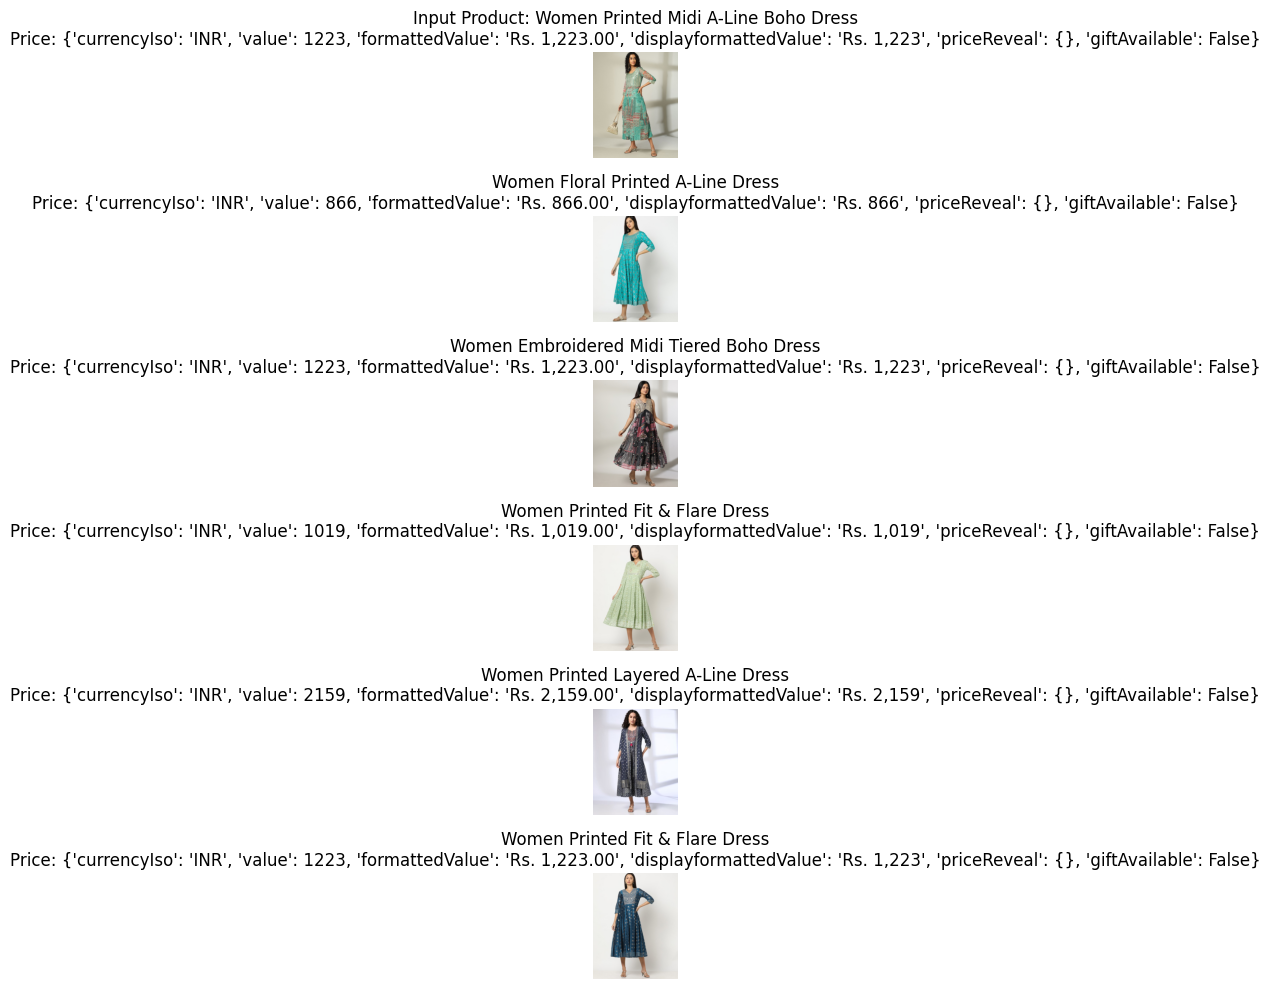

In [16]:
# Recommend similar products for a given product
get_recommendations(200, data, tfidf_matrix, top_n=5)